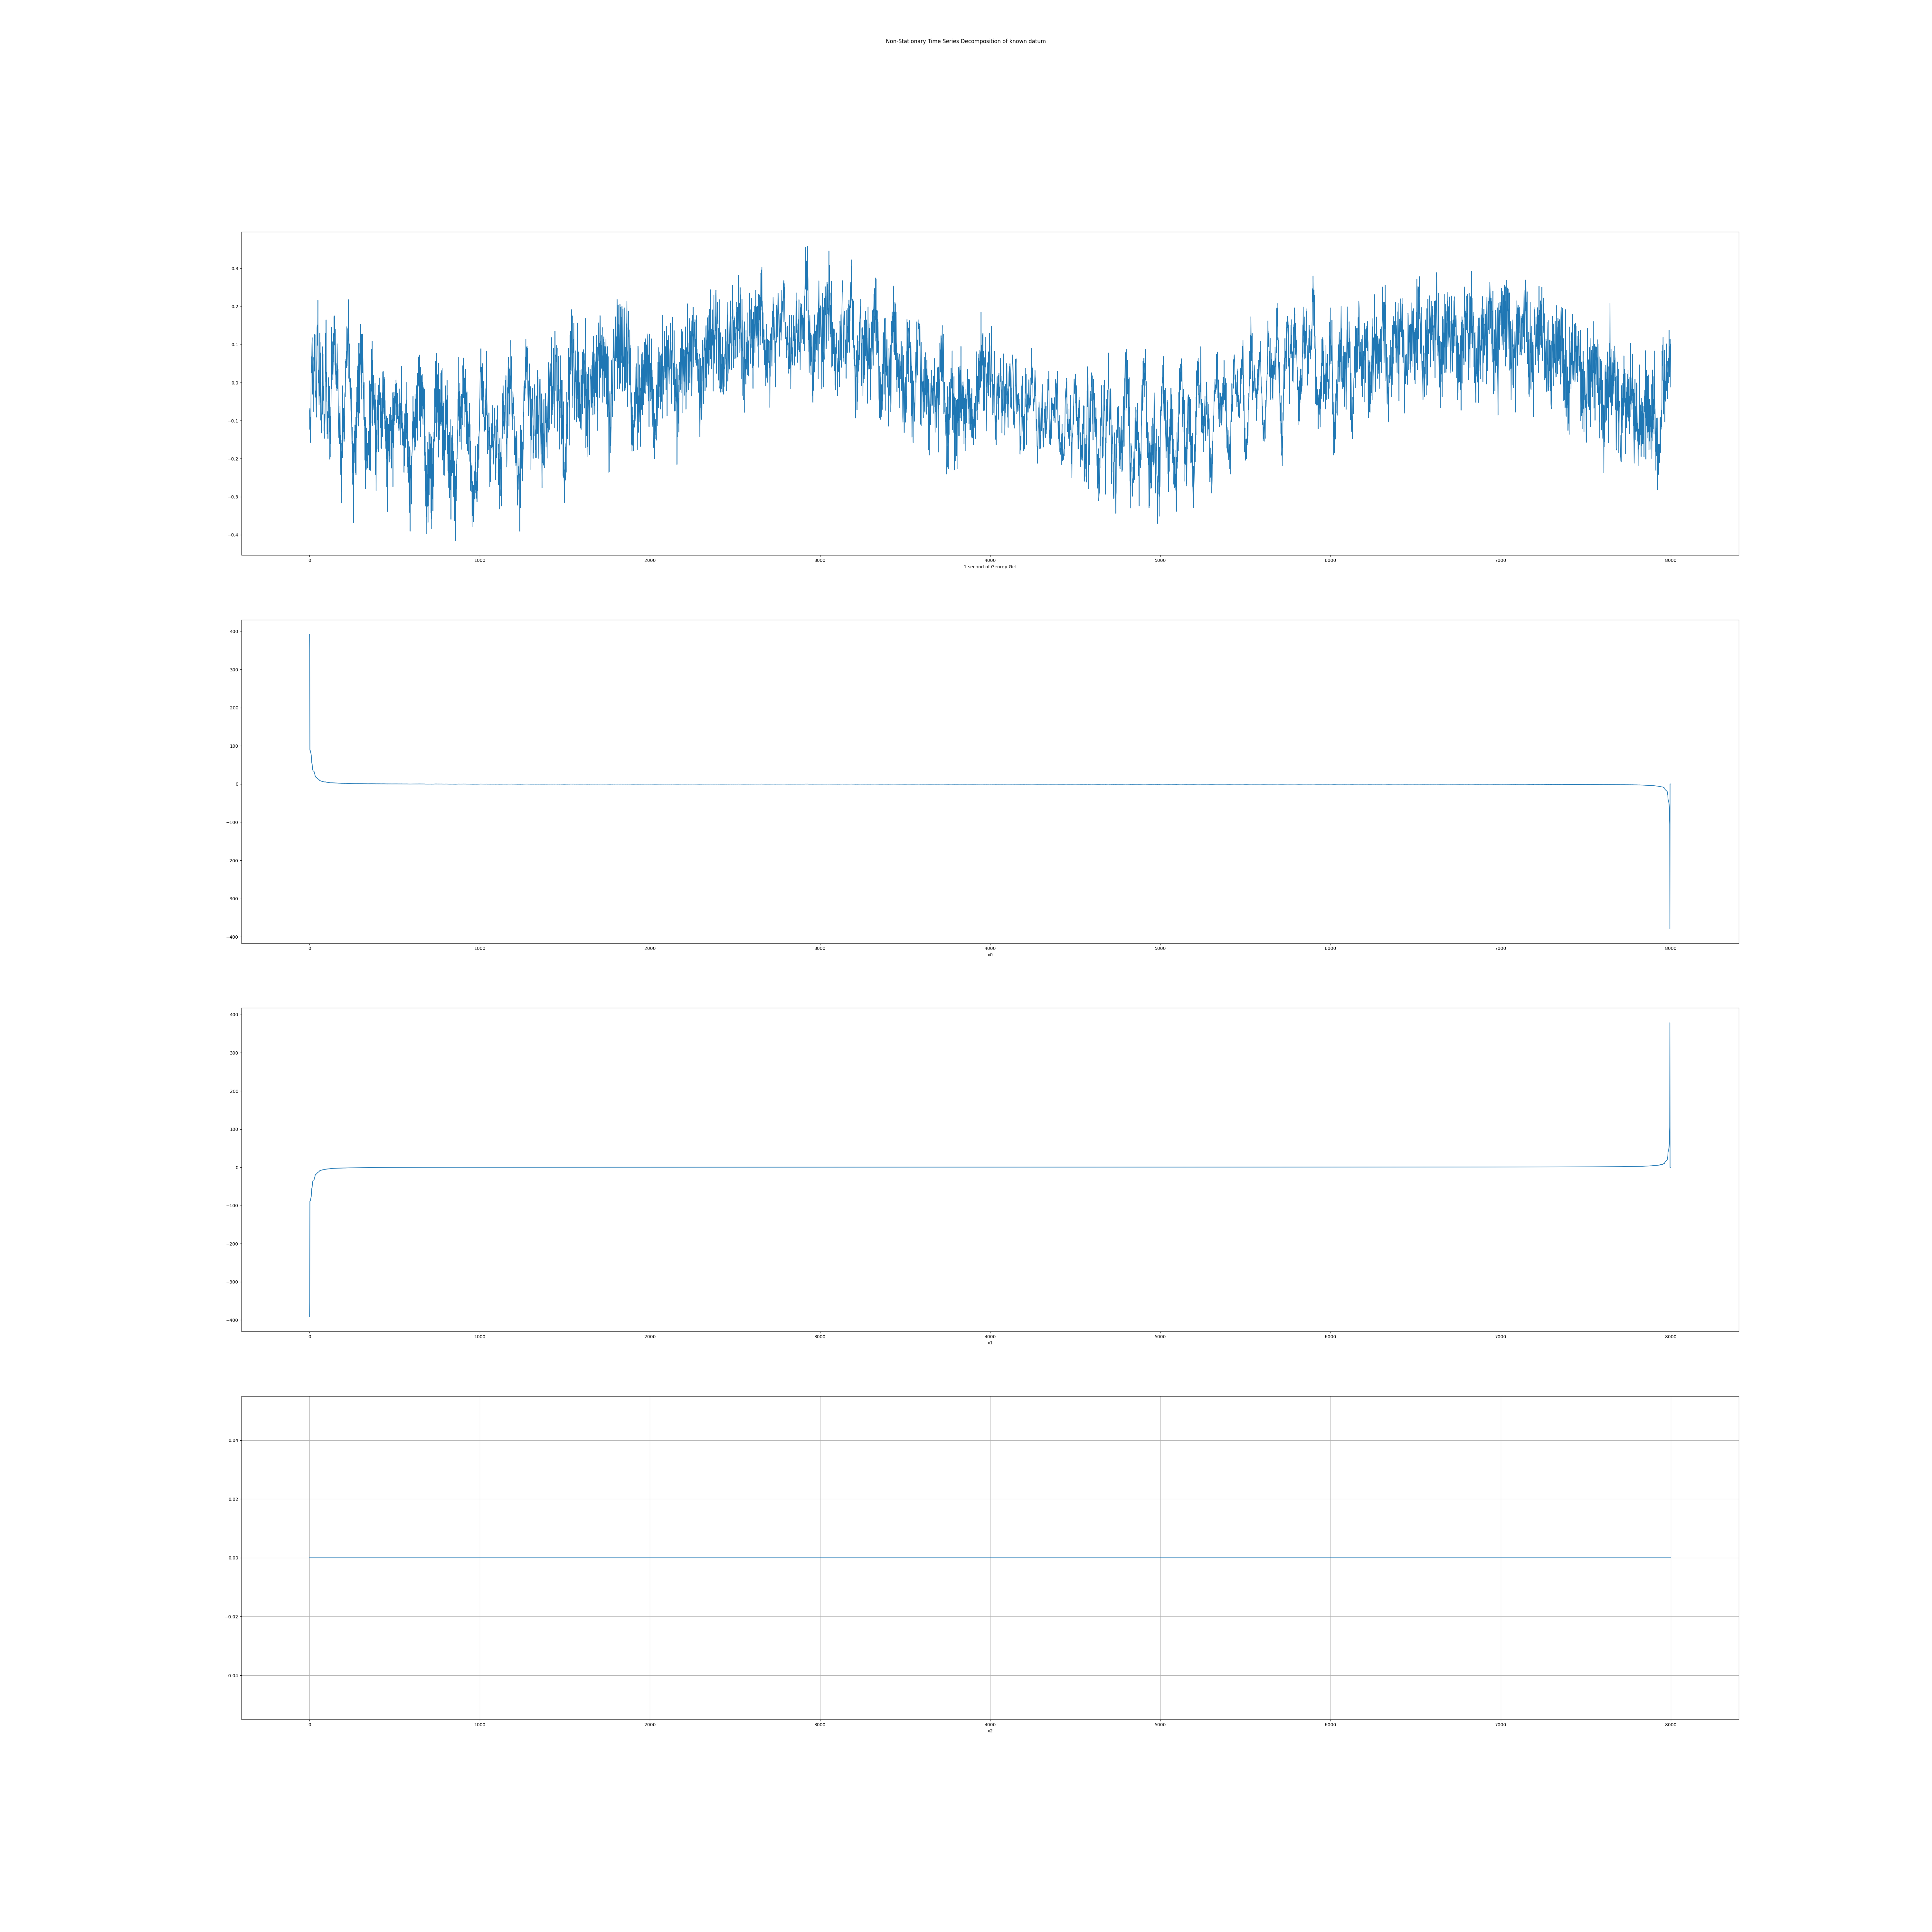

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import numpy


def detect_peaks(x: list[numpy.float64]):
    """Detect peaks in data based on their amplitude and other features.
    warning: this code is an optimized copy of the "Marcos Duarte, https://github.com/demotu/BMC"
    matlab compliant detect peaks function intended for use with data sets that only want
    rising edge and is optimized for numba. experiment with it at your own peril.
    """
    # find indexes of all peaks
    x = numpy.asarray(x)
    if len(x) < 3:
        return np.empty(1, np.int64)
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    indl = numpy.asarray(indnan)

    if indl.size!= 0:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf

    vil = numpy.zeros(dx.size + 1)
    vil[:-1] = dx[:]# hacky solution because numba does not like hstack tuple arrays
    #np.asarray((dx[:], [0.]))# hacky solution because numba does not like hstack
    vix = numpy.zeros(dx.size + 1)
    vix[1:] = dx[:]

    ind = numpy.unique(np.where((vil <= 0) & (vix > 0))[0])
    # handle NaN's
    # NaN's and values close to NaN's cannot be peaks
    if ind.size and indl.size:
        outliers = np.unique(np.concatenate((indnan, indnan - 1, indnan + 1)))
        booloutliers = isin(ind, outliers)
        booloutliers = numpy.invert(booloutliers)
        ind = ind[booloutliers]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size - 1:
        ind = ind[:-1]
    return ind



def ITD(data: list[int]):
    # notes:
    # The pythonic way to COPY an array is to do x[:] = y[:]
    # do x=y and it wont copy it, so any changes made to X will also be made to Y.
    # also, += does an append instead of a +
    # math.sqrt is 7x faster than numpy.sqrt but not designed for complex numbers.
    # specifying the type and size in advance of all variables accelerates their use, particularily when JIT is used.
    # However, JIT does not permit arbitrary types like UNION? maybe it does but i havnt figured out how.
    # this implementation uses a lot of for loops because they can be easily vectorized by simply replacing
    # range with numba.prange and also because they will translate well to other languages
    # this implementation of FABADA is not optimized for 2d arrays, however, it is easily swapped by changing the means
    # estimation and by simply changing all other code to iterate over 2d instead of 1d
    # care must be taken with numba parallelization/vectorization
    #we will now implement the intrinsic time-scale decomposition algorithm.
    #function H=itd(x)
    N_max = 10
    working_set = numpy.zeros_like(data)
    working_set[:] = data[:]
    xx = working_set.transpose()
    E_x = sum(numpy.square(working_set)) # same thing as E_x=sum(x.^2);
    counter = 0
    STOP = False
    #we have to initialize the array, because awkward doesn't have an empty array initializer-
    #and because we do not know the first value! of the array
    counter = counter + 1
    Lx, Hx = itd_baseline_extract(xx)
    L1 = numpy.asarray(Lx)
    H = numpy.asarray(Hx)
    STOP = stop_iter(xx, counter, N_max, E_x)
    if STOP:
        print("finished in one iteration")
        return H

    xx = numpy.asarray(L1)

    while 1:
        counter = counter + 1
        Lx, Hx = itd_baseline_extract(xx)
        L1= numpy.asarray(Lx)
        H = numpy.vstack((H,numpy.asarray(Hx)))

        STOP = stop_iter(xx, counter, N_max, E_x)
        if STOP:
            print("reached stop in ", counter, " iterations.")
            H = numpy.vstack((H, numpy.asarray(L1)))
            break
        xx = numpy.asarray(L1)
    return H

def stop_iter(xx,counter,N_max,E_x) -> (bool):
    if (counter>N_max):
        return True
    Exx= sum(numpy.square(xx))
    exr = 0.01 * E_x
    truth = numpy.less_equal(Exx,exr)
    if truth:
       print("value exceeded truth")
       return True
    #https://blog.ytotech.com/2015/11/01/findpeaks-in-python/ we may want to switch
    #to the PeakUtils interpolate function for better results
    #however, since there is no filtering going on here, we will use Marcos Duarte's code
    pks1= set(detect_peaks(xx))
    pks2= set(detect_peaks(-xx))

    pks= pks1.union(pks2)
    if (len(pks)<=7):
        return True

    return False

#"""% Matlab Written by Linshan Jia (jialinshan123@126.com)
#% Xi'an Jiaotong University
#% Version 1.0.0
#% 2018-11-04"""

def multidim_intersect(arr1, arr2):
    arr1_view = arr1.view([('',arr1.dtype)]*arr1.shape[1])
    arr2_view = arr2.view([('',arr2.dtype)]*arr2.shape[1])
    intersected = numpy.intersect1d(arr1_view, arr2_view)
    return intersected.view(arr1.dtype).reshape(-1, arr1.shape[1])


def itd_baseline_extract(data: list[int]) -> (list[int], list[int]):

   #dt = np.dtype([('value', np.float64, 16), ('index', np.int, (2,))])
    x = numpy.asarray(numpy.transpose(data[:])) #x=x(:)';
    t = list(range(x.size))
    # t=1:length(x); should do the same as this

    alpha=0.5
    idx_max = detect_peaks(x)
    val_max = x[idx_max] #get peaks based on indexes
    idx_min= detect_peaks(-x)
    val_min = x[idx_min]
    val_min= -val_min

    H = numpy.zeros_like(x)
    L = numpy.zeros_like(x)
    #y_interp = np.interp(x_interp, x, y) yields an interpolation of the function y_interp = f(x_interp)
    # based on a previous interpolation y = f(x), where x.size = y.size, x_interp.size = y_interp.size.
    #scipy is (idx_min,val_min)(t)[idx_max]
    #interpolator = interp1d(extrema_indices, baseline_knots / x[extrema_indices], kind='linear')(t)

    #x = np.interp(y_max, y_data, x_data,  left=None, right=None, period=None)
    #max_line = numpy.interp(max(max_knots),max_knots, idx_max,  left=None, right=None, period=None)[t]


    num_extrema = len(val_max) + len(val_min)# numpy.union1d(idx_max,idx_min)
    extrema_indices = np.zeros(((num_extrema + 2)), dtype=numpy.int)
    extrema_indices[1:-1] = np.union1d(idx_max, idx_min)
    extrema_indices[-1] = len(x) - 1

    baseline_knots = np.zeros(len(extrema_indices))
    baseline_knots[0] = np.mean(x[:2])
    baseline_knots[-1] = np.mean(x[-2:])


    baseline_knots = np.zeros(len(extrema_indices))
    baseline_knots[0] = np.mean(x[:2])
    baseline_knots[-1] = np.mean(x[-2:])

    for k in range(1, len(extrema_indices) - 1):
        baseline_knots[k] = alpha * (x[extrema_indices[k - 1]] + \
        (extrema_indices[k] - extrema_indices[k - 1]) / (extrema_indices[k + 1] - extrema_indices[k - 1]) * \
        (x[extrema_indices[k + 1]] - x[extrema_indices[k - 1]])) + \
                            alpha * x[extrema_indices[k]]

    interpolator = numpy.interp(t,extrema_indices, baseline_knots / x[extrema_indices])

    #print(interpolator_numba,interpolator,len(interpolator), len(interpolator_numba))
    Lk1 = np.asarray(alpha * interpolator[idx_min] + val_min * (1 - alpha))
    Lk2 = np.asarray(alpha * interpolator[idx_max] + val_max * (1 - alpha))

    Lk1 = numpy.hstack((np.atleast_2d(idx_min).T, np.atleast_2d(Lk1).T))
    Lk2 = numpy.hstack((np.atleast_2d(idx_max).T, np.atleast_2d(Lk2).T))
    Lk = numpy.vstack((Lk1,Lk2))
    Lk = Lk[Lk[:,1].argsort()]
    if Lk.size > 6:
        Lk = Lk[1:-1,:]

    Ls = numpy.asarray(([1],Lk[0,1]))
    Lk = numpy.vstack((Ls,Lk))
    Ls = numpy.asarray(([len(x)], Lk[-1, 1]))
    Lk = numpy.vstack((Lk, Ls))

    idx_Xk = numpy.concatenate(([0], extrema_indices, [x.size]))  # idx_Xk=[1,idx_cb,length(x)];
    for k in range(len(idx_Xk) - 5):
        for j in range(idx_Xk[k], idx_Xk[k + 1]):
            vk = (Lk[k + 1, 1] - Lk[k,1])
            sk = (x[idx_Xk[k + 1]] - x[idx_Xk[k]])
            kij = vk / sk  # $compute the slope K
            L[j] = Lk[k,1] + kij * (x[j] - x[idx_Xk[k]])
#
    H = numpy.subtract(x, L)

    return L,H

inputarray = [-7.379557192325592041e-02, -1.229025349020957947e-01, -6.823866069316864014e-02, -9.151905775070190430e-02, -9.164849668741226196e-02, -1.074047833681106567e-01, -1.575385481119155884e-01, -1.187961027026176453e-01, -8.080478012561798096e-02, 1.896231248974800110e-02, 4.516632482409477234e-02, 2.635395899415016174e-02, 6.747012585401535034e-02, 5.567305907607078552e-02, 9.720688313245773315e-02, 1.181702762842178345e-01, 6.081329658627510071e-02, -1.412852481007575989e-02, -3.068302944302558899e-02, -2.436117455363273621e-02, -1.755801402032375336e-02, -7.668709754943847656e-02, -5.676578357815742493e-02, -1.370615209452807903e-03, 5.622620694339275360e-03, 6.597991287708282471e-02, 5.285447463393211365e-02, 7.990067452192306519e-02, 8.213941007852554321e-02, 1.260891705751419067e-01, 2.981645800173282623e-02, 6.162900477647781372e-02, 1.256690472364425659e-01, -3.885707259178161621e-02, -2.161800116300582886e-02, -2.388211898505687714e-02, -3.462298586964607239e-02, -3.299422562122344971e-02, -4.034312069416046143e-02, -7.844880968332290649e-02, -9.094148874282836914e-02, -3.740644827485084534e-02, 5.272742360830307007e-02, 7.031103968620300293e-02, 1.436059921979904175e-01, 1.512401551008224487e-01, 1.020681560039520264e-01, 9.785984456539154053e-02, 1.156526505947113037e-01, 2.161471694707870483e-01, 5.395267158746719360e-02, 2.495715208351612091e-02, 2.390759327681735158e-04, -1.132600824348628521e-03, 3.309286013245582581e-02, -2.174700982868671417e-02, -5.825019627809524536e-02, -9.697953239083290100e-03, -3.561458364129066467e-02, 9.799340739846229553e-03, 1.298731416463851929e-01, 6.353887915611267090e-02, 1.054281145334243774e-01, -5.194122716784477234e-02, 7.780433446168899536e-02, 4.384769126772880554e-02, -9.892856329679489136e-02, 1.384618110023438931e-03, -4.211983829736709595e-02, -9.511680901050567627e-02, -1.323749423027038574e-01, -1.195372194051742554e-01, -1.148153096437454224e-01, -8.120266348123550415e-02, -6.100799515843391418e-02, -8.336252719163894653e-02, -1.163966115564107895e-02, 9.403777867555618286e-02, 4.130976647138595581e-02, 7.464813441038131714e-02, -7.363529875874519348e-03, -2.490960434079170227e-02, -4.664693400263786316e-02, -9.417336434125900269e-03, -2.868438325822353363e-02, -1.264862716197967529e-01, -1.163947954773902893e-01, -1.467099785804748535e-01, -9.402330219745635986e-02, -8.276534825563430786e-02, -1.084201335906982422e-01, -9.065247327089309692e-02, 2.292282646521925926e-03, 2.414789982140064240e-03, 1.290042251348495483e-01, 2.464022673666477203e-02, 2.820838056504726410e-02, 1.647224724292755127e-01, -1.008095405995845795e-02, 1.496845390647649765e-02, 2.713187970221042633e-02, -4.935103282332420349e-02, -4.900349304080009460e-02, -1.351761072874069214e-01, -1.264876425266265869e-01, -7.640233635902404785e-02, -8.340156823396682739e-02, -1.080988049507141113e-01, -1.471959948539733887e-01, -7.513047009706497192e-02, -9.256866574287414551e-02, -8.578863926231861115e-03, 1.293031685054302216e-02, -6.050250306725502014e-02, -2.973642013967037201e-02, -1.049828901886940002e-01, -1.288664489984512329e-01, -9.195497259497642517e-03, -8.551534265279769897e-02, -2.015441656112670898e-01, -1.381197124719619751e-01, -1.957266777753829956e-01, -1.137887388467788696e-01, -8.818079531192779541e-02, -1.600197404623031616e-01, -6.439820677042007446e-02, -6.343719363212585449e-02, 2.174017764627933502e-02, -1.518892496824264526e-02, 5.681955441832542419e-02, 1.452148258686065674e-01, 1.620312035083770752e-02, 7.805662602186203003e-02, 1.075128093361854553e-01, 6.559225171804428101e-02, 2.219810150563716888e-02, 3.995312377810478210e-02, 7.168280426412820816e-03, 2.938883192837238312e-02, 5.659717321395874023e-02, 5.512387678027153015e-02, 1.286161094903945923e-01, 7.528410851955413818e-02, 8.304499089717864990e-02, 1.734466552734375000e-01, 1.414385288953781128e-01, 1.751987338066101074e-01, 1.458150744438171387e-01, 9.812715649604797363e-02, 1.209642812609672546e-01, 4.543425887823104858e-02, 1.404293328523635864e-01, 7.165893912315368652e-02, 2.181613072752952576e-02, 1.962459832429885864e-02, -4.892588127404451370e-03, 3.038166277110576630e-02, 3.058151528239250183e-02, 2.866494283080101013e-02, -1.467267796397209167e-02, 4.970106482505798340e-02, -2.133689448237419128e-02, 1.019304692745208740e-01, 7.476608455181121826e-02, -1.626604795455932617e-02, 4.381205886602401733e-02, 2.887442475184798241e-03, 3.462309017777442932e-02, -3.673718124628067017e-02, -8.198488503694534302e-02, -1.193441301584243774e-01, -1.295242309570312500e-01, -1.444813609123229980e-01, -1.267473846673965454e-01, -8.065654337406158447e-02, -1.607288569211959839e-01, -1.567795574665069580e-01, -1.094385236501693726e-01, -1.287078708410263062e-01, -6.194173172116279602e-02, -1.273034662008285522e-01, -1.755763441324234009e-01, -1.387462019920349121e-01, -1.917608976364135742e-01, -2.420022487640380859e-01, -1.514354050159454346e-01, -2.224123477935791016e-01, -3.165110647678375244e-01, -1.817458570003509521e-01, -2.866818904876708984e-01, -1.593543887138366699e-01, -1.874355226755142212e-01, -1.870876401662826538e-01, -1.779696643352508545e-01, -1.977065652608871460e-01, -8.281169459223747253e-03, -1.632667928934097290e-01, -1.045701801776885986e-01, -9.646613895893096924e-02, -6.732247024774551392e-02, -8.750877529382705688e-02, -1.291496455669403076e-01, -1.228246986865997314e-01, -1.547471135854721069e-01, -8.977840095758438110e-02, -1.481863856315612793e-01, -7.608739286661148071e-02, -3.139794617891311646e-02, -2.664183452725410461e-02, -3.239524737000465393e-02, -3.670493885874748230e-02, 1.248448248952627182e-02, 5.620692297816276550e-02, 5.020145699381828308e-02, 6.081916391849517822e-02, 5.462462455034255981e-02, 7.083614170551300049e-02, 8.227363973855972290e-02, 3.896322101354598999e-02, 1.467942893505096436e-01, 4.382886365056037903e-02, 6.523633748292922974e-02, 9.430079907178878784e-02, 8.863122761249542236e-02, 1.247747316956520081e-01, 1.415631324052810669e-01, 6.306554377079010010e-02, 1.094380766153335571e-02, 2.179149687290191650e-01, 1.109001040458679199e-01, 1.287483572959899902e-01, 1.282357573509216309e-01, 9.886495769023895264e-02, 1.021052971482276917e-01, 9.840720146894454956e-02, 5.802105367183685303e-02, 2.496215514838695526e-03, 8.994168601930141449e-03, -4.223008826375007629e-02, 1.044158264994621277e-02, 7.740254048258066177e-03, -2.094260603189468384e-02, -1.724781841039657593e-02, -7.060781121253967285e-02, -8.565548062324523926e-02, -1.381208933889865875e-02, -7.114755362272262573e-02, -8.824548870325088501e-02, -1.203532889485359192e-01, -1.612988561391830444e-01, -1.174149066209793091e-01, -1.852449774742126465e-01, -2.357978373765945435e-01, -1.541697233915328979e-01, -2.677806615829467773e-01, -2.128610759973526001e-01, -2.242075800895690918e-01, -3.009235858917236328e-01, -1.608216017484664917e-01, -3.682347834110260010e-01, -2.122566699981689453e-01, -1.730937212705612183e-01, -2.100893110036849976e-01, -1.742286831140518188e-01, -1.825616359710693359e-01, -1.270335763692855835e-01, -1.768641620874404907e-01, -1.110940650105476379e-01, -2.378940731287002563e-01, -1.146569624543190002e-01, -2.319506108760833740e-01, -2.129464745521545410e-01, -9.163584560155868530e-02, -2.429351210594177246e-01, -1.449326574802398682e-01, -5.249372124671936035e-02, -1.448060870170593262e-01, -1.272736340761184692e-01, -1.188261620700359344e-02, -9.300255030393600464e-02, 3.215770795941352844e-02, 4.106838256120681763e-03, -7.721845805644989014e-02, 2.340514771640300751e-02, 4.380921274423599243e-02, -1.115976050496101379e-01, 4.754334315657615662e-02, 8.193092420697212219e-03, -1.143701374530792236e-01, 1.030370444059371948e-01, -7.819538563489913940e-02, 7.697512209415435791e-02, -8.051582425832748413e-02, -6.564675271511077881e-02, 7.404860109090805054e-02, -7.092756778001785278e-02, 1.040895953774452209e-01, 4.759707301855087280e-02, 6.823906302452087402e-02, 6.151096895337104797e-02, 1.527743339538574219e-01, 4.748411104083061218e-02, 1.982521265745162964e-02, 2.379494905471801758e-02, -4.359138011932373047e-02, 1.266389638185501099e-01, 1.949068345129489899e-02, 6.223547970876097679e-04, 1.205929145216941833e-01, 6.052427738904953003e-02, 3.190447017550468445e-02, 1.273271590471267700e-01, 2.584713697433471680e-02, 7.725920528173446655e-02, 4.603369906544685364e-02, -1.323686167597770691e-02, -7.564306724816560745e-03, -4.331378638744354248e-02, -2.834901213645935059e-02, -9.712575376033782959e-02, 3.069153754040598869e-04, -1.054948270320892334e-01, -1.138274744153022766e-01, -1.046476364135742188e-01, -9.084367752075195312e-02, -2.038513422012329102e-01, -1.850742846727371216e-01, -1.003781780600547791e-01, -2.789567708969116211e-01, -1.110425665974617004e-01, -9.103398770093917847e-02, -2.063595652580261230e-01, -1.189744770526885986e-01, -1.406852006912231445e-01, -1.452851593494415283e-01, -1.204782202839851379e-01, -2.280670702457427979e-01, -2.206027358770370483e-01, -1.982905119657516479e-01, -1.975552737712860107e-01, -2.245180457830429077e-01, -1.591678112745285034e-01, -1.897248923778533936e-01, -2.241043150424957275e-01, -1.661023646593093872e-01, -1.842758506536483765e-01, -1.281960159540176392e-01, -1.723506450653076172e-01, -1.909563839435577393e-01, -1.427610963582992554e-01, -2.045324593782424927e-01, -1.258015334606170654e-01, -1.302201747894287109e-01, -2.294644862413406372e-01, 4.985361360013484955e-03, -1.119281426072120667e-01, -7.354339212179183960e-02, -3.993915859609842300e-03, -2.308775782585144043e-01, -1.474391296505928040e-02, -8.173766732215881348e-02, -1.068237423896789551e-01, -1.162839680910110474e-02, 4.383979365229606628e-02, -2.154707722365856171e-02, 8.741216361522674561e-02, 5.795435979962348938e-02, -2.451213635504245758e-02, 1.089888215065002441e-01, -1.128320470452308655e-01, 5.868025124073028564e-02, -2.698747813701629639e-02, -7.071598619222640991e-02, -1.672915968811139464e-04, -5.240169167518615723e-02, 1.897036843001842499e-02, -5.392035096883773804e-02, -6.574254482984542847e-02, -7.158817350864410400e-02, -4.293998330831527710e-02, -3.259990736842155457e-02, -7.695797085762023926e-02, -1.063801050186157227e-01, -9.873519092798233032e-02, -1.117630749940872192e-01, -2.307802205905318260e-03, -2.424850910902023315e-01, -1.371953487396240234e-01, -4.532522708177566528e-02, -2.303637117147445679e-01, -6.368813663721084595e-02, -2.839057743549346924e-01, -1.319312304258346558e-01, -1.394737958908081055e-01, -1.822542697191238403e-01, -1.246613040566444397e-01, -1.383263319730758667e-01, -3.348880261182785034e-02, -9.836327284574508667e-02, -4.611246660351753235e-02, -6.712248176336288452e-02, -4.599487036466598511e-02, -1.754167228937149048e-01, -9.098030626773834229e-02, -8.667362481355667114e-02, -1.819649040699005127e-01, -6.524214055389165878e-03, -8.773285150527954102e-02, -3.743422031402587891e-02, 1.241615787148475647e-02, -5.078615248203277588e-02, -3.700605779886245728e-02, -5.845119804143905640e-02, -2.529098466038703918e-02, -6.859622895717620850e-02, -9.977167099714279175e-02, -1.031546369194984436e-01, -1.182734891772270203e-01, -2.656745351850986481e-02, -1.014736667275428772e-01, -1.715147048234939575e-01, -4.070429503917694092e-02, -1.138709336519241333e-01, -8.198153972625732422e-02, -1.735220849514007568e-01, -1.061988621950149536e-01, -7.613529264926910400e-02, -1.256726384162902832e-01, -2.732609584927558899e-02, -1.419978886842727661e-01, 2.637813426554203033e-02, 2.846625447273254395e-02, -8.157602697610855103e-02, 2.914801985025405884e-02, 3.814515192061662674e-03, -6.533456593751907349e-02, -6.898531690239906311e-03, -2.303523197770118713e-02, -7.816406339406967163e-02, 8.239299058914184570e-03, -3.294284641742706299e-02, -9.553965181112289429e-02, 1.370799075812101364e-02, -1.221644133329391479e-01, -4.752887040376663208e-02, -1.097317487001419067e-01, -1.538354307413101196e-01, -1.007900014519691467e-01, -1.731413900852203369e-01, -1.291987448930740356e-01, -2.004527151584625244e-01, -8.761163800954818726e-02, -1.700135171413421631e-01, -1.251909285783767700e-01, -2.737779021263122559e-01, -1.161314919590950012e-01, -1.526835709810256958e-01, -3.386140763759613037e-01, -9.378339350223541260e-02, -3.075827956199645996e-01, -2.022949010133743286e-01, -2.177011966705322266e-01, -1.658177226781845093e-01, -1.795846372842788696e-01, -1.096514388918876648e-01, -1.436299085617065430e-01, -1.759663224220275879e-01, -9.166596084833145142e-02, -2.091462165117263794e-01, -8.393157273530960083e-02, -1.924213021993637085e-01, -1.192371472716331482e-01, -1.213836893439292908e-01, -1.132675036787986755e-01, -1.218620091676712036e-01, -6.556823104619979858e-02, -1.172682568430900574e-01, -1.270730346441268921e-01, -1.172452047467231750e-01, -2.006536126136779785e-01, -8.603429794311523438e-02, -2.247332483530044556e-01, -1.396606117486953735e-01, -1.731383651494979858e-01, -9.905754774808883667e-02, -1.232343018054962158e-01, -9.598792344331741333e-02, -1.580342501401901245e-01, -1.583423763513565063e-01, -2.657697536051273346e-02, -2.737817168235778809e-01, -4.207450896501541138e-02, -1.713740825653076172e-01, -1.162842810153961182e-01, -5.774155631661415100e-02, -1.673723459243774414e-01, -2.480194158852100372e-02, -1.111169308423995972e-01, -3.596457466483116150e-02, -7.604771107435226440e-02, -9.977945685386657715e-02, -5.610792338848114014e-02, -3.719010576605796814e-02, -8.501777797937393188e-02, -3.637262806296348572e-02, -5.001239012926816940e-03, -5.372272431850433350e-02, -4.273499920964241028e-02, 7.006674073636531830e-03, -9.062233380973339081e-03, -6.305427104234695435e-02, -2.121504396200180054e-03, -1.057277992367744446e-01, -1.913370750844478607e-02, -3.428170830011367798e-02, -9.597215056419372559e-02, -7.167216390371322632e-02, -7.223094254732131958e-02, -2.774355746805667877e-02, -8.462362736463546753e-02, -5.729321390390396118e-02, -1.173737049102783203e-01, -1.186174750328063965e-01, -8.944984525442123413e-02, -1.174159944057464600e-01, -1.265084296464920044e-01, -1.223668977618217468e-01, -1.653060130774974823e-02, -1.084682270884513855e-01, -8.448776602745056152e-02, -6.759154051542282104e-02, -1.264817416667938232e-01, -5.402105674147605896e-02, -1.638676375150680542e-01, -8.403585851192474365e-02, -8.529295772314071655e-02, -6.260949373245239258e-02, -7.440274953842163086e-02, -3.881146386265754700e-02, -1.256412360817193985e-02, -1.192959845066070557e-01, 4.290562123060226440e-02, -8.263056725263595581e-02, -1.225433051586151123e-01, -7.573464512825012207e-02, -1.645665913820266724e-01, -1.060604453086853027e-01, -1.467160880565643311e-01, -1.441137194633483887e-01, -1.557657569646835327e-01, -1.527356356382369995e-01, -1.296290755271911621e-01, -1.662445366382598877e-01, -1.511346697807312012e-01, -1.216588988900184631e-01, -2.361490279436111450e-01, -1.231053024530410767e-01, -1.137510091066360474e-01, -2.181828171014785767e-01, -8.180753886699676514e-02, -1.518210470676422119e-01, -1.240823715925216675e-01, -8.290892094373703003e-02, -1.103599369525909424e-01, -1.703381389379501343e-01, -5.620173737406730652e-02, -1.320758759975433350e-01, -1.014234647154808044e-01, -8.170429617166519165e-02, -9.018106013536453247e-02, -4.590499401092529297e-02, -1.485774070024490356e-01, 7.037180475890636444e-04, -2.059670686721801758e-01, -1.049236208200454712e-01, -8.068296313285827637e-02, -2.217879444360733032e-01, -1.002852544188499451e-01, -2.377658039331436157e-01, -1.566149294376373291e-01, -1.548469364643096924e-01, -2.620416283607482910e-01, -2.092982828617095947e-01, -2.581707537174224854e-01, -1.968470364809036255e-01, -2.323278188705444336e-01, -3.411473929882049561e-01, -1.687206029891967773e-01, -3.219053149223327637e-01, -3.092224299907684326e-01, -1.767139136791229248e-01, -3.907743990421295166e-01, -2.520522177219390869e-01, -2.176962494850158691e-01, -2.454292029142379761e-01, -2.507229149341583252e-01, -2.316732257604598999e-01, -2.559660673141479492e-01, -2.640392780303955078e-01, -1.939354836940765381e-01, -3.193009197711944580e-01, -1.970494836568832397e-01, -1.868060827255249023e-01, -1.801466196775436401e-01, -1.536028832197189331e-01, -1.200757697224617004e-01, -1.022451072931289673e-01, -1.478642225265502930e-01, -3.618869930505752563e-02, -1.423005908727645874e-01, -1.140862256288528442e-01, -1.137088984251022339e-01, -1.440970748662948608e-01, -7.660859823226928711e-02, -1.345179975032806396e-01, -9.665359556674957275e-02, -1.562592387199401855e-01, -9.363467246294021606e-02, -9.140948951244354248e-02, -1.780113875865936279e-01, -3.079684823751449585e-02, -1.534080803394317627e-01, -1.680318862199783325e-01, -4.295355826616287231e-02, -1.209761723875999451e-01, -1.292321681976318359e-01, -6.289639323949813843e-02, -1.197983548045158386e-01, -8.447462692856788635e-03, -1.189794614911079407e-01, -1.149709895253181458e-01, -7.085955888032913208e-02, -9.411673992872238159e-02, -2.167636714875698090e-02, -1.517531722784042358e-01, 2.436337433755397797e-02, -6.103122979402542114e-02, -6.327326875180006027e-03, -9.884589351713657379e-03, -8.156596682965755463e-03, 4.780007060617208481e-03, 6.720415502786636353e-02, 3.228747844696044922e-02, -5.717465654015541077e-03, 4.738219827413558960e-02, -5.692083016037940979e-02, 7.220686972141265869e-02, -9.971693903207778931e-02, 4.784691147506237030e-03, -4.006251320242881775e-02, -1.185565348714590073e-02, 8.061311207711696625e-03, -1.428648680448532104e-01, 4.007698968052864075e-02, -4.649722948670387268e-02, -7.613853365182876587e-02, -4.073761776089668274e-02, 1.821924746036529541e-02, -8.846389502286911011e-02, -1.264826278202235699e-03, 3.546918043866753578e-03, -4.273943975567817688e-02, 2.162223495543003082e-02, -6.103315204381942749e-02, -3.310602041892707348e-04, -9.375070780515670776e-02, -7.707130629569292068e-03, -1.100906729698181152e-01, -1.323012635111808777e-02, -3.294317424297332764e-02, -4.737850651144981384e-02, -5.620701238512992859e-02, -6.985955685377120972e-02, -3.946964070200920105e-02, -1.036805137991905212e-01, -1.675099134445190430e-02, -1.908916085958480835e-01, -5.725769326090812683e-02, -2.325307875871658325e-01, -1.403720527887344360e-01, -2.551410198211669922e-01, -2.856436073780059814e-01, -2.328062057495117188e-01, -3.248198330402374268e-01, -1.822565495967864990e-01, -3.979461491107940674e-01, -2.174091786146163940e-01, -2.890212237834930420e-01, -2.840126156806945801e-01, -3.519195914268493652e-01, -2.684899568557739258e-01, -3.254515230655670166e-01, -3.002734482288360596e-01, -2.426483631134033203e-01, -3.245997726917266846e-01, -1.565035581588745117e-01, -3.674686849117279053e-01, -1.758247613906860352e-01, -3.236104249954223633e-01, -2.116248905658721924e-01, -2.761938273906707764e-01, -2.905402183532714844e-01, -1.298196613788604736e-01, -2.950704395771026611e-01, -1.992276012897491455e-01, -2.511374354362487793e-01, -1.781777739524841309e-01, -2.187940925359725952e-01, -1.347924768924713135e-01, -2.304295152425765991e-01, -1.606355458498001099e-01, -2.516457736492156982e-01, -1.846836358308792114e-01, -2.014237493276596069e-01, -3.422445654869079590e-01, -1.941034644842147827e-01, -3.581085503101348877e-01, -1.424668282270431519e-01, -3.840931951999664307e-01, -2.261258810758590698e-01, -2.156544327735900879e-01, -3.047822117805480957e-01, -2.751945853233337402e-01, -2.801008224487304688e-01, -1.728540211915969849e-01, -3.368419706821441650e-01, -1.301929652690887451e-01, -2.733461558818817139e-01, -1.488911956548690796e-01, -2.231245636940002441e-01, -1.529870033264160156e-01, -1.708517521619796753e-01, -1.468102931976318359e-01, -1.118563041090965271e-01, -1.540967822074890137e-01, -1.625460572540760040e-02, -1.401737630367279053e-01, -4.257356747984886169e-02, -1.062310859560966492e-01, 3.396699950098991394e-02, -6.331618130207061768e-02, 5.600036680698394775e-02, -2.746419748291373253e-03, 1.614635065197944641e-02, 3.219684585928916931e-02, -5.498394370079040527e-02, 7.626222819089889526e-02, -1.415676325559616089e-01, 9.798835031688213348e-03, -1.049262732267379761e-01, 3.823856124654412270e-03, -7.800185680389404297e-02, -4.676932469010353088e-02, 2.069936133921146393e-02, -4.895311966538429260e-02, -6.475994735956192017e-02, -1.478632241487503052e-01, 5.100945010781288147e-02, -1.959831565618515015e-01, 1.085145398974418640e-02, -1.263967305421829224e-01, -5.009651556611061096e-02, -1.842525601387023926e-02, -1.247153133153915405e-01, -2.243023179471492767e-02, -1.503221839666366577e-01, -1.845869421958923340e-02, -1.137671694159507751e-01, -7.679848372936248779e-02, -7.073359191417694092e-02, -5.334528908133506775e-02, -1.084132269024848938e-01, 2.486948482692241669e-02, -1.030190512537956238e-01, 2.846554480493068695e-02, -1.519577670842409134e-02, -9.887501597404479980e-02, 3.279916569590568542e-02, -1.127856150269508362e-01, 3.699324280023574829e-02, -2.037791758775711060e-01, -6.227610260248184204e-02, -1.424831449985504150e-01, -1.061428934335708618e-01, -1.092049777507781982e-01, -1.916060894727706909e-01, -5.440089851617813110e-02, -1.210028976202011108e-01, -1.371363401412963867e-01, -2.430777847766876221e-01, -4.955901578068733215e-02, -2.442467361688613892e-01, -1.388376057147979736e-01, -1.558576673269271851e-01, -1.260188966989517212e-01, -1.252509951591491699e-01, -1.509517580270767212e-01, -2.539298124611377716e-02, -1.773063093423843384e-01, -8.615923114120960236e-03, -1.443613022565841675e-01, -2.635764889419078827e-02, -1.184033229947090149e-01, -7.477550953626632690e-02, -9.765524417161941528e-02, -6.143619492650032043e-02, -4.511266574263572693e-02, -1.101463586091995239e-01, 5.848487373441457748e-03, -1.652211993932723999e-01, -3.416847437620162964e-02, -1.874922811985015869e-01, -6.913210451602935791e-02, -2.321712821722030640e-01, -1.861562877893447876e-01, -1.724634915590286255e-01, -2.361387759447097778e-01, -1.386564373970031738e-01, -2.761134505271911621e-01, -1.426076740026473999e-01, -2.041905075311660767e-01, -1.843996793031692505e-01, -3.029535412788391113e-01, -1.310185492038726807e-01, -2.713549137115478516e-01, -2.772374451160430908e-01, -2.039268910884857178e-01, -2.248720824718475342e-01, -2.642751038074493408e-01, -2.817009091377258301e-01, -9.738948196172714233e-02, -3.596449792385101318e-01, -1.449455767869949341e-01, -2.447962611913681030e-01, -1.798654645681381226e-01, -2.051981538534164429e-01, -2.368182837963104248e-01, -1.388861835002899170e-01, -1.979430764913558960e-01, -1.483062505722045898e-01, -2.368676215410232544e-01, -1.152716130018234253e-01, -2.320460081100463867e-01, -1.603488177061080933e-01, -2.914897501468658447e-01, -1.804322600364685059e-01, -2.938005626201629639e-01, -2.996210157871246338e-01, -2.292671203613281250e-01, -3.136842250823974609e-01, -2.061464637517929077e-01, -3.634672164916992188e-01, -2.059951573610305786e-01, -3.119257390499114990e-01, -2.522474825382232666e-01, -3.964914083480834961e-01, -2.810826599597930908e-01, -2.583717703819274902e-01, -4.151978492736816406e-01, -2.455027699470520020e-01, -3.064185678958892822e-01, -2.488991618156433105e-01, -3.110841810703277588e-01, -2.162264436483383179e-01, -2.789362668991088867e-01, -2.066232115030288696e-01, -1.996992081403732300e-01, -2.007641047239303589e-01, -1.749320775270462036e-01, -1.590079218149185181e-01, -1.262802928686141968e-01, -1.219359040260314941e-01, -4.356338828802108765e-02, -9.931658208370208740e-02, 6.657980382442474365e-02, -8.876189589500427246e-02, -2.605926617980003357e-02, -8.386635035276412964e-02, -4.621323198080062866e-02, -6.301039457321166992e-02, -1.398317962884902954e-01, -2.282616868615150452e-02, -1.244094893336296082e-01, -1.972785685211420059e-03, -1.554484963417053223e-01, -6.409753113985061646e-02, -7.700773328542709351e-02, -6.393072009086608887e-02, -1.216308549046516418e-01, -1.028309911489486694e-01, -3.526157885789871216e-02, -1.757879555225372314e-01, -3.051521629095077515e-02, -9.162357449531555176e-02, -3.486564755439758301e-02, -9.094642847776412964e-02, -7.868285477161407471e-02, -1.109590977430343628e-01, -5.417726933956146240e-02, -3.083594515919685364e-02, -5.285360291600227356e-02, 4.458607360720634460e-02, -6.906134076416492462e-04, 6.463720649480819702e-02, -4.044365137815475464e-02, 5.563094839453697205e-02, 3.797717392444610596e-03, 6.466123461723327637e-02, -2.074006013572216034e-02, -4.264150187373161316e-02, 1.199709996581077576e-02, -5.512354522943496704e-02, -1.955125294625759125e-02, -1.174155101180076599e-01, 3.031440079212188721e-02, -7.723526656627655029e-02, 3.483502194285392761e-02, -5.807961896061897278e-02, -1.050660386681556702e-02, -1.598623953759670258e-02, -8.487625420093536377e-02, -2.692829631268978119e-02, -1.610935628414154053e-01, -3.277588635683059692e-02, -1.504434198141098022e-01, -2.404689416289329529e-02, -1.281601339578628540e-01, -7.517143338918685913e-02, -8.936626464128494263e-02, -1.788476556539535522e-01, -8.580092340707778931e-02, -1.783309280872344971e-01, -1.500878334045410156e-01, -1.884080469608306885e-01, -1.087248846888542175e-01, -1.420992165803909302e-01, -1.033803671598434448e-01, -1.198875233530998230e-01, -8.233809471130371094e-02, -1.417955756187438965e-01, -5.421681702136993408e-02, -1.186803802847862244e-01, -2.071211040019989014e-01, -1.105811893939971924e-01, -1.853353381156921387e-01, -1.535837650299072266e-01, -2.834648787975311279e-01, -1.991454511880874634e-01, -2.637135982513427734e-01, -2.109266221523284912e-01, -2.491341680288314819e-01, -2.539345622062683105e-01, -2.217670381069183350e-01, -2.866861820220947266e-01, -2.180602997541427612e-01, -3.790365457534790039e-01, -2.601470351219177246e-01, -3.225511014461517334e-01, -3.404569625854492188e-01, -3.499793708324432373e-01, -3.250690102577209473e-01, -2.945680320262908936e-01, -3.664290606975555420e-01, -2.700431644916534424e-01, -3.478460907936096191e-01, -3.173203766345977783e-01, -3.662810921669006348e-01, -2.489660084247589111e-01, -2.967930436134338379e-01, -3.057944774627685547e-01, -2.343269139528274536e-01, -2.357771992683410645e-01, -2.298002094030380249e-01, -2.288568913936614990e-01, -1.664979755878448486e-01, -2.813123166561126709e-01, -2.097323983907699585e-01, -2.905274033546447754e-01, -2.594784200191497803e-01, -3.045359849929809570e-01, -2.752235531806945801e-01, -2.896136045455932617e-01, -2.603546679019927979e-01, -2.353300750255584717e-01, -3.135355412960052490e-01, -2.263109833002090454e-01, -2.646042406558990479e-01, -1.622455269098281860e-01, -2.834273278713226318e-01, -2.057903110980987549e-01, -1.651621460914611816e-01, -2.240287065505981445e-01, -1.858379840850830078e-01, -2.018179744482040405e-01, -1.421497315168380737e-01, -1.996039599180221558e-01, -1.361534297466278076e-01, -1.293427199125289917e-01, -1.244438365101814270e-01, -8.438065648078918457e-02, -4.811133816838264465e-02, -3.928848356008529663e-02, -1.525703235529363155e-03, 4.057596623897552490e-02, 2.773660607635974884e-02, 3.695794194936752319e-02, 4.686887189745903015e-02, 8.904444426298141479e-02, -1.427554525434970856e-02, 4.073654115200042725e-02, 1.771008246578276157e-03, -4.546981770545244217e-03, -4.509757459163665771e-02, -4.696138575673103333e-02, -2.575634047389030457e-03, -4.796091094613075256e-02, 4.972853511571884155e-02, -8.251187950372695923e-02, -8.528809994459152222e-03, 2.798638306558132172e-04, -2.901191823184490204e-02, -3.615615516901016235e-02, -1.285798847675323486e-02, 2.635379321873188019e-03, -9.012267738580703735e-02, -6.640434265136718750e-02, -1.285390406847000122e-01, -1.176775395870208740e-01, -1.210518702864646912e-01, -9.061153233051300049e-02, -1.268110424280166626e-01, -1.045133769512176514e-01, -4.585445299744606018e-02, -8.763756603002548218e-02, -1.244843378663063049e-01, -3.691944479942321777e-02, -1.607064716517925262e-02, -4.602269083261489868e-02, -6.044429261237382889e-03, -2.291727811098098755e-02, 8.301920443773269653e-02, -8.591146022081375122e-02, -4.586686566472053528e-02, -6.054070591926574707e-02, -1.050185561180114746e-01, -8.529493212699890137e-02, -1.874881088733673096e-01, -8.589327335357666016e-02, -1.595332771539688110e-01, -1.347000002861022949e-01, -1.765705198049545288e-01, -1.307095289230346680e-01, -1.271248459815979004e-01, -1.276664435863494873e-01, -7.953774929046630859e-02, -1.004896014928817749e-01, -1.653381735086441040e-01, -1.530688852071762085e-01, -1.182484328746795654e-01, -2.739488482475280762e-01, -2.301508188247680664e-01, -2.196333855390548706e-01, -2.493986636400222778e-01, -2.601971924304962158e-01, -1.646645367145538330e-01, -1.724647730588912964e-01, -2.008757740259170532e-01, -1.166388913989067078e-01, -1.394218802452087402e-01, -1.719239652156829834e-01, -1.225512176752090454e-01, -1.078334078192710876e-01, -1.465975642204284668e-01, -5.981207266449928284e-02, -1.214671060442924500e-01, -1.683242321014404297e-01, -1.553381979465484619e-01, -1.656614542007446289e-01, -1.804752349853515625e-01, -2.149138003587722778e-01, -1.543365716934204102e-01, -2.104282975196838379e-01, -1.609832495450973511e-01, -1.359307914972305298e-01, -1.524329781532287598e-01, -1.066871061921119690e-01, -1.139558032155036926e-01, -6.673189997673034668e-02, -1.322956532239913940e-01, -1.464561671018600464e-01, -1.133372560143470764e-01, -1.915156990289688110e-01, -2.555726468563079834e-01, -1.907447576522827148e-01, -2.172481268644332886e-01, -2.369470596313476562e-01, -1.556370556354522705e-01, -1.527685225009918213e-01, -1.980916857719421387e-01, -1.659123450517654419e-01, -9.778624027967453003e-02, -1.258265823125839233e-01, -1.137397140264511108e-01, -7.834215462207794189e-02, -6.093418225646018982e-02, -1.295918077230453491e-01, -1.059243604540824890e-01, -1.389053612947463989e-01, -1.906995475292205811e-01, -1.620213389396667480e-01, -2.690199315547943115e-01, -1.852721571922302246e-01, -2.218788564205169678e-01, -2.523766458034515381e-01, -2.694298326969146729e-01, -2.558142244815826416e-01, -2.020115554332733154e-01, -3.321079909801483154e-01, -1.557085961103439331e-01, -1.454725414514541626e-01, -2.258866280317306519e-01, -1.837555319070816040e-01, -2.015009969472885132e-01, -2.188611626625061035e-01, -2.980675697326660156e-01, -2.818182706832885742e-01, -2.710102200508117676e-01, -3.243506252765655518e-01, -2.148589491844177246e-01, -1.962963342666625977e-01, -2.058521062135696411e-01, -1.285450607538223267e-01, -1.468574404716491699e-01, -1.188010498881340027e-01, -9.155122190713882446e-02, -2.877131476998329163e-02, -6.104450672864913940e-02, -8.049148134887218475e-03, -2.634494751691818237e-02, -5.915674567222595215e-02, -4.941293224692344666e-02, -1.149649098515510559e-01, -1.012947335839271545e-01, -1.350618600845336914e-01, -6.009278073906898499e-02, -1.112687513232231140e-01, -1.234833225607872009e-01, -7.835370302200317383e-02, -1.143780350685119629e-01, -9.945850074291229248e-02, -6.843911856412887573e-02, 5.597423296421766281e-03, -3.119682893157005310e-02, -4.234691336750984192e-02, 1.814722269773483276e-02, -7.299469411373138428e-02, -1.615994870662689209e-01, -1.488812565803527832e-01, -1.568532139062881470e-01, -2.219192534685134888e-01, -1.987344324588775635e-01, -1.004685238003730774e-01, -1.460647732019424438e-01, -7.882141321897506714e-02, -1.320667285472154617e-02, -3.527086600661277771e-02, 2.439456759020686150e-03, 4.942874237895011902e-02, 6.658235192298889160e-02, -2.762872911989688873e-02, 3.895255550742149353e-02, 3.995524719357490540e-02, -1.146831288933753967e-01, -7.739610504359006882e-03, -5.541073158383369446e-03, -4.295947402715682983e-02, 3.597058728337287903e-02, -8.319880068302154541e-02, 3.249924629926681519e-03, 1.451492216438055038e-02, 1.720874011516571045e-02, 1.427093613892793655e-02, -1.688379049301147461e-02, 1.107422262430191040e-01, 4.793762043118476868e-02, 5.281529203057289124e-02, 6.808873265981674194e-02, 4.901831597089767456e-02, -3.602932207286357880e-03, -8.261244744062423706e-02, -9.798152744770050049e-02, -1.154682412743568420e-01, -1.237127259373664856e-01, -5.500841885805130005e-02, -9.015642106533050537e-02, -2.397900074720382690e-02, -3.875748813152313232e-02, -5.190460011363029480e-02, -5.224642530083656311e-02, -8.150359988212585449e-02, -3.977295011281967163e-02, -9.498976171016693115e-02, -8.877284079790115356e-02, -9.371536970138549805e-02, -1.451131850481033325e-01, -1.902085244655609131e-01, -1.457182317972183228e-01, -1.833216100931167603e-01, -1.400620937347412109e-01, -1.920337527990341187e-01, -2.111259847879409790e-01, -1.452359557151794434e-01, -1.604687571525573730e-01, -2.179423570632934570e-01, -1.803903877735137939e-01, -1.285076439380645752e-01, -1.720925569534301758e-01, -2.114800214767456055e-01, -1.386570185422897339e-01, -2.074917554855346680e-01, -2.929105162620544434e-01, -2.442623227834701538e-01, -3.182789683341979980e-01, -3.222090899944305420e-01, -2.997455596923828125e-01, -2.618419826030731201e-01, -2.810169458389282227e-01, -2.483108192682266235e-01, -2.209982872009277344e-01, -2.239786088466644287e-01, -2.311055213212966919e-01, -1.982742547988891602e-01, -2.410879135131835938e-01, -2.417003065347671509e-01, -2.401372045278549194e-01, -2.737061977386474609e-01, -3.910831511020660400e-01, -2.001839131116867065e-01, -2.713194489479064941e-01, -3.225235044956207275e-01, -1.118077933788299561e-01, -3.288100063800811768e-01, -2.108718901872634888e-01, -1.964055895805358887e-01, -2.254427075386047363e-01, -2.166592180728912354e-01, -2.114139795303344727e-01, -1.244076415896415710e-01, -2.088597118854522705e-01, -1.897792220115661621e-01, -1.563671231269836426e-01, -2.416172027587890625e-01, -1.779042035341262817e-01, -2.588180899620056152e-01, -2.041740417480468750e-01, -1.536773890256881714e-01, -1.748691350221633911e-01, -7.818435877561569214e-02, -9.056919813156127930e-02, -3.075089864432811737e-02, -1.072208210825920105e-02, -1.269274577498435974e-02, 4.789096303284168243e-03, -4.749226942658424377e-02, -2.706209430471062660e-03, -3.663070127367973328e-02, -2.877366915345191956e-02, 3.325810666865436360e-07, -1.464739535003900528e-02, 6.705550849437713623e-02, 2.701036259531974792e-02, 1.141871660947799683e-01, 2.665347419679164886e-02, 8.173869922757148743e-03, 5.014618113636970520e-02, 9.301619231700897217e-02, 2.834426611661911011e-02, 5.316328257322311401e-02, 9.551955759525299072e-02, 4.255622997879981995e-02, 9.073829650878906250e-02, 3.734565526247024536e-02, 2.074577845633029938e-02, -2.928825654089450836e-02, -4.262608662247657776e-02, -8.758594095706939697e-02, -4.311269149184226990e-02, -1.593215018510818481e-02, 3.611760912463068962e-03, 4.926309455186128616e-03, 7.527674082666635513e-03, 4.947284236550331116e-02, -2.110680937767028809e-02, -1.427239738404750824e-02, -3.446329385042190552e-02, -4.919800162315368652e-02, -1.106459870934486389e-01, -1.069400236010551453e-01, -1.379643827676773071e-01, -1.400409638881683350e-01, -1.054947543889284134e-02, -2.290423959493637085e-01, -9.144344180822372437e-02, -4.297266155481338501e-02, -1.498969793319702148e-01, -9.789362549781799316e-02, -9.082200378179550171e-02, -9.359977394342422485e-02, -8.526780456304550171e-02, -5.687234178185462952e-02, -3.671476989984512329e-02, -1.421391777694225311e-02, -6.700190901756286621e-02, -7.218043506145477295e-02, -1.991496682167053223e-01, -1.354830265045166016e-01, -1.847437918186187744e-01, -1.665702462196350098e-01, -1.132184863090515137e-01, -1.403376460075378418e-01, -3.595113754272460938e-02, -5.379934329539537430e-03, -6.244276650249958038e-03, -4.089001193642616272e-02, -2.660506218671798706e-02, -6.180850416421890259e-02, -1.030441150069236755e-01, -1.759266555309295654e-01, -1.482028216123580933e-01, -1.977005600929260254e-01, -1.639402806758880615e-01, -1.235215216875076294e-01, -1.972487866878509521e-01, -3.501716628670692444e-02, -1.305177360773086548e-01, -1.347503513097763062e-01, -8.925130218267440796e-02, -7.857741415500640869e-02, -1.341982334852218628e-01, -9.622380137443542480e-02, 3.179108351469039917e-02, -5.613695830106735229e-02, 1.479463465511798859e-02, -7.013390213251113892e-02, -9.635643661022186279e-02, -8.548051118850708008e-02, -1.429030746221542358e-01, -1.994404643774032593e-01, -1.470671445131301880e-01, -8.435090631246566772e-02, -4.440348595380783081e-02, -2.895880304276943207e-02, -2.288818731904029846e-02, 8.943834342062473297e-03, 9.411748498678207397e-03, 9.505396708846092224e-03, -1.276327371597290039e-01, -1.114216744899749756e-01, -1.274535357952117920e-01, -1.492980867624282837e-01, -1.887247562408447266e-01, -1.316069513559341431e-01, -1.608904898166656494e-01, -1.453792452812194824e-01, -2.959664165973663330e-02, -2.157516777515411377e-01, -2.766275107860565186e-01, -1.484389752149581909e-01, -1.444097310304641724e-01, -2.116504609584808350e-01, -1.069336012005805969e-01, -1.471347212791442871e-01, -5.580059066414833069e-02, -4.484317824244499207e-02, -1.370199322700500488e-01, -1.349598169326782227e-01, -2.172291427850723267e-01, -1.818963289260864258e-01, -2.066785395145416260e-01, -2.231539487838745117e-01, -2.238713055849075317e-01, -1.409897357225418091e-01, -1.239446252584457397e-01, -9.911381453275680542e-02, -4.356620460748672485e-02, -5.609185621142387390e-02, -2.879724465310573578e-02, -1.052811220288276672e-01, -5.268638208508491516e-02, -9.613457322120666504e-02, -1.694654226303100586e-01, -9.974991530179977417e-02, -1.461899876594543457e-01, -1.562137603759765625e-01, -6.321910768747329712e-02, -1.292105764150619507e-01, -1.988023370504379272e-01, -9.356507658958435059e-02, -9.290439635515213013e-02, -1.184397339820861816e-01, -6.543918699026107788e-02, -4.808183014392852783e-02, -1.861561089754104614e-02, 5.257089808583259583e-02, 7.110673934221267700e-03, -1.303860247135162354e-01, -1.087703704833984375e-01, -8.481500297784805298e-02, -1.237486302852630615e-01, -6.214078143239021301e-02, -9.389911592006683350e-02, 8.564836345613002777e-03, 2.653522975742816925e-02, 4.410915076732635498e-02, 4.964676499366760254e-02, 7.471341174095869064e-03, -8.416133932769298553e-03, 2.602536976337432861e-02, 2.580014290288090706e-03, -2.269885502755641937e-02, -2.253999933600425720e-02, -1.360043603926897049e-02, 1.183165088295936584e-01, -1.077722832560539246e-01, 5.391317233443260193e-02, -2.664215303957462311e-02, -8.389700204133987427e-02, -2.328457310795783997e-02, -7.123440504074096680e-02, -1.043821964412927628e-02, -6.474342197179794312e-02, -1.105338055640459061e-02, 3.271842375397682190e-02, 9.006064385175704956e-02, 7.141656242311000824e-03, -6.599103566259145737e-03, -5.615535750985145569e-02, -3.390680626034736633e-02, -1.191450282931327820e-01, -2.918016724288463593e-02, -2.865967340767383575e-02, 5.146300792694091797e-02, 1.349793225526809692e-01, 7.393600791692733765e-02, 7.307408004999160767e-02, 7.150369137525558472e-02, 6.602958589792251587e-02, -2.058744803071022034e-02, 2.568921260535717010e-02, -4.897634685039520264e-02, 5.188193172216415405e-02, 6.672710925340652466e-02, 9.744859486818313599e-02, 5.443183332681655884e-02, 6.085800006985664368e-02, 9.096669405698776245e-02, -1.158762574195861816e-01, -1.278992742300033569e-01, -9.364719688892364502e-02, -1.025455370545387268e-01, -6.703923456370830536e-03, -3.547173365950584412e-02, -4.701194167137145996e-02, 3.042225353419780731e-02, 6.910386681556701660e-02, -1.676200702786445618e-02, -9.035193175077438354e-02, -1.259170919656753540e-01, -1.749247014522552490e-01, -4.972248151898384094e-02, -1.182768195867538452e-01, -1.809826306998729706e-02, -9.329381585121154785e-02, 5.438935756683349609e-02, 7.052644342184066772e-02, -4.278741311281919479e-03, 1.356672309339046478e-02, -6.662678718566894531e-02, -1.739951223134994507e-02, -9.204111993312835693e-02, -2.381442300975322723e-02, -1.619388014078140259e-01, 5.876746028661727905e-03, -1.350140571594238281e-01, 5.669495090842247009e-03, -6.793087720870971680e-02, -1.468461155891418457e-01, -1.124864742159843445e-01, -1.367880553007125854e-01, -8.504605293273925781e-02, -2.444293946027755737e-01, -9.694162011146545410e-02, -2.492244541645050049e-01, -5.038398131728172302e-02, -2.360443025827407837e-01, -2.290042340755462646e-01, -2.630399465560913086e-01, -3.155150413513183594e-01, -2.730600833892822266e-01, -2.903516292572021484e-01, -2.095310091972351074e-01, -2.591093182563781738e-01, -1.605119556188583374e-01, -1.917405873537063599e-01, -1.767692267894744873e-01, -2.556401193141937256e-01, -1.931925863027572632e-01, -1.686480939388275146e-01, -2.359220683574676514e-01, -1.464939564466476440e-01, -1.104179769754409790e-01, -1.129309535026550293e-01, -2.566986531019210815e-02, -1.155391931533813477e-01, -5.207942053675651550e-02, -8.265947550535202026e-02, -1.473165005445480347e-01, -1.335498839616775513e-01, -7.952363044023513794e-02, -5.837334319949150085e-02, 4.215983790345489979e-04, -4.423062130808830261e-02, 9.043353796005249023e-02, -2.517931722104549408e-02, -2.758502587676048279e-02, 1.931977458298206329e-02, -1.646599769592285156e-01, 1.103414129465818405e-02, -6.506230682134628296e-02, 6.611838936805725098e-02, 1.476996298879384995e-02, 1.242491602897644043e-01, 3.344857692718505859e-02, 1.350069940090179443e-01, 8.578035980463027954e-02, 2.190283499658107758e-02, 3.351903334259986877e-02, 3.193683549761772156e-02, 7.125934958457946777e-02, 8.021360635757446289e-02, 1.915628761053085327e-01, 1.044020354747772217e-01, 1.692927181720733643e-01, 1.102562770247459412e-01, 1.753044277429580688e-01, -3.357969969511032104e-02, 2.888826467096805573e-02, -6.555876880884170532e-02, 1.268757227808237076e-02, 1.115701422095298767e-01, 7.805661112070083618e-02, 1.133588403463363647e-01, 1.028966456651687622e-01, 1.558082103729248047e-01, 4.237686470150947571e-02, 3.443167731165885925e-02, -1.521899364888668060e-02, -9.716726839542388916e-02, -8.093124628067016602e-02, -7.316450774669647217e-02, 1.865438558161258698e-02, 8.371147513389587402e-02, 4.262047633528709412e-02, 2.937778364866971970e-03, 1.065282430499792099e-02, 5.144765600562095642e-03, -3.979539498686790466e-02, -1.065090065822005272e-03, -1.035038530826568604e-01, -3.923569340258836746e-03, 6.332849152386188507e-03, 3.158011659979820251e-02, -4.334684833884239197e-02, 1.567224413156509399e-01, 1.904422231018543243e-02, -3.245508298277854919e-02, -5.857792217284440994e-03, -9.015184640884399414e-02, -1.173400040715932846e-02, 2.313138544559478760e-02, 2.964260987937450409e-02, -9.343668073415756226e-02, 8.087409287691116333e-02, -6.645067781209945679e-02, 2.557076804805546999e-04, -7.794486731290817261e-02, -1.017568185925483704e-01, -9.450152516365051270e-02, -9.535858035087585449e-02, 3.243264555931091309e-02, -6.228483840823173523e-02, -9.911886602640151978e-02, -6.399088352918624878e-02, -1.197479143738746643e-01, -5.647511780261993408e-02, -8.854562044143676758e-02, -1.232580021023750305e-01, -1.000353544950485229e-01, 1.925446838140487671e-02, -3.670988231897354126e-02, 4.025851842015981674e-03, 3.430268168449401855e-02, -5.557508021593093872e-02, 8.041251450777053833e-02, -8.144124597311019897e-02, -4.533887282013893127e-02, -4.961785301566123962e-02, -2.004163805395364761e-03, 6.736157834529876709e-02, 8.641811460256576538e-02, 6.312477588653564453e-02, 8.047303557395935059e-02, -2.271553501486778259e-03, 5.752495303750038147e-02, -4.369436204433441162e-02, -6.715568155050277710e-02, -2.677777782082557678e-02, -3.632520884275436401e-02, 7.628866285085678101e-02, 4.762176424264907837e-02, 1.688564419746398926e-01, -2.506119199097156525e-02, -3.430462628602981567e-02, 2.086714841425418854e-02, -1.716586500406265259e-01, -3.638506680727005005e-02, -1.402689218521118164e-01, -1.349742561578750610e-01, -1.751227304339408875e-02, -4.293959215283393860e-02, 2.875294350087642670e-02, -1.152591258287429810e-01, 2.191608212888240814e-02, -1.687084734439849854e-01, -1.219011321663856506e-01, -1.526134312152862549e-01, -1.958710551261901855e-01, -7.180796563625335693e-02, -4.905356466770172119e-02, 3.947723284363746643e-02, -2.562889829277992249e-02, 1.560574304312467575e-02, -9.716591238975524902e-02, -4.561322182416915894e-02, -1.041175052523612976e-01, -1.890173554420471191e-01, -9.886098653078079224e-02, -9.822144359350204468e-02, -3.892188519239425659e-02, 3.520514443516731262e-02, 1.658789813518524170e-02, 9.400678798556327820e-03, 2.031232975423336029e-02, 8.643882349133491516e-03, -1.265033148229122162e-02, -5.538966879248619080e-02, -1.884644478559494019e-02, 1.564933173358440399e-02, -6.527172774076461792e-02, 4.469932243227958679e-02, -5.406235530972480774e-02, 8.055188506841659546e-02, 6.447570025920867920e-02, 2.867519110441207886e-02, -2.099524438381195068e-02, -8.551910519599914551e-02, 1.765248179435729980e-02, 3.076495602726936340e-03, 1.220277026295661926e-01, -1.600525341928005219e-02, 5.151618272066116333e-02, -3.828344866633415222e-02, 5.773730948567390442e-02, 3.217215090990066528e-02, -6.118050962686538696e-02, 2.165506407618522644e-02, -8.305031061172485352e-02, 7.611698657274246216e-02, 4.713932424783706665e-02, 5.456802248954772949e-02, 1.864024251699447632e-02, -2.684938721358776093e-02, 1.342161279171705246e-02, 5.912401154637336731e-02, 8.269770443439483643e-02, -3.784571960568428040e-02, 1.128182634711265564e-01, 1.626796647906303406e-02, 1.245060339570045471e-01, 6.969403475522994995e-02, 9.358997642993927002e-02, 5.159802734851837158e-02, -7.426880300045013428e-02, 3.618098795413970947e-02, -1.263821721076965332e-01, 6.562133133411407471e-02, 8.030458539724349976e-02, 1.568399667739868164e-01, 1.185942441225051880e-01, 1.141768172383308411e-01, 5.795199424028396606e-02, 6.311102956533432007e-02, 1.034453585743904114e-01, -3.911229595541954041e-02, 3.620416671037673950e-02, 9.323869831860065460e-03, 1.437072157859802246e-01, 1.759206503629684448e-01, 1.727279424667358398e-01, 1.013554409146308899e-01, 1.355555001646280289e-02, 1.072729751467704773e-01, 5.533443018794059753e-02, 9.827885031700134277e-02, 3.626289591193199158e-02, 6.540313363075256348e-02, 4.007654264569282532e-02, 1.238396316766738892e-01, 1.033845096826553345e-01, 1.132997497916221619e-01, 1.446941345930099487e-01, 2.016974426805973053e-02, 3.343415260314941406e-02, -5.192734673619270325e-02, 7.017221301794052124e-02, -3.517873957753181458e-02, 1.133541092276573181e-01, 3.018825873732566833e-02, 3.577485308051109314e-02, 1.201302632689476013e-01, 5.022129043936729431e-02, 1.058823615312576294e-01, -2.925315313041210175e-02, 1.453354675322771072e-02, -3.685420006513595581e-02, 7.973480969667434692e-02, 9.556788206100463867e-02, 5.352442711591720581e-02, 1.298033911734819412e-02, 5.157623812556266785e-02, 9.378746151924133301e-02, 6.910951435565948486e-02, 1.150495037436485291e-01, -5.701614916324615479e-02, 5.636395886540412903e-02, 5.966380983591079712e-02, 7.526948302984237671e-02, -3.364546969532966614e-02, 2.917145006358623505e-02, 6.269834190607070923e-02, -3.378646075725555420e-02, 9.431668370962142944e-02, -9.000646322965621948e-02, 1.904248818755149841e-02, -4.212803393602371216e-02, 6.797752529382705688e-02, -4.318642988801002502e-02, -4.893485084176063538e-02, -7.878787070512771606e-02, -2.362625747919082642e-01, -7.849963009357452393e-02, -2.338117808103561401e-01, -1.189689710736274719e-01, -9.493935853242874146e-02, -3.108374960720539093e-02, -2.270543389022350311e-02, -2.930840291082859039e-02, -8.204649388790130615e-02, -1.662825196981430054e-01, -1.171448081731796265e-01, -1.845744401216506958e-01, -1.337887197732925415e-01, -1.182111576199531555e-01, -2.088594436645507812e-02, -2.928245253860950470e-02, 5.778807774186134338e-02, -6.941129453480243683e-03, -2.832360379397869110e-02, 6.264469772577285767e-02, -5.939653515815734863e-02, -7.228058762848377228e-03, -8.999151736497879028e-02, -4.173651337623596191e-02, 1.848552934825420380e-02, 1.183397993445396423e-01, 1.267718225717544556e-01, 1.405604481697082520e-01, 1.037355288863182068e-01, 6.516397744417190552e-02, 8.195671439170837402e-02, 1.314202696084976196e-02, 5.873439088463783264e-02, -4.720150306820869446e-02, 5.241962522268295288e-02, 8.129139989614486694e-02, 1.233661249279975891e-01, 1.730881482362747192e-01, 1.342941671609878540e-01, 1.095952466130256653e-01, 5.704685300588607788e-02, 1.348717063665390015e-01, 5.360469222068786621e-02, 1.205995678901672363e-01, 8.190864324569702148e-02, 6.533435732126235962e-02, 6.551610678434371948e-02, 1.076056733727455139e-01, 2.186298519372940063e-01, 1.743953227996826172e-01, 1.277780979871749878e-01, -1.673671789467334747e-02, 6.721570156514644623e-03, 8.622766286134719849e-02, 2.039204388856887817e-01, 1.721386909484863281e-01, 1.361716240644454956e-01, 3.823517262935638428e-02, 8.786669373512268066e-02, 1.522655636072158813e-01, 1.238501816987991333e-01, 8.195908367633819580e-02, -1.528736203908920288e-02, 9.475560486316680908e-02, 7.771633565425872803e-02, 2.054371088743209839e-01, 1.005901843309402466e-01, 4.571507871150970459e-02, 8.111844956874847412e-02, -1.908255973830819130e-03, 1.980347484350204468e-01, 1.273073107004165649e-01, 1.720176339149475098e-01, 7.184001058340072632e-02, 9.381881356239318848e-02, 5.235022306442260742e-02, 6.444259732961654663e-02, 1.999396383762359619e-01, 3.305839374661445618e-02, 6.053042039275169373e-02, -2.266586758196353912e-02, 6.372738629579544067e-02, 1.348664313554763794e-01, 1.935719698667526245e-01, 1.025558337569236755e-01, 4.503802955150604248e-02, 4.227601364254951477e-02, 5.770057067275047302e-02, 5.747453495860099792e-02, 6.919613480567932129e-02, -2.147734351456165314e-02, 1.165500842034816742e-02, 1.181020662188529968e-01, 1.119216829538345337e-01, 1.966883093118667603e-01, 8.034792542457580566e-02, 8.555226773023605347e-02, -1.385184563696384430e-02, 3.948370739817619324e-02, 9.311680495738983154e-02, -1.886233501136302948e-02, 7.564713060855865479e-02, 4.104708496015518904e-04, 9.475642442703247070e-02, 1.513304561376571655e-01, 1.570064425468444824e-01, 2.139489948749542236e-01, 8.594558387994766235e-02, 7.981196790933609009e-02, -6.279472261667251587e-02, 3.751210123300552368e-02, 7.811710983514785767e-02, 4.987768456339836121e-02, 1.442508995532989502e-01, 1.365581303834915161e-01, 1.202487424015998840e-01, 1.880208402872085571e-01, 1.377996355295181274e-01, 5.356489121913909912e-02, 1.269867457449436188e-02, -5.198576021939516068e-03, 1.697002723813056946e-02, 9.076616913080215454e-02, 1.384256929159164429e-01, -7.000888697803020477e-03, 9.733224660158157349e-02, 3.132314607501029968e-02, 5.549638345837593079e-02, 8.988488465547561646e-02, -5.014408007264137268e-02, -6.003748625516891479e-02, -1.379811465740203857e-01, -2.667107433080673218e-02, -1.622550934553146362e-01, -1.205947771668434143e-01, -6.129746511578559875e-02, -1.803898960351943970e-01, -6.422411650419235229e-02, -1.648435592651367188e-01, -1.345253884792327881e-01, -9.883657842874526978e-02, -8.610356599092483521e-02, -1.221087202429771423e-01, -1.088028401136398315e-01, -1.383393108844757080e-01, -1.788587570190429688e-01, -1.680377274751663208e-01, -9.909994155168533325e-02, -1.198357045650482178e-01, -1.002203896641731262e-01, -4.558289423584938049e-02, -1.159606352448463440e-01, -2.547325193881988525e-02, -9.923183917999267578e-02, -1.014299392700195312e-01, -9.335758537054061890e-02, -3.351978957653045654e-02, -2.554155886173248291e-02, -1.607618876732885838e-03, 4.144878685474395752e-02, -2.671948820352554321e-02, 4.958948493003845215e-02, -5.501262843608856201e-02, 9.668292477726936340e-03, 5.046689882874488831e-03, -1.400943007320165634e-02, -1.358609646558761597e-02, -1.763719022274017334e-01, -9.184319525957107544e-02, -8.312654495239257812e-02, -1.314870268106460571e-02, 9.578317403793334961e-02, 7.910153269767761230e-02, -7.613901793956756592e-02, -3.890983387827873230e-02, -1.310754716396331787e-01, -1.078461036086082458e-01, -3.461673110723495483e-02, -1.033623516559600830e-01, -8.630649000406265259e-02, -7.375773042440414429e-02, 4.668569192290306091e-02, -5.927600339055061340e-02, 1.287522073835134506e-02, -8.267983794212341309e-02, -1.677890717983245850e-01, -6.392865628004074097e-02, -7.071177661418914795e-02, -1.475767232477664948e-02, -2.090303227305412292e-02, 3.379144519567489624e-02, -7.071664184331893921e-02, 5.745996162295341492e-02, 7.496102154254913330e-02, 1.690527237951755524e-02, 3.853774443268775940e-02, -7.389068603515625000e-02, -8.434709906578063965e-02, -2.739064395427703857e-02, 7.874350249767303467e-02, 1.151210977695882320e-03, 5.843115597963333130e-02, -5.815942212939262390e-02, -4.100085794925689697e-02, 6.846130359917879105e-03, 4.728291556239128113e-02, 2.281035855412483215e-02, -2.795365825295448303e-02, -7.646645884960889816e-03, -2.526945620775222778e-02, 1.054871529340744019e-01, 6.934843957424163818e-02, -1.739647425711154938e-02, -2.898728661239147186e-02, 2.661485970020294189e-02, 3.033067658543586731e-02, 1.022705212235450745e-01, 1.154216602444648743e-01, -7.467207964509725571e-03, 8.777799084782600403e-03, 2.826683921739459038e-03, 3.105675987899303436e-02, 9.910190105438232422e-02, 5.068607255816459656e-02, 3.988125920295715332e-02, -7.848083972930908203e-03, 4.274688195437192917e-03, 7.294315844774246216e-02, 1.221921071410179138e-01, 1.279690861701965332e-01, 6.824904680252075195e-02, -4.855202883481979370e-02, 7.276940345764160156e-02, -2.056006155908107758e-02, -3.446295112371444702e-02, 1.042175013571977615e-02, -1.156343966722488403e-01, 2.988039702177047729e-02, 9.309131652116775513e-02, 1.273876130580902100e-01, 7.825873792171478271e-02, 1.348273176699876785e-02, -3.781285509467124939e-02, -4.747749119997024536e-02, 5.097491666674613953e-02, 1.796884462237358093e-03, -2.368175610899925232e-02, 1.890896819531917572e-02, 1.893360540270805359e-02, -1.790051534771919250e-02, 1.148425042629241943e-01, 8.291289210319519043e-02, -4.196307435631752014e-02, -2.678350917994976044e-02, -1.166833490133285522e-01, -1.101552769541740417e-01, -2.308239415287971497e-02, 1.438508741557598114e-02, -1.627834513783454895e-02, 3.383863344788551331e-02, -6.828588247299194336e-02, -1.748780347406864166e-02, -6.749158352613449097e-02, -6.796430796384811401e-02, -1.711300313472747803e-01, -1.299066990613937378e-01, -1.159152612090110779e-01, -1.853201240301132202e-01, -8.156747370958328247e-02, -2.002412527799606323e-01, -1.315553784370422363e-01, -1.380103975534439087e-01, -1.149437502026557922e-01, -9.694939106702804565e-02, -1.015041992068290710e-01, -1.033472940325737000e-01, -1.480733305215835571e-01, -1.085982024669647217e-01, -1.229678466916084290e-01, -1.514205038547515869e-01, -6.285007577389478683e-03, -3.728690743446350098e-02, -5.574000999331474304e-02, -4.160515218973159790e-02, -1.141969710588455200e-01, -9.209320694208145142e-02, -2.124005928635597229e-02, 1.298870309256017208e-03, 5.325759947299957275e-02, -3.977956622838973999e-02, 4.958955105394124985e-03, -6.672263145446777344e-02, 8.896329440176486969e-03, 9.204758703708648682e-02, -1.060413569211959839e-02, 5.205088108777999878e-02, 3.495966084301471710e-03, -9.480641223490238190e-03, 5.609485507011413574e-02, 8.053880929946899414e-02, -3.760129585862159729e-02, 9.904595091938972473e-03, -6.987863034009933472e-02, -1.797269470989704132e-02, 7.049622386693954468e-02, 5.218572542071342468e-02, 4.838195070624351501e-02, -2.989992033690214157e-03, -4.982534050941467285e-02, 5.721328407526016235e-02, 7.525464147329330444e-02, 6.364853680133819580e-02, -1.951481914147734642e-03, -9.408921748399734497e-02, 3.883570432662963867e-02, 4.157367348670959473e-02, 1.428856104612350464e-01, 1.772501319646835327e-01, 1.546296291053295135e-02, 1.003686524927616119e-02, -3.072223812341690063e-02, 8.797452785074710846e-03, 1.888959109783172607e-02, 4.345512762665748596e-02, 7.905350998044013977e-03, 4.892475903034210205e-02, 9.318584203720092773e-02, 1.055671125650405884e-01, 1.341826766729354858e-01, 2.851667068898677826e-02, 2.901459299027919769e-02, 1.187830977141857147e-02, 9.452499449253082275e-02, 3.245875984430313110e-02, 5.359522253274917603e-02, 7.401974406093358994e-03, -1.899523288011550903e-02, 2.562702819705009460e-02, 1.482316404581069946e-01, 1.236666887998580933e-01, 1.350358426570892334e-01, 3.790398687124252319e-02, -8.738972246646881104e-02, 2.820386737585067749e-02, 4.755211248993873596e-02, 1.116777956485748291e-01, 8.420863002538681030e-02, 5.988075956702232361e-02, 4.190355166792869568e-02, 8.560622483491897583e-02, 1.233645454049110413e-01, 5.302724614739418030e-02, 2.989558875560760498e-02, 1.538097765296697617e-02, -3.629541490226984024e-03, 2.991396933794021606e-02, 3.896662220358848572e-02, 3.399192914366722107e-02, 7.027135789394378662e-02, 8.695349842309951782e-02, 9.266162663698196411e-02, 1.566845029592514038e-01, 1.232041940093040466e-01, 9.746650606393814087e-02, 3.702087327837944031e-02, 1.059791147708892822e-01, -5.593679845333099365e-02, 8.377783745527267456e-02, 5.128257349133491516e-02, -5.163912847638130188e-02, 7.716396450996398926e-02, 8.178596384823322296e-03, 1.180760189890861511e-01, 1.332961916923522949e-01, 1.718789637088775635e-01, 9.842089563608169556e-02, 7.948476821184158325e-02, 2.471512556076049805e-02, 3.759437054395675659e-02, -5.673026200383901596e-03, -2.987547079101204872e-03, 5.084231868386268616e-02, 8.991533890366554260e-03, 1.366372555494308472e-01, 5.857570096850395203e-02, 5.532290041446685791e-02, -6.953084375709295273e-03, -7.509608566761016846e-02, -4.494858160614967346e-02, -7.471203804016113281e-02, -4.495629109442234039e-03, -2.654966525733470917e-02, 8.984799496829509735e-03, -3.627431765198707581e-02, 3.942301124334335327e-02, -4.881807416677474976e-02, 4.857840761542320251e-02, -1.624912023544311523e-02, -4.861221462488174438e-02, -5.943077802658081055e-02, -2.151875644922256470e-01, -1.229151859879493713e-01, -1.424536705017089844e-01, -4.044105485081672668e-02, 7.889583357609808445e-04, 3.604020550847053528e-02, -5.188936740159988403e-02, -6.513784173876047134e-03, -1.069320961833000183e-01, -7.229809463024139404e-02, -4.153452068567276001e-02, -1.301710158586502075e-01, 1.983872614800930023e-02, -2.469080127775669098e-02, 2.680386044085025787e-02, 5.340160429477691650e-02, 3.150878474116325378e-02, 8.513450622558593750e-03, 2.441865764558315277e-02, 5.693690851330757141e-02, -1.795591972768306732e-02, 8.933053165674209595e-02, 6.074006203562021255e-03, 5.865244194865226746e-02, -4.015854559838771820e-03, 8.798222988843917847e-02, 1.250148266553878784e-01, 9.717692434787750244e-02, 1.402151733636856079e-01, -2.680721879005432129e-02, 2.789668552577495575e-02, 7.959333807229995728e-02, 1.334549337625503540e-01, 1.167384982109069824e-01, 1.009485796093940735e-01, -8.008720725774765015e-02, 1.407497841864824295e-02, 3.032622858881950378e-02, 6.456497311592102051e-02, 8.656407892704010010e-02, 3.844640776515007019e-02, 1.186916325241327286e-02, 3.098744200542569160e-03, 8.545766025781631470e-02, 3.224673122167587280e-02, 6.801540404558181763e-02, -3.383430466055870056e-02, -2.338217338547110558e-03, 3.053867071866989136e-02, 8.245187252759933472e-02, 1.462959796190261841e-01, 5.393191054463386536e-02, 7.513777911663055420e-02, -7.015541195869445801e-02, 2.580939233303070068e-02, 6.424898654222488403e-02, 5.577855929732322693e-02, 9.179611504077911377e-02, -2.517028152942657471e-02, -2.401652745902538300e-03, 7.970553636550903320e-02, 1.772421002388000488e-01, 2.069851607084274292e-01, 1.332117915153503418e-01, 7.488610595464706421e-02, 1.042520552873611450e-01, 8.986373431980609894e-03, 8.060861378908157349e-02, -1.867729984223842621e-02, -6.691663525998592377e-03, 7.114861905574798584e-02, 8.149716258049011230e-02, 1.687134355306625366e-01, 1.343377232551574707e-01, 7.285534590482711792e-02, 1.934457384049892426e-02, -1.284035854041576385e-03, 1.172318775206804276e-02, 1.233433410525321960e-01, 8.896084874868392944e-02, 8.979263156652450562e-02, 1.345023065805435181e-01, 5.546151474118232727e-02, 1.626870483160018921e-01, 1.381366997957229614e-01, 1.092358753085136414e-01, 8.139897137880325317e-02, -3.451205044984817505e-02, -3.587936982512474060e-02, 2.855934947729110718e-02, 1.416252255439758301e-01, 1.764421314001083374e-01, 1.764328628778457642e-01, 1.220227405428886414e-01, 1.392064839601516724e-01, 1.979473382234573364e-01, 1.488675177097320557e-01, 1.214294210076332092e-01, 1.101792752742767334e-01, 4.077053442597389221e-02, 1.276002228260040283e-01, 9.397687762975692749e-02, 1.153210550546646118e-01, 1.257919818162918091e-01, 1.580682992935180664e-01, 1.273259222507476807e-01, 1.652025878429412842e-01, 1.138338074088096619e-01, 5.977626144886016846e-02, 1.124035343527793884e-01, 1.132625564932823181e-01, 5.162987112998962402e-02, 8.912670612335205078e-02, 1.474733948707580566e-01, 4.602342471480369568e-02, 1.759918779134750366e-01, 4.800781607627868652e-02, 4.431600123643875122e-02, 8.807674795389175415e-02, 5.577259883284568787e-02, 4.809585958719253540e-02, 7.647664099931716919e-02, 1.108725927770137787e-02, 3.762370673939585686e-03, 3.430784121155738831e-02, -2.548632584512233734e-02, -1.421258226037025452e-02, -2.571198903024196625e-02, 6.006573885679244995e-02, 2.234145998954772949e-02, 6.683683395385742188e-02, 7.526444643735885620e-02, -7.138850539922714233e-02, -4.453634470701217651e-02, -1.039107665419578552e-01, -1.429836302995681763e-01, -8.968377858400344849e-02, -2.028959104791283607e-03, -1.477797236293554306e-02, 6.332722306251525879e-02, 2.212880412116646767e-03, -6.595522165298461914e-02, 4.395177215337753296e-02, -3.439310938119888306e-02, -1.323830150067806244e-02, -9.703413397073745728e-02, -9.315747767686843872e-02, -7.123084366321563721e-02, 2.527114376425743103e-02, 8.174273371696472168e-02, 1.096529439091682434e-01, 1.117669865489006042e-01, 5.420314148068428040e-02, 4.036404192447662354e-03, 5.030467174947261810e-03, 5.139840301126241684e-03, -5.548589304089546204e-02, 6.622517108917236328e-02, 2.127713896334171295e-02, 9.814405441284179688e-02, 1.014773696660995483e-01, 1.177024990320205688e-01, 8.501798659563064575e-02, 9.202290326356887817e-02, 1.136893779039382935e-01, -2.155966125428676605e-02, 9.070931375026702881e-02, 1.190978568047285080e-02, 6.854961067438125610e-02, 5.342638120055198669e-02, 1.397572606801986694e-01, 1.497038453817367554e-01, 1.209810376167297363e-01, 1.080307066440582275e-01, -1.226784475147724152e-02, 3.552727401256561279e-02, 4.151266813278198242e-02, 1.118150204420089722e-01, 1.055290773510932922e-01, 1.702758520841598511e-01, 5.080015212297439575e-02, 1.610126644372940063e-01, 1.417220383882522583e-01, 1.383045464754104614e-01, 1.252868473529815674e-01, 2.180786430835723877e-02, 4.526783153414726257e-02, 3.509867191314697266e-02, 1.763394922018051147e-01, 4.455013573169708252e-02, 1.929430067539215088e-01, 8.584461361169815063e-02, 9.014254063367843628e-02, 1.288398951292037964e-01, 1.000921875238418579e-01, 1.395480185747146606e-01, 1.655512750148773193e-01, 2.438336461782455444e-01, 6.179674342274665833e-02, 2.216948419809341431e-01, 9.589732438325881958e-02, 9.958038479089736938e-02, 1.406214237213134766e-01, 6.606845557689666748e-02, 3.678499907255172729e-02, 1.328922957181930542e-01, 1.279117763042449951e-01, 9.786448627710342407e-02, 1.909908801317214966e-01, 1.253800839185714722e-01, 1.521496623754501343e-01, 1.006251573562622070e-01, 1.381558328866958618e-01, -2.247237786650657654e-02, 6.842511892318725586e-02, 1.066605150699615479e-01, 1.153136640787124634e-01, 2.300305366516113281e-01, 1.309855729341506958e-01, 1.236438676714897156e-01, 5.914886668324470520e-02, 9.978730976581573486e-02, 5.072510614991188049e-02, 1.231036037206649780e-01, 1.247703060507774353e-01, 1.137849316000938416e-01, 1.725884228944778442e-01, 1.357032358646392822e-01, 2.344992756843566895e-01, 2.426479160785675049e-01, 2.217671126127243042e-01, 1.217686533927917480e-01, 5.192758142948150635e-02, 2.400774694979190826e-02, 8.345122635364532471e-02, 1.559091359376907349e-01, 1.886086761951446533e-01, 1.762936413288116455e-01, 2.107923030853271484e-01, 1.635039150714874268e-01, 1.550532728433609009e-01, 1.628010123968124390e-01, 3.895382210612297058e-02, 8.335994929075241089e-02, 6.382453255355358124e-03, 1.011799499392509460e-01, 1.427932530641555786e-01, 7.782974839210510254e-02, 2.184165269136428833e-01, 1.082831621170043945e-01, 1.286681145429611206e-01, 1.009412854909896851e-01, -1.524842437356710434e-02, -6.635161582380533218e-03, 3.284623846411705017e-02, 5.185897648334503174e-02, -2.514261007308959961e-02, 1.310793012380599976e-01, 8.508874475955963135e-02, 4.442385211586952209e-02, 7.386039942502975464e-02, -1.659687422215938568e-02, 3.132879734039306641e-02, 4.873134940862655640e-02, -1.138874702155590057e-02, -2.508728392422199249e-02, -6.998800672590732574e-04, 2.207732945680618286e-02, 5.524468049407005310e-02, 1.196940466761589050e-01, 1.985008828341960907e-02, 2.305686008185148239e-03, -1.884889230132102966e-02, -3.071473352611064911e-02, 6.724015623331069946e-02, 2.887449599802494049e-02, 1.769022643566131592e-02, -1.019693911075592041e-02, 3.845164179801940918e-02, 3.537665680050849915e-02, 4.180035740137100220e-02, 7.410144805908203125e-02, 4.767975956201553345e-02, 9.047073125839233398e-02, 1.006307974457740784e-01, 7.435569167137145996e-02, 1.394567638635635376e-01, 6.332188099622726440e-02, 6.132946163415908813e-02, 2.511031180620193481e-02, -2.208350040018558502e-02, 5.656802281737327576e-02, 6.455057114362716675e-02, 1.066389158368110657e-01, 1.102109476923942566e-01, 2.107287645339965820e-01, 1.726912111043930054e-01, 1.771250814199447632e-01, 1.457851231098175049e-01, 3.437828971073031425e-03, 2.281616814434528351e-02, 2.467080205678939819e-02, 6.430462747812271118e-02, 9.982815384864807129e-02, 7.298015058040618896e-02, 1.007488816976547241e-01, 1.604662239551544189e-01, 1.429824680089950562e-01, 1.163381263613700867e-01, 9.437201917171478271e-02, 3.515931591391563416e-02, 6.073301285505294800e-02, 1.272854655981063843e-01, 1.034476310014724731e-01, 1.710975319147109985e-01, 2.144884169101715088e-01, 1.539375036954879761e-01, 1.819264590740203857e-01, 1.364927440881729126e-01, 9.113409370183944702e-02, 8.519729226827621460e-02, 6.707424670457839966e-02, 3.371316939592361450e-02, 7.096594572067260742e-02, 1.734116822481155396e-01, 1.671550422906875610e-01, 2.556637227535247803e-01, 1.705148667097091675e-01, 2.004254758358001709e-01, 1.897233873605728149e-01, 9.669365733861923218e-02, 1.640348285436630249e-01, 3.882148116827011108e-02, 7.430947571992874146e-02, 8.790836483240127563e-02, 1.595636755228042603e-01, 1.508168280124664307e-01, 1.691889166831970215e-01, 1.537040472030639648e-01, 1.116712838411331177e-01, 1.730769425630569458e-01, 6.250961869955062866e-02, 1.021884307265281677e-01, 1.290997862815856934e-01, 1.236122623085975647e-01, 9.763403981924057007e-02, 1.458962857723236084e-01, 6.423645466566085815e-02, 1.386858224868774414e-01, 1.837909966707229614e-01, 1.407514512538909912e-01, 2.115833908319473267e-01, 1.705108433961868286e-01, 1.507877260446548462e-01, 1.485607922077178955e-01, 1.978380233049392700e-01, 6.717302650213241577e-02, 1.946935355663299561e-01, 1.308950483798980713e-01, 1.420762240886688232e-01, 1.362088769674301147e-01, 1.928739547729492188e-01, 2.816515862941741943e-01, 1.881840825080871582e-01, 2.757301926612854004e-01, 7.824437320232391357e-02, 1.770005673170089722e-01, 1.154609993100166321e-01, 2.075131237506866455e-01, 2.068740129470825195e-01, 1.816725432872772217e-01, 2.497659176588058472e-01, 1.597078740596771240e-01, 2.308401465415954590e-01, 1.457554101943969727e-01, 1.376092880964279175e-01, 8.352912962436676025e-02, 1.311060190200805664e-01, 1.031698659062385559e-02, 1.147727966308593750e-01, 9.764480590820312500e-02, 9.193401783704757690e-02, 2.190524786710739136e-01, 1.633284240961074829e-01, 1.629098951816558838e-01, 8.513218164443969727e-02, 8.964402228593826294e-02, -3.407178446650505066e-02, 6.771994382143020630e-02, -3.060908615589141846e-02, -4.533131048083305359e-02, 2.022174000740051270e-02, 2.022962458431720734e-02, 2.548184804618358612e-02, 1.352576315402984619e-01, 1.546007096767425537e-01, 5.401723086833953857e-02, 1.596651971340179443e-01, -7.835167646408081055e-02, 4.763136059045791626e-02, 6.186768785119056702e-02, 4.370934143662452698e-02, 6.074520945549011230e-02, 2.709274739027023315e-02, 8.955435827374458313e-03, -4.308096598833799362e-03, 1.368259936571121216e-01, 3.477371111512184143e-02, 1.051848828792572021e-01, 5.121704190969467163e-02, 5.819574743509292603e-02, 6.473387777805328369e-02, 1.201472580432891846e-01, 5.345346406102180481e-02, 5.690180510282516479e-02, 1.002920120954513550e-01, 2.041820436716079712e-02, 1.838307231664657593e-01, 5.289340764284133911e-02, 1.099999845027923584e-01, 1.741562969982624054e-02, 2.944081276655197144e-02, 4.375223442912101746e-02, 6.956183165311813354e-02, 1.529594957828521729e-01, 1.222379952669143677e-01, 1.653935909271240234e-01, 1.511104702949523926e-01, 2.354971319437026978e-01, 1.308770924806594849e-01, 1.915385574102401733e-01, 4.988471046090126038e-02, 8.089759945869445801e-02, 5.281783267855644226e-02, 7.606279104948043823e-02, 1.002309024333953857e-01, 9.215693175792694092e-02, 1.720416396856307983e-01, 1.159779354929924011e-01, 2.211514413356781006e-01, 1.560028791427612305e-01, 1.422941684722900391e-01, 1.018513813614845276e-01, 1.100917011499404907e-01, 3.942881152033805847e-02, 1.656926572322845459e-01, 3.522445261478424072e-02, -1.544146984815597534e-02, 1.247112005949020386e-01, 4.460755735635757446e-02, 1.854384243488311768e-01, 1.504541337490081787e-01, 1.533854156732559204e-01, 1.158673390746116638e-01, 1.495334357023239136e-01, 1.228663995862007141e-01, 1.301998645067214966e-01, 2.004950195550918579e-01, 7.905182987451553345e-02, 1.211779117584228516e-01, 1.586267054080963135e-01, 2.020692974328994751e-01, 1.710175424814224243e-01, 2.428418248891830444e-01, 1.403262317180633545e-01, 1.173238754272460938e-01, 1.990681290626525879e-01, 1.240799427032470703e-01, 1.530898809432983398e-01, 1.537004113197326660e-01, 1.164650693535804749e-01, 9.491818398237228394e-02, 2.000337690114974976e-01, 1.425455659627914429e-01, 1.600433140993118286e-01, 1.308564245700836182e-01, 1.177575066685676575e-01, 3.965986892580986023e-02, 1.285455375909805298e-01, 1.552472710609436035e-01, 9.920340776443481445e-02, 2.319724261760711670e-01, 1.365742385387420654e-01, 2.082753330469131470e-01, 2.302693277597427368e-01, 2.267189025878906250e-01, 1.646281927824020386e-01, 1.972493082284927368e-01, 1.327929794788360596e-01, 9.882007539272308350e-02, 2.240908145904541016e-01, 1.221652776002883911e-01, 1.913483738899230957e-01, 2.874317765235900879e-01, 2.686480581760406494e-01, 2.832915186882019043e-01, 2.957502901554107666e-01, 2.004711776971817017e-01, 2.300315797328948975e-01, 3.032201528549194336e-01, 1.900610029697418213e-01, 2.142923027276992798e-01, 1.972578763961791992e-01, 1.036748215556144714e-01, 1.400318443775177002e-01, 1.841358095407485962e-01, 1.815334111452102661e-01, 1.308260858058929443e-01, 1.211777254939079285e-01, 1.359821557998657227e-01, 8.538318425416946411e-02, 1.390706002712249756e-01, 1.200388893485069275e-01, 4.631669819355010986e-02, 1.120803207159042358e-01, 5.818858742713928223e-02, 1.101920455694198608e-01, 8.232794702053070068e-02, 1.126659065485000610e-01, 5.125321075320243835e-02, 3.284866362810134888e-02, 5.718213319778442383e-02, -8.728518150746822357e-03, 8.446639776229858398e-02, 1.122881006449460983e-02, 2.019598148763179779e-02, 1.900037005543708801e-02, 1.530237346887588501e-01, 7.815349102020263672e-02, 1.211853548884391785e-01, 9.091765433549880981e-02, 7.047904073260724545e-04, 1.136820092797279358e-01, 6.314843147993087769e-02, 7.555478066205978394e-02, 6.026404723525047302e-02, 1.021297797560691833e-01, 5.274911224842071533e-02, 1.113058477640151978e-01, 9.522026032209396362e-02, 1.083255708217620850e-01, 1.038499400019645691e-01, 1.090645790100097656e-01, 3.910427168011665344e-02, 3.968690708279609680e-02, 5.660431087017059326e-02, -6.537418812513351440e-02, 4.202489182353019714e-02, 1.655580848455429077e-02, 1.048748418688774109e-01, 1.243298277258872986e-01, 1.283434182405471802e-01, 9.238266199827194214e-02, 8.532644808292388916e-02, 1.286477446556091309e-01, 8.613317459821701050e-02, 1.442260891199111938e-01, 5.952911451458930969e-02, 4.301514104008674622e-02, 8.059909194707870483e-02, 1.576016694307327271e-01, 1.566613912582397461e-01, 1.877974420785903931e-01, 1.712425053119659424e-01, 1.470534801483154297e-01, 2.235402911901473999e-01, 2.046018689870834351e-01, 2.063530832529067993e-01, 1.404777318239212036e-01, 1.121051982045173645e-01, 1.201599091291427612e-01, 1.720833778381347656e-01, 1.398232430219650269e-01, 1.208087876439094543e-01, 1.184767857193946838e-01, 1.154788509011268616e-01, 5.227027833461761475e-02, 9.315212815999984741e-02, 1.021165549755096436e-01, -1.173939183354377747e-02, 1.079475656151771545e-01, 1.761896908283233643e-02, 1.395799219608306885e-01, 2.035656720399856567e-01, 1.342214792966842651e-01, 1.910022646188735962e-01, 1.204762458801269531e-01, 1.054079085588455200e-01, 1.168279871344566345e-01, 1.650558263063430786e-01, 1.208396628499031067e-01, 1.398621648550033569e-01, 1.887870281934738159e-01, 2.041726857423782349e-01, 2.351160645484924316e-01, 2.220626175403594971e-01, 2.052900046110153198e-01, 1.854791492223739624e-01, 1.770595014095306396e-01, 1.545820832252502441e-01, 1.327410340309143066e-01, 1.052376478910446167e-01, 6.887119263410568237e-02, 1.177673935890197754e-01, 1.609633415937423706e-01, 1.798260062932968140e-01, 1.519792973995208740e-01, 1.458470970392227173e-01, 1.511433422565460205e-01, 1.323992908000946045e-01, 1.818297654390335083e-01, 1.745961457490921021e-01, 1.111303567886352539e-01, 1.266978383064270020e-01, 1.526676863431930542e-01, 2.030067741870880127e-01, 2.420999705791473389e-01, 2.119229584932327271e-01, 1.866181492805480957e-01, 2.134648412466049194e-01, 2.013600170612335205e-01, 1.928214132785797119e-01, 1.958556920289993286e-01, 1.843812465667724609e-01, 1.590062975883483887e-01, 1.965941190719604492e-01, 2.620981037616729736e-01, 2.423299700021743774e-01, 2.678598165512084961e-01, 2.218346148729324341e-01, 2.601894736289978027e-01, 2.334598153829574585e-01, 2.492719441652297974e-01, 2.050054967403411865e-01, 1.664272248744964600e-01, 1.563544869422912598e-01, 1.151883974671363831e-01, 1.196608543395996094e-01, 1.541402637958526611e-01, 1.585977375507354736e-01, 1.323982477188110352e-01, 1.447189301252365112e-01, 6.831713020801544189e-02, 6.555703282356262207e-02, 1.179635003209114075e-01, 1.022824198007583618e-01, 8.496780693531036377e-02, 1.334476470947265625e-01, 9.868936985731124878e-02, 1.444134116172790527e-01, 1.108551397919654846e-01, 1.485681980848312378e-01, 8.498388528823852539e-02, 1.048647537827491760e-01, 5.370834469795227051e-02, 3.559152409434318542e-02, 6.762880831956863403e-02, 2.417326346039772034e-02, 3.680083900690078735e-02, 1.369178146123886108e-01, 1.651554703712463379e-01, 3.622642904520034790e-02, 1.762806773185729980e-01, 3.727977350354194641e-02, 3.753995895385742188e-02, 1.178509965538978577e-01, 9.274368733167648315e-02, 5.653452500700950623e-02, 5.860354751348495483e-02, -1.618272811174392700e-02, 5.419098958373069763e-02, 5.380214378237724304e-02, 5.931273475289344788e-02, 1.770414412021636963e-01, 9.751351177692413330e-02, 1.327185630798339844e-01, 7.525004446506500244e-02, 8.583980053663253784e-02, 7.389935106039047241e-02, 4.611329361796379089e-02, 9.169825166463851929e-02, 5.170336365699768066e-02, 1.135187074542045593e-01, 1.411696523427963257e-01, 1.495438814163208008e-01, 1.759836822748184204e-01, 1.094350665807723999e-01, 1.266254782676696777e-01, 1.291732639074325562e-01, 1.065997257828712463e-01, 4.814122989773750305e-02, 4.554852098226547241e-02, 5.037146806716918945e-02, 1.479668021202087402e-01, 9.006327390670776367e-02, 1.137667298316955566e-01, 7.886539399623870850e-02, 6.906784325838088989e-02, 1.084648966789245605e-01, 1.586867719888687134e-01, 2.361746430397033691e-01, 1.444592475891113281e-01, 2.143030613660812378e-01, 1.317633390426635742e-01, 1.328244358301162720e-01, 1.555316001176834106e-01, 1.539733409881591797e-01, 1.103954613208770752e-01, 1.139795929193496704e-01, 6.681764870882034302e-02, 5.252131447196006775e-02, 1.379598677158355713e-01, 8.538710325956344604e-02, 1.071374788880348206e-01, 1.647571921348571777e-01, 1.082623302936553955e-01, 1.773278117179870605e-01, 2.176967859268188477e-01, 9.723398834466934204e-02, 8.067530393600463867e-02, 8.833009749650955200e-02, 9.146230667829513550e-02, 9.487033635377883911e-02, 1.056572198867797852e-01, 3.326014056801795959e-02, 8.497197926044464111e-02, 1.968006789684295654e-01, 1.813080012798309326e-01, 2.085907608270645142e-01, 1.855309158563613892e-01, 1.042464748024940491e-01, 1.487913131713867188e-01, 2.062147408723831177e-01, 1.659657210111618042e-01, 1.824612170457839966e-01, 1.581935435533523560e-01, 1.139421314001083374e-01, 1.507214754819869995e-01, 1.764166802167892456e-01, 1.645555496215820312e-01, 1.700347959995269775e-01, 1.606274098157882690e-01, 1.013176217675209045e-01, 1.697764992713928223e-01, 1.573622673749923706e-01, 1.305862963199615479e-01, 1.594439148902893066e-01, 2.026987224817276001e-01, 1.362982988357543945e-01, 1.750378906726837158e-01, 2.276932448148727417e-01, 8.431063592433929443e-02, 2.392144352197647095e-01, 2.786311507225036621e-01, 2.851118147373199463e-01, 3.546975553035736084e-01, 3.155051171779632568e-01, 2.451043874025344849e-01, 3.219411671161651611e-01, 3.119661808013916016e-01, 2.433359771966934204e-01, 3.192107975482940674e-01, 2.190770059823989868e-01, 1.890210956335067749e-01, 2.710609138011932373e-01, 2.892423570156097412e-01, 2.426444292068481445e-01, 3.574013411998748779e-01, 2.854228615760803223e-01, 2.883138656616210938e-01, 2.694199383258819580e-01, 1.705432087182998657e-01, 1.902330666780471802e-01, 1.123066321015357971e-01, 1.612808704376220703e-01, 8.169994503259658813e-02, 1.019717156887054443e-01, 2.637570165097713470e-02, 5.356217175722122192e-02, 1.580915153026580811e-01, 1.645358949899673462e-01, 1.761702895164489746e-01, 1.328525990247726440e-01, 6.221803650259971619e-02, 4.660516977310180664e-02, 1.298161745071411133e-01, 4.381920769810676575e-02, 9.416604787111282349e-02, 2.104175649583339691e-02, 5.795558169484138489e-02, 5.579137802124023438e-02, 7.802808284759521484e-02, 1.251491308212280273e-01, 7.237817347049713135e-02, 1.208729371428489685e-01, 5.355555936694145203e-02, -9.792233817279338837e-03, -3.444694355130195618e-02, 4.441504832357168198e-03, -5.207761749625205994e-02, 8.461730927228927612e-02, -2.097507379949092865e-02, 8.009277284145355225e-02, 1.257648617029190063e-01, 3.199747530743479729e-03, 1.288869380950927734e-01, 9.030045568943023682e-02, 1.780630052089691162e-01, 1.654445528984069824e-01, 1.111053302884101868e-01, 2.725738659501075745e-02, 6.190460175275802612e-02, 5.537337437272071838e-02, 9.726637601852416992e-02, 1.338327378034591675e-01, 1.114204451441764832e-01, 1.026337370276451111e-01, 1.116388216614723206e-01, 1.519423127174377441e-01, 8.597564697265625000e-02, 1.495481133460998535e-01, 9.496109187602996826e-02, 1.243864670395851135e-01, 1.156546398997306824e-01, 8.466346561908721924e-02, 1.267675906419754028e-01, 1.507769972085952759e-01, 1.804542392492294312e-01, 1.845582425594329834e-01, 1.849435716867446899e-01, 9.952715598046779633e-03, 1.283999085426330566e-01, 2.029362767934799194e-01, 2.214297354221343994e-01, 2.672364711761474609e-01, 2.145676612854003906e-01, 1.189342886209487915e-01, 1.463456451892852783e-01, 1.949009448289871216e-01, 1.018549799919128418e-01, 1.687593758106231689e-01, 1.204090714454650879e-01, 1.209688484668731689e-01, 1.506478786468505859e-01, 2.017587572336196899e-01, 1.702946424484252930e-01, 1.988627314567565918e-01, 1.546889841556549072e-01, 1.406446695327758789e-01, 1.041562110185623169e-01, 6.154563277959823608e-02, -1.691715046763420105e-02, 1.082581467926502228e-02, 1.546548455953598022e-01, 5.473706871271133423e-02, 2.347166985273361206e-01, 1.433213055133819580e-01, 6.436195224523544312e-02, 1.380347311496734619e-01, 1.986568868160247803e-01, 1.778029948472976685e-01, 1.892282813787460327e-01, 1.722249984741210938e-01, -1.205482520163059235e-02, 8.051548898220062256e-02, 6.078041344881057739e-02, 1.290136426687240601e-01, 2.184351533651351929e-01, 2.215424627065658569e-01, 2.095646262168884277e-01, 2.033178210258483887e-01, 2.521083056926727295e-01, 2.139945030212402344e-01, 2.266083359718322754e-01, 1.774105876684188843e-01, 1.888887286186218262e-01, 8.845099806785583496e-02, 9.018003195524215698e-02, 9.657931327819824219e-02, 1.099440902471542358e-01, 2.226105928421020508e-01, 2.540457844734191895e-01, 2.634871304035186768e-01, 1.808600574731826782e-01, 2.579483985900878906e-01, 1.924556940793991089e-01, 2.180386334657669067e-01, 2.439179122447967529e-01, 1.664189249277114868e-01, 1.106935814023017883e-01, 1.950118243694305420e-01, 1.782878041267395020e-01, 1.831045746803283691e-01, 3.457362353801727295e-01, 2.164217382669448853e-01, 2.654656767845153809e-01, 3.081967532634735107e-01, 1.889027208089828491e-01, 1.796125471591949463e-01, 1.724922358989715576e-01, 1.280229687690734863e-01, 1.654327958822250366e-01, 2.028286159038543701e-01, 1.483281552791595459e-01, 1.197068467736244202e-01, 2.359667569398880005e-01, 1.999999731779098511e-01, 2.055954337120056152e-01, 2.666674256324768066e-01, 9.645694494247436523e-02, 4.011495783925056458e-02, 1.267990916967391968e-01, 1.132757589221000671e-01, 7.722258567810058594e-02, 1.582988798618316650e-01, 6.628450006246566772e-02, 4.319446906447410583e-02, 1.300346702337265015e-01, 7.525013387203216553e-02, 1.410524100065231323e-01, 1.186442226171493530e-01, 1.107048988342285156e-01, 1.237619370222091675e-01, 1.219170391559600830e-01, 1.393940150737762451e-01, 8.486352860927581787e-02, 3.066921979188919067e-02, 6.675653159618377686e-02, 4.275256395339965820e-02, -7.141202688217163086e-03, 9.199923276901245117e-02, -1.951749622821807861e-02, 3.565574437379837036e-02, 5.230860412120819092e-02, 8.674287050962448120e-02, 1.003295406699180603e-01, 9.030956774950027466e-02, 1.305411905050277710e-01, 7.653025537729263306e-02, 1.003655567765235901e-01, 6.042787432670593262e-02, 5.041705444455146790e-02, 1.674389786785468459e-04, 1.334830094128847122e-02, -3.450348600745201111e-02, 4.268191009759902954e-02, 6.441756337881088257e-02, 2.925227582454681396e-02, 1.105242967605590820e-01, 1.031814739108085632e-01, 1.058346703648567200e-01, 1.049282476305961609e-01, 2.762197516858577728e-02, 5.540157482028007507e-02, 3.343865275382995605e-02, -1.160217169672250748e-02, 5.039318278431892395e-02, 6.868910789489746094e-02, 1.609314531087875366e-01, 1.478687077760696411e-01, 1.449768990278244019e-01, 1.416559666395187378e-01, 5.895670130848884583e-02, 1.323927342891693115e-01, 1.786667853593826294e-01, 9.438133239746093750e-02, 1.251248270273208618e-01, 4.003117233514785767e-02, 4.885111376643180847e-02, 1.558849960565567017e-01, 2.038471847772598267e-01, 2.521151602268218994e-01, 2.506745457649230957e-01, 2.676800191402435303e-01, 2.381947785615921021e-01, 2.489853352308273315e-01, 1.798042953014373779e-01, 1.659305989742279053e-01, 9.856866300106048584e-02, 6.635148823261260986e-02, 9.660748392343521118e-02, 5.522919818758964539e-02, 1.628608852624893188e-01, 1.525292992591857910e-01, 1.879015117883682251e-01, 1.668766885995864868e-01, 1.659628003835678101e-01, 1.583656221628189087e-01, 4.899872839450836182e-02, 7.132143527269363403e-02, 4.897096380591392517e-02, 1.122579723596572876e-01, 7.651551067829132080e-02, 9.744655340909957886e-02, 1.093627512454986572e-02, 5.536025390028953552e-02, 8.037602901458740234e-02, 1.050170734524726868e-01, 1.898912638425827026e-01, 9.196254611015319824e-02, 1.335653364658355713e-01, 7.862579077482223511e-02, 1.478958576917648315e-01, 1.323096752166748047e-01, 1.945848017930984497e-01, 1.374418139457702637e-01, 1.404337882995605469e-01, 1.906981766223907471e-01, 1.062051355838775635e-01, 2.054586410522460938e-01, 1.916880458593368530e-01, 2.171365469694137573e-01, 1.836968958377838135e-01, 2.018942832946777344e-01, 8.777547627687454224e-02, 7.929553836584091187e-02, 1.988105326890945435e-01, 1.626275777816772461e-01, 2.633824646472930908e-01, 2.421853840351104736e-01, 2.116014659404754639e-01, 1.968121975660324097e-01, 2.401159554719924927e-01, 2.160177230834960938e-01, 2.161275148391723633e-01, 3.051175475120544434e-01, 2.274766117334365845e-01, 3.224650621414184570e-01, 2.359594106674194336e-01, 1.991730630397796631e-01, 2.196168601512908936e-01, 1.124390587210655212e-01, 2.137154340744018555e-01, 1.269960254430770874e-01, 1.330758482217788696e-01, 9.213977307081222534e-02, 9.231419861316680908e-02, 1.448508203029632568e-01, 1.350180953741073608e-01, 2.148144841194152832e-01, 6.119953095912933350e-02, 8.518121391534805298e-02, 8.220592886209487915e-02, 4.460753500461578369e-02, 9.725841879844665527e-02, 4.607124254107475281e-02, 1.879875734448432922e-02, -1.497014705091714859e-02, -7.143504917621612549e-02, -9.323292970657348633e-02, 1.934445463120937347e-03, 4.619090631604194641e-02, 1.518827211111783981e-02, 6.076132506132125854e-02, 5.084774270653724670e-02, 8.375308662652969360e-02, 6.237100809812545776e-02, 2.772834897041320801e-02, -7.212737202644348145e-02, -3.241849597543478012e-03, -7.665653713047504425e-03, -4.930551722645759583e-02, 1.233214586973190308e-01, -4.496634937822818756e-04, 1.079620122909545898e-01, 7.461290061473846436e-02, 6.663057208061218262e-02, 2.985478192567825317e-02, 4.847489669919013977e-02, 7.153408974409103394e-02, 4.624410346150398254e-02, 1.588653624057769775e-01, 5.908590182662010193e-02, 1.132041066884994507e-01, 1.297786533832550049e-01, 1.609379947185516357e-01, 1.793059557676315308e-01, 1.992320269346237183e-01, 1.890727132558822632e-01, 1.690877974033355713e-01, 2.184427529573440552e-01, 1.249307543039321899e-01, 8.551909774541854858e-02, 4.914402216672897339e-02, -7.661714684218168259e-03, 1.025829538702964783e-01, 6.228765845298767090e-02, 1.420107930898666382e-01, 1.146103665232658386e-01, 1.331633925437927246e-01, 1.275090724229812622e-01, 1.442125886678695679e-01, 1.312409937381744385e-01, -3.508880361914634705e-02, 1.225118935108184814e-01, -9.012359660118818283e-04, 1.234084293246269226e-01, 8.275961875915527344e-02, 2.115364372730255127e-02, 3.301222622394561768e-02, 1.018990855664014816e-02, 1.093690246343612671e-01, 2.880041114985942841e-02, 1.641345620155334473e-01, 1.993519067764282227e-02, 8.930364251136779785e-02, 7.577189803123474121e-02, 7.088690251111984253e-02, 1.877692043781280518e-01, 1.260093897581100464e-01, 1.213116943836212158e-01, 6.311486661434173584e-02, 6.329090148210525513e-02, 5.798706412315368652e-02, 1.645500957965850830e-01, 1.011695191264152527e-01, 1.173237711191177368e-01, 9.763356298208236694e-02, 5.227811262011528015e-02, -5.466200411319732666e-02, 2.112054266035556793e-02, 7.229214906692504883e-02, 1.018447428941726685e-01, 1.987008154392242432e-01, 8.974707126617431641e-02, 4.560966417193412781e-02, 5.687493458390235901e-02, 4.361274093389511108e-02, 3.488260135054588318e-02, 1.546176373958587646e-01, 6.069627031683921814e-02, 1.426995545625686646e-01, 3.639938309788703918e-02, 1.178795546293258667e-01, 8.636201918125152588e-02, 7.147321850061416626e-02, 8.976172655820846558e-02, -3.683844953775405884e-02, 5.184588208794593811e-02, -4.579910263419151306e-02, 8.057513833045959473e-02, 3.493738919496536255e-02, 1.594735682010650635e-01, 1.481059789657592773e-01, 1.308002024888992310e-01, 1.041750758886337280e-01, 8.110897243022918701e-02, 1.486898213624954224e-01, 9.964733570814132690e-02, 1.890412867069244385e-01, 9.432368725538253784e-02, 7.910494506359100342e-02, 6.512197107076644897e-02, 4.495595395565032959e-02, 1.047704741358757019e-01, 1.923418492078781128e-01, 1.866876184940338135e-01, 2.012879997491836548e-01, 2.320569902658462524e-01, 2.180442214012145996e-01, 2.188273370265960693e-01, 2.470912039279937744e-01, 1.310740560293197632e-01, 1.746077835559844971e-01, 1.400100290775299072e-01, 1.087975874543190002e-01, 2.159342467784881592e-01, 1.651750653982162476e-01, 2.749083340167999268e-01, 1.672614365816116333e-01, 2.722074985504150391e-01, 1.183957159519195557e-01, 1.238353773951530457e-01, 1.590873152017593384e-01, 7.373537868261337280e-02, 1.899894475936889648e-01, 1.477310359477996826e-01, 1.887309402227401733e-01, 7.877746969461441040e-02, 1.664461940526962280e-01, 8.791390806436538696e-02, 1.597740054130554199e-01, 1.476362049579620361e-01, 9.937424957752227783e-02, 1.087920591235160828e-01, 6.125627085566520691e-02, 2.877375110983848572e-02, -4.091882333159446716e-02, -5.180976912379264832e-02, -9.318742156028747559e-02, -2.021994255483150482e-02, -3.741131722927093506e-02, 4.341611266136169434e-02, 1.660635508596897125e-02, 2.791653200984001160e-02, 1.110695581883192062e-02, -2.148715034127235413e-02, -8.634915202856063843e-02, -9.717424958944320679e-02, -5.579746142029762268e-02, -9.392214007675647736e-03, -1.436453778296709061e-02, -5.640388000756502151e-03, -5.311527103185653687e-02, -8.961808681488037109e-02, 1.473556552082300186e-02, -7.072759419679641724e-02, 4.839617386460304260e-02, -4.885682463645935059e-02, 2.108418196439743042e-02, 2.097025141119956970e-02, 7.474594563245773315e-02, 1.219739317893981934e-01, 1.072290539741516113e-01, 1.310103386640548706e-01, 2.333723753690719604e-02, 8.450854569673538208e-02, -3.104377351701259613e-02, 1.460010558366775513e-01, 7.980288565158843994e-02, 1.678839921951293945e-01, 1.106935814023017883e-01, 5.672757327556610107e-02, 3.803363069891929626e-02, -7.324638217687606812e-02, 6.481467932462692261e-02, 2.890406548976898193e-02, 1.694350540637969971e-01, 9.551530331373214722e-02, 8.049976825714111328e-02, 2.605953440070152283e-02, 1.896101422607898712e-02, 3.235523030161857605e-02, 6.244844570755958557e-02, 1.130291745066642761e-01, 6.246003881096839905e-02, 3.097781911492347717e-02, 3.553606569766998291e-02, -1.226687710732221603e-02, 2.584655210375785828e-02, 4.401551187038421631e-02, -4.347978532314300537e-02, -1.410123147070407867e-02, -1.146056130528450012e-01, -3.803905099630355835e-02, -1.348746940493583679e-02, 8.949505537748336792e-02, 6.876048445701599121e-02, 5.895589664578437805e-02, 9.434015490114688873e-03, -3.370350226759910583e-02, 5.080940201878547668e-02, 3.169470280408859253e-02, 9.911291301250457764e-02, 6.188332289457321167e-02, 7.080596685409545898e-02, -3.717647120356559753e-02, -7.689552009105682373e-02, -5.260081961750984192e-02, 5.888310074806213379e-02, 1.291157454252243042e-01, 1.229790225625038147e-01, 1.613667458295822144e-01, 1.333132088184356689e-01, 1.471815109252929688e-01, 1.856326758861541748e-01, 1.051259785890579224e-01, 1.598408073186874390e-01, 1.120010688900947571e-01, 1.045643240213394165e-01, 1.751963347196578979e-01, 1.608352363109588623e-01, 2.508656680583953857e-01, 1.338843405246734619e-01, 2.537997663021087646e-01, 8.025267720222473145e-02, 8.530720323324203491e-02, 7.719342410564422607e-02, 7.355888932943344116e-02, 1.857989132404327393e-01, 1.592564582824707031e-01, 2.101821750402450562e-01, 7.899649441242218018e-02, 2.069358527660369873e-01, 5.995570868253707886e-02, 1.832165867090225220e-01, 1.516130566596984863e-01, 1.424344927072525024e-01, 1.852217763662338257e-01, 1.063632145524024963e-01, 9.514684975147247314e-02, 7.704651448875665665e-03, 7.847978919744491577e-02, -2.413521893322467804e-02, 4.542040079832077026e-02, 1.435877569019794464e-02, 3.901426866650581360e-02, 6.566904485225677490e-02, 7.742962241172790527e-02, 7.075916230678558350e-02, 6.543507426977157593e-02, 3.570511192083358765e-02, -1.332911942154169083e-02, 8.752902969717979431e-03, 5.740304663777351379e-02, 6.292092055082321167e-02, 7.541373372077941895e-02, 1.801269315183162689e-02, -2.572310902178287506e-02, -7.787683280184864998e-04, -6.687108427286148071e-02, 5.558092147111892700e-02, 1.051161251962184906e-02, 3.038463182747364044e-02, 4.200405627489089966e-02, 3.134453669190406799e-02, 4.206745699048042297e-02, 1.087751761078834534e-01, 1.004324182868003845e-01, 5.276783555746078491e-02, -6.907742004841566086e-03, -2.122773975133895874e-02, 3.851865977048873901e-02, 3.678363934159278870e-02, 9.455651789903640747e-02, 1.751620508730411530e-02, -2.515358151867985725e-03, -9.018074721097946167e-02, -1.041531264781951904e-01, -7.890897989273071289e-02, -3.369187191128730774e-02, 3.178555890917778015e-02, 7.134696841239929199e-02, 1.137415599077939987e-02, -5.284273996949195862e-02, -1.322207599878311157e-01, -1.305627226829528809e-01, -5.802655220031738281e-02, -1.336653344333171844e-02, -3.088412806391716003e-03, -3.180647036060690880e-04, 2.030812669545412064e-03, -1.043226048350334167e-01, 1.319059636443853378e-02, -8.704223483800888062e-02, -4.255934804677963257e-02, -3.563139960169792175e-02, -7.873203605413436890e-02, -6.396905332803726196e-02, -6.838643550872802734e-02, 8.136470615863800049e-02, 5.145815014839172363e-02, 1.659351140260696411e-01, 2.251480333507061005e-02, 2.762772887945175171e-02, 8.874732255935668945e-02, 9.622101485729217529e-02, 1.579793989658355713e-01, 1.287825256586074829e-01, 1.435571461915969849e-01, 4.919372498989105225e-02, 9.335917979478836060e-02, 1.824923208914697170e-03, 2.251498214900493622e-02, 1.113488003611564636e-01, 9.171918779611587524e-02, 1.626085489988327026e-01, 1.224277839064598083e-01, 1.345313191413879395e-01, 1.087360605597496033e-01, 8.880010992288589478e-02, 1.064751371741294861e-01, 3.131901612505316734e-03, 5.594552680850028992e-02, -1.319572213105857372e-03, 9.667141735553741455e-02, 5.812288075685501099e-02, 3.634861111640930176e-02, 4.315998777747154236e-02, -8.661145716905593872e-02, -6.078741699457168579e-02, -1.435054391622543335e-01, -5.262962356209754944e-02, -8.097673952579498291e-02, 3.064845129847526550e-02, -3.325882926583290100e-02, -8.849277347326278687e-02, -1.235175207257270813e-01, -1.575784385204315186e-01, -1.514822710305452347e-02, -2.714862115681171417e-02, 4.618446342647075653e-03, -3.185144811868667603e-02, -4.660299047827720642e-02, -8.051536977291107178e-02, -5.335645005106925964e-02, -1.016876921057701111e-01, -7.862128317356109619e-02, -6.443972885608673096e-02, -4.568357765674591064e-02, 9.150017052888870239e-03, 3.208044543862342834e-02, 4.756665602326393127e-02, 6.605032086372375488e-02, 7.927579432725906372e-02, 5.044199642725288868e-04, 2.034606784582138062e-02, 3.814211115241050720e-02, 6.372475624084472656e-02, 1.106923669576644897e-01, 1.599180102348327637e-01, 7.420298457145690918e-02, 1.118360906839370728e-01, 5.972519889473915100e-02, 1.965988427400588989e-02, 1.120383217930793762e-01, 4.684426262974739075e-02, 1.393139511346817017e-01, 1.455759853124618530e-01, 1.550712883472442627e-01, 1.430034786462783813e-01, 1.419320553541183472e-01, 1.653923243284225464e-01, 9.589604288339614868e-02, 1.480493098497390747e-01, 1.087406799197196960e-01, 1.005123555660247803e-01, 1.544777899980545044e-01, 1.483473628759384155e-01, 7.485473901033401489e-02, 2.305583655834197998e-02, -8.062386512756347656e-02, -1.097790375351905823e-01, 5.500134546309709549e-03, 3.538076300173997879e-03, 1.052787378430366516e-01, 7.399531453847885132e-02, 1.977114751935005188e-02, -1.792574673891067505e-02, -1.133664399385452271e-01, -4.093659296631813049e-02, -2.657240629196166992e-02, -3.628042992204427719e-03, -4.657264216803014278e-04, 2.364769345149397850e-03, -2.320483326911926270e-02, 3.426371549721807241e-04, 3.504148498177528381e-02, -4.929485544562339783e-02, 3.826763713732361794e-03, -9.225840121507644653e-02, -7.434549182653427124e-02, -7.376964390277862549e-02, -4.222316667437553406e-02, -1.565444283187389374e-02, -1.657786592841148376e-02, 6.658090651035308838e-02, -7.794480770826339722e-02, 8.602917194366455078e-03, -3.295575454831123352e-02, 3.740534558892250061e-02, 7.855284214019775391e-02, 6.989677995443344116e-02, 2.140573039650917053e-02, -4.483889788389205933e-02, -5.292215943336486816e-02, -8.331063389778137207e-02, 3.577062860131263733e-02, -2.572872675955295563e-02, 5.947877839207649231e-02, 1.844334043562412262e-02, 1.391349360346794128e-02, -2.543252520263195038e-02, 1.760368794202804565e-02, -5.252432078123092651e-02, -6.373407691717147827e-02, -3.549326211214065552e-02, -1.770961880683898926e-01, -1.448005251586437225e-02, -3.269872814416885376e-02, 8.786172606050968170e-03, -3.294125571846961975e-02, -5.198922008275985718e-02, -1.906582862138748169e-01, -1.305232644081115723e-01, -8.314081281423568726e-02, -1.068843901157379150e-01, -1.300451694987714291e-03, -5.592750757932662964e-02, -5.899121612310409546e-02, -1.102267131209373474e-01, -9.269329160451889038e-02, -9.984974563121795654e-02, -2.529550530016422272e-02, 4.077790305018424988e-03, 3.297707065939903259e-02, -2.475596219301223755e-02, -6.880683358758687973e-03, -5.627859383821487427e-02, -6.079915910959243774e-02, -8.491388522088527679e-03, -5.416083335876464844e-02, -5.743472278118133545e-02, -3.303726390004158020e-02, -1.508089713752269745e-02, -2.131175808608531952e-02, -2.842425601556897163e-04, 1.720160059630870819e-02, 1.470831129699945450e-02, -8.091584593057632446e-02, -3.738991543650627136e-02, -6.317035108804702759e-02, -9.555892087519168854e-03, 6.319121271371841431e-02, -3.394367638975381851e-03, -2.893825992941856384e-03, -2.982659451663494110e-02, -1.307159364223480225e-01, -4.667019098997116089e-02, -7.646987587213516235e-02, -6.348824501037597656e-02, -3.632437437772750854e-02, -3.365857899188995361e-02, -2.548541314899921417e-02, -2.283708192408084869e-03, 3.118772001471370459e-04, -1.176715120673179626e-01, -2.705254964530467987e-02, -1.157173290848731995e-01, -3.113083541393280029e-02, -3.870200365781784058e-02, 3.876882418990135193e-02, -8.695437572896480560e-03, -2.460731752216815948e-02, -6.088243052363395691e-02, -1.830209791660308838e-01, -2.056283131241798401e-02, -6.969855725765228271e-02, 4.094586521387100220e-02, 9.658264927566051483e-03, 7.970562204718589783e-03, -5.828915163874626160e-02, -4.050308838486671448e-02, -2.954291924834251404e-02, -1.392051577568054199e-02, 1.038795560598373413e-01, 4.183643311262130737e-02, 8.581190556287765503e-02, 2.753870189189910889e-02, 4.649368301033973694e-02, 8.612275868654251099e-02, 1.087879985570907593e-01, 1.232620924711227417e-01, 5.918341502547264099e-02, 6.722210347652435303e-02, 4.591909237205982208e-03, 9.165284782648086548e-02, 1.152498424053192139e-01, 1.176493912935256958e-01, 1.498294770717620850e-01, 1.421306841075420380e-02, 5.901376903057098389e-02, 2.248123986646533012e-03, 5.793510749936103821e-02, 1.060785427689552307e-01, 1.268137842416763306e-01, 8.547538518905639648e-02, 1.375405024737119675e-02, -2.799375914037227631e-02, -8.218059688806533813e-02, 8.885078714229166508e-04, -4.565436765551567078e-02, 2.417936630081385374e-04, -3.150416910648345947e-02, -3.902421519160270691e-02, -7.807763665914535522e-02, -5.352140218019485474e-02, -1.025540530681610107e-01, -8.539753407239913940e-02, -8.703482151031494141e-02, -1.337110698223114014e-01, -1.399026811122894287e-01, -8.327506482601165771e-02, -1.051993146538734436e-01, -1.325019896030426025e-01, -6.402462720870971680e-02, -2.408812195062637329e-01, -1.662324517965316772e-01, -2.224384099245071411e-01, -1.212607100605964661e-01, -1.083054617047309875e-01, -1.073655951768159866e-02, -1.343406140804290771e-01, -1.261435598134994507e-01, -1.596431434154510498e-01, -2.266813814640045166e-01, -8.273611962795257568e-02, -1.579972356557846069e-01, -3.738515824079513550e-02, -1.366859823465347290e-01, -2.872734144330024719e-02, -9.755215793848037720e-02, 6.157993630040436983e-05, -3.143218811601400375e-03, -2.502116933465003967e-02, -5.572675541043281555e-02, -9.204123169183731079e-02, -6.860028952360153198e-02, -3.126716613769531250e-02, 8.635611273348331451e-03, -9.898930788040161133e-03, 3.761743754148483276e-02, 5.306887440383434296e-03, -1.480888575315475464e-02, 5.535161588340997696e-03, 5.039616953581571579e-03, 7.333556190133094788e-03, 8.334737271070480347e-02, -9.900926053524017334e-02, 2.410677634179592133e-02, -1.242572739720344543e-01, -3.674903884530067444e-02, -8.413926512002944946e-02, -2.922452427446842194e-02, -5.558682233095169067e-02, -7.583549618721008301e-02, -3.695166856050491333e-02, -1.311118453741073608e-01, 1.572288013994693756e-02, -1.857385784387588501e-01, -3.740838170051574707e-02, -2.294606864452362061e-01, -6.923053413629531860e-02, -1.348878592252731323e-01, -5.309756472706794739e-02, -4.122960567474365234e-02, -6.866288185119628906e-02, -6.431419402360916138e-02, -2.058827579021453857e-01, -1.125723794102668762e-01, -1.853838562965393066e-01, -4.614686220884323120e-02, -8.609002083539962769e-02, -6.574326008558273315e-02, -1.927816271781921387e-01, -1.422939151525497437e-01, -2.266806215047836304e-01, -1.070945635437965393e-01, -1.041058301925659180e-01, -4.333073273301124573e-02, -7.155198603868484497e-02, -8.953477442264556885e-02, -9.180156141519546509e-02, -1.398556679487228394e-01, 1.440721843391656876e-02, -5.631760507822036743e-02, 4.014179483056068420e-02, -1.006904989480972290e-01, -2.766862325370311737e-02, -1.389695703983306885e-01, 1.055112946778535843e-02, 2.070801146328449249e-02, 3.535578399896621704e-02, 4.269091412425041199e-02, -9.345915913581848145e-02, -2.786026336252689362e-02, -7.855705171823501587e-02, 3.317783400416374207e-02, 1.646258123219013214e-02, 9.489071369171142578e-02, 1.217432902194559574e-03, -8.075646124780178070e-03, -1.006853580474853516e-01, -8.473921567201614380e-02, -3.134936094284057617e-02, -4.467362910509109497e-02, -7.767327595502138138e-03, -4.985415935516357422e-02, -6.906155496835708618e-02, -9.497974067926406860e-03, -6.915955245494842529e-02, 2.043981570750474930e-03, -8.416376076638698578e-03, -8.788863569498062134e-02, -1.157909817993640900e-02, -1.263659149408340454e-01, -4.587211832404136658e-02, -1.616388708353042603e-01, -4.099818319082260132e-02, -1.089990362524986267e-01, -8.403302729129791260e-02, -5.957169458270072937e-02, -9.673512727022171021e-02, -1.768293604254722595e-02, -6.058420613408088684e-02, -3.197120502591133118e-02, -1.448120027780532837e-01, -9.702878445386886597e-02, -1.796410083770751953e-01, -7.027713209390640259e-02, -8.685892820358276367e-02, -1.052810996770858765e-01, -4.425306618213653564e-02, -5.317164957523345947e-02, -2.918766811490058899e-02, -3.281246870756149292e-02, 2.247411012649536133e-02, 1.770170591771602631e-02, 3.516847267746925354e-02, -3.422296419739723206e-02, -6.014045327901840210e-02, -6.824043393135070801e-02, -5.136658996343612671e-02, -4.461212828755378723e-02, 8.088852278888225555e-03, -5.126356706023216248e-02, -1.079898849129676819e-01, -6.113125011324882507e-02, -6.270814687013626099e-02, 7.628632243722677231e-03, -2.482306212186813354e-03, -9.028464555740356445e-03, -1.246159672737121582e-01, -9.363508224487304688e-02, -1.242484599351882935e-01, -9.780147671699523926e-02, -4.123916849493980408e-02, -1.154525130987167358e-01, -3.059925697743892670e-02, -1.414732187986373901e-01, -2.917084470391273499e-02, -1.069999635219573975e-01, -6.486755609512329102e-02, -1.590676233172416687e-02, -1.462034136056900024e-01, -7.000414282083511353e-02, -1.454803049564361572e-01, -1.341834962368011475e-01, -1.361631155014038086e-01, -8.992838114500045776e-02, -1.433697789907455444e-01, -9.600333124399185181e-02, -1.629545837640762329e-01, -1.194479018449783325e-01, -1.205058693885803223e-01, -1.126245036721229553e-01, -5.337680876255035400e-02, -1.134218648076057434e-01, -5.459551885724067688e-02, -1.086246147751808167e-01, -1.096337139606475830e-01, -1.194911822676658630e-01, -5.442994460463523865e-02, -7.189123332500457764e-02, -3.623173758387565613e-02, -1.471999585628509521e-01, -6.193624436855316162e-02, -4.884510114789009094e-02, 1.472315844148397446e-02, 8.102364093065261841e-02, -1.573502086102962494e-03, 2.223825454711914062e-02, -7.503998279571533203e-02, -7.389226555824279785e-02, -9.788586944341659546e-02, -2.526826225221157074e-02, -3.551711514592170715e-02, 1.714304089546203613e-02, -7.149328291416168213e-02, -9.890399873256683350e-03, -5.005517974495887756e-02, 6.668858695775270462e-03, 6.342072039842605591e-02, 5.296350922435522079e-03, 7.518837600946426392e-02, -5.662777274847030640e-02, 2.340747043490409851e-02, -1.919721625745296478e-02, 5.566103756427764893e-02, 4.475334659218788147e-02, 8.509004861116409302e-02, 4.774407669901847839e-02, 5.827163532376289368e-02, -1.267410069704055786e-02, 3.624933585524559021e-02, 8.130849152803421021e-02, 2.596010267734527588e-02, 1.853694319725036621e-01, 3.585977107286453247e-02, 9.850870817899703979e-02, 3.778491634875535965e-03, 7.042843103408813477e-02, 1.010085176676511765e-02, 6.135949119925498962e-02, 4.517174884676933289e-02, 6.033658236265182495e-02, 1.254278123378753662e-01, 9.584710001945495605e-02, 1.289566010236740112e-01, 1.948293857276439667e-02, 8.225364238023757935e-02, -7.342462241649627686e-02, 6.485386192798614502e-02, 6.449128035455942154e-03, -1.904058456420898438e-02, -2.501654438674449921e-02, -5.936940014362335205e-02, -7.265568524599075317e-02, 2.370363101363182068e-03, 6.554050743579864502e-02, 4.102083295583724976e-02, 1.198160573840141296e-01, 4.055109247565269470e-02, 8.323154598474502563e-02, 4.760781303048133850e-02, 5.164443328976631165e-02, -1.252915430814027786e-02, 2.319485507905483246e-02, -6.461156904697418213e-02, -9.587016701698303223e-02, -8.664616942405700684e-02, -1.275143027305603027e-01, -2.068049972876906395e-03, 8.641921915113925934e-03, 5.216654017567634583e-02, 2.685496024787425995e-02, 1.815682835876941681e-02, -2.710501477122306824e-02, -5.765132140368223190e-03, -2.149629173800349236e-03, 2.949212910607457161e-03, 8.086427301168441772e-02, -3.541871160268783569e-02, 1.360139157623052597e-02, -5.723404232412576675e-03, 2.499746903777122498e-02, 1.290968954563140869e-01, 8.265922963619232178e-02, 9.900414943695068359e-02, 9.634179621934890747e-02, 2.282401919364929199e-02, -9.166098199784755707e-03, 9.789171628654003143e-03, -3.885653242468833923e-02, -4.080015700310468674e-03, 2.945522032678127289e-02, 5.938745290040969849e-02, 1.049020737409591675e-01, 1.476150304079055786e-01, 9.483762830495834351e-02, 5.930111184716224670e-02, 2.746875863522291183e-03, 1.387982163578271866e-02, 2.202638052403926849e-02, -4.554844927042722702e-03, -2.970924600958824158e-02, -8.491045981645584106e-02, -5.421768873929977417e-02, -7.988091558218002319e-02, -3.201426193118095398e-02, -4.304385278373956680e-03, -2.869188971817493439e-02, -3.192241489887237549e-02, -1.997372694313526154e-02, 5.957646761089563370e-03, 2.127548679709434509e-02, 8.285043388605117798e-02, 1.112250518053770065e-02, -6.364784389734268188e-02, -1.054286882281303406e-01, -1.497119516134262085e-01, -1.488808393478393555e-01, -1.071010306477546692e-01, -8.718379586935043335e-02, -1.192095652222633362e-01, -9.492648392915725708e-02, -1.629547625780105591e-01, -1.029338017106056213e-01, -1.039121076464653015e-01, -3.151693195104598999e-02, -1.128028798848390579e-02, 1.267538592219352722e-02, 1.562795601785182953e-02, -1.428262982517480850e-02, -3.370916843414306641e-02, -3.407396841794252396e-03, -5.623789131641387939e-02, -4.917862266302108765e-02, -1.756257191300392151e-02, -9.672833234071731567e-02, 1.929569430649280548e-02, -3.739931061863899231e-02, 2.468100562691688538e-02, -1.837448030710220337e-02, -1.163006573915481567e-02, -4.077192023396492004e-02, -2.937375195324420929e-02, -3.338096290826797485e-02, -1.432962622493505478e-02, -3.419548273086547852e-03, 3.374478593468666077e-02, 4.822894558310508728e-02, 6.357964128255844116e-02, 4.849028214812278748e-02, 2.315788064152002335e-03, 1.670756563544273376e-02, -1.649148575961589813e-02, -2.311992831528186798e-02, -7.831528037786483765e-02, -4.230649396777153015e-02, -1.328872144222259521e-01, -6.321922689676284790e-02, -8.806589990854263306e-02, -5.122028663754463196e-02, -3.681174293160438538e-02, 4.226761404424905777e-03, -5.458511412143707275e-03, 7.583947479724884033e-02, 7.207907736301422119e-02, 3.191929310560226440e-02, 3.018205985426902771e-02, -7.404012978076934814e-02, -4.970985278487205505e-02, -5.162419751286506653e-02, -1.093711331486701965e-02, -6.317722052335739136e-02, -6.941450387239456177e-02, -1.385978162288665771e-01, -1.010526120662689209e-01, -3.830998018383979797e-02, -1.533489860594272614e-02, -4.680062178522348404e-03, -2.816412225365638733e-02, -7.941266894340515137e-02, -6.372805219143629074e-03, -5.504589900374412537e-02, 4.991802200675010681e-02, 4.175235703587532043e-02, -6.897838320583105087e-03, 4.430412128567695618e-02, -3.366096317768096924e-02, -2.412967942655086517e-02, -3.780638426542282104e-02, -5.019539222121238708e-02, -9.110065549612045288e-02, -1.601686887443065643e-02, -1.178110912442207336e-01, -5.146583542227745056e-02, -2.971339598298072815e-02, -5.611642077565193176e-02, -8.358662948012351990e-03, 2.188893407583236694e-02, 3.096305020153522491e-02, 2.642149850726127625e-02, 4.220955073833465576e-02, -9.696908295154571533e-03, 2.452462725341320038e-02, 4.965807497501373291e-02, 4.063398391008377075e-02, 3.280031308531761169e-02, -3.896959591656923294e-03, -6.381016969680786133e-02, -3.915579989552497864e-02, -6.726811826229095459e-02, -4.885881394147872925e-02, -5.008295923471450806e-02, -6.783948838710784912e-02, -1.557608507573604584e-02, -1.695529185235500336e-02, 2.536282315850257874e-02, 4.146521165966987610e-02, 5.222384259104728699e-02, 6.754368543624877930e-02, 6.986951828002929688e-02, 7.294727116823196411e-02, 4.377041384577751160e-02, 1.626992970705032349e-02, -3.890284895896911621e-02, -7.288827747106552124e-02, -1.070499271154403687e-01, -1.120855212211608887e-01, -7.585161179304122925e-02, -1.199454590678215027e-01, -9.887921065092086792e-02, -9.001763910055160522e-02, -1.027145013213157654e-01, -6.732871383428573608e-02, -4.448487609624862671e-02, -6.415564101189374924e-03, -9.468877688050270081e-03, 6.086884066462516785e-02, 3.574265539646148682e-02, 5.120062828063964844e-02, 6.267715990543365479e-02, 2.560942899435758591e-03, -1.412134990096092224e-02, -4.625193774700164795e-02, -8.196467906236648560e-02, -7.540244609117507935e-02, -4.377844929695129395e-02, -5.936823785305023193e-02, -3.200820088386535645e-02, -6.276524066925048828e-02, -7.614098489284515381e-02, -7.428630441427230835e-02, -7.335701584815979004e-02, -2.821691520512104034e-02, -4.321245104074478149e-02, -3.480034321546554565e-02, -4.036301746964454651e-02, -5.862553790211677551e-02, -4.410041868686676025e-02, -6.628808379173278809e-02, -5.858691409230232239e-02, -9.917547553777694702e-02, -1.158969104290008545e-01, -1.884494721889495850e-01, -1.525284349918365479e-01, -1.406841874122619629e-01, -1.775376051664352417e-01, -1.434980183839797974e-01, -1.622442752122879028e-01, -1.313161700963973999e-01, -8.684176951646804810e-02, -8.939079195261001587e-02, -7.967229932546615601e-02, -9.032795205712318420e-03, -1.300357561558485031e-02, -6.913164979778230190e-04, 1.693884655833244324e-02, -1.496195327490568161e-02, -8.802565187215805054e-02, -1.106467023491859436e-01, -1.285046935081481934e-01, -1.283632814884185791e-01, -1.206218674778938293e-01, -1.144423037767410278e-01, -1.791996359825134277e-01, -8.858355134725570679e-02, -1.573040783405303955e-01, -1.633439064025878906e-01, -9.166496247053146362e-02, -1.746258735656738281e-01, -8.325225114822387695e-02, -1.123789846897125244e-01, -4.225942865014076233e-02, -6.453698873519897461e-02, 3.735114261507987976e-02, -2.572167292237281799e-02, -1.407011877745389938e-02, -2.997851464897394180e-03, -2.877189032733440399e-02, 2.202586643397808075e-02, -8.806037157773971558e-02, -5.852063000202178955e-02, -1.627397239208221436e-01, -8.501134067773818970e-02, -9.915705025196075439e-02, -2.937303669750690460e-02, -3.353345394134521484e-02, -5.573368445038795471e-02, -5.189825594425201416e-02, -7.792343944311141968e-02, -3.357320278882980347e-02, -7.789920270442962646e-02, -5.970418080687522888e-02, -5.880260840058326721e-02, -1.624459517188370228e-03, 7.517271209508180618e-03, -7.524549495428800583e-03, -3.743772953748703003e-02, -4.334419965744018555e-02, -6.739163398742675781e-02, -5.880871042609214783e-02, -6.465134769678115845e-02, -4.082119464874267578e-02, -5.969373881816864014e-02, -3.476837649941444397e-02, -5.391504243016242981e-02, -2.302321977913379669e-02, 1.267753820866346359e-02, -1.211846829392015934e-03, 3.594270721077919006e-02, -4.902928136289119720e-03, 9.045051038265228271e-02, 2.734309621155261993e-02, 4.485631361603736877e-02, 4.044288769364356995e-02, 1.202512346208095551e-02, 3.771581873297691345e-02, -9.453394450247287750e-04, 3.037378937005996704e-02, -3.883688151836395264e-02, -4.084690287709236145e-02, -6.118832901120185852e-02, -7.470016926527023315e-02, -4.357711598277091980e-02, -6.062464416027069092e-02, -5.956874415278434753e-02, -4.588126391172409058e-02, -5.068549141287803650e-02, -3.340077400207519531e-02, -1.872413093224167824e-03, 1.257669553160667419e-02, 3.181211277842521667e-02, 1.396234519779682159e-02, 1.087768282741308212e-02, -3.116387641057372093e-03, -3.447550535202026367e-02, -3.344397619366645813e-02, -6.264375895261764526e-02, -1.263206452131271362e-01, -1.056738570332527161e-01, -1.015698984265327454e-01, -9.730339050292968750e-02, -9.883070737123489380e-02, -1.677440404891967773e-01, -1.678856164216995239e-01, -1.928893625736236572e-01, -2.121520191431045532e-01, -1.904811114072799683e-01, -1.666899919509887695e-01, -1.514896750450134277e-01, -1.253877580165863037e-01, -1.153243407607078552e-01, -1.132434532046318054e-01, -6.636304408311843872e-02, -8.615332096815109253e-02, -5.094005167484283447e-02, -6.804387271404266357e-02, -1.164535954594612122e-01, -1.415405273437500000e-01, -1.737530976533889771e-01, -1.633771359920501709e-01, -1.602598726749420166e-01, -1.395190656185150146e-01, -1.726762503385543823e-01, -1.383131146430969238e-01, -1.084875389933586121e-01, -8.696423470973968506e-02, -6.817299127578735352e-02, -1.195769309997558594e-01, -1.270748674869537354e-01, -9.101536124944686890e-02, -7.716254889965057373e-02, -2.857940271496772766e-02, -4.754484631121158600e-03, -2.308243140578269958e-02, -4.867196455597877502e-02, -8.175916969776153564e-02, -1.190750375390052795e-01, -1.536504626274108887e-01, -1.200079992413520813e-01, -1.518396288156509399e-01, -1.694956868886947632e-01, -1.474760472774505615e-01, -1.587646901607513428e-01, -1.334190964698791504e-01, -9.612046927213668823e-02, -1.049125194549560547e-01, -8.624481409788131714e-02, -6.904799491167068481e-02, -8.875231444835662842e-02, -5.211987718939781189e-02, -9.434247016906738281e-02, -1.417162567377090454e-01, -9.544489532709121704e-02, -1.447098255157470703e-01, -7.632799446582794189e-02, -6.236924231052398682e-02, -1.341644376516342163e-01, -1.083354428410530090e-01, -1.228696182370185852e-01, -1.035616174340248108e-01, -1.030628979206085205e-01, -9.302768111228942871e-02, -9.418942779302597046e-02, -5.787276476621627808e-02, -4.165398329496383667e-02, -1.480432413518428802e-02, 8.902991190552711487e-03, -2.162270434200763702e-02, -3.054096130654215813e-03, -1.920193620026111603e-02, -9.694335982203483582e-03, 3.001973964273929596e-02, -3.084269585087895393e-03, -5.595511198043823242e-02, -1.213709786534309387e-01, -1.443376988172531128e-01, -1.265765279531478882e-01, -1.610572487115859985e-01, -1.409544944763183594e-01, -1.484029591083526611e-01, -1.632375419139862061e-01, -1.264435201883316040e-01, -1.160311251878738403e-01, -1.033927798271179199e-01, -9.640232473611831665e-02, -1.065106466412544250e-01, -1.465440094470977783e-01, -8.336785435676574707e-02, -4.026971384882926941e-02, -5.593550205230712891e-02, -4.046371951699256897e-02, -6.584265828132629395e-02, -7.012499868869781494e-02, -7.162243872880935669e-02, -6.313243508338928223e-02, -5.466449260711669922e-02, -8.010183274745941162e-02, -6.621689349412918091e-02, -8.605421334505081177e-02, -7.593995332717895508e-02, -5.620405077934265137e-02, -1.003508716821670532e-01, -6.439855694770812988e-02, -9.326829016208648682e-02, -3.971447423100471497e-02, -6.708423793315887451e-02, -8.646126836538314819e-02, -8.938074111938476562e-02, -1.050351113080978394e-01, -3.884935379028320312e-02, -2.536258846521377563e-02, 5.968258716166019440e-03, 9.101080708205699921e-03, 2.066652756184339523e-03, -1.500631310045719147e-02, -2.716234652325510979e-03, -7.027477771043777466e-02, -5.251180380582809448e-02, -3.512000292539596558e-02, -1.940922811627388000e-02, -2.084124600514769554e-03, 2.955768257379531860e-02, -1.338731124997138977e-02, -3.795167058706283569e-02, -7.589781284332275391e-02, -1.029702723026275635e-01, -1.282559335231781006e-01, -1.466212123632431030e-01, -1.011664420366287231e-01, -1.469448655843734741e-01, -1.120432093739509583e-01, -1.556015610694885254e-01, -1.818558722734451294e-01, -1.191099286079406738e-01, -1.245081350207328796e-01, -1.536622792482376099e-01, -8.664715290069580078e-02, -1.772003769874572754e-01, -1.722672730684280396e-01, -1.884392201900482178e-01, -1.829455792903900146e-01, -1.881010681390762329e-01, -1.573343127965927124e-01, -1.768749207258224487e-01, -2.155631631612777710e-01, -1.434809267520904541e-01, -1.776410490274429321e-01, -1.356397569179534912e-01, -1.349798589944839478e-01, -1.093523800373077393e-01, -1.752157062292098999e-01, -1.328066289424896240e-01, -2.050136625766754150e-01, -2.059487402439117432e-01, -1.743473410606384277e-01, -1.913824826478958130e-01, -2.030793130397796631e-01, -2.030396610498428345e-01, -1.877833455801010132e-01, -1.997141391038894653e-01, -1.756451427936553955e-01, -1.931253373622894287e-01, -1.425468176603317261e-01, -1.591997891664505005e-01, -1.683987379074096680e-01, -1.744805872440338135e-01, -1.189314424991607666e-01, -6.943422555923461914e-02, -4.607712477445602417e-02, -3.967644274234771729e-02, -2.436170540750026703e-02, -2.017280645668506622e-02, -1.587308943271636963e-02, -2.336833626031875610e-02, 1.430241507478058338e-03, -3.832892701029777527e-02, 1.172216143459081650e-02, 4.478621296584606171e-03, -8.182579278945922852e-02, -5.598537623882293701e-02, -1.294239610433578491e-01, -9.975177794694900513e-02, -1.242133900523185730e-01, -9.672136604785919189e-02, -9.833981096744537354e-02, -1.118487715721130371e-01, -1.418258547782897949e-01, -1.416589319705963135e-01, -1.101600602269172668e-01, -1.470323801040649414e-01, -6.908612698316574097e-02, -1.477453410625457764e-01, -9.695718437433242798e-02, -1.421201676130294800e-01, -1.657773107290267944e-01, -1.238709613680839539e-01, -1.412148475646972656e-01, -8.007330447435379028e-02, -1.241858750581741333e-01, -3.331690654158592224e-02, -1.046284511685371399e-01, -1.006545424461364746e-01, -1.204689368605613708e-01, -1.717334687709808350e-01, -1.565699875354766846e-01, -2.134254127740859985e-01, -1.993823051452636719e-01, -2.505078911781311035e-01, -1.630019992589950562e-01, -1.375385522842407227e-01, -1.345366239547729492e-01, -1.392750442028045654e-01, -1.433495879173278809e-01, -1.178736090660095215e-01, -1.004892736673355103e-01, -6.256465613842010498e-02, -1.096155941486358643e-01, -6.738209724426269531e-02, -4.415788874030113220e-02, -2.679661102592945099e-02, 9.510299190878868103e-03, -9.107947349548339844e-03, -2.857891656458377838e-02, -1.457319967448711395e-02, -2.670097537338733673e-02, -5.287647945806384087e-04, 1.207693479955196381e-02, -6.265274714678525925e-03, 2.215110883116722107e-02, -5.388350784778594971e-02, -4.866261035203933716e-02, -7.055876404047012329e-02, -1.001663282513618469e-01, -1.722759567201137543e-02, -2.160950750112533569e-02, -8.136141113936901093e-03, -9.987417608499526978e-02, -8.449081331491470337e-02, -1.166724637150764465e-01, -1.008089259266853333e-01, -9.170095622539520264e-02, -1.373668462038040161e-01, -1.147382184863090515e-01, -1.739061325788497925e-01, -1.373653113842010498e-01, -1.745018959045410156e-01, -6.685411185026168823e-02, -1.103472635149955750e-01, -5.879035219550132751e-02, -3.749854862689971924e-02, -9.283297508955001831e-02, -4.663160815834999084e-02, -7.596311718225479126e-02, -6.482423841953277588e-02, -1.461038738489151001e-01, -1.690526455640792847e-01, -2.213938683271408081e-01, -2.163586169481277466e-01, -1.321320533752441406e-01, -1.635086834430694580e-01, -1.299085170030593872e-01, -1.897022128105163574e-01, -2.018653005361557007e-01, -1.801477521657943726e-01, -1.939855366945266724e-01, -1.651524901390075684e-01, -1.827532052993774414e-01, -1.633691936731338501e-01, -2.043513506650924683e-01, -1.088104173541069031e-01, -1.976507604122161865e-01, -1.524011194705963135e-01, -1.180894523859024048e-01, -1.339527219533920288e-01, -1.091396808624267578e-01, -6.107952818274497986e-02, -8.717665821313858032e-02, -1.211094707250595093e-01, -6.190778687596321106e-02, -2.589876055717468262e-01, -2.012907862663269043e-01, -2.472375482320785522e-01, -2.595874369144439697e-01, -1.890885829925537109e-01, -1.468382626771926880e-01, -1.968262493610382080e-01, -2.127751410007476807e-01, -1.958120763301849365e-01, -2.261750102043151855e-01, -1.616740673780441284e-01, -2.468746900558471680e-01, -2.133190035820007324e-01, -2.617030441761016846e-01, -2.000782936811447144e-01, -1.378376483917236328e-01, -1.517070084810256958e-01, -2.164983004331588745e-02, -6.329991668462753296e-02, -5.926864221692085266e-02, 4.149432480335235596e-02, -2.439567446708679199e-02, 1.270898152142763138e-02, -9.242595173418521881e-03, -1.492367684841156006e-01, -2.345631867647171021e-01, -2.298540771007537842e-01, -2.792922854423522949e-01, -2.150269895792007446e-01, -1.148634552955627441e-01, -2.165220826864242554e-01, -9.407392144203186035e-02, -1.872398406267166138e-01, -8.912161737680435181e-02, -4.111595079302787781e-02, -2.269410528242588043e-02, -4.591991007328033447e-02, -1.286020129919052124e-01, -9.469752758741378784e-02, -1.218866780400276184e-01, -3.045141324400901794e-02, -4.751951247453689575e-02, 1.220272108912467957e-02, -1.150171365588903427e-02, 2.577722258865833282e-02, 2.258733846247196198e-02, 1.701690815389156342e-02, 1.366630941629409790e-02, 1.744356937706470490e-02, -7.509502768516540527e-02, -1.075198203325271606e-01, -1.109386682510375977e-01, -1.510736942291259766e-01, -1.543617434799671173e-02, -2.132519148290157318e-02, 8.493417873978614807e-03, -3.691370412707328796e-02, -4.413695260882377625e-02, -4.115613177418708801e-02, -7.750124484300613403e-02, -2.851695008575916290e-02, -1.035070866346359253e-01, -1.090288013219833374e-01, -1.299656331539154053e-01, -1.124692782759666443e-01, -1.424829959869384766e-01, -1.299818009138107300e-01, -9.082260727882385254e-02, -1.253291219472885132e-01, -6.600871682167053223e-02, -1.306491643190383911e-01, -9.527578949928283691e-02, -1.330179125070571899e-01, -1.426526010036468506e-01, -1.521957665681838989e-01, -2.174657881259918213e-01, -2.199452519416809082e-01, -2.777682542800903320e-01, -1.889870315790176392e-01, -2.641010582447052002e-01, -2.159466594457626343e-01, -2.209272384643554688e-01, -2.606606483459472656e-01, -1.738259494304656982e-01, -2.645877599716186523e-01, -2.146028280258178711e-01, -3.107958734035491943e-01, -3.010095655918121338e-01, -2.873968780040740967e-01, -2.905736565589904785e-01, -2.818976342678070068e-01, -2.469539791345596313e-01, -1.988718956708908081e-01, -2.243052572011947632e-01, -1.495795696973800659e-01, -1.665651351213455200e-01, -9.535026550292968750e-02, -1.098141521215438843e-01, -9.197308123111724854e-02, -1.011059805750846863e-01, -1.126853004097938538e-01, -9.542052447795867920e-02, -3.050670027732849121e-02, -7.646940648555755615e-03, -5.492276325821876526e-02, -8.399958908557891846e-02, -1.983979195356369019e-01, -1.440313011407852173e-01, -1.849036514759063721e-01, -1.982608884572982788e-01, -1.426691859960556030e-01, -1.937983781099319458e-01, -1.613054275512695312e-01, -1.298766583204269409e-01, -1.138971000909805298e-01, -9.182637184858322144e-02, -6.610033102333545685e-03, -1.241454575210809708e-02, 5.736389663070440292e-03, 6.402201019227504730e-03, -7.373353838920593262e-02, -5.810879170894622803e-02, -8.493365347385406494e-02, -1.057363301515579224e-01, -2.166145592927932739e-01, -2.335684448480606079e-01, -2.934188842773437500e-01, -1.871284544467926025e-01, -1.448082178831100464e-01, -1.581754684448242188e-01, -6.229041889309883118e-02, -1.133142188191413879e-01, -4.444466158747673035e-02, -6.584181636571884155e-02, -5.319942533969879150e-02, -1.021638065576553345e-01, -1.003606840968132019e-01, -5.086824297904968262e-02, -8.351035416126251221e-02, -1.920498348772525787e-02, -5.373556911945343018e-02, -8.943645283579826355e-03, 3.772594034671783447e-02, 1.838534325361251831e-02, 7.777534425258636475e-02, -1.580274663865566254e-02, -1.642840728163719177e-02, -9.841701388359069824e-02, -1.381096392869949341e-01, -1.354988217353820801e-01, -1.319543570280075073e-01, -7.199504971504211426e-02, -2.167605981230735779e-02, -2.974556200206279755e-02, -7.541042566299438477e-02, -1.638907194137573242e-02, -9.666033834218978882e-02, -1.950509846210479736e-02, -1.061025634407997131e-01, -1.605380326509475708e-01, -2.146414071321487427e-01, -2.652990221977233887e-01, -1.712770015001296997e-01, -1.879449933767318726e-01, -1.127872988581657410e-01, -1.350757479667663574e-01, -1.434315592050552368e-01, -1.612120568752288818e-01, -1.432542502880096436e-01, -1.814686805009841919e-01, -2.356641590595245361e-01, -2.098821699619293213e-01, -2.904840707778930664e-01, -3.038747310638427734e-01, -3.053462803363800049e-01, -3.028950393199920654e-01, -1.993227899074554443e-01, -1.317756474018096924e-01, -1.632937490940093994e-01, -1.672646701335906982e-01, -1.660660356283187866e-01, -2.081597447395324707e-01, -1.611787676811218262e-01, -2.269130647182464600e-01, -2.801056504249572754e-01, -3.167111575603485107e-01, -3.437089622020721436e-01, -2.980672121047973633e-01, -2.882258296012878418e-01, -1.741991341114044189e-01, -1.971214413642883301e-01, -1.243660673499107361e-01, -1.457910239696502686e-01, -1.429768502712249756e-01, -1.355559080839157104e-01, -1.116349473595619202e-01, -6.612489372491836548e-02, -1.439945250749588013e-01, -9.324862062931060791e-02, -1.585432589054107666e-01, -1.202804148197174072e-01, -6.232285499572753906e-02, -8.185037970542907715e-02, -9.119670838117599487e-02, -8.148870617151260376e-02, -1.662192493677139282e-01, -1.172849982976913452e-01, -1.292208135128021240e-01, -2.186621725559234619e-01, -1.586890965700149536e-01, -2.230482101440429688e-01, -2.262856364250183105e-01, -1.939550936222076416e-01, -2.017017900943756104e-01, -1.561383903026580811e-01, -1.368575543165206909e-01, -1.193896830081939697e-01, -1.212197020649909973e-01, -8.877184987068176270e-02, -1.839659810066223145e-01, -1.419200152158737183e-01, -1.560558676719665527e-01, -2.340164780616760254e-01, -1.242912411689758301e-01, -2.306351959705352783e-01, -1.533834040164947510e-01, -1.628645956516265869e-01, -1.593176722526550293e-01, -1.534879952669143677e-01, -6.321558356285095215e-02, -7.394868135452270508e-02, -5.386517196893692017e-02, -3.689831495285034180e-02, -1.679169684648513794e-01, -1.009621918201446533e-01, -1.674633026123046875e-01, -6.245692446827888489e-02, -7.050340622663497925e-02, 9.849088266491889954e-03, 2.906185109168291092e-03, 2.726352401077747345e-02, 7.901761680841445923e-02, 4.848172515630722046e-02, 7.819968461990356445e-02, 5.904455482959747314e-02, 7.401656825095415115e-03, -7.360030710697174072e-02, -3.931920602917671204e-02, -6.670581549406051636e-02, -8.101405575871467590e-03, 8.721065521240234375e-02, 3.446321189403533936e-02, 3.565905615687370300e-02, 5.490803718566894531e-02, -2.989372611045837402e-02, 5.817062035202980042e-02, 3.972680494189262390e-02, -2.662649936974048615e-02, -5.643125623464584351e-02, -8.640766143798828125e-02, -1.141057610511779785e-01, 8.600049652159214020e-03, -6.133493408560752869e-02, -3.623035550117492676e-02, 1.304201688617467880e-02, -8.343894779682159424e-02, -6.414616852998733521e-02, -1.381732076406478882e-01, -1.945267170667648315e-01, -2.589272856712341309e-01, -2.108763456344604492e-01, -3.296005725860595703e-01, -2.580092847347259521e-01, -2.713034749031066895e-01, -2.393741905689239502e-01, -1.602815091609954834e-01, -1.963180154561996460e-01, -1.661459207534790039e-01, -1.851013451814651489e-01, -1.819812804460525513e-01, -2.331970185041427612e-01, -2.220722287893295288e-01, -2.934205532073974609e-01, -2.828865349292755127e-01, -2.981916069984436035e-01, -2.989349365234375000e-01, -2.526979744434356689e-01, -2.623242437839508057e-01, -2.311150133609771729e-01, -2.625175118446350098e-01, -2.004544883966445923e-01, -2.125926911830902100e-01, -2.055274844169616699e-01, -1.814819127321243286e-01, -2.459113299846649170e-01, -2.160780280828475952e-01, -2.547791004180908203e-01, -2.056024670600891113e-01, -1.938919574022293091e-01, -9.239607304334640503e-02, -1.390058696269989014e-01, -1.305936872959136963e-01, -1.005428880453109741e-01, -1.733366250991821289e-01, -6.517150998115539551e-02, -1.211255714297294617e-01, -1.028158441185951233e-01, -1.568695306777954102e-01, -1.435963511466979980e-01, -1.796066164970397949e-01, -7.144432514905929565e-02, -9.364132583141326904e-02, -1.065556332468986511e-01, -5.432935804128646851e-02, -1.500674486160278320e-01, -8.820224553346633911e-02, -1.246382817625999451e-01, -1.479288190603256226e-01, -2.006231546401977539e-01, -1.303832232952117920e-01, -2.452595531940460205e-01, -2.231795936822891235e-01, -2.518442273139953613e-01, -3.244225680828094482e-01, -1.720221787691116333e-01, -2.174340635538101196e-01, -1.979163587093353271e-01, -1.586080044507980347e-01, -2.052828967571258545e-01, -2.108175158500671387e-01, -1.882449686527252197e-01, -2.204379141330718994e-01, -2.237149178981781006e-01, -1.816424280405044556e-01, -2.028054445981979370e-01, -1.511147022247314453e-01, -1.162033528089523315e-01, -1.081264466047286987e-01, -4.411730542778968811e-02, -2.331356331706047058e-02, -7.191747426986694336e-03, -1.851107552647590637e-02, -7.305027544498443604e-02, -6.573612242937088013e-02, 7.806280627846717834e-03, -5.257385224103927612e-02, 5.593904852867126465e-02, 2.417830051854252815e-03, 8.752764551900327206e-04, 5.329470336437225342e-02, -6.896439939737319946e-03, 6.369947642087936401e-02, 3.395036980509757996e-02, 5.107363685965538025e-02, 4.663717467337846756e-03, 2.366203628480434418e-02, -3.779219835996627808e-02, -4.411744419485330582e-03, 3.280068933963775635e-02, 6.631193310022354126e-02, 8.704514801502227783e-02, 7.520469836890697479e-03, 2.365622110664844513e-02, -7.856663316488265991e-03, 4.005107097327709198e-03, -2.103320555761456490e-03, -7.759097963571548462e-02, -1.453527957201004028e-01, -9.977297484874725342e-02, -1.445848494768142700e-01, -1.605473756790161133e-01, -1.049661338329315186e-01, -1.971937716007232666e-01, -1.172097921371459961e-01, -1.069894582033157349e-01, -1.711678504943847656e-01, -1.312725543975830078e-01, -1.886680573225021362e-01, -2.161080539226531982e-01, -1.848518997430801392e-01, -2.689764797687530518e-01, -3.294523060321807861e-01, -2.428042292594909668e-01, -3.241704106330871582e-01, -1.607439368963241577e-01, -1.720253974199295044e-01, -1.548172533512115479e-01, -1.637413203716278076e-01, -2.093455791473388672e-01, -1.846885681152343750e-01, -2.634368836879730225e-01, -2.132562547922134399e-01, -2.782108187675476074e-01, -1.650776416063308716e-01, -2.572735846042633057e-01, -1.997122317552566528e-01, -2.770680785179138184e-01, -2.028285413980484009e-01, -1.140243187546730042e-01, -1.432583332061767578e-01, -9.292553365230560303e-02, -1.883537918329238892e-01, -1.914365887641906738e-01, -2.082036882638931274e-01, -1.613718420267105103e-01, -2.205315381288528442e-01, -1.921139657497406006e-01, -2.161356061697006226e-01, -1.463709026575088501e-01, -1.091792881488800049e-01, -1.072404980659484863e-01, -2.671737596392631531e-02, -4.787006974220275879e-02, -7.905932515859603882e-02, -1.083411648869514465e-01, -1.977947354316711426e-01, -2.126194536685943604e-01, -1.599907428026199341e-01, -2.176510095596313477e-01, -2.053475379943847656e-01, -2.484890967607498169e-01, -2.908615469932556152e-01, -1.705907136201858521e-01, -1.786510348320007324e-01, -1.221047639846801758e-01, -1.735438108444213867e-01, -1.712806820869445801e-01, -2.388077825307846069e-01, -2.463834881782531738e-01, -2.643155455589294434e-01, -3.620579242706298828e-01, -2.699467837810516357e-01, -3.706679344177246094e-01, -2.449430227279663086e-01, -2.937302589416503906e-01, -2.350018322467803955e-01, -2.323621362447738647e-01, -1.409276127815246582e-01, -1.998816728591918945e-01, -2.617478072643280029e-01, -2.455005943775177002e-01, -3.511869907379150391e-01, -1.703643202781677246e-01, -2.987921237945556641e-01, -2.334488779306411743e-01, -2.748326063156127930e-01, -2.579862475395202637e-01, -1.704867482185363770e-01, -1.087357848882675171e-01, -7.173229008913040161e-02, -7.871189713478088379e-02, -6.334090232849121094e-02, -8.633185923099517822e-02, -1.021144632250070572e-02, -5.799309164285659790e-02, -1.816726103425025940e-02, -7.439830899238586426e-02, -2.695591561496257782e-02, -2.904353477060794830e-02, 1.254947111010551453e-02, -1.210335409268736839e-03, 7.095167879015207291e-03, 4.531288146972656250e-02, 2.540208166465163231e-03, 6.707354635000228882e-02, -5.353243649005889893e-02, 6.850440055131912231e-02, -5.353673547506332397e-02, -5.657420307397842407e-02, -8.773976564407348633e-02, -9.978738427162170410e-02, -3.392515331506729126e-02, -2.899268828332424164e-02, -2.090446092188358307e-02, -9.442942589521408081e-02, -2.661803923547267914e-02, -1.184818521142005920e-01, -1.434853300452232361e-02, -1.324127465486526489e-01, -1.358534544706344604e-01, -1.491233557462692261e-01, -1.980542093515396118e-01, -1.469129472970962524e-01, -1.802544146776199341e-01, -1.626795232295989990e-01, -1.258032321929931641e-01, -9.931319206953048706e-02, -1.664849519729614258e-01, -4.687757790088653564e-02, -1.692227125167846680e-01, -1.360765248537063599e-01, -5.147444829344749451e-02, -2.390592247247695923e-01, -2.146202772855758667e-01, -2.344824373722076416e-01, -2.874399423599243164e-01, -1.832198500633239746e-01, -1.443749368190765381e-01, -2.223480939865112305e-01, -1.397202610969543457e-01, -2.333956360816955566e-01, -1.400268822908401489e-01, -1.162598803639411926e-01, -1.556283831596374512e-01, -9.531687200069427490e-02, -1.873806267976760864e-01, -1.321408748626708984e-01, -1.410484462976455688e-01, -6.903821974992752075e-02, -1.517740637063980103e-01, -1.435403898358345032e-02, -1.172105297446250916e-01, -6.914815306663513184e-02, -3.183508291840553284e-02, -1.375040113925933838e-01, -4.482648149132728577e-02, -1.236400231719017029e-01, -1.782519072294235229e-01, -2.002962082624435425e-01, -1.482806652784347534e-01, -2.114945501089096069e-01, -7.031062245368957520e-02, -1.900457441806793213e-01, -1.485303193330764771e-01, -2.055800408124923706e-01, -2.161939144134521484e-01, -1.765445321798324585e-01, -2.674750685691833496e-01, -2.294833213090896606e-01, -2.769442200660705566e-01, -2.429369688034057617e-01, -2.021976858377456665e-01, -1.959512978792190552e-01, -2.007379978895187378e-01, -1.783251166343688965e-01, -2.729808390140533447e-01, -2.402050644159317017e-01, -2.691142857074737549e-01, -2.642175853252410889e-01, -2.834545671939849854e-01, -1.964913755655288696e-01, -3.350922167301177979e-01, -3.353756070137023926e-01, -2.784060537815093994e-01, -3.387394249439239502e-01, -1.313778311014175415e-01, -2.255307435989379883e-01, -1.583873927593231201e-01, -2.082278579473495483e-01, -1.898887157440185547e-01, -1.535444110631942749e-01, -1.404161453247070312e-01, -1.051171496510505676e-01, -1.791664510965347290e-01, -9.204604476690292358e-02, -1.560942232608795166e-01, -2.614010684192180634e-02, -8.444503694772720337e-02, -2.881023660302162170e-02, -3.113331273198127747e-03, -8.092603087425231934e-02, 3.689641878008842468e-02, -3.342217206954956055e-02, -5.158356856554746628e-03, 8.282191120088100433e-03, 2.566871047019958496e-02, -1.893121749162673950e-02, 4.859320446848869324e-02, 2.403053687885403633e-03, 3.046357259154319763e-02, 3.822757676243782043e-02, 3.350468818098306656e-03, 6.250525265932083130e-02, 3.400938212871551514e-02, 4.295431077480316162e-02, 2.753451280295848846e-02, -3.554331138730049133e-02, -8.336526155471801758e-02, -9.880595654249191284e-02, -1.167847439646720886e-01, -3.839639201760292053e-02, -1.304868459701538086e-01, -1.688699796795845032e-02, -8.140123635530471802e-02, -5.165668576955795288e-02, -4.220478609204292297e-02, -5.513221397995948792e-02, -6.403784453868865967e-02, -7.991056144237518311e-02, -4.696384444832801819e-02, -2.120195478200912476e-01, -1.048163995146751404e-01, -2.597604990005493164e-01, -1.691417247056961060e-01, -1.963893473148345947e-01, -2.148161828517913818e-01, -2.056710422039031982e-01, -1.959905922412872314e-01, -1.643327623605728149e-01, -1.778566837310791016e-01, -1.198218315839767456e-01, -2.644388377666473389e-01, -1.855140477418899536e-01, -2.718528509140014648e-01, -2.113626599311828613e-01, -1.567965149879455566e-01, -1.742533892393112183e-01, -1.098025664687156677e-01, -9.794681519269943237e-02, -5.654050037264823914e-02, -4.053563624620437622e-02, -3.621167689561843872e-02, -5.956479907035827637e-02, -3.228011354804039001e-02, -8.808735013008117676e-02, -1.343263834714889526e-01, -8.924932777881622314e-02, -1.271420717239379883e-01, -9.258679300546646118e-02, -3.956552967429161072e-02, -1.550444960594177246e-01, -7.137177884578704834e-02, -1.118876636028289795e-01, -1.043792814016342163e-01, -4.433075338602066040e-02, -1.635153144598007202e-01, -1.247931197285652161e-01, -2.117516398429870605e-01, -1.640178114175796509e-01, -2.098929136991500854e-01, -1.582694798707962036e-01, -1.404581665992736816e-01, -1.976837217807769775e-01, -1.714025884866714478e-01, -2.252865582704544067e-01, -1.783079057931900024e-01, -2.211116403341293335e-01, -1.335063129663467407e-01, -2.724810242652893066e-01, -2.758906483650207520e-01, -3.016502261161804199e-01, -3.289356529712677002e-01, -2.197521030902862549e-01, -2.506791651248931885e-01, -2.445052564144134521e-01, -2.734340429306030273e-01, -2.571105062961578369e-01, -2.368474751710891724e-01, -1.633137762546539307e-01, -2.025269716978073120e-01, -1.693164259195327759e-01, -1.781101077795028687e-01, -2.079955488443374634e-01, -1.698424220085144043e-01, -1.809846162796020508e-01, -1.354027539491653442e-01, -7.568816095590591431e-02, -1.378495395183563232e-01, -3.870649635791778564e-02, -5.300556868314743042e-02, -9.062732756137847900e-02, 3.110826760530471802e-02, -4.896114394068717957e-02, 8.227490819990634918e-03, -6.356058875098824501e-04, -8.075103163719177246e-03, -1.771458308212459087e-03, 5.571912601590156555e-02, 1.350577175617218018e-02, 5.042513459920883179e-02, 6.439020484685897827e-02, 1.407196250511333346e-04, 5.371200665831565857e-02, -3.195422142744064331e-02, -2.761980146169662476e-02, -6.662695109844207764e-02, -4.222661256790161133e-02, -3.501834347844123840e-02, -5.397334694862365723e-02, -2.158919163048267365e-02, -6.197468843311071396e-03, -5.757742747664451599e-02, -2.021929621696472168e-02, -1.293575041927397251e-03, -2.453342452645301819e-02, 9.411884844303131104e-02, 2.771262452006340027e-02, -6.492738425731658936e-02, -6.423103809356689453e-02, -1.300573796033859253e-01, -9.329809248447418213e-02, -4.456872865557670593e-02, -1.152216121554374695e-01, -9.608598798513412476e-02, -8.932745456695556641e-02, -1.102548167109489441e-01, -5.405636876821517944e-02, -1.330553144216537476e-01, -1.210372522473335266e-01, -1.571379005908966064e-01, -1.815276294946670532e-01, -8.807739615440368652e-02, -1.310700923204421997e-01, -8.766377717256546021e-02, -1.214640885591506958e-01, -8.259416371583938599e-02, -1.144768893718719482e-01, -7.265637069940567017e-02, -6.798169761896133423e-02, -5.230059102177619934e-02, -3.657549619674682617e-02, -1.316903382539749146e-01, -9.870674461126327515e-02, -1.529188752174377441e-01, -1.038227230310440063e-01, -8.893829584121704102e-02, -6.144130602478981018e-02, -8.395817130804061890e-02, -4.573908634483814240e-03, -7.357967086136341095e-03, 1.172597054392099380e-03, -1.946623064577579498e-02, -8.301424235105514526e-02, -5.173685029149055481e-02, -1.029468774795532227e-01, -9.827803075313568115e-02, -1.322546005249023438e-01, -1.405857950448989868e-01, -1.184471994638442993e-01, -5.665098875761032104e-02, -9.677454829216003418e-02, -8.368901163339614868e-02, -1.223926246166229248e-01, -1.153713464736938477e-01, -9.350532293319702148e-02, -9.737331420183181763e-02, -1.893008798360824585e-01, -2.282858043909072876e-01, -2.397331595420837402e-01, -2.613455951213836670e-01, -1.977573931217193604e-01, -2.493493109941482544e-01, -2.159779369831085205e-01, -2.430400401353836060e-01, -1.719594448804855347e-01, -2.269621789455413818e-01, -1.873698383569717407e-01, -2.023702263832092285e-01, -2.464260160923004150e-01, -2.221293300390243530e-01, -2.906221151351928711e-01, -2.754551172256469727e-01, -2.560151517391204834e-01, -1.893221437931060791e-01, -2.135850340127944946e-01, -1.537326574325561523e-01, -1.830431967973709106e-01, -1.239379346370697021e-01, -8.725657314062118530e-02, -1.162530556321144104e-01, -1.119478940963745117e-01, -1.286271363496780396e-01, -9.738008677959442139e-02, -4.567945748567581177e-02, -2.289974689483642578e-02, -4.195399582386016846e-02, -2.011063322424888611e-02, -4.907240346074104309e-02, 7.868364918977022171e-04, 8.109107613563537598e-03, -2.960112132132053375e-02, -7.693359628319740295e-03, -2.271072566509246826e-02, -2.439157851040363312e-02, -2.017084136605262756e-02, -4.922939464449882507e-03, -1.764523237943649292e-02, 3.294678404927253723e-03, 7.460349798202514648e-02, -1.381072215735912323e-02, 7.342980802059173584e-02, 4.490162432193756104e-02, 4.955524951219558716e-02, 8.007613569498062134e-02, 3.852685913443565369e-03, -6.707234308123588562e-03, -4.026105254888534546e-02, -6.344606634229421616e-03, -6.760862469673156738e-02, 7.149619515985250473e-03, -6.187932193279266357e-02, -9.467881917953491211e-02, -7.295168936252593994e-02, -1.091820150613784790e-01, -1.162797138094902039e-01, -5.531129240989685059e-02, -6.898598372936248779e-02, -6.620000302791595459e-02, -2.647787891328334808e-02, -1.065238118171691895e-01, -3.640612587332725525e-02, -2.846271544694900513e-02, -3.190990909934043884e-02, -3.035121038556098938e-02, -7.110995054244995117e-02, -8.550960570573806763e-02, -3.731340169906616211e-02, -1.050443276762962341e-01, -7.376983761787414551e-02, -1.123850196599960327e-01, -1.006093248724937439e-01, -4.123178124427795410e-02, -5.392388626933097839e-02, -2.813039906322956085e-02, -5.831808596849441528e-02, -1.627558143809437752e-03, -6.429301947355270386e-02, 1.411747373640537262e-02, -5.523641780018806458e-02, -2.344540134072303772e-02, 3.473130753263831139e-03, -3.404018655419349670e-02, 5.812193080782890320e-02, -3.105919249355792999e-02, -6.650574970990419388e-03, -4.206430166959762573e-02, -4.600860550999641418e-02, -6.605529226362705231e-03, -3.559026122093200684e-02, -2.385319396853446960e-02, 1.023031584918498993e-02, -7.299786806106567383e-02, -5.934857949614524841e-02, -2.644402533769607544e-02, -7.833059877157211304e-02, -1.391236903145909309e-03, -1.071636304259300232e-01, -1.246178299188613892e-01, -1.354034245014190674e-01, -1.725308597087860107e-01, -1.180871129035949707e-01, -1.249813362956047058e-01, -1.749524772167205811e-01, -1.814723759889602661e-01, -1.385341286659240723e-01, -1.860056817531585693e-01, -1.258924752473831177e-01, -1.632649749517440796e-01, -1.911476701498031616e-01, -2.025460302829742432e-01, -1.856806129217147827e-01, -1.931887120008468628e-01, -1.621705740690231323e-01, -1.957946270704269409e-01, -1.823102384805679321e-01, -1.649270206689834595e-01, -2.264706194400787354e-01, -1.419037580490112305e-01, -2.408589720726013184e-01, -1.610259264707565308e-01, -2.028070539236068726e-01, -1.684090048074722290e-01, -1.030851751565933228e-01, -9.622401744127273560e-02, -7.890516519546508789e-02, -8.534881472587585449e-02, -5.736409500241279602e-02, -1.026310399174690247e-01, -2.498771529644727707e-03, -6.199654936790466309e-02, -3.343110531568527222e-02, -4.574889317154884338e-02, -7.560183107852935791e-02, -6.709896028041839600e-02, -3.449860028922557831e-03, -1.578325778245925903e-02, 1.241159811615943909e-02, 4.659833386540412903e-02, -1.415256038308143616e-02, 6.048845499753952026e-02, 2.136054635047912598e-02, 6.962855160236358643e-02, 7.286141812801361084e-02, 6.441873311996459961e-02, 5.751481279730796814e-02, 5.481370165944099426e-02, 8.431748487055301666e-03, 1.722889021039009094e-02, 2.043498307466506958e-02, -2.973258495330810547e-02, 1.935430429875850677e-02, -2.802651934325695038e-02, -2.105046622455120087e-02, -3.018596023321151733e-02, -2.779986523091793060e-02, -3.352719545364379883e-02, -1.129017304629087448e-02, -3.531222318997606635e-05, -6.342557072639465332e-02, 3.595260158181190491e-02, -6.284068804234266281e-03, 3.065207041800022125e-02, 1.174025610089302063e-02, -5.080134049057960510e-02, -2.645175531506538391e-02, -6.341501325368881226e-02, -4.022074118256568909e-02, -8.685237169265747070e-02, -3.313211724162101746e-02, -8.947250992059707642e-02, -9.055953472852706909e-02, -7.899732887744903564e-02, -9.278893470764160156e-02, -7.015924900770187378e-02, -5.565902218222618103e-02, -4.636485874652862549e-02, -4.076783731579780579e-02, -3.849285189062356949e-03, -5.438289046287536621e-02, 2.169664762914180756e-02, 3.661458194255828857e-02, 1.659290306270122528e-02, 5.573065206408500671e-02, 4.514799267053604126e-02, 1.038793567568063736e-02, 6.000330299139022827e-02, 4.805562272667884827e-02, -3.387120086699724197e-03, 6.563866138458251953e-02, 2.033270709216594696e-02, 5.843710526823997498e-02, 9.562185406684875488e-02, 4.280425235629081726e-02, 1.110232695937156677e-01, 7.572029531002044678e-02, 1.125371549278497696e-02, 1.921167038381099701e-02, -5.579901486635208130e-02, -7.421208918094635010e-02, -3.281747922301292419e-02, -6.945672631263732910e-02, -1.209263801574707031e-01, -1.278080493211746216e-01, -1.822717338800430298e-01, -1.282099187374114990e-01, -1.192573681473731995e-01, -1.882047057151794434e-01, -1.852141767740249634e-01, -1.922791600227355957e-01, -2.042478919029235840e-01, -1.803117692470550537e-01, -1.486876457929611206e-01, -1.998315155506134033e-01, -1.684946119785308838e-01, -1.895877271890640259e-01, -2.003752887248992920e-01, -1.476502269506454468e-01, -1.561133116483688354e-01, -1.639275401830673218e-01, -1.051315218210220337e-01, -1.589374989271163940e-01, -1.296745836734771729e-01, -1.265206485986709595e-01, -1.406352370977401733e-01, -6.109886243939399719e-02, -7.150965929031372070e-02, -4.321915656328201294e-02, -4.213426634669303894e-02, -2.831187471747398376e-02, -3.708752617239952087e-02, 1.437618490308523178e-02, -4.442604724317789078e-03, -9.074223227798938751e-03, 8.237420022487640381e-02, 3.644311428070068359e-02, 9.210147708654403687e-02, 5.565067753195762634e-02, 9.791658259928226471e-03, 1.233666837215423584e-01, 9.157841652631759644e-02, 1.732528805732727051e-01, 1.099456176161766052e-01, 1.150322631001472473e-01, 5.817764624953269958e-02, 9.608656913042068481e-02, 1.223212108016014099e-01, 7.850545644760131836e-02, 1.290682703256607056e-01, -1.559319440275430679e-03, 3.085647150874137878e-02, -4.580052196979522705e-02, -6.575484760105609894e-03, -9.561782702803611755e-03, -2.565140277147293091e-02, -5.334535380825400352e-04, 2.424430334940552711e-03, -9.650724008679389954e-03, -2.057423256337642670e-02, 7.593547925353050232e-03, 4.630778357386589050e-02, 4.281547293066978455e-02, 3.149254247546195984e-02, 3.592321183532476425e-03, -2.125743031501770020e-02, 1.238865964114665985e-02, -7.276581134647130966e-03, -1.863675750792026520e-02, -2.228523604571819305e-02, -3.908659145236015320e-02, -3.932263329625129700e-02, -1.541475392878055573e-02, -3.970184549689292908e-02, -1.856831461191177368e-02, -9.964401274919509888e-02, -2.116117067635059357e-02, -5.247448384761810303e-02, -6.843843311071395874e-02, 2.290976047515869141e-02, -2.894136682152748108e-02, 1.277509797364473343e-02, 3.476833924651145935e-02, 1.412366144359111786e-02, -7.196320686489343643e-03, 4.614914208650588989e-02, 1.585779152810573578e-02, 2.438920736312866211e-02, 5.920028686523437500e-02, -2.064421772956848145e-02, 3.030312992632389069e-02, 4.390271753072738647e-02, 4.939199239015579224e-02, 7.897847145795822144e-02, 7.044801861047744751e-02, 7.877059280872344971e-02, 7.622827589511871338e-02, 1.092373505234718323e-01, 5.422466620802879333e-02, 8.247014880180358887e-02, 3.084489144384860992e-02, 1.693892478942871094e-02, 1.291866973042488098e-02, -2.769565582275390625e-02, -1.112395804375410080e-02, -2.047088928520679474e-02, -1.951462030410766602e-02, -4.024492949247360229e-02, -6.292221695184707642e-02, -1.102745085954666138e-01, -6.326080113649368286e-02, -8.903332054615020752e-02, -1.036109924316406250e-01, -9.948559105396270752e-02, -1.526440083980560303e-01, -1.391858309507369995e-01, -1.180526316165924072e-01, -1.480331122875213623e-01, -1.055732443928718567e-01, -1.282407790422439575e-01, -1.544243395328521729e-01, -1.069247871637344360e-01, -9.836310893297195435e-02, -1.149539127945899963e-01, -1.022107750177383423e-01, -1.278794109821319580e-01, -1.467541456222534180e-01, -6.651515513658523560e-02, -6.339348852634429932e-02, -4.633820056915283203e-02, -5.845749005675315857e-02, -6.272170692682266235e-02, -4.664010927081108093e-02, -2.216479368507862091e-02, 3.911832347512245178e-03, 1.204797415994107723e-03, 7.296224124729633331e-03, 2.606246434152126312e-02, 2.190858125686645508e-02, 6.812521815299987793e-02, 7.038888335227966309e-02, 1.182893812656402588e-01, 1.624101847410202026e-01, 1.198173239827156067e-01, 1.290729045867919922e-01, 1.009433269500732422e-01, 9.474890679121017456e-02, 1.117439195513725281e-01, 1.347929090261459351e-01, 8.110399544239044189e-02, 7.647998631000518799e-02, 1.633165404200553894e-02, 8.223695307970046997e-02, 6.629724055528640747e-02, 4.755073040723800659e-02, -8.433930575847625732e-03, -4.437175020575523376e-02, 2.488277480006217957e-02, 1.115154847502708435e-02, 1.164116635918617249e-01, 4.174422100186347961e-02, 7.746676355600357056e-02, 1.326795294880867004e-02, 5.795450508594512939e-02, 4.089729487895965576e-02, 6.106401234865188599e-02, 2.840418368577957153e-02, -2.445673942565917969e-02, 4.589963331818580627e-02, -4.106600955128669739e-02, 2.523149922490119934e-02, -4.476911947131156921e-02, 1.472044363617897034e-02, 3.299117088317871094e-02, 1.915062032639980316e-02, 5.588532984256744385e-02, 1.655595377087593079e-02, 9.441918693482875824e-03, 5.749964341521263123e-02, 3.213225677609443665e-02, 2.155314013361930847e-02, 4.161945730447769165e-02, 3.806744143366813660e-02, 4.273005202412605286e-02, 9.348803758621215820e-02, 5.315482616424560547e-02, 4.280122742056846619e-02, 6.206930056214332581e-02, 8.043932728469371796e-03, 4.593390598893165588e-02, 9.571662545204162598e-02, 8.160339295864105225e-02, 7.838763296604156494e-02, 1.945194303989410400e-01, 1.009570062160491943e-01, 1.895513385534286499e-01, 2.079331129789352417e-01, 1.485111117362976074e-01, 1.955834776163101196e-01, 1.957855969667434692e-01, 1.114265248179435730e-01, 1.197699531912803650e-01, 1.150966808199882507e-01, 5.480559170246124268e-02, 1.108553931117057800e-01, 4.425824433565139771e-02, 3.207803890109062195e-02, -1.254292298108339310e-02, -1.182349864393472672e-03, -2.671497873961925507e-02, 5.354494601488113403e-02, -1.920238882303237915e-02, -5.028310045599937439e-02, -7.756722718477249146e-02, -1.008168235421180725e-01, -6.883537769317626953e-02, -5.359116941690444946e-02, -6.110917031764984131e-02, -1.340796649456024170e-01, -3.437163308262825012e-02, -1.407524049282073975e-01, -1.070098057389259338e-01, -1.400572210550308228e-01, -1.912430673837661743e-01, -1.771230697631835938e-01, -1.791305094957351685e-01, -2.185289561748504639e-01, -1.796366721391677856e-01, -1.409529596567153931e-01, -1.704718321561813354e-01, -7.921129465103149414e-02, -9.982024133205413818e-02, -9.819555282592773438e-02, -3.641857206821441650e-02, -2.127974852919578552e-02, 4.239601083099842072e-03, 4.721646010875701904e-02, 3.154284507036209106e-02, -1.616498455405235291e-02, 1.285245455801486969e-02, 6.496381014585494995e-02, 2.964195236563682556e-02, 1.158291250467300415e-01, 3.032407537102699280e-02, 7.466645538806915283e-02, 6.535207480192184448e-02, 7.295880466699600220e-02, 8.295394480228424072e-02, 8.050177991390228271e-02, 9.789788722991943359e-02, 5.460713431239128113e-02, 1.446722447872161865e-01, 3.718426078557968140e-02, 1.596764773130416870e-01, 1.262242197990417480e-01, 1.362919062376022339e-01, 1.740152984857559204e-01, 1.643415093421936035e-01, 1.565546095371246338e-01, 1.440235525369644165e-01, 1.602814495563507080e-01, 1.510180830955505371e-01, 1.500738710165023804e-01, 7.475592195987701416e-02, 4.292776435613632202e-02, 4.695155471563339233e-02, 2.833145484328269958e-02, 2.055077068507671356e-02, 6.423198431730270386e-02, -5.588580667972564697e-02, 6.154696270823478699e-02, 5.407852679491043091e-02, 9.295243769884109497e-02, 9.985388815402984619e-02, 7.889769226312637329e-02, 7.973919808864593506e-02, 7.604397088289260864e-02, 1.501763761043548584e-01, 6.466797739267349243e-02, 1.651542186737060547e-01, 8.972706645727157593e-02, 1.233431547880172729e-01, 9.855122864246368408e-02, 7.673568278551101685e-02, 8.145409822463989258e-02, 4.038716852664947510e-02, 7.907705008983612061e-02, 4.112840164452791214e-03, 6.720393151044845581e-02, 1.063180156052112579e-02, 9.021642035804688931e-04, 4.738257825374603271e-02, 1.017278581857681274e-01, 1.457590162754058838e-01, 1.158838123083114624e-01, 1.525085568428039551e-01, 9.148567914962768555e-02, 1.916226893663406372e-01, 1.961620599031448364e-01, 1.734265387058258057e-01, 1.794470697641372681e-01, 6.450661271810531616e-02, 1.567484438419342041e-01, 1.217664480209350586e-01, 1.555563956499099731e-01, 1.522588431835174561e-01, 7.378219813108444214e-02, 1.210957318544387817e-01, 8.305131644010543823e-02, 1.105783879756927490e-01, 9.825258702039718628e-02, 8.219239860773086548e-02, 5.922029539942741394e-02, 4.045847803354263306e-02, 4.071826487779617310e-02, -7.276783697307109833e-03, 3.141403198242187500e-02, -1.939901150763034821e-02, 2.492514904588460922e-03, -7.419943809509277344e-02, -7.274182885885238647e-02, -9.430215507745742798e-02, -1.007750704884529114e-01, -1.097453013062477112e-02, -1.109378561377525330e-01, -3.469517081975936890e-02, -9.426284581422805786e-02, -1.012515053153038025e-01, -5.067571252584457397e-02, 5.051829852163791656e-03, -5.299320444464683533e-02, 1.569578424096107483e-02, -1.180727500468492508e-02, -4.419600218534469604e-02, 3.503526002168655396e-02, 1.306123286485671997e-02, 3.608502447605133057e-02, -2.961765043437480927e-02, 7.145438808947801590e-03, -9.987162426114082336e-03, 1.031901780515909195e-02, -2.299426496028900146e-02, 1.977629214525222778e-02, -7.668257690966129303e-03, 7.020647823810577393e-02, 6.672769039869308472e-02, 1.212200000882148743e-01, 1.513717025518417358e-01, 1.238813549280166626e-01, 1.983486860990524292e-01, 1.576638966798782349e-01, 1.389414072036743164e-01, 1.062828376889228821e-01, 1.307414472103118896e-01, 7.620231807231903076e-02, 1.726550459861755371e-01, 9.034977108240127563e-02, 1.378198415040969849e-01, 6.151695176959037781e-02, 6.156811863183975220e-02, 1.292951703071594238e-01, 1.100961044430732727e-01, 1.343060582876205444e-01, 9.543897956609725952e-02, 1.200833395123481750e-01, 6.399432569742202759e-02, 1.942852437496185303e-01, 1.270550787448883057e-01, 1.865017563104629517e-01, 1.243234127759933472e-01, 1.050560176372528076e-01, 9.712465107440948486e-02, 9.833800792694091797e-02, 9.579727053642272949e-02, 2.879847306758165359e-03, 7.248812913894653320e-02, -7.298832759261131287e-03, 3.938118368387222290e-02, 2.207921072840690613e-02, 3.224927186965942383e-02, 2.462481521070003510e-02, 6.679638475179672241e-02, 1.159949004650115967e-01, 1.179304718971252441e-01, 1.507927477359771729e-01, 7.844188809394836426e-02, 9.534047544002532959e-02, 1.384152621030807495e-01, 9.909666329622268677e-02, 1.342512518167495728e-01, 8.459516614675521851e-02, 6.167106702923774719e-02, 8.788124471902847290e-02, 7.016056030988693237e-02, 9.631285816431045532e-02, 8.913423120975494385e-02, 1.204706951975822449e-01, 8.696189522743225098e-02, 1.396658569574356079e-01, 1.070533245801925659e-01, 1.074322536587715149e-01, 1.497284322977066040e-01, 1.669481247663497925e-01, 2.464837282896041870e-01, 2.463564276695251465e-01, 2.454174906015396118e-01, 2.126380354166030884e-01, 2.801529169082641602e-01, 2.393794953823089600e-01, 2.392656058073043823e-01, 2.165559083223342896e-01, 1.502258777618408203e-01, 2.435269206762313843e-01, 1.778378635644912720e-01, 2.296360582113265991e-01, 1.727716922760009766e-01, 1.223456859588623047e-01, 1.508740037679672241e-01, 8.950059860944747925e-02, 1.217969357967376709e-01, 6.618663668632507324e-02, 8.822023868560791016e-02, -5.520426854491233826e-02, -2.219790406525135040e-02, 1.557079493068158627e-03, -5.903337895870208740e-02, 1.492200046777725220e-02, -5.931627377867698669e-02, -3.315898776054382324e-02, -5.353993549942970276e-02, -5.379376560449600220e-02, -5.389665067195892334e-02, -4.927534982562065125e-02, -1.860386691987514496e-02, -5.909525975584983826e-02, -2.865285426378250122e-02, -4.066437482833862305e-02, -1.213942840695381165e-01, -6.477320939302444458e-02, -6.232972443103790283e-02, -4.494228959083557129e-02, -3.208911418914794922e-02, -6.691158562898635864e-02, -8.372812718152999878e-02, -1.757220551371574402e-02, -3.707679733633995056e-02, -6.525974720716476440e-02, -2.205768041312694550e-02, -7.814875990152359009e-02, -1.170220598578453064e-01, 1.062719267792999744e-03, -4.945005476474761963e-02, -6.796437501907348633e-02, 1.690930314362049103e-02, -3.456168994307518005e-02, 5.113112926483154297e-02, 1.966393925249576569e-02, 3.280856832861900330e-02, -4.213850200176239014e-02, 1.136896163225173950e-01, 4.341898858547210693e-02, 9.381341189146041870e-02, 1.146980971097946167e-01, 4.469386488199234009e-02, 1.185142174363136292e-01, 1.098300814628601074e-01, 1.104047149419784546e-01, 5.052606016397476196e-02, 8.195287734270095825e-02, -4.969061538577079773e-02, 4.917746782302856445e-02, 4.705069586634635925e-03, 2.329845167696475983e-02, -2.886636741459369659e-02, 1.915159821510314941e-02, -2.827343903481960297e-02, -1.436560321599245071e-02, 9.333327412605285645e-03, -7.003719359636306763e-02, -6.650792807340621948e-02, -5.927479267120361328e-02, 1.977857016026973724e-02, 2.468254603445529938e-02, 9.859777987003326416e-02, -4.483151808381080627e-02, 6.627420894801616669e-03, 2.160689234733581543e-02, 1.232646638527512550e-03, 5.150254443287849426e-02, 3.438066318631172180e-02, 6.860208231955766678e-03, 4.975549876689910889e-02, 7.428724318742752075e-02, 2.414743881672620773e-03, 6.355410069227218628e-02, -2.816942334175109863e-02, -3.354315832257270813e-02, 7.787791546434164047e-03, -4.167435318231582642e-02, -4.054232314229011536e-02, 1.988406525924801826e-03, -1.554321032017469406e-02, 4.018173553049564362e-03, 1.222556158900260925e-01, 4.536975920200347900e-02, 1.588840037584304810e-01, 1.021394208073616028e-01, 1.238649636507034302e-01, 1.961913108825683594e-01, 1.169870495796203613e-01, 1.036212071776390076e-01, 5.597341433167457581e-02, 4.908981174230575562e-02, 6.639385968446731567e-02, 8.456268161535263062e-02, 6.159227713942527771e-02, 9.698300063610076904e-02, 5.651654303073883057e-02, 1.643412560224533081e-01, 1.228088736534118652e-01, 5.173952132463455200e-02, 1.939803920686244965e-02, -8.325925469398498535e-02, -6.533420830965042114e-02, -2.933759056031703949e-02, -5.564963817596435547e-02, -1.422148495912551880e-01, -1.029676347970962524e-01, -1.905384361743927002e-01, -1.188214048743247986e-01, -5.119238793849945068e-02, -1.364703774452209473e-01, -1.325626820325851440e-01, -1.847018897533416748e-01, -1.044285967946052551e-01, -1.231276392936706543e-01, -8.314135670661926270e-02, -1.208965703845024109e-01, -1.485120356082916260e-01, -6.135461851954460144e-02, -5.636816471815109253e-02, -2.901618182659149170e-02, -4.778488352894783020e-02, -3.115088306367397308e-02, -3.234824538230895996e-02, 7.416309788823127747e-03, 5.610232241451740265e-03, -8.061732351779937744e-02, -5.766090378165245056e-02, -8.602458238601684570e-02, -4.419173672795295715e-02, -5.024419631808996201e-03, -2.410481125116348267e-02, 5.730084702372550964e-02, 2.176684793084859848e-03, 6.867673248052597046e-02, 7.102359086275100708e-02, 7.639914751052856445e-02, 9.977946430444717407e-02, 4.115437343716621399e-02, 1.056759953498840332e-01, 1.328575015068054199e-01, 1.009462922811508179e-01, 1.979277282953262329e-02, 1.619222224690020084e-03, 4.209366627037525177e-03, 2.666538953781127930e-02, 1.032257452607154846e-01, 5.479926988482475281e-02, 1.124410554766654968e-01, 1.068449169397354126e-01, 1.546791493892669678e-01, 1.999781280755996704e-01, 1.323220431804656982e-01, 1.413485258817672729e-01, 5.940476898103952408e-03, 5.497926846146583557e-03, 1.477693789638578892e-03, 1.187972910702228546e-02, 9.873804636299610138e-03, 6.871317047625780106e-03, -1.571606285870075226e-02, 5.282932147383689880e-02, 6.950952857732772827e-02, 3.709348291158676147e-02, 5.672497302293777466e-02, -1.189638022333383560e-02, 4.550458490848541260e-02, 9.620472043752670288e-02, 1.249119290150702000e-03, -2.155223302543163300e-02, -3.549250215291976929e-02, -6.250973790884017944e-02, 7.903023064136505127e-02, 6.205896288156509399e-02, 8.113759756088256836e-02, 7.337313890457153320e-02, 7.837553322315216064e-02, 3.578566387295722961e-02, 3.513502329587936401e-02, -1.178516913205385208e-02, -7.068103551864624023e-02, -2.549396455287933350e-02, -5.531347822397947311e-03, 7.407925277948379517e-02, 8.128225803375244141e-02, 1.384458690881729126e-01, 1.322132945060729980e-01, 1.988299489021301270e-01, 1.681921929121017456e-01, 9.185848385095596313e-02, 7.155631482601165771e-02, 3.950588405132293701e-02, 4.051777720451354980e-02, 1.058570444583892822e-01, 5.162333697080612183e-02, 5.495715141296386719e-02, 6.844820082187652588e-02, 6.365627050399780273e-02, 1.599001884460449219e-01, 1.346876025199890137e-01, 9.128163754940032959e-02, 6.565467268228530884e-02, 1.150271967053413391e-01, 6.482948362827301025e-02, 1.071280092000961304e-01, -7.592643611133098602e-03, -9.824205935001373291e-02, -5.853274837136268616e-02, -5.835898593068122864e-02, 2.500574849545955658e-02, -2.732455497607588768e-03, -5.269361287355422974e-02, -1.196221336722373962e-01, -1.288871765136718750e-01, -8.882361650466918945e-02, -1.186350360512733459e-01, -1.430148780345916748e-01, -1.477464437484741211e-01, -1.387620270252227783e-01, -7.954662293195724487e-02, -3.858738020062446594e-02, -4.607926309108734131e-02, -6.154934316873550415e-02, -8.137897402048110962e-02, -4.556697607040405273e-02, -1.292188093066215515e-02, 1.111873332411050797e-02, 1.129594165831804276e-02, 1.299882587045431137e-02, 8.313183486461639404e-02, 6.635323911905288696e-02, 9.470339119434356689e-02, 4.464317113161087036e-02, -1.694570761173963547e-03, -1.314096804708242416e-02, 1.919418573379516602e-04, 6.641892343759536743e-02, 1.482548564672470093e-01, 7.298886775970458984e-02, 1.105215400457382202e-01, 1.267644613981246948e-01, 2.700948528945446014e-02, 1.419473439455032349e-01, 5.377998203039169312e-02, 1.223971620202064514e-01, 1.433340907096862793e-01, 1.027577817440032959e-01, 4.175700247287750244e-02, 3.835280984640121460e-02, 2.774645946919918060e-02, 8.565055578947067261e-02, 1.709331125020980835e-01, 9.558203071355819702e-02, 1.567387282848358154e-01, 1.255511194467544556e-01, 2.142119705677032471e-01, 2.052934616804122925e-01, 1.955693364143371582e-01, 9.790730476379394531e-02, 3.579568490386009216e-02, 3.914413228631019592e-02, 6.311424076557159424e-02, 8.042971789836883545e-02, 5.477636307477951050e-02, 5.009403824806213379e-02, 4.312623664736747742e-02, 1.057145595550537109e-01, 6.810435652732849121e-02, 5.616859719157218933e-02, -8.458220399916172028e-03, 1.788916438817977905e-02, 5.543789267539978027e-02, 1.132661327719688416e-01, 5.453818663954734802e-02, 4.322326555848121643e-02, -3.793507814407348633e-02, 5.972125567495822906e-03, 6.534507125616073608e-02, 8.664248138666152954e-02, 1.249435022473335266e-01, 3.600391745567321777e-02, 8.099741488695144653e-02, 8.275692164897918701e-02, 5.371360853314399719e-02, 9.865449741482734680e-03, 6.405363231897354126e-02, -5.136293545365333557e-02, 1.353866904973983765e-01, 7.169409096240997314e-02, 9.090123325586318970e-02, 1.554711461067199707e-01, 5.855568498373031616e-02, 1.395503282546997070e-01, 5.014104396104812622e-02, 1.029231995344161987e-01, 6.885279435664415359e-05, 1.097330972552299500e-01, 1.127275004982948303e-01, 1.172211021184921265e-01, 1.416724622249603271e-01, 9.213178604841232300e-02, 1.160651072859764099e-01, 1.481024324893951416e-01, 1.286032497882843018e-01, 1.303028166294097900e-01, 8.309998363256454468e-02, 1.065024435520172119e-01, 1.604059189558029175e-01, 1.130737960338592529e-01, 1.040420383214950562e-01, -7.131588459014892578e-02, -5.801858007907867432e-02, -9.253893792629241943e-02, 4.400877654552459717e-02, 3.824474662542343140e-02, 5.882237479090690613e-02, -5.604089051485061646e-02, -7.720256596803665161e-02, -3.130139783024787903e-02, -3.464520350098609924e-02, 5.462464690208435059e-02, -7.804331183433532715e-02, 2.838709764182567596e-02, -5.588369816541671753e-02, -6.742717698216438293e-03, -1.463758107274770737e-02, -2.627736330032348633e-02, -3.449429199099540710e-02, 4.620787873864173889e-02, -2.629446238279342651e-02, 1.802972331643104553e-02, 7.005646079778671265e-02, 5.310397595167160034e-02, 1.683450639247894287e-01, 1.084915325045585632e-01, 1.462465375661849976e-01, 4.496416077017784119e-02, 2.972446568310260773e-02, -4.559591040015220642e-02, 1.539391931146383286e-02, 2.905258163809776306e-02, 1.011169403791427612e-01, 9.847045689821243286e-02, 1.179311722517013550e-01, 6.059985607862472534e-02, 8.042518794536590576e-02, 8.789825439453125000e-02, 9.183018654584884644e-02, 2.310774922370910645e-01, 1.411455869674682617e-01, 1.226122379302978516e-01, -1.038546673953533173e-02, -2.424799650907516479e-02, -2.150112949311733246e-02, 1.279164105653762817e-01, 8.318973332643508911e-02, 9.380187839269638062e-02, 5.991206690669059753e-02, 5.025644600391387939e-02, 1.684157401323318481e-01, 1.723038256168365479e-01, 1.440348923206329346e-01, 6.051362305879592896e-02, 2.083528414368629456e-02, 1.095878612250089645e-02, 1.212052255868911743e-01, 1.060407161712646484e-01, 1.130765005946159363e-01, 1.002410426735877991e-01, 5.577161908149719238e-02, 3.503402322530746460e-02, 1.006389409303665161e-01, 2.395620755851268768e-02, 9.542907774448394775e-02, 1.169874370098114014e-01, 5.708704888820648193e-02, 1.128661632537841797e-01, 2.052454836666584015e-02, -1.527110114693641663e-02, 9.670610725879669189e-02, 5.880395323038101196e-02, 9.738603979349136353e-02, 1.403965651988983154e-01, 5.499683320522308350e-02, 1.358052939176559448e-01, 7.307273894548416138e-02, 6.577122956514358521e-02, 6.230833753943443298e-02, 8.622784167528152466e-02, 2.607864141464233398e-02, 1.467106044292449951e-01, 1.101200878620147705e-01, 1.519061475992202759e-01, 2.429089695215225220e-01, 1.769026219844818115e-01, 2.510998249053955078e-01, 1.665641069412231445e-01, 1.520070880651473999e-01, 1.088335886597633362e-01, 2.106395214796066284e-01, 1.899742335081100464e-01, 1.935574710369110107e-01, 1.321768313646316528e-01, 5.199513584375381470e-02, 7.246018201112747192e-02, 1.683755069971084595e-01, 1.774126291275024414e-01, 2.115937769412994385e-01, 1.701263785362243652e-01, 1.416331380605697632e-01, 2.563859522342681885e-01, 1.644518524408340454e-01, 2.043193131685256958e-01, 7.998461276292800903e-02, 4.456449765712022781e-03, 2.445464581251144409e-02, 5.090288817882537842e-02, 6.789506226778030396e-02, 1.001987978816032410e-01, 1.830640807747840881e-02, 4.932634532451629639e-03, -5.251631140708923340e-02, -5.684667453169822693e-02, -1.981410384178161621e-02, -2.742191217839717865e-02, 6.549125909805297852e-02, -1.463849004358053207e-02, -1.193035114556550980e-02, -1.034803837537765503e-01, -9.277058392763137817e-02, -4.041002318263053894e-02, -2.946791984140872955e-02, 2.023783139884471893e-02, 6.101241800934076309e-03, -2.838074869941920042e-04, 1.981470175087451935e-02, 2.660426124930381775e-02, 7.119733095169067383e-02, 2.062679082155227661e-02, 9.229324758052825928e-03, 6.281903386116027832e-02, 2.139063738286495209e-02, 1.109224334359169006e-01, 5.859894677996635437e-02, 1.605546101927757263e-02, 9.304700791835784912e-02, 3.298441646620631218e-03, 4.039879143238067627e-02, 1.273598149418830872e-02, -3.744828328490257263e-02, 5.365335196256637573e-02, 1.460894793272018433e-01, 1.492589116096496582e-01, 1.501116901636123657e-01, 4.379523545503616333e-02, -5.682439077645540237e-03, 6.641966849565505981e-02, 5.039993301033973694e-02, 1.734055280685424805e-01, 1.387133300304412842e-01, 1.575856059789657593e-01, 1.268745958805084229e-01, 1.600346118211746216e-01, 1.287357211112976074e-01, 1.604393571615219116e-01, 1.325053721666336060e-01, 1.395036727190017700e-01, 1.267148554325103760e-01, 1.218268126249313354e-01, 1.535969078540802002e-01, 1.173474341630935669e-01, 2.114714235067367554e-01, 9.041526913642883301e-02, 1.624401658773422241e-01, 5.278827995061874390e-02, 1.500771939754486084e-01, 1.404458731412887573e-01, 1.366677284240722656e-01, 1.219217926263809204e-01, 6.895076483488082886e-02, 2.626070752739906311e-02, 7.322047650814056396e-02, 9.547729790210723877e-02, 9.058774262666702271e-02, 1.857903599739074707e-01, 1.241130307316780090e-01, 2.086025923490524292e-01, 1.575873047113418579e-01, 1.251637637615203857e-01, 2.263085544109344482e-02, 5.189943686127662659e-02, -4.847319424152374268e-02, 1.294046640396118164e-01, 1.095136180520057678e-01, 1.420188695192337036e-01, 1.668210923671722412e-01, 7.393343746662139893e-02, 1.371717602014541626e-01, 1.349738836288452148e-01, 1.683967113494873047e-01, 1.329103857278823853e-01, 2.200029194355010986e-01, 1.662656217813491821e-01, 2.084336727857589722e-01, 1.590730994939804077e-01, 1.212022304534912109e-01, 1.199748441576957703e-01, 1.595297753810882568e-01, 1.433085203170776367e-01, 2.218952327966690063e-01, 1.370451301336288452e-01, 2.056471556425094604e-01, 1.734400540590286255e-01, 6.666625291109085083e-02, 1.518577039241790771e-01, 5.205924063920974731e-02, 1.043344661593437195e-01, 1.353063732385635376e-01, 1.200021356344223022e-01, 1.389007270336151123e-01, 1.336147338151931763e-01, 6.456534564495086670e-02, 1.413304358720779419e-02, -3.563389554619789124e-02, -4.462144523859024048e-02, -8.055479824542999268e-02, 2.655599825084209442e-02, 4.189270734786987305e-02, 7.251853495836257935e-02, 6.505148112773895264e-02, -2.822912763804197311e-03, 1.050727628171443939e-02, 2.170805446803569794e-02, 5.384218320250511169e-02, 7.474353909492492676e-02, 4.030530154705047607e-02, 1.870206743478775024e-02, 2.969392016530036926e-02, 2.564917132258415222e-02, 3.185648843646049500e-02, -5.179956555366516113e-03, -3.555293194949626923e-03, 4.672114923596382141e-02, 7.156994193792343140e-02, 1.825297772884368896e-01, 1.770249903202056885e-01, 1.385269165039062500e-01, 9.991361945867538452e-02, 3.345516696572303772e-02, 7.646420598030090332e-02, 4.990360513329505920e-02, 1.194305494427680969e-01, 1.063499227166175842e-01, 1.509752720594406128e-01, 1.155818775296211243e-01, 1.302489489316940308e-01, 3.479253500699996948e-02, 1.525726318359375000e-01, 8.865197747945785522e-02, 8.297316730022430420e-02, 1.538542807102203369e-01, 2.628790587186813354e-02, 2.100836783647537231e-01, 1.380061209201812744e-01, 1.518486738204956055e-01, 9.430041164159774780e-02, 5.663736537098884583e-02, 6.364624202251434326e-02, 1.379520446062088013e-01, 1.882849484682083130e-01, 1.690501272678375244e-01, 1.486232131719589233e-01, 1.315748989582061768e-01, 4.208789765834808350e-02, 1.320025920867919922e-01, 7.650374621152877808e-02, 1.340264678001403809e-01, 1.941673308610916138e-01, 1.667250543832778931e-01, 1.373605728149414062e-01, 8.461389690637588501e-02, 4.959892109036445618e-02, 6.634948775172233582e-03, 1.328786015510559082e-01, 1.131261698901653290e-02, 1.378410309553146362e-01, -2.834048354998230934e-03, 7.546020299196243286e-02, 9.414807707071304321e-02, 1.422376334667205811e-01, 1.221570074558258057e-01, 9.418081492185592651e-02, 7.167280465364456177e-02, 5.173520371317863464e-02, 1.837301105260848999e-01, 1.128653734922409058e-01, 2.717468142509460449e-01, 1.145371869206428528e-01, 1.355557441711425781e-01, 7.127664983272552490e-02, 3.324643895030021667e-02, 1.051340103149414062e-01, 2.441121935844421387e-01, 2.528106868267059326e-01, 1.891176551580429077e-01, 2.452869415283203125e-01, 1.144258603453636169e-01, 2.217093557119369507e-01, 2.510098814964294434e-01, 2.258363217115402222e-01, 2.787285745143890381e-01, 1.806928813457489014e-01, 1.977905482053756714e-01, 1.678622961044311523e-01, 1.746149212121963501e-01, 1.543958783149719238e-01, 7.645893841981887817e-02, 1.290776431560516357e-01, 8.386470377445220947e-02, 1.536346673965454102e-01, 1.827922016382217407e-01, 1.833152472972869873e-01, 1.972722709178924561e-01, 1.319416761398315430e-01, 9.338559955358505249e-02, 5.860531702637672424e-02, 3.266660124063491821e-02, 2.997973002493381500e-02, 5.219338089227676392e-02, 5.615215748548507690e-02, 1.022697426378726959e-02, -9.288469329476356506e-03, -4.466259852051734924e-02, 1.148166600614786148e-02, 1.732420362532138824e-02, 9.649132937192916870e-02, 8.477851003408432007e-02, 5.747677013278007507e-02, 7.749076187610626221e-02, 1.002135965973138809e-02, 4.019573330879211426e-02, -1.446983218193054199e-02, -3.682272136211395264e-02, 6.110045127570629120e-03, 1.369199249893426895e-02, 1.115270331501960754e-01, 1.213323250412940979e-01, 1.321366578340530396e-01, 1.647012978792190552e-01, 2.239811047911643982e-02, 1.360953897237777710e-01, -3.286696225404739380e-02, 9.028305858373641968e-02, 1.328726112842559814e-01, 1.516576409339904785e-01, 1.943915039300918579e-01, 6.222254410386085510e-02, 4.316153377294540405e-02, -7.051632273942232132e-03, 1.244091764092445374e-01, 1.030857637524604797e-01, 2.189496606588363647e-01, 9.912018477916717529e-02, 1.393847018480300903e-01, 7.556866854429244995e-02, 1.075928285717964172e-01, 1.379206329584121704e-01, 1.226263940334320068e-01, 1.457478851079940796e-01, 1.294624805450439453e-01, 1.668596267700195312e-01, 1.660417169332504272e-01, 2.284464091062545776e-01, 1.809255778789520264e-01, 1.694050729274749756e-01, 8.799532055854797363e-02, 8.657526224851608276e-02, 4.096058383584022522e-02, 1.674760133028030396e-01, 1.882139742374420166e-01, 2.143684625625610352e-01, 1.773217320442199707e-01, 1.127524971961975098e-01, 1.120245233178138733e-01, 1.452335715293884277e-01, 1.252440363168716431e-01, 1.596825867891311646e-01, 2.000796645879745483e-01, 1.330180615186691284e-01, 1.918701827526092529e-01, 1.041518896818161011e-01, 8.641795068979263306e-02, 8.180750161409378052e-02, 5.710973963141441345e-02, 7.742623239755630493e-02, 1.496008485555648804e-01, 1.425011754035949707e-01, 1.772103756666183472e-01, 1.694673150777816772e-01, 2.136956751346588135e-01, 1.459801048040390015e-01, 1.417025178670883179e-01, 8.870954066514968872e-02, 1.266959216445684433e-02, 1.478224247694015503e-01, 1.467377245426177979e-01, 2.148540019989013672e-01, 1.746161878108978271e-01, 1.112723797559738159e-01, 1.349202245473861694e-01, 1.686387807130813599e-01, 2.377617359161376953e-01, 2.888802587985992432e-01, 2.719117105007171631e-01, 2.054596096277236938e-01, 1.553202122449874878e-01, 1.253937184810638428e-01, 9.945417195558547974e-02, 1.104413941502571106e-01, 1.030661016702651978e-01, 7.079094648361206055e-02, 8.379025757312774658e-02, 1.748215407133102417e-01, 1.415215581655502319e-01, 2.353480309247970581e-01, 8.149821311235427856e-02, 4.850572720170021057e-02, 1.599463075399398804e-02, -1.230951398611068726e-02, 1.099059209227561951e-01, 1.007484421133995056e-01, 1.221269443631172180e-01, 1.598951220512390137e-02, 1.380127388983964920e-02, -6.628046184778213501e-02, 6.004066765308380127e-02, 3.746014460921287537e-02, 1.081278026103973389e-01, 3.458678722381591797e-02, 6.705673784017562866e-02, 2.244923263788223267e-02, 7.007231563329696655e-02, 1.056725308299064636e-01, 2.500689821317791939e-03, 5.187122151255607605e-02, -3.697286546230316162e-02, 6.635423004627227783e-02, 4.726700112223625183e-02, 1.735656112432479858e-01, 4.638584703207015991e-02, 1.663795709609985352e-01, 4.695396870374679565e-02, 5.501979589462280273e-02, 8.261872082948684692e-02, 5.052570253610610962e-02, 1.298113316297531128e-01, 1.325838863849639893e-01, 2.316082566976547241e-01, 9.323585033416748047e-02, 1.290362179279327393e-01, 2.608852274715900421e-02, 8.571550995111465454e-02, 1.320394575595855713e-01, 2.062497735023498535e-01, 1.241377890110015869e-01, 1.795547753572463989e-01, 6.574393063783645630e-02, 2.650135569274425507e-02, 9.536498039960861206e-02, 3.647954761981964111e-02, 1.549482792615890503e-01, 1.247366368770599365e-01, 1.862444281578063965e-01, 1.632478684186935425e-01, 2.370730489492416382e-01, 2.089148759841918945e-01, 2.130727618932723999e-01, 1.729684919118881226e-01, 1.100979745388031006e-01, 9.326402842998504639e-02, 1.333232671022415161e-01, 1.882116347551345825e-01, 1.831365078687667847e-01, 1.995402127504348755e-01, 1.141086444258689880e-01, 9.445358067750930786e-02, 1.589239686727523804e-01, 1.704335510730743408e-01, 2.247728705406188965e-01, 2.139479517936706543e-01, 1.185557246208190918e-01, 1.609716564416885376e-01, 1.193137019872665405e-01, 9.026218205690383911e-02, 8.992941677570343018e-02, 3.719004616141319275e-02, 2.462333440780639648e-02, 8.603979647159576416e-02, 1.298744678497314453e-01, 2.272176444530487061e-01, 1.820084303617477417e-01, 2.225770354270935059e-01, 1.240262314677238464e-01, 8.277237415313720703e-02, 1.543513238430023193e-01, 2.948924154043197632e-02, 1.493368893861770630e-01, 1.526823639869689941e-01, 1.554114222526550293e-01, 1.646836996078491211e-01, 1.235643848776817322e-01, 7.886827737092971802e-02, 1.595248579978942871e-01, 1.665288060903549194e-01, 2.148106545209884644e-01, 2.140698879957199097e-01, 2.255735397338867188e-01, 1.921288669109344482e-01, 1.217465475201606750e-01, 1.655087918043136597e-01, 9.561062604188919067e-02, 1.533734947443008423e-01, 1.460401862859725952e-01, 1.541123539209365845e-01, 1.747430115938186646e-01, 1.721884906291961670e-01, 1.769852340221405029e-01, 1.632294654846191406e-01, 1.122062653303146362e-01, 9.007787704467773438e-02, 1.253117062151432037e-02, 5.100535601377487183e-02, 1.006786599755287170e-01, 1.236305460333824158e-01, 1.119456663727760315e-01, 6.166491657495498657e-02, -4.495990648865699768e-02, -1.792579144239425659e-02, -2.628863975405693054e-02, 3.508273884654045105e-02, 1.040333136916160583e-01, 4.300636053085327148e-02, 6.097191572189331055e-02, -4.489682396524585783e-05, 6.579605489969253540e-02, 3.280742838978767395e-02, 7.310855388641357422e-02, 2.035946585237979889e-03, 3.451635688543319702e-02, 1.301333680748939514e-02, 9.483926743268966675e-02, 6.038931757211685181e-02, 1.232209503650665283e-01, 6.868709623813629150e-02, -1.871405169367790222e-02, 6.846753507852554321e-02, -7.281596958637237549e-02, 5.929865688085556030e-02, 1.145467236638069153e-01, 1.584277898073196411e-01, 9.834679216146469116e-02, 1.730669140815734863e-01, -1.791189308278262615e-03, 8.591821044683456421e-02, 9.640219807624816895e-02, 8.443479984998703003e-02, 1.646356284618377686e-01, 1.095099896192550659e-01, 1.421201229095458984e-01, 1.128487437963485718e-01, 1.369155496358871460e-01, 6.365973502397537231e-02, 1.525352895259857178e-01, 4.619951173663139343e-02, 1.940321773290634155e-01, 1.717350780963897705e-01, 2.351479828357696533e-01, 2.511961758136749268e-01, 1.848753392696380615e-01, 1.808008849620819092e-01, 7.318148761987686157e-02, 1.687147170305252075e-01, 5.588341876864433289e-02, 1.874505728483200073e-01, 1.705257445573806763e-01, 1.917033493518829346e-01, 2.278428822755813599e-01, 1.569705307483673096e-01, 1.386985480785369873e-01, 1.557684242725372314e-01, 1.814719885587692261e-01, 1.720670461654663086e-01, 2.328082323074340820e-01, 1.741332709789276123e-01, 1.742446869611740112e-01, 1.311580538749694824e-01, 1.596739888191223145e-01, 4.996402934193611145e-02, 9.896863996982574463e-02, 6.906998343765735626e-03, 1.792209967970848083e-02, 1.301804333925247192e-01, 7.198487222194671631e-02, 2.355593889951705933e-01, 1.681472361087799072e-01, 1.613713502883911133e-01, 8.815615624189376831e-02, 1.082098260521888733e-01, 3.937343135476112366e-02, 1.512381583452224731e-01, 1.904711872339248657e-01, 1.690771132707595825e-01, 2.257517278194427490e-01, 1.340690702199935913e-01, 1.011019349098205566e-01, 1.377387791872024536e-01, 1.912381350994110107e-01, 1.303109824657440186e-01, 2.925744056701660156e-01, 1.347271651029586792e-01, 2.220431715250015259e-01, 1.919600218534469604e-01, 9.107226878404617310e-02, 1.475083529949188232e-01, 1.007756143808364868e-01, 1.067187264561653137e-01, 1.306573003530502319e-01, 1.844311356544494629e-01, 1.628802567720413208e-01, 1.737780272960662842e-01, 1.525676399469375610e-01, 1.455489546060562134e-01, 4.072122275829315186e-02, 1.304560154676437378e-01, -9.569842368364334106e-04, 7.278425246477127075e-02, 1.239366605877876282e-01, 8.996997773647308350e-02, 1.327497959136962891e-01, 8.078486472368240356e-02, -5.435920320451259613e-03, -2.330698631703853607e-02, -3.201739117503166199e-02, -5.235442891716957092e-02, 7.925823330879211426e-02, 3.325819969177246094e-02, 8.947421610355377197e-02, 2.305031567811965942e-02, 3.711935132741928101e-02, 1.606829836964607239e-02, 4.459217563271522522e-02, 9.519860614091157913e-04, 6.022080406546592712e-02, 4.653228446841239929e-03, 1.067772731184959412e-01, 1.484385728836059570e-01, 8.158884197473526001e-02, 1.695571243762969971e-01, -5.237960442900657654e-02, 9.695968031883239746e-02, 1.216766983270645142e-02, 4.936727881431579590e-02, 1.623391658067703247e-01, 1.698527336120605469e-01, 1.162393689155578613e-01, 1.483563929796218872e-01, 5.314482003450393677e-02, 3.036034666001796722e-02, 7.905938476324081421e-02, 9.252445772290229797e-03, 9.643074870109558105e-02, 4.619406908750534058e-02, 1.112145707011222839e-01, 1.090161204338073730e-01, 1.781791746616363525e-01, 1.045694574713706970e-01, 1.577646732330322266e-01, 8.455061167478561401e-02, 1.619924604892730713e-01, 1.951425969600677490e-01, 1.979099512100219727e-01, 2.260925918817520142e-01, 1.144762784242630005e-01, 1.706978529691696167e-01, 1.687840325757861137e-03, 1.172675490379333496e-01, 5.141169205307960510e-02, 7.034402340650558472e-02, 1.699576079845428467e-01, 1.582544744014739990e-01, 1.931078881025314331e-01, 1.601324379444122314e-01, 9.014034271240234375e-02, 7.197310775518417358e-02, 9.474105387926101685e-02, 8.174922317266464233e-02, 1.540136486291885376e-01, 1.478277146816253662e-01, 1.219306141138076782e-01, 1.274969875812530518e-01, 1.796838045120239258e-01, 9.821568429470062256e-02, 9.932054579257965088e-02, 7.753464579582214355e-02, -3.849405795335769653e-03, 1.099986806511878967e-01, 1.745235472917556763e-01, 1.975105106830596924e-01, 2.245291769504547119e-01, 1.320668160915374756e-01, 3.111035563051700592e-02, 7.173059880733489990e-02, 7.495971769094467163e-02, 1.225387603044509888e-01, 2.233993113040924072e-01, 1.893776357173919678e-01, 1.718216985464096069e-01, 2.133222073316574097e-01, 1.386920660734176636e-01, 1.493676900863647461e-01, 1.903895586729049683e-01, 1.282209157943725586e-01, 2.059681862592697144e-01, 2.072421163320541382e-01, 2.311170250177383423e-01, 2.632269561290740967e-01, 2.457898408174514771e-01, 2.272023409605026245e-01, 1.805057227611541748e-01, 1.425594389438629150e-01, 1.554302871227264404e-01, 2.017310261726379395e-01, 2.221518903970718384e-01, 1.922365576028823853e-01, 2.129656970500946045e-01, 1.975971609354019165e-01, 1.022897139191627502e-01, 1.469267904758453369e-01, 7.881778478622436523e-02, 5.377459898591041565e-02, 1.342651993036270142e-01, 1.883718818426132202e-01, 1.864522397518157959e-01, 2.406681180000305176e-01, 7.813557237386703491e-02, 2.070903591811656952e-02, -2.952211908996105194e-02, -2.978177927434444427e-02, 8.742610365152359009e-02, 6.063209101557731628e-02, 1.366309374570846558e-01, 8.228117972612380981e-02, 1.387345492839813232e-01, 5.811981484293937683e-02, 1.062076911330223083e-01, -2.178082056343555450e-02, 5.624503642320632935e-02, 9.946129471063613892e-02, 3.733695298433303833e-02, 1.897811591625213623e-01, 2.642848715186119080e-02, 7.258673757314682007e-02, 4.420720785856246948e-02, 4.836763441562652588e-02, 1.113231703639030457e-01, 1.119702905416488647e-01, 1.361613273620605469e-01, 1.850340664386749268e-01, 1.193182393908500671e-01, 1.962535083293914795e-01, 7.228983193635940552e-02, 1.579437777400016785e-02, -1.140660047531127930e-02, -8.567439764738082886e-02, 3.168717399239540100e-02, 5.718509852886199951e-02, 1.547611504793167114e-01, 1.794348210096359253e-01, 2.084110081195831299e-01, 9.174509346485137939e-02, 1.406351774930953979e-01, 8.691444993019104004e-02, 1.463192999362945557e-01, 1.900310665369033813e-01, 1.611292213201522827e-01, 2.112300395965576172e-01, 1.832481622695922852e-01, 1.941150426864624023e-01, 2.014801055192947388e-01, 1.886639147996902466e-01, 1.517195701599121094e-01, 1.753399074077606201e-01, 1.217309236526489258e-01, 2.479714304208755493e-01, 2.440491914749145508e-01, 2.468799054622650146e-01, 2.233571112155914307e-01, 9.843303263187408447e-02, 1.122642233967781067e-01, 1.330123990774154663e-01, 1.475093364715576172e-01, 2.395566999912261963e-01, 1.290008127689361572e-01, 2.270456850528717041e-01, 1.859917491674423218e-01, 1.716972291469573975e-01, 2.291192859411239624e-01, 8.625471591949462891e-02, 2.190655618906021118e-01, 1.072273850440979004e-01, 2.564689517021179199e-01, 1.966131776571273804e-01, 2.447207868099212646e-01, 1.411516368389129639e-01, 1.514737010002136230e-01, 1.196377128362655640e-01, 1.174957826733589172e-01, 2.132763713598251343e-01, 4.330304637551307678e-02, 2.521337568759918213e-01, 1.744195818901062012e-01, 2.689187526702880859e-01, 2.139937579631805420e-01, 1.901854872703552246e-01, 6.752308458089828491e-02, 1.022029966115951538e-01, 1.221745684742927551e-01, 1.698812246322631836e-01, 2.484267354011535645e-01, 2.115447968244552612e-01, 2.472290098667144775e-01, 1.890024691820144653e-01, 2.461131513118743896e-01, 1.851578354835510254e-01, 1.911314576864242554e-01, 1.577499955892562866e-01, 1.318894177675247192e-01, 8.934078365564346313e-02, 2.344308793544769287e-01, 1.340135484933853149e-01, 2.357218861579895020e-01, 1.582163423299789429e-01, 3.222183138132095337e-02, 1.023257225751876831e-01, 3.579090163111686707e-02, 1.324421465396881104e-01, 1.265659481287002563e-01, 1.601789891719818115e-01, 5.764409527182579041e-02, 3.421793505549430847e-02, -4.567528143525123596e-02, 3.849972411990165710e-02, 3.765961527824401855e-02, 7.120198011398315430e-02, 1.396068483591079712e-01, 9.760869294404983521e-02, 1.648308336734771729e-01, 1.521312445402145386e-01, 9.389410167932510376e-02, 1.184655055403709412e-01, 4.153024032711982727e-02, -6.917280610650777817e-03, 6.258802860975265503e-02, -1.433888543397188187e-02, 8.697012811899185181e-02, 7.834721356630325317e-02, 9.970338642597198486e-02, 9.640478342771530151e-02, 8.083574473857879639e-02, 6.467632949352264404e-02, 7.737531512975692749e-02, 6.903623789548873901e-02, 1.317837089300155640e-01, 1.364700347185134888e-01, 1.128056347370147705e-01, 8.603712171316146851e-02, -7.756687700748443604e-02, 2.280968800187110901e-02, -6.958731263875961304e-02, 7.613326609134674072e-02, 9.760029613971710205e-02, 1.429332941770553589e-01, 1.786218583583831787e-01, 1.410699933767318726e-01, 2.151651233434677124e-01, 1.695626676082611084e-01, 1.965105235576629639e-01, 5.641735717654228210e-02, 1.308610886335372925e-01, 4.465650394558906555e-02, 1.479610949754714966e-01, 2.029412537813186646e-01, 1.519107520580291748e-01, 1.954011917114257812e-01, 1.001962870359420776e-01, 1.490842998027801514e-01, 1.301607787609100342e-01, 1.522050350904464722e-01, 1.982780694961547852e-01, 1.773961037397384644e-01, 1.771742254495620728e-01, 1.529777646064758301e-01, 7.323597371578216553e-02, 8.022918552160263062e-02, 8.005359768867492676e-02, 8.199289441108703613e-02, 1.119833737611770630e-01, 1.401920020580291748e-01, 1.754652261734008789e-01, 1.744044870138168335e-01, 1.505038887262344360e-01, 1.687619090080261230e-01, 7.234969735145568848e-02, 8.883749693632125854e-02, 1.067959442734718323e-01, 8.765945583581924438e-02, 1.752353459596633911e-01, 1.574983298778533936e-01, 1.620007455348968506e-01, 1.792767941951751709e-01, 1.647368222475051880e-01, 1.722921133041381836e-01, 1.569168716669082642e-01, 1.203654855489730835e-01, 1.801960021257400513e-01, 2.012895345687866211e-01, 2.422686666250228882e-01, 2.209815233945846558e-01, 1.452669501304626465e-01, 1.072034239768981934e-01, 7.760121673345565796e-02, 1.035068333148956299e-01, 1.763065010309219360e-01, 1.933661401271820068e-01, 1.894017308950424194e-01, 2.693634331226348877e-01, 2.159570157527923584e-01, 2.554485499858856201e-01, 2.193029820919036865e-01, 1.538784801959991455e-01, 1.227050125598907471e-01, 1.069240719079971313e-01, 2.101155966520309448e-01, 1.697592288255691528e-01, 2.387036979198455811e-01, 1.494349390268325806e-01, 1.035075411200523376e-01, 4.936896637082099915e-02, 7.123322784900665283e-02, 6.906764209270477295e-02, 9.315510839223861694e-02, 1.326603442430496216e-01, 1.422421634197235107e-02, 1.104782894253730774e-01, -3.062138147652149200e-02, 2.406430244445800781e-02, -3.703509643673896790e-02, -2.639523893594741821e-02, 9.145651943981647491e-03, 6.799769401550292969e-02, 1.140157654881477356e-01, 7.815283536911010742e-02, 2.108050435781478882e-01, 8.564360439777374268e-02, 1.296996176242828369e-01, 3.842094540596008301e-02, -1.130362879484891891e-02, -1.808631792664527893e-02, 4.082093015313148499e-02, 2.716737613081932068e-02, 1.062306985259056091e-01, 1.482317149639129639e-01, 6.868032366037368774e-02, 1.125791445374488831e-01, 5.025758594274520874e-02, 1.732119941152632236e-03, 2.516862750053405762e-02, 1.059683933854103088e-01, 8.499372750520706177e-03, 9.873468428850173950e-02, -3.837744519114494324e-02, -9.038382768630981445e-02, -2.873535454273223877e-02, -3.356699272990226746e-02, 8.402062207460403442e-02, 1.501191407442092896e-01, 1.260254979133605957e-01, 1.707803606986999512e-01, 1.914450973272323608e-01, 1.676873564720153809e-01, 1.975802481174468994e-01, 7.095912843942642212e-02, 7.713064551353454590e-02, 4.700683802366256714e-02, 6.478981673717498779e-02, 1.073389500379562378e-01, 1.720585674047470093e-01, 1.252368092536926270e-01, 1.519958823919296265e-01, 9.514894336462020874e-02, 1.014693975448608398e-01, 9.729189425706863403e-02, 8.879543095827102661e-02, 1.743888258934020996e-01, 1.084033921360969543e-01, 1.967780590057373047e-01, 9.984531998634338379e-02, 5.803847685456275940e-02, 6.713747233152389526e-02, 9.598157554864883423e-02, 2.617473714053630829e-02, 1.771224439144134521e-01, 8.296354860067367554e-02, 1.385087370872497559e-01, 2.528896927833557129e-01, 1.129906252026557922e-01, 1.901185810565948486e-01, 9.699637442827224731e-02, 7.348371297121047974e-02, 1.046456173062324524e-01, 1.667285561561584473e-01, 9.957154840230941772e-02, 2.147153168916702271e-01, 1.357863247394561768e-01, 1.882786601781845093e-01, 1.227267980575561523e-01, 1.436331272125244141e-01, 1.050420254468917847e-01, 9.227696061134338379e-02, 2.051749229431152344e-01, 1.040526181459426880e-01, 2.507537305355072021e-01, 9.500925987958908081e-02, 9.631120413541793823e-02, 5.824605748057365417e-02, 1.010486632585525513e-01, 1.112407743930816650e-01, 1.491265594959259033e-01, 1.306805908679962158e-01, 1.403076648712158203e-01, 2.218511253595352173e-01, 2.050163447856903076e-01, 1.929424554109573364e-01, 1.349545866250991821e-01, 6.496115773916244507e-02, 6.723602302372455597e-03, 1.167650297284126282e-01, 8.900665491819381714e-02, 1.812810301780700684e-01, 9.929712116718292236e-02, 7.693174481391906738e-02, 1.172523945569992065e-02, 3.840123862028121948e-02, 4.435737431049346924e-02, 7.919158786535263062e-02, 1.135662421584129333e-01, 7.776223588734865189e-03, 1.091315597295761108e-01, -2.291049621999263763e-02, 9.519358165562152863e-03, -2.481540665030479431e-02, -2.135472744703292847e-02, 1.117234583944082260e-03, 6.226155161857604980e-02, 4.797096550464630127e-02, 1.361254453659057617e-01, 1.582080423831939697e-01, 1.051248610019683838e-01, 1.630449146032333374e-01, -2.099275775253772736e-02, -1.794066466391086578e-02, -7.714358158409595490e-03, -1.127140503376722336e-02, 4.066202044486999512e-02, 1.009183749556541443e-01, 7.669942080974578857e-02, 1.104173585772514343e-01, 3.049803711473941803e-02, 1.122553944587707520e-01, -4.450326377991586924e-04, -8.119647973217070103e-04, 7.804927229881286621e-02, -2.198967896401882172e-02, 9.797266125679016113e-02, -5.479845777153968811e-02, -6.517244130373001099e-02, -6.946220248937606812e-02, -3.081915527582168579e-02, 9.214422665536403656e-03, 1.094516292214393616e-01, 6.507556140422821045e-02, 1.010485440492630005e-01, 1.745278239250183105e-01, 8.786554634571075439e-02, 1.467556208372116089e-01, 4.138160496950149536e-02, 3.543146699666976929e-02, -8.315194398164749146e-03, 5.426928773522377014e-02, 9.178665280342102051e-02, 1.140673756599426270e-01, 1.543143540620803833e-01, 6.544428318738937378e-02, 1.009119600057601929e-01, 7.632657885551452637e-02, 5.160537734627723694e-02, 9.921485185623168945e-02, 1.280202120542526245e-01, 9.974525868892669678e-02, 1.611861288547515869e-01, 9.273056685924530029e-02, 2.688225358724594116e-02, 6.312493234872817993e-02, 1.416273787617683411e-02, 1.582160778343677521e-02, 1.531390286982059479e-02, 5.371386930346488953e-02, 1.183553785085678101e-01, 2.027147710323333740e-01, 1.476796269416809082e-01, 1.445580571889877319e-01, 2.812045440077781677e-02, 2.299735695123672485e-02, 1.093512699007987976e-01, 1.174876764416694641e-01, 1.693638414144515991e-01, 1.243916898965835571e-01, 1.125538572669029236e-01, 5.819125100970268250e-02, 1.609801799058914185e-01, 8.963301032781600952e-02, 7.389213144779205322e-02, 7.570298761129379272e-02, 6.355316191911697388e-02, 1.081972643733024597e-01, 1.653825342655181885e-01, 8.786376565694808960e-02, 4.731757938861846924e-02, 7.738864421844482422e-02, -4.361033905297517776e-03, 1.229121908545494080e-01, 1.034637168049812317e-01, 1.517200767993927002e-01, 1.859885007143020630e-01, 1.982960700988769531e-01, 1.782012134790420532e-01, 1.524491161108016968e-01, 8.283531665802001953e-02, 1.139921173453330994e-01, 1.480299141258001328e-02, 1.248735263943672180e-01, 1.459032744169235229e-01, 1.237241104245185852e-01, 1.949879974126815796e-01, 2.452188543975353241e-02, 8.047790080308914185e-02, -4.776691645383834839e-02, 1.428820844739675522e-02, -1.016231812536716461e-02, 1.155110746622085571e-01, 2.176192216575145721e-02, 6.046354770660400391e-02, -2.373806387186050415e-02, -4.508956894278526306e-02, 4.779824241995811462e-02, -2.239763177931308746e-02, 7.203179597854614258e-02, -6.569710373878479004e-02, 1.175871118903160095e-01, 4.617623239755630493e-02, 1.917902678251266479e-01, 9.007251262664794922e-02, 1.403716159984469414e-03, -8.628377318382263184e-02, -8.879315853118896484e-02, -3.474383801221847534e-02, 2.593656536191701889e-03, 8.529379963874816895e-02, -6.633989512920379639e-02, 1.269479747861623764e-02, -5.196153372526168823e-02, 4.119143262505531311e-02, -5.882657691836357117e-02, -3.127344325184822083e-02, -1.259934306144714355e-01, -4.634596407413482666e-02, 4.584419075399637222e-03, 3.955125343054533005e-03, -3.857751935720443726e-02, -1.070938035845756531e-01, -9.232959896326065063e-02, -1.362516283988952637e-01, 4.038555920124053955e-02, -2.712338045239448547e-02, 1.459849625825881958e-01, 7.119619101285934448e-02, 1.087290123105049133e-01, 7.498145103454589844e-02, 7.806461304426193237e-02, 3.097884729504585266e-02, -3.022856311872601509e-03, 6.309110671281814575e-02, -1.632148027420043945e-02, 9.387082606554031372e-02, 4.718225076794624329e-02, 1.308225393295288086e-01, 8.517206460237503052e-02, 1.279201060533523560e-01, 8.916198275983333588e-03, 2.672829478979110718e-02, 1.127061694860458374e-01, 8.443078398704528809e-02, 1.789894402027130127e-01, 6.259956210851669312e-02, 1.735468395054340363e-02, 6.161701865494251251e-03, 3.447204083204269409e-02, 5.526493117213249207e-02, 3.840397670865058899e-02, 2.113127335906028748e-02, 8.186964690685272217e-02, 1.378101259469985962e-01, 1.523710489273071289e-01, 9.848063439130783081e-02, 3.592789918184280396e-02, 2.269539749249815941e-03, 9.130282327532768250e-03, 7.873705774545669556e-02, 1.552835404872894287e-01, 1.562891751527786255e-01, 8.230175077915191650e-02, 1.486820131540298462e-01, 5.558398738503456116e-02, 9.606118500232696533e-02, 4.585399478673934937e-02, 2.575685828924179077e-02, 7.086133211851119995e-02, 5.480495840311050415e-02, 1.218052357435226440e-01, 1.766435243189334869e-02, 9.599636495113372803e-02, 2.320301719009876251e-03, 1.817794889211654663e-02, 6.215107813477516174e-02, 4.417853429913520813e-02, 1.035506501793861389e-01, 1.342557221651077271e-01, 1.099034473299980164e-01, 1.060772985219955444e-01, 9.325153380632400513e-02, 3.380133211612701416e-02, 5.415401235222816467e-02, 6.901105493307113647e-02, 3.551664575934410095e-02, 2.929169684648513794e-02, 1.137136518955230713e-01, 6.317394971847534180e-02, 1.375637352466583252e-01, 4.597106575965881348e-02, -4.448171332478523254e-02, -1.005212441086769104e-01, -5.051959306001663208e-02, -3.255916014313697815e-02, 5.391672626137733459e-02, 4.603157192468643188e-02, -8.797606080770492554e-02, -6.526724994182586670e-02, -1.215706989169120789e-01, 7.378865848295390606e-04, -7.920333743095397949e-02, 3.499295189976692200e-02, -2.617223188281059265e-02, 5.281641334295272827e-02, 8.269166946411132812e-02, 3.749814257025718689e-02, 5.498697236180305481e-02, -6.795266270637512207e-02, -1.372313778847455978e-02, -1.292663812637329102e-01, -1.472281292080879211e-02, -4.563302919268608093e-02, -6.619845982640981674e-03, 2.922162599861621857e-02, 2.000525221228599548e-02, 9.451090358197689056e-03, -3.744889795780181885e-02, -6.527666747570037842e-02, -3.413028270006179810e-02, -5.879018083214759827e-02, -3.746151179075241089e-02, -5.321608111262321472e-02, -1.524964421987533569e-01, -5.145911499857902527e-02, -1.571129858493804932e-01, -2.959397062659263611e-02, -4.652955010533332825e-02, 1.576805836521089077e-03, 7.770068198442459106e-02, 1.424593627452850342e-01, 1.039172336459159851e-01, 6.746567040681838989e-02, 4.563719034194946289e-02, -5.528545752167701721e-02, 6.026443839073181152e-02, -6.265501677989959717e-02, 3.129868954420089722e-02, -1.954050175845623016e-02, 5.918619036674499512e-02, 3.996700793504714966e-02, 9.254794567823410034e-02, 4.639925062656402588e-02, -7.189385592937469482e-02, 4.768731445074081421e-02, -2.835073694586753845e-02, 1.163213625550270081e-01, 6.562330573797225952e-02, 2.236774936318397522e-02, -1.160132661461830139e-01, 8.733496069908142090e-03, -1.484190672636032104e-02, -1.229956187307834625e-02, 8.458692580461502075e-02, 3.702750429511070251e-03, 3.570948913693428040e-02, 7.845418900251388550e-02, 6.470143795013427734e-02, 3.448233753442764282e-02, 9.555381536483764648e-02, -3.724662959575653076e-02, 2.012155577540397644e-02, -2.194778993725776672e-02, 3.256680071353912354e-02, 2.600132860243320465e-02, 1.600968837738037109e-01, 6.762252748012542725e-02, 7.558909803628921509e-02, 4.939393699169158936e-02, -6.758482754230499268e-02, 2.596151456236839294e-02, 1.140969619154930115e-02, 1.005697697401046753e-01, 2.297188341617584229e-02, 1.064311899244785309e-02, -9.923410415649414062e-02, 5.207461118698120117e-02, 2.191144600510597229e-02, 9.396758675575256348e-02, 6.423343718051910400e-02, 6.064758449792861938e-02, 9.291477501392364502e-02, 7.882539927959442139e-02, 9.346724301576614380e-02, 4.561761766672134399e-02, 2.579964511096477509e-02, -5.808307789266109467e-03, 1.401558890938758850e-02, 1.634726487100124359e-02, 6.490926444530487061e-02, -2.658121287822723389e-02, 1.124325022101402283e-01, 6.401382852345705032e-04, 1.007154434919357300e-01, 2.274779044091701508e-02, -5.785486474633216858e-02, -3.760148957371711731e-02, -4.218489676713943481e-02, -3.393944725394248962e-02, 1.134539674967527390e-02, -2.521032653748989105e-02, -1.040679439902305603e-01, -4.463559016585350037e-02, -1.459529995918273926e-01, 6.803943216800689697e-02, -5.525979772210121155e-02, 6.104638427495956421e-02, 1.250162906944751740e-02, 7.010819856077432632e-03, -1.870999485254287720e-02, 9.744911454617977142e-03, 5.717079713940620422e-02, -5.067948624491691589e-02, 5.073904991149902344e-02, -1.246673986315727234e-01, -3.826700150966644287e-02, -4.856367781758308411e-02, 2.213532803580164909e-03, -5.429440736770629883e-02, 6.162083707749843597e-03, -1.100418120622634888e-01, -1.468079388141632080e-01, -5.882723629474639893e-02, -6.006304547190666199e-02, -5.880413576960563660e-02, -1.268711239099502563e-01, -1.559580713510513306e-01, -2.370112240314483643e-01, -6.037858501076698303e-02, -1.684189587831497192e-01, -9.035828709602355957e-02, -1.556076109409332275e-01, -1.154504492878913879e-01, -8.099036663770675659e-02, 2.950750663876533508e-02, 4.533164203166961670e-02, -3.068886138498783112e-02, 2.753934077918529510e-02, -1.043628007173538208e-01, 2.818505652248859406e-02, -8.894624561071395874e-02, 8.355130441486835480e-03, -9.908055514097213745e-02, -1.955148205161094666e-02, -6.858573853969573975e-02, 2.946313098073005676e-02, 5.108266696333885193e-02, -6.709130853414535522e-02, 8.064012974500656128e-02, -3.614743798971176147e-02, 7.887318730354309082e-02, -3.302566707134246826e-02, 4.298831149935722351e-02, -1.578706353902816772e-01, -9.418448060750961304e-02, -5.168148502707481384e-02, -1.908189244568347931e-02, 4.134653881192207336e-02, 1.353340037167072296e-02, -3.846680000424385071e-02, -1.351068075746297836e-02, 1.028842106461524963e-01, 6.011775508522987366e-02, 2.090819776058197021e-01, 4.658819735050201416e-02, 6.499098241329193115e-02, -5.189906805753707886e-02, 6.323772668838500977e-02, -9.151012636721134186e-03, 8.786761760711669922e-02, 3.539431840181350708e-02, -4.359116777777671814e-02, -9.511668235063552856e-03, -8.531924337148666382e-02, 1.863141171634197235e-02, -2.043309435248374939e-02, 5.248776078224182129e-02, -6.100684404373168945e-02, 2.365247718989849091e-02, -5.293667688965797424e-02, 1.300407852977514267e-02, 3.556467592716217041e-02, 8.214531838893890381e-02, -8.525447919964790344e-03, 7.339446339756250381e-03, -2.764735929667949677e-02, -3.071931749582290649e-02, 5.061428621411323547e-02, 5.101352930068969727e-03, 5.882392451167106628e-02, 2.634530700743198395e-02, 9.584297984838485718e-02, 6.732619553804397583e-02, 6.297285854816436768e-02, -3.735987097024917603e-02, 1.406979933381080627e-02, -7.068661600351333618e-02, -3.807203844189643860e-02, -5.597956851124763489e-02, -1.720149219036102295e-01, -1.774196326732635498e-01, -1.163912862539291382e-01, -1.025124639272689819e-01, 1.739008724689483643e-02, -2.901343628764152527e-02, -7.302051037549972534e-02, 3.313764231279492378e-03, -7.287191599607467651e-02, 5.410157516598701477e-02, -5.094922613352537155e-03, -5.866312608122825623e-02, -1.846531182527542114e-01, -7.498877495527267456e-02, -9.939815104007720947e-02, -4.052513465285301208e-02, 3.581801056861877441e-02, -1.051917374134063721e-01, -4.820696264505386353e-02, -6.007479131221771240e-02, -6.399833410978317261e-02, -6.122760102152824402e-02, -5.525926873087882996e-02, -2.065187245607376099e-01, -1.933160126209259033e-01, -1.822186261415481567e-01, -1.955774575471878052e-01, -1.654424518346786499e-01, -1.388540565967559814e-01, -2.090690732002258301e-01, -2.070596367120742798e-01, -1.195886880159378052e-01, -1.128743216395378113e-01, -7.823696359992027283e-03, -6.525669991970062256e-02, -4.160743206739425659e-02, -1.316200643777847290e-01, -6.876320391893386841e-02, -9.692215174436569214e-02, -2.508858684450387955e-03, -3.541654674336314201e-03, -7.218791544437408447e-02, -3.368515148758888245e-02, -8.592443168163299561e-02, 2.167493104934692383e-02, -7.110705971717834473e-02, 7.014013826847076416e-02, -6.252387911081314087e-02, 1.582627929747104645e-02, -5.211873725056648254e-02, 3.546081483364105225e-02, 2.665746584534645081e-02, -6.301423418335616589e-04, 2.385137602686882019e-02, -8.953719586133956909e-02, -4.189513251185417175e-02, -1.877427995204925537e-01, -5.851867794990539551e-02, -1.150266826152801514e-01, -1.273158937692642212e-02, -1.184669733047485352e-01, -2.495134808123111725e-02, -1.190112456679344177e-01, -4.984481632709503174e-02, -8.341965079307556152e-02, -5.492471158504486084e-02, 1.937648048624396324e-03, -7.264155149459838867e-02, 2.220984920859336853e-02, -9.135021269321441650e-02, 3.310422226786613464e-02, -9.224484860897064209e-02, 5.352852866053581238e-03, -5.392411351203918457e-02, 8.021515794098377228e-03, -1.018295064568519592e-01, 1.415505353361368179e-02, -5.069334432482719421e-02, -5.812590941786766052e-02, -3.610650822520256042e-02, -1.343964338302612305e-01, -5.362675338983535767e-02, -9.029792249202728271e-02, 3.741534426808357239e-02, -4.540916532278060913e-02, 1.028447300195693970e-01, -5.666572228074073792e-02, 1.787088438868522644e-02, -6.198435439728200436e-04, -3.261539340019226074e-02, -4.615349695086479187e-02, -1.810988411307334900e-02, -4.970280826091766357e-02, -7.049237936735153198e-02, 1.272132154554128647e-02, -5.323405191302299500e-02, 7.467967271804809570e-02, 4.110409319400787354e-02, 2.483550086617469788e-02, -3.425198793411254883e-02, -1.904447190463542938e-02, -1.137738153338432312e-01, -1.716005988419055939e-02, -8.129607141017913818e-02, -1.446864604949951172e-01, -1.588296145200729370e-01, -2.119595408439636230e-01, -1.837042570114135742e-01, -9.186865389347076416e-02, -2.747027575969696045e-02, -8.996009826660156250e-02, 8.813560009002685547e-03, -1.504236012697219849e-01, -8.519242703914642334e-02, -6.342361122369766235e-02, -9.434631466865539551e-02, -1.286145150661468506e-01, -1.030111387372016907e-01, -1.208710893988609314e-01, -1.280401051044464111e-01, -1.137222629040479660e-03, -4.733526334166526794e-02, -5.865579005330801010e-03, -7.569205015897750854e-02, -1.067093387246131897e-01, -1.356928944587707520e-01, -1.078481078147888184e-01, -1.541501581668853760e-01, -1.144053488969802856e-01, -2.189848870038986206e-01, -1.741482168436050415e-01, -1.744987815618515015e-01, -1.222530156373977661e-01, -1.249021217226982117e-01, -1.225217953324317932e-01, -3.499572351574897766e-02, -1.635613739490509033e-01, 4.637501016259193420e-02, -1.226113140583038330e-01, -3.618796542286872864e-02, -1.616311371326446533e-01, -1.110487058758735657e-01, -1.365228295326232910e-01, -8.991826325654983521e-02, -6.003834307193756104e-02, -1.125212311744689941e-01, -5.661105364561080933e-02, -1.943046003580093384e-01, -4.111137986183166504e-02, -1.652121841907501221e-01, -7.658290863037109375e-02, -1.534380018711090088e-01, -9.923513978719711304e-02, -1.602601855993270874e-01, -5.226524919271469116e-02, -9.572433680295944214e-02, -7.442694157361984253e-02, -6.556828320026397705e-02, -1.617055088281631470e-01, -8.173958212137222290e-02, -1.132312044501304626e-01, -9.125145524740219116e-02, -1.484477669000625610e-01, -6.186099722981452942e-02, -1.953295022249221802e-01, -1.983952894806861877e-02, -7.667709141969680786e-02, -4.109737277030944824e-02, -7.580569386482238770e-02, -3.573802113533020020e-02, -4.121077805757522583e-02, -1.199130341410636902e-02, 8.374027907848358154e-02, -9.248544275760650635e-02, -3.990675508975982666e-02, -2.014415264129638672e-01, -6.030594184994697571e-02, -1.140955537557601929e-01, 3.300818055868148804e-02, -8.641827851533889771e-02, -9.782414883375167847e-02, -5.878235399723052979e-02, -1.461486369371414185e-01, 1.703725941479206085e-02, -7.610920071601867676e-02, 6.728902924805879593e-03, -1.306870728731155396e-01, -1.881382800638675690e-02, -1.296005696058273315e-01, 2.018185891211032867e-02, -3.834888339042663574e-02, -8.512870222330093384e-02, -4.570771753787994385e-02, -1.771426349878311157e-01, -7.097284495830535889e-02, -1.422667354345321655e-01, -4.379273578524589539e-02, -1.539136916399002075e-01, -1.022701337933540344e-01, -1.758434623479843140e-01, -1.063847541809082031e-01, -7.676936686038970947e-02, -5.980706587433815002e-02, -1.156497299671173096e-01, -7.692237943410873413e-02, -1.300963610410690308e-01, -5.724600329995155334e-02, -5.265422631055116653e-03, -1.436558365821838379e-01, -8.990655094385147095e-02, -1.997033953666687012e-01, -9.713823348283767700e-02, -1.525090187788009644e-01, 3.327281400561332703e-02, -1.303263455629348755e-01, -1.805249415338039398e-02, -8.278657495975494385e-02, -9.778613597154617310e-02, -4.495068266987800598e-02, -9.499955922365188599e-02, -4.393370822072029114e-02, -1.216910555958747864e-01, 1.559340022504329681e-02, -1.354308724403381348e-01, 8.324118703603744507e-02, -5.654545500874519348e-02, -3.290669526904821396e-03, -3.953773900866508484e-02, -8.262567222118377686e-02, -6.911280751228332520e-02, -1.120060756802558899e-01, -1.355052739381790161e-01, -1.813015341758728027e-01, -1.439359337091445923e-01, -2.309982478618621826e-01, -1.195706725120544434e-01, -1.675536632537841797e-01, -1.443188935518264771e-01, -1.922154128551483154e-01, -9.323525428771972656e-02, -1.777902394533157349e-01, -9.246374666690826416e-02, -1.429567188024520874e-01, -2.160472422838211060e-01, -2.207168042659759521e-01, -2.820054888725280762e-01, -2.151229232549667358e-01, -2.428410649299621582e-01, -1.648736596107482910e-01, -2.401184290647506714e-01, -1.626366972923278809e-01, -2.344742864370346069e-01, -1.937535107135772705e-01, -1.785021871328353882e-01, -1.719730198383331299e-01, -2.098816037178039551e-01, -1.619395017623901367e-01, -1.747247278690338135e-01, -1.626082658767700195e-01, -9.214229136705398560e-02, -1.767837107181549072e-01, -1.050779074430465698e-01, -1.840913891792297363e-01, -9.106614440679550171e-02, -1.228949800133705139e-01, -7.579785585403442383e-02, -1.162198707461357117e-01, -7.295767217874526978e-02, -8.949743956327438354e-02, -5.042042955756187439e-02, 8.305751532316207886e-02, 6.086600571870803833e-02, 5.650116130709648132e-02, 4.497364163398742676e-02, 9.859695285558700562e-02, 5.725070368498563766e-03, 1.187962293624877930e-01, -7.207746617496013641e-03, 6.049282383173704147e-03, -8.287254720926284790e-02, -2.772825025022029877e-02, -4.015009105205535889e-02, 2.559923008084297180e-02, 6.223158538341522217e-02, -4.442043974995613098e-02, 8.513418585062026978e-02, -1.033617034554481506e-01, 4.825799167156219482e-02, -4.214670881628990173e-02, 4.031959921121597290e-03, -4.895909130573272705e-02, 1.033705892041325569e-03, -2.080647647380828857e-02, 1.698153838515281677e-02, 9.410923719406127930e-02, -2.105303294956684113e-02, 1.015855595469474792e-01, -1.448654104024171829e-02, 3.983360156416893005e-02, 3.395458310842514038e-02, 5.655281618237495422e-02, -2.602695487439632416e-02, 2.560821361839771271e-02, -4.315798729658126831e-02, -3.971303999423980713e-02, 2.421065419912338257e-02, 2.818365767598152161e-02, -9.166036034002900124e-04, 4.830373451113700867e-02, 6.416100263595581055e-02, 4.127296805381774902e-02, 1.380504667758941650e-01, 5.192556232213973999e-02, 9.425826370716094971e-02, 1.531079411506652832e-02, 6.977437436580657959e-02, 2.857878059148788452e-02, 1.137538999319076538e-01, 9.388561546802520752e-02, 8.172557502985000610e-02, 1.011529266834259033e-01, -1.191052235662937164e-02]
x0 = [3.912402872263456857e+02, 3.525695535306325610e+02, 8.928863982539110111e+01, 8.771217764755787982e+01, 8.770341252265221499e+01, 8.663645520427689917e+01, 8.324158252424147975e+01, 8.190883303108142854e+01, 8.060192234503514896e+01, 7.716991022725413529e+01, 7.626848586468720725e+01, 6.406961586409154563e+01, 6.279412960135861255e+01, 5.539032663234056031e+01, 5.371579507115367846e+01, 5.287060770255179420e+01, 4.720710703823075960e+01, 3.980725688051952460e+01, 3.817264417113413089e+01, 3.689256753874602168e+01, 3.551503404937638209e+01, 3.378162127070779519e+01, 3.378799687437403776e+01, 3.380572550608241755e+01, 3.380796361650683224e+01, 3.382728032291885256e+01, 3.331465660231749126e+01, 3.113671459265393793e+01, 3.095643654111823651e+01, 2.741730608668666491e+01, 2.673845004027383609e+01, 2.568262101483692916e+01, 2.355719119313147303e+01, 2.029880378302920363e+01, 1.949728800072656654e+01, 1.942576802377120515e+01, 1.908648066664483167e+01, 1.800193688872714048e+01, 1.795643096684678852e+01, 1.772047243306345976e+01, 1.764311510632033375e+01, 1.712216422564563345e+01, 1.624506915808448326e+01, 1.607396252958184846e+01, 1.536072742737125907e+01, 1.528643918825386550e+01, 1.438167990872740276e+01, 1.430424744929710634e+01, 1.415292126855662325e+01, 1.329822461746014461e+01, 1.275324998990188874e+01, 1.265582484509893924e+01, 1.257277193935918369e+01, 1.256816309602851867e+01, 1.203801060686016733e+01, 1.122835473209172186e+01, 1.068942166428041851e+01, 1.069771742310458684e+01, 9.549342589689644001e+00, 9.440407943832328286e+00, 9.152386215766727062e+00, 9.035029126328534943e+00, 9.014446923323522043e+00, 8.700914016351397606e+00, 8.385188365698439839e+00, 8.327875874057506067e+00, 8.086896138530860867e+00, 7.953788093963721550e+00, 7.739224799155970835e+00, 7.477844573080805191e+00, 7.294088045641415441e+00, 7.291853796115232100e+00, 7.291032005153442519e+00, 7.285182132916614428e+00, 7.281667496521063931e+00, 6.611473172775022000e+00, 6.641423431190278670e+00, 6.685552546583108935e+00, 6.625457719768022891e+00, 6.311234106007520772e+00, 6.208671577567874245e+00, 6.186728726182357363e+00, 6.159544355385254910e+00, 6.053913045381095870e+00, 6.003586689767256068e+00, 5.748123947691310853e+00, 5.611525024417472807e+00, 5.485809748530758867e+00, 5.476579923243255266e+00, 5.474607717837425724e+00, 5.380607725229683780e+00, 5.390149910118089416e+00, 5.440066220392384189e+00, 5.440132013390765131e+00, 5.508117317781096034e+00, 5.276257574062931610e+00, 5.277020622180498499e+00, 5.306214100328704220e+00, 4.767312057413892745e+00, 4.791685371972957519e+00, 4.803520502105874002e+00, 4.715141099082577725e+00, 4.548346649185220691e+00, 4.319208575748098689e+00, 4.326174165693023710e+00, 4.366327830884181971e+00, 4.352323582555627013e+00, 4.302908697866830501e+00, 4.224682005833084730e+00, 4.294799919763477192e+00, 4.162942145011603756e+00, 4.142191172750967709e+00, 4.136876998839446706e+00, 3.895425842522366899e+00, 3.866917311471960605e+00, 3.755895583584191844e+00, 3.720656801413535053e+00, 3.825742671084829905e+00, 3.731840260543792809e+00, 3.589080718620035082e+00, 3.450083248689217008e+00, 3.262403946856895054e+00, 3.299553203535714907e+00, 3.311163406084522531e+00, 3.151921768460365758e+00, 3.239712121790162325e+00, 3.240594430196104270e+00, 3.318795973630135343e+00, 3.185604372637275805e+00, 3.248812118986063702e+00, 3.326403896285888173e+00, 3.182206073003198465e+00, 3.240444368214062898e+00, 3.268178898068666349e+00, 3.223720168432080868e+00, 3.177698624308633590e+00, 3.194834124346686011e+00, 3.120995955574759506e+00, 3.083945821224973738e+00, 3.038579138945422642e+00, 3.025063555311422903e+00, 3.054037012454872801e+00, 2.972778606631129250e+00, 2.979909747763093364e+00, 3.062975950272511572e+00, 2.939819661863203315e+00, 2.914484534034828656e+00, 2.872827021238992806e+00, 2.805219374839734936e+00, 2.813535231019486549e+00, 2.727155598413693038e+00, 2.813011464249258964e+00, 2.706183010542440037e+00, 2.628756812136829435e+00, 2.625352469000342914e+00, 2.587267284724819927e+00, 2.602965241007856090e+00, 2.603054180557395014e+00, 2.600561369714574411e+00, 2.544193821005649170e+00, 2.535213100596604097e+00, 2.410776334980194946e+00, 2.527939611023693356e+00, 2.496761378551402899e+00, 2.392278209920706722e+00, 2.427862386747703383e+00, 2.349773649595687797e+00, 2.343034199044970123e+00, 2.266607612766939450e+00, 2.218147489667207317e+00, 2.178135876572412588e+00, 2.167233026338276414e+00, 2.151213995578053151e+00, 2.168283398300343556e+00, 2.212647004125641192e+00, 2.100433102289284815e+00, 2.100725784344467328e+00, 2.104234222038491975e+00, 2.075867256920761239e+00, 2.120951410628878708e+00, 2.049963565455050762e+00, 1.997535526144538665e+00, 2.026520027058693163e+00, 1.971926824432769898e+00, 1.920189542364615587e+00, 2.010322762475321934e+00, 1.926599129880631978e+00, 1.815601302991036281e+00, 1.926123067282722090e+00, 1.767824012623110175e+00, 1.863522733213760940e+00, 1.795104668034060769e+00, 1.795391329647490819e+00, 1.802904710152630097e+00, 1.771090358143740717e+00, 1.931180676405485741e+00, 1.748256633129729121e+00, 1.779779439935605945e+00, 1.784131686408890527e+00, 1.799783189892516955e+00, 1.773210388909380431e+00, 1.718395277574934710e+00, 1.706989136832085530e+00, 1.673128044553477745e+00, 1.735569291569257544e+00, 1.661290337761069269e+00, 1.729753330946785184e+00, 1.772189059473920469e+00, 1.776705317289887232e+00, 1.768836643367457606e+00, 1.762942479684433073e+00, 1.798641715137795138e+00, 1.830373287797456339e+00, 1.778540523324839251e+00, 1.737119835716638416e+00, 1.716851974234321121e+00, 1.724950020624001379e+00, 1.730663328562237702e+00, 1.657488666223714269e+00, 1.755153530595136013e+00, 1.642312605973119455e+00, 1.663036011599761332e+00, 1.691171728664853102e+00, 1.669420081430480041e+00, 1.689226730798428333e+00, 1.698426778628300937e+00, 1.612846874897936100e+00, 1.556022541360004396e+00, 1.744965963450944901e+00, 1.604323320868842551e+00, 1.609944722093871405e+00, 1.609413871967108944e+00, 1.578997378807110108e+00, 1.546941484221200813e+00, 1.543186711988944859e+00, 1.502181611129640215e+00, 1.445805806230829660e+00, 1.429092068749055366e+00, 1.371474096394322828e+00, 1.421687152562997269e+00, 1.417276386123838439e+00, 1.370442618272875723e+00, 1.373209732843822861e+00, 1.310998237561588065e+00, 1.293454419330129390e+00, 1.358344087872708439e+00, 1.295766738295867082e+00, 1.277105627342271399e+00, 1.242062376795864731e+00, 1.197373367929949639e+00, 1.239663817674869550e+00, 1.171040873910300428e+00, 1.119897096252666868e+00, 1.194018850706996648e+00, 1.073713900419434930e+00, 1.119780601913507923e+00, 1.106610966483127401e+00, 1.017568401488822216e+00, 1.131412807615556293e+00, 9.158623764804036949e-01, 1.050256558211103197e+00, 1.084000218351913292e+00, 1.038350570123643513e+00, 1.049805646458440211e+00, 1.035270639636137746e+00, 1.085938282691804480e+00, 1.035804309252392530e+00, 1.095491309760764587e+00, 9.637747039945971927e-01, 1.062037945354304513e+00, 9.297379685759705747e-01, 9.430924315835080840e-01, 1.028339047326944478e+00, 8.598898962553562786e-01, 9.572042622975847070e-01, 1.048994163782206890e+00, 9.525578712626316946e-01, 9.681871639524062267e-01, 1.071052404664732061e+00, 9.787269689546351792e-01, 1.100801632772395067e+00, 1.069959872829437941e+00, 9.805432061559009593e-01, 1.079275706125175427e+00, 1.099296300043079988e+00, 9.350141754797491878e-01, 1.092099132630075742e+00, 1.048837152671216799e+00, 9.140901588062508853e-01, 1.122272781924317675e+00, 9.361530045935422262e-01, 1.080309325495599770e+00, 9.049285273946527930e-01, 9.196755657671494832e-01, 1.058224414432598515e+00, 9.110759327067903257e-01, 1.077433106075965874e+00, 1.010617155205198126e+00, 1.027617180230163019e+00, 1.014915558514689398e+00, 1.096725244701068247e+00, 9.883075544081574293e-01, 9.598270953891911983e-01, 9.561434714246095368e-01, 8.819401140774651982e-01, 1.050935102401986176e+00, 9.398586362550298556e-01, 9.202985718113900759e-01, 1.038342072452447473e+00, 9.740655844128557339e-01, 9.434409392757496793e-01, 1.035841084934485901e+00, 9.272363241050686211e-01, 9.763722281292195326e-01, 9.448989150937960879e-01, 8.851579809011297373e-01, 8.898202702704618439e-01, 8.523287536617399907e-01, 8.509057584164417820e-01, 7.808596235287144083e-01, 8.722296641106581649e-01, 7.653924795661429803e-01, 7.569782836751530741e-01, 7.634717393397398855e-01, 7.732361159060198164e-01, 6.551098808977077192e-01, 6.738270197873897915e-01, 7.582528563956610901e-01, 5.784937520936446198e-01, 7.406423570549934832e-01, 7.599639098019211891e-01, 6.231815069306794186e-01, 7.005217169081771056e-01, 6.744824905123899539e-01, 6.689654305144444590e-01, 6.808095953679061951e-01, 5.731073041288884395e-01, 5.803515286859299849e-01, 6.020058051955673450e-01, 6.027193625364540841e-01, 5.714073292369294954e-01, 6.185050978936861288e-01, 5.871469038940462237e-01, 5.518661582669331933e-01, 6.070586098689999544e-01, 5.783576790095326103e-01, 6.320690106504746053e-01, 5.872085146054418781e-01, 5.683053397365303017e-01, 6.100005582918330838e-01, 5.350667403002529188e-01, 6.100339781773140846e-01, 6.055573093845497690e-01, 5.050096797230931855e-01, 7.389267286651215461e-01, 6.203487042687187980e-01, 6.572455009176139118e-01, 7.240989479305778298e-01, 4.953955038195663185e-01, 7.110238979794890612e-01, 6.368035411355776887e-01, 6.090114363163739997e-01, 7.024044950957638589e-01, 7.568225335046140367e-01, 6.813329836067627543e-01, 7.798237047474760875e-01, 7.494019275531972335e-01, 6.642368083978700266e-01, 7.909859656247480997e-01, 5.623815103095466394e-01, 7.213219518079124759e-01, 6.351384423183997763e-01, 5.911466578236727054e-01, 6.566961317464438119e-01, 6.033738634951922863e-01, 6.665339220595546399e-01, 5.931347922816191387e-01, 5.812301390058601802e-01, 5.753437372585961107e-01, 6.024019209659816632e-01, 6.121681111641585904e-01, 5.605097083860121066e-01, 5.262453528770871802e-01, 5.303407018450250199e-01, 5.166421370250566802e-01, 6.253414847997856851e-01, 3.842727171071432801e-01, 4.876232488470968462e-01, 5.778013204463070540e-01, 3.903688691630617935e-01, 5.558509727689561197e-01, 3.292599846029561350e-01, 4.804108516062765011e-01, 4.724244688429084515e-01, 4.271267196383702336e-01, 4.845870441593509437e-01, 4.695187041710114917e-01, 5.694988184276510435e-01, 4.989056355884371463e-01, 5.492274562589282150e-01, 5.261056333357684300e-01, 5.455992104332816339e-01, 4.105726267869141966e-01, 4.814314075719807740e-01, 4.850455613846034186e-01, 3.887064660751430312e-01, 5.605756664683295698e-01, 4.688298728334676646e-01, 5.133307511476139506e-01, 5.574350450619447450e-01, 4.894682850930750506e-01, 5.025067127116952248e-01, 4.790248863958509462e-01, 5.004075666968644809e-01, 4.569009469612205221e-01, 4.255805347583039300e-01, 4.221818375715643556e-01, 4.069926805376401502e-01, 4.951368148555245208e-01, 4.194392075602543235e-01, 3.486581765989802406e-01, 4.755752589680358744e-01, 3.965899974165405517e-01, 4.225100708133224803e-01, 3.281539371673048988e-01, 3.947692491125487368e-01, 4.245166970433214004e-01, 3.737843762359264188e-01, 4.708411842328876773e-01, 3.550122727771998221e-01, 5.207110917167760977e-01, 5.227660104995914825e-01, 4.117387930658479300e-01, 5.195348779031629949e-01, 4.925594544780889650e-01, 4.189286731040630096e-01, 4.755069415796814303e-01, 4.590874839923401729e-01, 4.029926509003414203e-01, 4.891438209231653289e-01, 4.470060520045678332e-01, 3.829567002718539670e-01, 4.778189942857385963e-01, 3.397835478320964664e-01, 4.114192786835462190e-01, 3.491260456041451188e-01, 3.049582993471301462e-01, 3.520315720727217323e-01, 2.770458884118748855e-01, 3.100623475828045983e-01, 2.314247327962648537e-01, 3.423496159621216006e-01, 2.597457614481247790e-01, 3.015033527591973184e-01, 1.513512561711657378e-01, 3.072421355835827095e-01, 2.699732563770884664e-01, 8.039658298981738893e-02, 3.249799469625367920e-01, 1.084546437333251956e-01, 2.052713984181218643e-01, 1.876413759049430641e-01, 2.362094466092816147e-01, 2.169357504315793661e-01, 2.790110919599415595e-01, 2.436201687680412120e-01, 2.099395601251910493e-01, 2.928655399853311581e-01, 1.710307743365561683e-01, 2.956989019265173768e-01, 1.844222877529061444e-01, 2.571812906278908573e-01, 2.506478017728823171e-01, 2.586682052078759231e-01, 2.454650510381833906e-01, 2.942643451069033578e-01, 2.414482404682258831e-01, 2.314318011663775709e-01, 2.410713222657168697e-01, 1.563040281140509191e-01, 2.652932572778750053e-01, 1.247042319874796523e-01, 2.095639757181673168e-01, 1.753511038774161479e-01, 2.412916222757508500e-01, 2.158728593626151326e-01, 2.350503587175824527e-01, 1.721327484992821732e-01, 1.718202954358329926e-01, 3.026810185237392425e-01, 5.533503924133814644e-02, 2.834673375403950479e-01, 1.535887617897173651e-01, 2.086123422491608093e-01, 2.670846952464761559e-01, 1.516864490766275386e-01, 2.931063942048919291e-01, 2.044675468911764660e-01, 2.789622837570158720e-01, 2.383072325919984302e-01, 2.142368771925600157e-01, 2.560192114387707663e-01, 2.741186578375432448e-01, 2.252714118580978475e-01, 2.673807976986856683e-01, 2.945372547788505102e-01, 2.439973348915011608e-01, 2.546019181564918021e-01, 3.026090998839500723e-01, 2.864808448864076262e-01, 2.322893976023090445e-01, 2.865999729457732181e-01, 1.781798395971858628e-01, 2.645602771400416553e-01, 2.493913512015185074e-01, 1.876156909881108170e-01, 2.118606967086430481e-01, 2.062032208011518875e-01, 2.467427664322070502e-01, 1.882258393692872733e-01, 2.140444605753231699e-01, 1.525238920086812167e-01, 1.512503097888552861e-01, 1.765784480970712389e-01, 1.450629067522165028e-01, 1.348164828629427880e-01, 1.389497159718964259e-01, 2.445739383163373915e-01, 1.501662361534824019e-01, 1.739782190783045746e-01, 1.907557377574870539e-01, 1.287632279060439977e-01, 1.977443703225931770e-01, 8.604821724185063303e-02, 1.656123582932595428e-01, 1.636820712450989257e-01, 1.833060238598973601e-01, 1.707134702753974054e-01, 2.059028918256932683e-01, 2.318538712087754861e-01, 1.229758359658019717e-01, 2.806102751566272868e-01, 1.533860709495514507e-01, 1.129366485227124017e-01, 1.577990945421232361e-01, 6.630812644871436623e-02, 1.193161814484828831e-01, 7.632871377293956594e-02, 7.723756624288743988e-02, 6.308052249594542360e-02, 6.602860963433529462e-02, 8.850960802910659564e-02, 4.957042961357338573e-02, 6.341549624711675937e-02, 9.042394151701255156e-02, -2.546264054368413410e-02, 8.752179950737284941e-02, 9.687118702295915984e-02, -8.494043975506210264e-03, 1.260816754534627993e-01, 5.075012378222928944e-02, 7.747172642837518719e-02, 1.171355016073426791e-01, 8.963716303874580404e-02, 2.955556517012269957e-02, 1.432506820907351874e-01, 6.434024011840105972e-02, 9.423144963616741920e-02, 1.134609253545839913e-01, 1.045439465051124783e-01, 1.473954253003178227e-01, 4.024186673408020054e-02, 1.868688314324386812e-01, -2.007825054135126130e-02, 7.998445087045089053e-02, 1.039898242394226291e-01, -3.944194474364129399e-02, 8.152765847947443523e-02, -6.101241588942987737e-02, 1.828239619697891172e-02, 2.000995207929870401e-02, -8.917318253775610715e-02, -3.887582367635905589e-02, -8.864971586759556876e-02, -2.852743079102115775e-02, -6.422828441478387052e-02, -1.737228170976108377e-01, -2.408291161706183070e-03, -1.569149159684463946e-01, -1.442722775627235388e-01, -1.218424976411958127e-02, -2.272702264166520381e-01, -8.925494219619703462e-02, -5.507404426219261739e-02, -8.287725898870301755e-02, -8.818438260125952000e-02, -6.958422541884481949e-02, -9.576062464097165328e-02, -1.044597958040407171e-01, -3.531937214947011849e-02, -1.609083509098279685e-01, -3.943386134811138755e-02, -2.925556047032643048e-02, -2.263842041683677975e-02, 3.736622198286521090e-03, 3.705066028245995735e-02, 5.476800321105493308e-02, 8.748338264123134422e-03, 1.186928481841067196e-01, 1.193439069850923961e-02, 3.417595501422440729e-02, 3.447340445877991599e-02, 1.977726163842313811e-03, 6.825542281972191150e-02, 9.844861046516217851e-03, 4.656141736071048309e-02, -1.377925048475139858e-02, 4.795384893468729315e-02, 5.014735618782689697e-02, -4.034661505669481785e-02, 1.059327993668789103e-01, -1.779592915063260561e-02, -3.255301850263367380e-02, 9.235846380800286082e-02, 1.362672215920568419e-02, 5.295689720875851325e-03, 7.140032263107420896e-02, 1.178403095700725212e-02, 1.227695427615198842e-01, 7.153003052457446165e-03, 1.112590678346628281e-02, 5.484592500619187017e-02, 3.068319442670505715e-02, 9.962869562204804130e-02, -3.216897543132149484e-02, 1.433111735728482272e-01, 5.522786683243416372e-02, 1.076656353711788056e-01, 1.035115008649551416e-01, 1.052388709067880873e-01, 1.181708133587900805e-01, 1.805724687799941386e-01, 1.456521448543400821e-01, 1.076432308127270449e-01, 1.605335225542904587e-01, 5.524576587873798739e-02, 1.811275134803785047e-01, 8.709857807303156285e-03, 1.124540492501577560e-01, 6.709649280830146112e-02, 9.468233812388164583e-02, 1.141608023263510074e-01, -3.708994287865155504e-02, 1.444649413252689640e-01, 5.692971882008750206e-02, 2.695938607673400988e-02, 6.223854056525127132e-02, 1.209926237281778172e-01, 1.302946446266303737e-02, 9.381037675215245231e-02, 9.826795986211285527e-02, 5.167176080061314236e-02, 1.136751785643925344e-01, 2.837059472754632772e-02, 8.820611079953386002e-02, -5.232095877646489313e-03, 7.987675366304435032e-02, -2.378461147609231552e-02, 7.241226177138172793e-02, 5.015983172797540413e-02, 3.386497853126010926e-02, 2.389920812276649653e-02, 8.487979358468969449e-03, 3.846427932948520700e-02, -2.803773655610626581e-02, 5.839904314055865964e-02, -1.159869669447822077e-01, 1.699784356306238697e-02, -1.605105745619693214e-01, -6.981990934763435130e-02, -1.851694071751150972e-01, -2.158262846228825027e-01, -1.635972184348903902e-01, -2.561010039414371997e-01, -1.163764507942130211e-01, -3.322665266243655657e-01, -1.518060072480204858e-01, -2.237261205551218102e-01, -2.191472760338505910e-01, -2.881025192990657735e-01, -2.049809576701007163e-01, -2.628302607636996413e-01, -2.380345798012198089e-01, -1.812846799290684929e-01, -2.693564394397827688e-01, -1.014818875810513943e-01, -3.143703698541782110e-01, -1.240212625274380309e-01, -2.736451718809514433e-01, -1.630706315374700899e-01, -2.289039854419394060e-01, -2.435313136888873353e-01, -8.435850128381880420e-02, -2.499991072935411895e-01, -1.594148540731127328e-01, -2.113604550067386678e-01, -1.390738670127915355e-01, -1.830056823144682043e-01, -1.001220901314428119e-01, -1.960658045613085931e-01, -1.266026265184626576e-01, -2.176907165499613883e-01, -1.512979603523187666e-01, -1.680905228367761683e-01, -3.093525492215599138e-01, -1.622382632514740020e-01, -3.266393346086742810e-01, -1.133103442070654832e-01, -3.556131169853815055e-01, -2.000862070879134424e-01, -1.897765300155826729e-01, -2.791483647168552795e-01, -2.530716282970392750e-01, -2.599680755452345449e-01, -1.537970677081849091e-01, -3.192199220646613766e-01, -1.126089884491863480e-01, -2.567722954066194441e-01, -1.330100089507058603e-01, -2.075922934964706812e-01, -1.376211605224954559e-01, -1.561846317760769154e-01, -1.322651995477041598e-01, -9.748862569857294491e-02, -1.403586794040945496e-01, -2.837189900639081053e-03, -1.267809362875886858e-01, -2.933944439517123179e-02, -9.317797016188630876e-02, 4.653476454647872268e-02, -5.116535696737371797e-02, 6.601703243042586489e-02, 6.797993520674387724e-03, 2.541629680593094492e-02, 4.123361641110465103e-02, -4.636317984213995241e-02, 8.375457454839066451e-02, -1.357255086734208138e-01, 1.475503448718770705e-02, -1.014721554868013020e-01, 7.211210184403848977e-03, -7.566438108393780393e-02, -4.458001594346375912e-02, 2.256859898286858040e-02, -4.780760385257978168e-02, -6.377867187407679217e-02, -1.477454305487669317e-01, 5.110353877953066615e-02, -1.973206365507213234e-01, 7.514122467333766986e-03, -1.353035242247606906e-01, -5.919788415155990968e-02, -2.760739019418882029e-02, -1.340207409349767342e-01, -3.350853404609352437e-02, -1.620416761600686206e-01, -3.041806905935792033e-02, -1.258111491356680989e-01, -8.934356804736723334e-02, -8.336088486687512344e-02, -6.620827768683035242e-02, -1.233551888368712851e-01, 9.519548624199479503e-03, -1.188579715784722629e-01, 1.107988021070519316e-02, -3.291266551294097509e-02, -1.172267135517011116e-01, 1.335696527128231448e-02, -1.325546427311754538e-01, 1.696184763786558539e-02, -2.249767400528064620e-01, -8.356637289203294738e-02, -1.660780119750298323e-01, -1.298805907745834431e-01, -1.329641972547380424e-01, -2.159444733529527760e-01, -8.001073462996877161e-02, -1.467125106547085556e-01, -1.628701227988927913e-01, -2.689702790535178356e-01, -7.612046630018777515e-02, -2.725396398361361050e-01, -1.673490474270780681e-01, -1.861147557823880361e-01, -1.565635895862390325e-01, -1.558030895539854188e-01, -1.817079807284114890e-01, -5.631507571467581769e-02, -2.094554708804958199e-01, -4.104314230925920626e-02, -1.770046033458996804e-01, -6.002734634289349364e-02, -1.528648905327755769e-01, -1.099244260590155342e-01, -1.329848227860554455e-01, -9.688398192582420299e-02, -8.061372796758564663e-02, -1.464190021236762562e-01, -3.055877436060314839e-02, -2.019921116883949264e-01, -7.094320289133136670e-02, -2.252219111409613783e-01, -1.072607301352955234e-01, -2.720631976999772772e-01, -2.260843323338117272e-01, -2.124022871047769878e-01, -2.769737781712968139e-01, -1.795267031265215807e-01, -3.173318053620945989e-01, -1.857781298543739468e-01, -2.475036715577308977e-01, -2.300331943365648280e-01, -3.498737041559375482e-01, -1.780310739889877092e-01, -3.185391691369824363e-01, -3.244288990383771276e-01, -2.522155430218672723e-01, -2.733735878236675521e-01, -3.131770384336826640e-01, -3.307799317726435318e-01, -1.491729163813061143e-01, -4.117322181535185144e-01, -1.970500934929819981e-01, -2.988146431673076031e-01, -2.341461144847379050e-01, -2.598567417167946259e-01, -2.919486118232735850e-01, -1.943824691504246471e-01, -2.563224230676295345e-01, -2.069581939400035320e-01, -2.975412899202999339e-01, -1.764148121820378334e-01, -2.935116590811120418e-01, -2.218342313307448688e-01, -3.534481754451077040e-01, -2.425834366622619531e-01, -3.560687506253089607e-01, -3.618952112850000735e-01, -2.925531580316890756e-01, -3.790378464991563945e-01, -2.722260180390751461e-01, -4.302548488812605321e-01, -2.733569592224012745e-01, -3.794444819612364794e-01, -3.201540011673559283e-01, -4.646142351309738849e-01, -3.497487106536424917e-01, -3.271447202357637973e-01, -4.853826833224518245e-01, -3.168916779913895088e-01, -3.778764414187788523e-01, -3.205779795637875296e-01, -3.832378305063355306e-01, -2.897992958543421094e-01, -3.545192221821261147e-01, -2.832114319050300089e-01, -2.763836830710494352e-01, -2.779806192932351427e-01, -2.525494728262877020e-01, -2.368724400796496654e-01, -2.046527029716860291e-01, -2.003757336063696770e-01, -1.232194612191644667e-01, -1.793718407362802636e-01, -1.403197415151379024e-02, -1.703030857061878511e-01, -1.078080371655149583e-01, -1.661604003870311430e-01, -1.285697751508905751e-01, -1.454545744376264382e-01, -2.226767803758020747e-01, -1.069712758696039212e-01, -2.112318961403317763e-01, -8.892771022104051237e-02, -2.437824881541132693e-01, -1.530555240862455646e-01, -1.672990053310229597e-01, -1.543625636633578213e-01, -2.125237841139308859e-01, -1.938867094302757499e-01, -1.269023844605284002e-01, -2.676879892961306906e-01, -1.235595827717518302e-01, -1.857247650034981046e-01, -1.293751798360300298e-01, -1.861597597744506782e-01, -1.742407153259719066e-01, -2.066657708426763718e-01, -1.505618059695340571e-01, -1.274991313652109881e-01, -1.502592463356967611e-01, -5.282329268366943442e-02, -9.827710396029354367e-02, -3.315168705419870021e-02, -1.383385225858374534e-01, -4.243246979292991661e-02, -9.473861542472383768e-02, -3.399309642647099783e-02, -1.194524572959418524e-01, -1.413687902797045870e-01, -8.893086218417450839e-02, -1.564491212553275057e-01, -1.210844938359065676e-01, -2.203783151765430770e-01, -7.265209739030148439e-02, -1.803040643955630129e-01, -6.873537282808782345e-02, -1.621224372242628387e-01, -1.146316427783521663e-01, -1.202370607732844709e-01, -1.907084116194951440e-01, -1.332156020340742042e-01, -2.682081384367795973e-01, -1.403667164305377191e-01, -2.588294406420592053e-01, -1.324905530799196929e-01, -2.368203787853433162e-01, -1.845662023760881454e-01, -1.988576446741221471e-01, -2.889480524918518478e-01, -1.961831205742876338e-01, -2.891426875938710728e-01, -2.642464128272147272e-01, -3.043982612458449588e-01, -2.256949584141854648e-01, -2.591420096427425879e-01, -2.205093507035338352e-01, -2.372704000484415210e-01, -2.001283819492851723e-01, -2.601616554381597224e-01, -1.729933001861377329e-01, -2.377658465230554352e-01, -3.266304792712531047e-01, -2.306679749815899183e-01, -3.060006406130819090e-01, -2.752997620646118193e-01, -4.056431712659499533e-01, -3.215376494326666612e-01, -3.863467478223008289e-01, -3.346113205195784812e-01, -3.728613269402444308e-01, -3.776670558583534731e-01, -3.459176958684831438e-01, -4.111820298823621878e-01, -3.427858354703127164e-01, -5.040546479862599849e-01, -3.859527430675981918e-01, -4.484978145069560829e-01, -4.664441348368169038e-01, -4.759880594424428790e-01, -4.512434962511330250e-01, -4.209455252129197245e-01, -4.929966803372031192e-01, -3.972715832901057009e-01, -4.754949046128772450e-01, -4.465641273503285213e-01, -4.962023503557555504e-01, -3.792560317250480706e-01, -4.272934365736807405e-01, -4.363344636900985396e-01, -3.649367017087892240e-01, -3.663897221193010978e-01, -3.605341535070385461e-01, -3.596099987984697766e-01, -2.985178908451041613e-01, -4.144051412583757976e-01, -3.428735583540470366e-01, -4.241606165836073750e-01, -3.937814087058001400e-01, -4.397368647757197158e-01, -4.109416714486771594e-01, -4.256076512636028375e-01, -3.965857848594663837e-01, -3.717639534947702051e-01, -4.505842117388279000e-01, -3.637720379171779927e-01, -4.021754837368439750e-01, -3.001278574148852352e-01, -4.220317247217929557e-01, -3.446904529965275632e-01, -3.042170540938408108e-01, -3.642145235865033581e-01, -3.262016203176136830e-01, -3.444587013603508940e-01, -2.850101946540513076e-01, -3.425585550331785023e-01, -2.792211869792664558e-01, -2.724226238418824275e-01, -2.675324774511502746e-01, -2.275407489017212959e-01, -1.913361158306954857e-01, -1.825289965189672292e-01, -1.448335649804971537e-01, -1.028069825707402796e-01, -1.162941832534937769e-01, -1.070809863934017725e-01, -9.717880411354026804e-02, -5.504045710592045393e-02, -1.584980718640375819e-01, -1.036307499496725293e-01, -1.434775275286719887e-01, -1.499384052374336251e-01, -1.914060904545337449e-01, -1.933120535816141017e-01, -1.492053095158848708e-01, -1.947791568742301416e-01, -9.724492360108560884e-02, -2.304970604396423817e-01, -1.573034290583413541e-01, -1.485887483997777869e-01, -1.782242853375084479e-01, -1.854523637518398493e-01, -1.632012298315843324e-01, -1.484041427338434471e-01, -2.412090402057650018e-01, -2.194582989319886768e-01, -2.821354514714440320e-01, -2.717147305528121448e-01, -2.753369903799623430e-01, -2.461815461045724074e-01, -2.826397175848202048e-01, -2.603834277061372049e-01, -2.018333513833407422e-01, -2.436337093345905536e-01, -2.804956887400892884e-01, -1.929731930128495421e-01, -1.721344899898532566e-01, -2.024566250851856652e-01, -1.625232960020061568e-01, -1.800015667642616279e-01, -7.424043627016660429e-02, -2.436305958860376375e-01, -2.054278637718524592e-01, -2.201351479072398420e-01, -2.647143697916765070e-01, -2.452844578855353230e-01, -3.477319309010936110e-01, -2.467444184862917500e-01, -3.204763906505007642e-01, -2.969868251512025603e-01, -3.394877768049260336e-01, -2.937721270359751058e-01, -2.901988045513956838e-01, -2.915093331344552618e-01, -2.434461659825401247e-01, -2.644653478930537593e-01, -3.295223136766904370e-01, -3.174439093030635428e-01, -2.831651888581150356e-01, -4.392021823073017917e-01, -3.957120738648500780e-01, -3.852685831379767389e-01, -4.157764816487748982e-01, -4.268444252872723998e-01, -3.317284365533826884e-01, -3.396101862964648888e-01, -3.683180856071215370e-01, -2.843063802433627441e-01, -3.073913156885045295e-01, -3.403241559948235739e-01, -2.911144084189163372e-01, -2.764451881717103765e-01, -3.159361472982783470e-01, -2.302148977649784434e-01, -2.927252471924228772e-01, -3.402324037445123017e-01, -3.277168629781878062e-01, -3.382843783738361809e-01, -3.534486688510256602e-01, -3.887020870386965754e-01, -3.283911852932147601e-01, -3.847644949887689680e-01, -3.356911705257998868e-01, -3.108270546489223518e-01, -3.274074054400962774e-01, -2.820574487285391618e-01, -2.893309452490051004e-01, -2.421170119682458655e-01, -3.082578338732988033e-01, -3.225429835191401251e-01, -2.898384662230100162e-01, -3.683964117741225786e-01, -4.327643119975818076e-01, -3.679909034760661113e-01, -3.945584652883161736e-01, -4.143051099405900550e-01, -3.335636931901789781e-01, -3.307152192276943126e-01, -3.767307547856315053e-01, -3.449269047677022693e-01, -2.775957422893239879e-01, -3.066032244682737051e-01, -2.945571417006144777e-01, -2.592790266203484073e-01, -2.419297951263690294e-01, -3.113101963210802570e-01, -2.878751545572492132e-01, -3.212403743383966948e-01, -3.736379475790553295e-01, -3.451935868353591674e-01, -4.521976770260120460e-01, -3.693181453975127315e-01, -4.060288692663650556e-01, -4.366133237036609049e-01, -4.537149703510621745e-01, -4.401210166225766329e-01, -3.864039162224530699e-01, -5.173576571688425219e-01, -3.410237708321828265e-01, -3.307915174840990735e-01, -4.116259799323590540e-01, -3.696250695897785876e-01, -3.874019902226241152e-01, -4.047929285493026552e-01, -4.841397368132054346e-01, -4.690177013858188859e-01, -4.589594383143688616e-01, -5.123297213805435568e-01, -4.028585543700240468e-01, -3.842994164488605646e-01, -3.941337425807015515e-01, -3.168507087039211800e-01, -3.353510110237777342e-01, -3.072976530339956436e-01, -2.800507704660006314e-01, -2.172776491608422456e-01, -2.497801000583292907e-01, -1.973862961797490378e-01, -2.161077115736250720e-01, -2.496828120794189754e-01, -2.406147369997209962e-01, -3.068775936614244193e-01, -2.934396549445135727e-01, -3.274236146547702120e-01, -2.529568572327478559e-01, -3.048123721725674029e-01, -3.171891356039797660e-01, -2.728081722809497234e-01, -3.089076186553529890e-01, -2.940828172305456345e-01, -2.632603953583273482e-01, -1.896939550587244117e-01, -2.266282551480221230e-01, -2.378207795136813019e-01, -1.776428812758351905e-01, -2.689562922990332838e-01, -3.577278055670376489e-01, -3.451297767268801109e-01, -3.531378479938625525e-01, -4.184986446679043182e-01, -3.953730872279676567e-01, -2.973583596557618502e-01, -3.436720569668724190e-01, -2.765047366003765550e-01, -2.109641941895482598e-01, -2.338684666443799909e-01, -1.961751009415746705e-01, -1.492069448217415162e-01, -1.320610486785286919e-01, -2.268983957363410742e-01, -1.611136029399969916e-01, -1.601229061521318442e-01, -3.148104099814624246e-01, -2.086989150012300842e-01, -2.065174823341026089e-01, -2.440043766522130009e-01, -1.651928957623965133e-01, -2.854549608063337018e-01, -1.991081823690312169e-01, -1.878564693717250655e-01, -1.851658281748208568e-01, -1.881115948262470916e-01, -2.193507637731814952e-01, -9.176269039254275617e-02, -1.546072027664416593e-01, -1.497544680937097916e-01, -1.345591123992549154e-01, -1.536416999191703436e-01, -2.062965312292198705e-01, -2.853564707124677247e-01, -3.007353593397952274e-01, -3.182332332707187295e-01, -3.264829796032095444e-01, -2.578272008523957437e-01, -2.935022498802850044e-01, -2.274541962149826124e-01, -2.424652835899313574e-01, -2.558193191931316668e-01, -2.561665243988251461e-01, -2.858841803782765645e-01, -2.445893304319423367e-01, -2.998730027652810048e-01, -2.953329565220562669e-01, -3.002789854864313379e-01, -3.517131982901754439e-01, -3.968404720547926701e-01, -3.525991981445248391e-01, -3.913924637764475967e-01, -3.483243628926963598e-01, -4.007517921142420558e-01, -4.200114551556217712e-01, -3.543881641666105642e-01, -3.699432349090239214e-01, -4.286327619870157202e-01, -3.911799205082815978e-01, -3.394341341460279105e-01, -3.831414531495507259e-01, -4.226395353426612989e-01, -3.504294362066680546e-01, -4.192801268632733724e-01, -5.047186850049831808e-01, -4.563018430463992026e-01, -5.306250304602802004e-01, -5.345714288216140142e-01, -5.121927133979553570e-01, -4.744322477091295065e-01, -4.943684502384600998e-01, -4.617899493219745910e-01, -4.345839960562298820e-01, -4.376004787612798319e-01, -4.448138640181650838e-01, -4.131565611657385673e-01, -4.571994555994416953e-01, -4.578294312196410365e-01, -4.565546175596767453e-01, -4.901646890641861987e-01, -6.076852763142567282e-01, -4.167891673533810071e-01, -4.888398234280104671e-01, -5.407025914879668438e-01, -3.303513609900921577e-01, -5.486681652271313547e-01, -4.308435034560073040e-01, -4.163911191794905653e-01, -4.454613825622048551e-01, -4.366817959962751572e-01, -4.314388881493324002e-01, -3.444712110414285267e-01, -4.290187866655845728e-01, -4.105773379342354534e-01, -3.782842724700152259e-01, -4.636830654029636678e-01, -4.012506179921071503e-01, -4.835292043541702389e-01, -4.289813981785104424e-01, -3.785736828783252683e-01, -4.005304660862237243e-01, -3.044556213488182062e-01, -3.170622772552892377e-01, -2.573838247671544344e-01, -2.374018328635486841e-01, -2.395853122823221604e-01, -2.222100244778217604e-01, -2.750495446386009846e-01, -2.317482744761857338e-01, -2.657158497443559142e-01, -2.578951288920469098e-01, -2.292541061844802774e-01, -2.441753494728489127e-01, -1.627257848814106789e-01, -2.028472308054743156e-01, -1.166277375315755704e-01, -2.045005552526876214e-01, -2.230517537994478328e-01, -1.811341858971473873e-01, -1.383200888727734723e-01, -2.030033597388575528e-01, -1.781996349841258875e-01, -1.358694568677164538e-01, -1.890362055645048722e-01, -1.410416514305646851e-01, -1.944672121330916215e-01, -2.110773236626845295e-01, -2.611422073533914423e-01, -2.744882609298790466e-01, -3.194758354506500031e-01, -2.753245555747184659e-01, -2.483407911580608474e-01, -2.289383706217816283e-01, -2.276333389157974840e-01, -2.250508071892358408e-01, -1.834093061393392565e-01, -2.540971485157514365e-01, -2.474830735549473082e-01, -2.677048267922270131e-01, -2.824620529064726382e-01, -3.440039463621513693e-01, -3.406756102791229646e-01, -3.726428219837206735e-01, -3.747825118946060963e-01, -2.456586105635259476e-01, -4.642769224910135994e-01, -3.267336027990527247e-01, -2.782824204065237339e-01, -3.853347735893307702e-01, -3.335760378081847888e-01, -3.265376802224198571e-01, -3.294193125279979428e-01, -3.211837539241502171e-01, -2.931168603553161445e-01, -2.731925355088394847e-01, -2.509520449555419086e-01, -3.037561323256971479e-01, -3.089362374072459616e-01, -4.359441860577397687e-01, -3.723709120547915585e-01, -4.216546100714669287e-01, -4.035034462877160610e-01, -3.502173922805934536e-01, -3.774682023783408891e-01, -2.731078446232391155e-01, -2.425443000497817247e-01, -2.434123677518009454e-01, -2.782074287988158812e-01, -2.640344586180942699e-01, -2.994386637177143262e-01, -3.409094387804564863e-01, -4.142076240699067435e-01, -3.865707658656106771e-01, -4.364480191200247328e-01, -4.027269484558406720e-01, -3.623551312925636925e-01, -4.360902615119773285e-01, -2.739167514463682340e-01, -3.695323320930563038e-01, -3.737700446427696943e-01, -3.283725828924838885e-01, -3.177225268416585258e-01, -3.737769411321118507e-01, -3.360483460938308853e-01, -2.088621978780134392e-01, -2.968233173901114186e-01, -2.262828353710746032e-01, -3.113149728044605768e-01, -3.375694950168954267e-01, -3.268263383775177888e-01, -3.846486252762107982e-01, -4.415795767254397930e-01, -3.892164147213643677e-01, -3.265123404007330143e-01, -2.865726678860597287e-01, -2.711309804874352247e-01, -2.650615421659787696e-01, -2.332356943587901577e-01, -2.327678709546147917e-01, -2.326742409076152651e-01, -3.707543572778634888e-01, -3.546410326146897107e-01, -3.706740194914793785e-01, -3.925201041299698490e-01, -4.319495416923125330e-01, -3.751823646478753549e-01, -4.046931660442639744e-01, -3.891942970249204214e-01, -2.735040695807484656e-01, -4.597361419335098676e-01, -5.206371671232206122e-01, -3.925625397614472822e-01, -3.885368759594574062e-01, -4.562735862976746715e-01, -3.516153738743935664e-01, -3.919030095719778228e-01, -3.005922494671021683e-01, -2.896376408200246333e-01, -3.820872630887832133e-01, -3.805996365748388621e-01, -4.630339133795815521e-01, -4.277019014467409175e-01, -4.525748744212846897e-01, -4.691106232415116484e-01, -4.698306072906146547e-01, -3.871757080643929982e-01, -3.701772138267808154e-01, -3.454143122354447759e-01, -2.900186180147028558e-01, -3.025982656007987215e-01, -2.754360328617635467e-01, -3.519296598597629333e-01, -2.993920345225637436e-01, -3.430904509584387085e-01, -4.168436248255861232e-01, -3.480434984050647662e-01, -3.950823478884762929e-01, -4.052353625616048061e-01, -3.133772947550789167e-01, -3.794868774896306696e-01, -4.492031960695220261e-01, -3.440634696808693715e-01, -3.434034017660034799e-01, -3.692318819280324682e-01, -3.162936372591457768e-01, -2.989566840447184237e-01, -2.695251024390999395e-01, -1.984222734387314224e-01, -2.440261583852038618e-01, -3.819573662195356323e-01, -3.605691805514281145e-01, -3.368659031718995722e-01, -3.761452411884398939e-01, -3.146473901073634227e-01, -3.465774707788554787e-01, -2.441853066537470474e-01, -2.262275036320138821e-01, -2.086658952362980823e-01, -2.031321607649313465e-01, -2.453242229319841927e-01, -2.612179657015658574e-01, -2.272764084578621779e-01, -2.508398258292235394e-01, -2.762459899241227479e-01, -2.760877956482652440e-01, -2.671854533500990225e-01, -1.358177613086074542e-01, -3.619665207253704442e-01, -2.002989300125537775e-01, -2.812719162761335157e-01, -3.388236185406146572e-01, -2.787056603149754563e-01, -3.266680336417895347e-01, -2.659578487347186160e-01, -3.207564718181010743e-01, -2.671078121554285034e-01, -2.233697450881999003e-01, -1.660717216702878862e-01, -2.490669913501762367e-01, -2.628203920946510230e-01, -3.124222357609734990e-01, -2.902661954570399661e-01, -3.757105612047084708e-01, -2.858958646726217911e-01, -2.853762396177887961e-01, -2.053872947631281143e-01, -1.220103810879146211e-01, -1.830819445052473959e-01, -1.839442712432502458e-01, -1.855153866407556751e-01, -1.909920253489739705e-01, -2.776491427115925781e-01, -2.314575698434128137e-01, -3.063098856108358303e-01, -2.058165246900887646e-01, -1.910250588362823465e-01, -1.604147273334873836e-01, -2.034324991613751799e-01, -1.970300936979220152e-01, -1.670327290809167087e-01, -3.741962752990181107e-01, -3.862379270976676882e-01, -3.520407492516641756e-01, -3.612618513566485667e-01, -2.658045102441670693e-01, -2.948659530789341510e-01, -3.065239518306641653e-01, -2.291018165768495818e-01, -1.904262277448690033e-01, -2.763794216903650014e-01, -3.500441826602039286e-01, -3.856455103684395813e-01, -4.347029574595386858e-01, -3.096094069986087272e-01, -3.782800973794678279e-01, -2.781499197780316623e-01, -3.538731177400568084e-01, -2.067750361094258249e-01, -1.907018822257329216e-01, -2.656588153469418567e-01, -2.479794079523460759e-01, -3.282775983924380303e-01, -2.799245330240549001e-01, -3.550860545959976244e-01, -2.868842557805000304e-01, -4.250261521596126468e-01, -2.577813120162973926e-01, -3.987365759312814228e-01, -2.590060576208041976e-01, -3.327662649799896788e-01, -4.118528805075535315e-01, -3.784686868018898309e-01, -4.033456831168180656e-01, -3.517159813095021015e-01, -5.118349774248329709e-01, -3.652055813627351766e-01, -5.175050440638864213e-01, -3.187926265500328205e-01, -5.052948576117791690e-01, -4.983695065972428839e-01, -5.325496803733487106e-01, -5.852475006420950754e-01, -5.427973235599607982e-01, -5.604611265562680078e-01, -4.799937128013843091e-01, -5.297991139907111124e-01, -4.320902017994197597e-01, -4.640214485651052989e-01, -4.494131192747942150e-01, -5.282896263603007458e-01, -4.661070617229528534e-01, -4.416667130124370955e-01, -5.089880761826567346e-01, -4.196736638968157074e-01, -3.836435517177723131e-01, -3.863682359909332842e-01, -2.993619474050934204e-01, -3.892349856240719941e-01, -3.259611863420481814e-01, -3.565880274646078818e-01, -4.213439749397333012e-01, -4.076246492040830893e-01, -3.537839857501627883e-01, -3.327063536165433821e-01, -2.741133834216740728e-01, -3.190050549200060259e-01, -1.848430225890188572e-01, -3.008361501514439929e-01, -3.032497716344813021e-01, -2.572579142832784882e-01, -4.415538190525326590e-01, -2.660688098551852176e-01, -3.424378378465280370e-01, -2.117373575847035783e-01, -2.631046770503789878e-01, -1.536794154739103413e-01, -2.445903556311428417e-01, -1.430668341747158845e-01, -1.924358560936545448e-01, -2.564981462206330498e-01, -2.451037679672367631e-01, -2.466870409372704520e-01, -2.073715101606812827e-01, -1.984188435798612815e-01, -8.708934842000559673e-02, -1.744663656316776112e-01, -1.097346062878081785e-01, -1.690421392621602736e-01, -1.040092706282314539e-01, -3.133534707161513277e-01, -2.517393588492108369e-01, -3.462374147285639525e-01, -2.680522823441998104e-01, -1.692470639377849362e-01, -2.027986133879864372e-01, -1.677138929217968366e-01, -1.781933837708745694e-01, -1.257001672256660152e-01, -2.391578291304918280e-01, -2.471048598151090459e-01, -2.967670498018836200e-01, -3.787343366646312992e-01, -3.625229888666074429e-01, -3.547680536527567652e-01, -2.630886999505799850e-01, -1.981304793959976496e-01, -2.393131114113409286e-01, -2.790843020777297179e-01, -2.714040310891582264e-01, -2.769293234085412614e-01, -3.220100927775378929e-01, -2.833810329839434594e-01, -3.860053385042174767e-01, -2.864575784663945801e-01, -2.762045098007686605e-01, -2.509654883096537059e-01, -3.264007535295841422e-01, -1.269901094843052247e-01, -2.648214254709583826e-01, -3.163779975431599834e-01, -2.897883725768002350e-01, -3.741784999321245420e-01, -2.961289970545823436e-01, -2.614273803666833929e-01, -2.549467403581616720e-01, -3.780486376288582084e-01, -2.037797234511934952e-01, -3.513113834275374825e-01, -2.847115581405395002e-01, -3.632373533377302732e-01, -3.871483336545449849e-01, -3.799751042213796448e-01, -3.809052462427545693e-01, -2.538016063126442567e-01, -3.487932862057242511e-01, -3.857339439820335336e-01, -3.506775537921017483e-01, -4.064565427666168573e-01, -3.437060031273226901e-01, -3.761660465784462115e-01, -4.113000583429593515e-01, -3.880894284903533276e-01, -2.688613382748875069e-01, -3.255120188472103715e-01, -2.848667421255461907e-01, -2.546571447646926445e-01, -3.446687347556546266e-01, -2.100916601880132850e-01, -3.721969887975812297e-01, -3.361792078063545186e-01, -3.406726717158267692e-01, -2.930803778459891151e-01, -2.237458053797278246e-01, -2.046978322287306695e-01, -2.286203398369945350e-01, -2.113021892191950246e-01, -2.942532712493976521e-01, -2.346352387777249082e-01, -3.359280430347063029e-01, -3.594063963749503654e-01, -3.194596903605528282e-01, -3.294719524850496239e-01, -2.168655876903756718e-01, -2.457077273076375690e-01, -1.253043201216837432e-01, -3.195142489184164547e-01, -3.287716159745702194e-01, -2.738246748643968220e-01, -4.663629745503918844e-01, -3.313056220251098805e-01, -4.354085247735363651e-01, -4.301336299066471081e-01, -3.131102619422361233e-01, -3.386668014341219224e-01, -2.670460849680109661e-01, -4.111693206772496501e-01, -2.740172448209220457e-01, -4.648329618080209169e-01, -4.182186017946142309e-01, -4.489463610650267777e-01, -4.922257603710802898e-01, -3.681657103392804165e-01, -3.454118668374939194e-01, -2.568832382682145754e-01, -3.221640106646793122e-01, -2.811568115534079371e-01, -3.940386106925988785e-01, -3.428625802933114031e-01, -4.015182400568565457e-01, -4.866377635326789020e-01, -3.965416157600817892e-01, -3.959025000139640427e-01, -3.366425515369539379e-01, -2.625650360389457649e-01, -2.813175002174644335e-01, -2.885569206441802592e-01, -2.777399029752395943e-01, -2.894339118845734027e-01, -3.107747739218916228e-01, -3.536077382343502107e-01, -3.172612201266271081e-01, -2.829511284484029221e-01, -3.651001043551735936e-01, -2.553390878864332247e-01, -3.543191480367915980e-01, -2.200130115677999543e-01, -2.361235860563927758e-01, -2.720006785576899455e-01, -3.217773675116225585e-01, -3.864392557794743555e-01, -2.835213748385942423e-01, -2.982818453538650938e-01, -1.794864847863392177e-01, -3.176831484492618762e-01, -2.502103978437441034e-01, -3.402560232670596707e-01, -2.443000610910074366e-01, -2.699382702466142092e-01, -3.635576792160568060e-01, -2.808396157004167115e-01, -3.856198133785557758e-01, -2.268155246895297017e-01, -2.560851501199622460e-01, -2.489455851516509388e-01, -2.850257873408557074e-01, -3.307084050657835284e-01, -2.904891257343712452e-01, -2.448454232837994349e-01, -2.213020064575133006e-01, -3.419970850862309453e-01, -1.918263121095315493e-01, -2.893112192287255469e-01, -1.816748041418084214e-01, -2.368798635054616963e-01, -2.130639129326548642e-01, -2.550967106064275236e-01, -3.810859806838677866e-01, -2.712018463311216543e-01, -4.339750328722823403e-01, -2.421377224706208753e-01, -2.274671778351232132e-01, -1.509980434147216721e-01, -1.893034489203573312e-01, -1.937277692458418965e-01, -2.500403316740312243e-01, -2.449108214175619858e-01, -2.048073250652202582e-01, -3.475446285737942009e-01, -2.723319137214047503e-01, -2.996549229190014207e-01, -1.655202792087214214e-01, -1.333664617919119166e-01, -1.365667209091405709e-01, -2.081080288631398378e-01, -2.961155793409348536e-01, -2.025714355690402813e-01, -2.545135575107578263e-01, -2.121554340076984846e-01, -2.744179361378457083e-01, -2.453783144409204531e-01, -2.707056119113901982e-01, -1.871977784602943951e-01, -2.079483775889988673e-01, -1.980640757146670539e-01, -1.667676498968775345e-01, -2.916435564906513789e-01, -2.784672608594982446e-01, -3.639837731262402509e-01, -2.420345107378843452e-01, -3.482863652528359055e-01, -1.998886106278069397e-01, -2.830693347754719147e-01, -2.774966055383624175e-01, -1.933505530799650707e-01, -2.634443011170389815e-01, -2.080818130949858569e-01, -3.434944903914574632e-01, -2.998406082902148051e-01, -3.513733012035219483e-01, -2.350098375727930344e-01, -2.192073949240954667e-01, -2.612716243710521136e-01, -3.018357460046544594e-01, -2.633148749015149503e-01, -2.211857073672219287e-01, -2.459102828852813283e-01, -2.000404176493362218e-01, -3.722098189108136723e-01, -2.588788666412153994e-01, -2.555804463156607920e-01, -2.399815389356334538e-01, -3.491581575542730409e-01, -2.868399159996669057e-01, -2.535791806367465595e-01, -3.500690711064631255e-01, -2.220560627911061236e-01, -4.064711837321590693e-01, -2.975625707505031303e-01, -3.587520578597596099e-01, -2.488472394693055922e-01, -3.601913183608315139e-01, -3.659490537268423882e-01, -3.958504457147385969e-01, -5.535803127977967364e-01, -3.960901501738779973e-01, -5.515258927508948084e-01, -4.368874623301920446e-01, -4.129006139445098866e-01, -3.491586452698731691e-01, -3.407952399720948211e-01, -3.474283918426107620e-01, -4.004075540528783672e-01, -4.850286313931487236e-01, -4.367121468106018867e-01, -5.042241172879480260e-01, -4.534667400581408603e-01, -4.378978716220081613e-01, -3.406269748188491819e-01, -3.492413586861690122e-01, -2.622180860857054596e-01, -3.269479585404188038e-01, -3.483306526409307158e-01, -2.576633200431436288e-01, -3.798797528451287042e-01, -3.277899035293221908e-01, -4.106247463647762497e-01, -3.623761949486742351e-01, -3.021622050077948374e-01, -2.023212873455139116e-01, -1.938903916333314381e-01, -1.801036098256778017e-01, -2.170455487671086869e-01, -2.557396701930512717e-01, -2.395896967965276403e-01, -3.086167011874709210e-01, -2.630285202794167554e-01, -3.696498733588701735e-01, -2.700627985619921123e-01, -2.412008931283478042e-01, -1.991405505013280619e-01, -1.494355236741400361e-01, -1.882901607080612605e-01, -2.130276990173757268e-01, -2.656582541635115757e-01, -1.878617439613757822e-01, -2.694794987749126181e-01, -2.025431108154714388e-01, -2.415985075968867246e-01, -2.583289248483632283e-01, -2.581474205915774700e-01, -2.161146389120923161e-01, -1.052402480117642924e-01, -1.494800677970861691e-01, -1.961028682383736954e-01, -3.406349687391539982e-01, -3.171897146398888756e-01, -2.377277973065765049e-01, -1.201004140330196868e-01, -1.519041600549762006e-01, -1.878961219380974601e-01, -2.859003611601717565e-01, -2.363925123616494317e-01, -1.721541122201536989e-01, -2.005803709962979409e-01, -2.424875041343036441e-01, -3.397711739395012920e-01, -2.297982872472081328e-01, -2.470550386699333356e-01, -1.194093575185586342e-01, -2.244219137608744474e-01, -2.793837082079703715e-01, -2.445215663925198180e-01, -3.278354450760778693e-01, -1.282021726666610073e-01, -1.991310809516432245e-01, -1.545077971886428259e-01, -2.547027042577637568e-01, -2.327904218262161762e-01, -2.745005611893011621e-01, -2.624124294685962200e-01, -1.269629268302466807e-01, -2.943357719293770436e-01, -2.670715393044384989e-01, -3.503610973290711694e-01, -2.640049544386351976e-01, -1.928964677857843979e-01, -1.342161467584863099e-01, -2.253558603191841425e-01, -2.829517595078331338e-01, -2.857175255527532043e-01, -2.703021934863181763e-01, -2.710126916333805425e-01, -2.596219432928942306e-01, -3.505454826990531680e-01, -3.176111254403570783e-01, -2.118001815761761386e-01, -2.180980189856486784e-01, -1.333852709480476406e-01, -2.497626158872373048e-01, -2.453254363713791575e-01, -3.448604172598730977e-01, -2.916789706650121383e-01, -2.382008392639359262e-01, -3.509738512751047201e-01, -2.568406530285102796e-01, -3.323079749059300037e-01, -2.381204528005385068e-01, -1.816414236499946377e-01, -1.759749687029207865e-01, -1.191280377771600230e-01, -2.471899618804088705e-01, -2.533263816586097117e-01, -3.959982607655628262e-01, -2.957762785790664650e-01, -2.552056145641725116e-01, -2.837070813714380746e-01, -1.893339221477946532e-01, -1.971236043238312474e-01, -2.136384569159553437e-01, -1.460032319712354365e-01, -1.962675777936757626e-01, -2.805746815103259406e-01, -3.214760030893675236e-01, -3.393886277982017807e-01, -3.172509087097286073e-01, -2.435575758520994172e-01, -1.959644488937739015e-01, -3.416277126768701433e-01, -2.373205648162518000e-01, -3.036155878883295967e-01, -2.795596254637695566e-01, -2.453379579429920132e-01, -3.855417933130478869e-01, -3.954475545557835647e-01, -4.734885522929433432e-01, -3.624661946662354750e-01, -4.980791453551878245e-01, -4.564568614227162424e-01, -3.972136828176489054e-01, -5.163093376886966901e-01, -4.003754879843481329e-01, -5.010903315621004772e-01, -4.708182635706650854e-01, -4.351837230830150061e-01, -4.224700728771554337e-01, -4.585734412396004767e-01, -4.452860834178875571e-01, -4.750212273544764940e-01, -5.158132221865701084e-01, -5.050036748575673640e-01, -4.361390389488511432e-01, -4.569571120445157786e-01, -4.373589553232916094e-01, -3.827692531609425131e-01, -4.531825610597321474e-01, -3.627150681727799864e-01, -4.365084468261696271e-01, -4.387075837447094173e-01, -4.306356202068300498e-01, -3.708007180393839142e-01, -3.628228731345915503e-01, -3.388900905432359334e-01, -2.958357669265449519e-01, -3.640739885937807063e-01, -2.879665633851447026e-01, -3.925903879709633504e-01, -3.281250750853827447e-01, -3.327523009714847824e-01, -3.518316072812989193e-01, -3.516162401341025312e-01, -5.145742267087551891e-01, -4.300729571910316129e-01, -4.213591362499523596e-01, -3.514040083158572192e-01, -2.425074901518373682e-01, -2.592039753551659276e-01, -4.145826640466953039e-01, -3.778505071589747799e-01, -4.700253606600471312e-01, -4.468646816419559187e-01, -3.738518476752580311e-01, -4.427269470160273279e-01, -4.257025191162174260e-01, -4.131768867526259270e-01, -2.929554402137480307e-01, -3.992324504924020245e-01, -3.272896180487240292e-01, -4.228627127061144186e-01, -5.079880108942131933e-01, -4.043516992205641869e-01, -4.112605253903792724e-01, -3.553244691286845391e-01, -3.622122104882882221e-01, -3.077977838467008120e-01, -4.128569368274445650e-01, -2.848546627266886344e-01, -2.673774055026640339e-01, -3.259480738875120687e-01, -3.044050217157493465e-01, -4.169046506921013084e-01, -4.273676855443505618e-01, -3.704432950784578016e-01, -2.643688987248332678e-01, -3.421941884944971202e-01, -2.852440947624553802e-01, -4.021040868171754101e-01, -3.849621679174057287e-01, -3.371615952946902528e-01, -2.967640372454757314e-01, -3.213608983380896178e-01, -3.723827621133002919e-01, -3.523907407083957111e-01, -3.700175396691047225e-01, -2.393057960756506675e-01, -2.754505513741914990e-01, -3.622099678649888244e-01, -3.738027180584294618e-01, -3.182467742035026137e-01, -3.145340449665661176e-01, -2.426539785537041305e-01, -2.295137674372662584e-01, -3.525371341561540639e-01, -3.363628119359358126e-01, -3.424795886320325389e-01, -3.142719380710102817e-01, -2.462808505671302273e-01, -2.947132890928146343e-01, -3.055218092578358968e-01, -3.532675269505132221e-01, -3.411568994892420492e-01, -2.725572219558319853e-01, -2.233576113222350279e-01, -2.175864197249441356e-01, -2.773513214880153899e-01, -3.942401394660065006e-01, -2.730643957418106282e-01, -3.664276606547897108e-01, -3.803355852448018770e-01, -3.355651211238530052e-01, -4.617395648398598951e-01, -3.162390411537315260e-01, -2.530343204764412546e-01, -2.187413872293245132e-01, -2.679002303578824074e-01, -3.327157490567115850e-01, -3.840426255773001230e-01, -3.937131569883321469e-01, -2.952705242226907334e-01, -3.444491353831705682e-01, -3.699280759056340351e-01, -3.276117177318333962e-01, -3.275872392354166607e-01, -3.645642948750421608e-01, -2.320443131830341454e-01, -2.640124825763248140e-01, -3.890392454746083306e-01, -3.739128170363619219e-01, -4.645639323990380931e-01, -4.580517975698245037e-01, -3.711914891001624195e-01, -3.338154783156767058e-01, -3.646820133431454281e-01, -3.149165417260075261e-01, -4.170657531818389718e-01, -3.664823057991619115e-01, -4.165317504169931961e-01, -4.170049065571931335e-01, -5.202648431772045612e-01, -4.791255036720244997e-01, -4.651625734561200542e-01, -5.346958116922646553e-01, -4.311197449077330268e-01, -5.498667807937303031e-01, -4.811876549112815149e-01, -4.876716820142495412e-01, -4.646064640813487578e-01, -4.466132200388001627e-01, -4.511762750174643788e-01, -4.530227069115488892e-01, -4.978297234121407677e-01, -4.584553692324193630e-01, -4.728953856248346299e-01, -5.014873834099257133e-01, -3.568676558380691755e-01, -3.880093559161340022e-01, -4.065456710467175161e-01, -3.926387664604458205e-01, -4.652779368630382550e-01, -4.432075305732727788e-01, -3.724613107253775812e-01, -3.499563956853956048e-01, -2.980760798764704456e-01, -3.914292863908840903e-01, -3.467070026341457223e-01, -4.186087960039603373e-01, -3.430405935937607675e-01, -2.599451504614421760e-01, -3.626337427794733559e-01, -3.001101999501913364e-01, -3.489019635392168750e-01, -3.619418701254818460e-01, -2.963681543956750986e-01, -2.719248638901565762e-01, -3.900842436075961928e-01, -3.426776062958561409e-01, -4.227369230874529760e-01, -3.709858990047786853e-01, -2.827810129883511214e-01, -3.010921097090216714e-01, -3.048960087074487069e-01, -3.562696299664349087e-01, -4.031065087332200148e-01, -2.960894807855831146e-01, -2.780517635001626964e-01, -2.896594304918642115e-01, -3.552682797501981460e-01, -4.474184181552572359e-01, -3.145230813758095878e-01, -3.117857216041111657e-01, -2.104963335750610898e-01, -1.761394605654111878e-01, -3.379670676619623837e-01, -3.433945215541773233e-01, -3.841638124983572378e-01, -3.446790414523800972e-01, -3.345958206203588081e-01, -3.100519903634815222e-01, -3.457105295190009975e-01, -3.047376502461124348e-01, -2.605267730657446212e-01, -2.481595467473465266e-01, -2.195764415841710560e-01, -3.252722295430274801e-01, -3.250218188197216973e-01, -3.423608007723293878e-01, -2.598403405132644339e-01, -3.219504688829527561e-01, -3.008363955416723523e-01, -3.471485098668378177e-01, -3.736136434368356185e-01, -3.289924939758829825e-01, -2.063909360036829677e-01, -2.311110636971725474e-01, -2.198183072376612701e-01, -3.169803058890569014e-01, -4.423128975419894915e-01, -3.271304976712208212e-01, -3.078510782106043120e-01, -2.439535031838260815e-01, -2.715260541257394356e-01, -2.959454870536652460e-01, -3.139903555214829112e-01, -2.703011500565035696e-01, -2.325544653378913140e-01, -3.029178174004490964e-01, -3.260580427151821836e-01, -3.405780300028241059e-01, -3.595955906070095187e-01, -3.262248846588866602e-01, -3.172188680144897854e-01, -3.223201115500090030e-01, -2.861393661661859045e-01, -2.695026025860002838e-01, -2.638100010032611298e-01, -1.999612727638902521e-01, -2.335204270789009162e-01, -2.593187266932024948e-01, -3.199067075673222571e-01, -2.512637105300479234e-01, -4.132719628528579991e-01, -2.736855534195410389e-01, -3.062829952190313509e-01, -4.095283233234707221e-01, -2.808996673645511311e-01, -3.499001714611462699e-01, -2.404725909143435314e-01, -2.253174886839632851e-01, -1.868996687523657441e-01, -2.603585644003671984e-01, -2.792949051581452014e-01, -3.340651648414933450e-01, -3.211861995620075017e-01, -3.648351925222869663e-01, -3.621523638660072986e-01, -3.083756261181496705e-01, -3.504264964950755679e-01, -2.228120724250923779e-01, -3.009522833409913334e-01, -3.042083614798952174e-01, -3.665470967590498397e-01, -4.347587602594397693e-01, -4.048102186474341058e-01, -4.345933626719183374e-01, -3.646177722712427571e-01, -3.871779769758575962e-01, -3.516497059903319622e-01, -3.969360575714189210e-01, -3.213034644083186953e-01, -4.095480129509351808e-01, -3.125460584388102259e-01, -3.774230936818612214e-01, -4.098109030721546198e-01, -4.206377283786179033e-01, -5.765134629604198313e-01, -4.843169020875201514e-01, -5.040163897164615658e-01, -4.021703478646921903e-01, -3.610076581154222364e-01, -3.258139718054345324e-01, -4.140897795025205164e-01, -3.688093915121249400e-01, -4.692309714112176677e-01, -4.346066178044745154e-01, -4.038516136265103418e-01, -4.925550295932023537e-01, -3.425479589229022404e-01, -3.871322104836220634e-01, -3.357034379587802153e-01, -3.091397268344612259e-01, -3.310754263115870955e-01, -3.541157997713204608e-01, -3.382797382449997947e-01, -3.059028555848651854e-01, -3.809685860837874749e-01, -2.741218809622202879e-01, -3.574408560847715521e-01, -3.049212358597855332e-01, -3.678864201697674696e-01, -2.760322619512590170e-01, -2.390576007605041964e-01, -2.669350822713554838e-01, -2.241851263033088348e-01, -3.912409562606194435e-01, -3.365605356885336130e-01, -2.848860759078811755e-01, -2.310476023681724000e-01, -2.477781039062318946e-01, -2.635813088797034354e-01, -4.447694276785564838e-01, -3.506403399825994138e-01, -3.343948021220604638e-01, -3.001680925035420944e-01, -2.781767193716145337e-01, -3.262974130651632443e-01, -3.528763270386407469e-01, -3.616472970080559790e-01, -2.792962812401101336e-01, -3.325798551882135912e-01, -2.968260858284883508e-01, -3.987628883074610942e-01, -3.672774033296740126e-01, -3.344115824275816773e-01, -2.825158558570761702e-01, -2.186932402351505211e-01, -3.110721060774570002e-01, -2.900006526551005548e-01, -4.353900244913184725e-01, -3.395227547008423663e-01, -3.011222288425616234e-01, -3.099416330138314302e-01, -2.739842119637804774e-01, -3.910128761072292902e-01, -3.682502736502181739e-01, -2.861648164022115304e-01, -1.886540681889865567e-01, -1.589188800157362302e-01, -2.327574796446529315e-01, -2.911347367945540943e-01, -2.623104278699349701e-01, -3.576252133757263363e-01, -2.861534645705952062e-01, -3.855926636872326618e-01, -3.736095875062427907e-01, -2.957859316305005981e-01, -2.854395985575329808e-01, -1.982419550275147935e-01, -2.326431297468604664e-01, -2.941710477268051349e-01, -3.477214557706770903e-01, -3.683653452887059587e-01, -3.553879321244826639e-01, -2.440235940689985950e-01, -2.784374753584110129e-01, -2.776106996924397330e-01, -2.331701672094050326e-01, -3.123930968423370147e-01, -2.055151514470484053e-01, -2.300749548715101955e-01, -2.589869097313130530e-01, -2.868345342933267261e-01, -4.027901961239000461e-01, -4.041580420853336242e-01, -3.397812725000025624e-01, -2.268240950404611933e-01, -1.920406612565688786e-01, -1.920499433192786598e-01, -2.465395537719693997e-01, -2.294962620507416395e-01, -1.712355274218779755e-01, -2.203229337237300189e-01, -2.477652712642427479e-01, -2.590171558226608273e-01, -3.284366245016017705e-01, -2.416327603615298636e-01, -2.755136963247705184e-01, -2.542130722978949153e-01, -2.437635117586305911e-01, -2.115530550205703686e-01, -2.426872498100486886e-01, -2.048401480393252094e-01, -2.562274057269656735e-01, -3.103043960843161475e-01, -2.576795120355756530e-01, -2.568205288877731807e-01, -3.184589922355376967e-01, -2.810014326986656208e-01, -2.227158582515909035e-01, -3.242941418947388743e-01, -1.943292494265161374e-01, -3.223507638648838158e-01, -3.260436590585334971e-01, -2.825765804185890184e-01, -3.149260620327956617e-01, -3.226135740658095385e-01, -2.943809749114413843e-01, -3.598079956567856175e-01, -3.671371005667534715e-01, -3.366352947613970858e-01, -3.964393847751245814e-01, -3.855265087032493376e-01, -3.977564516272406037e-01, -3.119981192208732823e-01, -3.498813398840401878e-01, -3.054638750030081451e-01, -2.970510188302040167e-01, -4.438229652806037762e-01, -4.170794999707623796e-01, -4.764561951376759530e-01, -5.155305549197950477e-01, -4.622615324186890029e-01, -3.746574134412809509e-01, -3.874293683088043672e-01, -3.094301616041683078e-01, -3.708496749858399277e-01, -4.393581702983283543e-01, -3.294697140645049815e-01, -4.079401572056374770e-01, -3.868024407759140804e-01, -4.706232432040745040e-01, -4.667472361909628109e-01, -4.448242745538269483e-01, -3.483384497362758681e-01, -2.918763179129233443e-01, -2.639707822549154925e-01, -2.618570936850572739e-01, -3.194428395437916013e-01, -3.696286633124921672e-01, -3.687299966522871730e-01, -3.686311196356897857e-01, -4.293067074912313430e-01, -3.076920446510259533e-01, -3.529486654719463656e-01, -2.761444199837287394e-01, -2.728138223982301547e-01, -2.566019214573502238e-01, -2.893292622854505280e-01, -2.823430451402676455e-01, -2.607344088375648239e-01, -3.959907165548051666e-01, -2.838153107082171389e-01, -3.626502585625971942e-01, -3.061139508479733262e-01, -3.218733756648823330e-01, -2.357970897287662848e-01, -2.258798379410182355e-01, -2.546088932205073929e-01, -2.675620410271375427e-01, -3.878867586299663550e-01, -3.404467840953017133e-01, -3.345058647716193101e-01, -2.647258979147142921e-01, -2.711796148082481483e-01, -2.064365204599419301e-01, -3.260453829519691094e-01, -2.158613736537304262e-01, -2.351765706255029564e-01, -2.385984154779284827e-01, -2.516326955489723294e-01, -3.552434822007054516e-01, -3.318451186978159662e-01, -3.420363036598829121e-01, -2.008608085958499267e-01, -3.327641401334856530e-01, -1.845577563909645002e-01, -2.917422936034155256e-01, -2.874927228324941630e-01, -2.492307547406308332e-01, -2.781235904073255938e-01, -2.387436129252830663e-01, -2.127903475700794189e-01, -1.346584737367910178e-01, -3.167267585606101110e-01, -1.569052762031294401e-01, -2.827923880604301110e-01, -2.791186730843411845e-01, -2.381817720657698478e-01, -3.129060281906215213e-01, -3.422567644324420733e-01, -2.464164343312292837e-01, -2.514180193787231565e-01, -2.815923975965030079e-01, -1.885155310826787667e-01, -2.543529703544742393e-01, -2.277418719903586686e-01, -2.794615071143706775e-01, -2.420613187502108077e-01, -4.027073195121331772e-01, -3.118182432905247659e-01, -2.735863891968091099e-01, -2.649340417990260765e-01, -1.502277963750605072e-01, -2.494916187190523438e-01, -2.568495468714986907e-01, -3.214870617928567431e-01, -2.810269626627011075e-01, -3.301279261358952555e-01, -2.583175258954726883e-01, -2.566639054774746409e-01, -2.677780811009667916e-01, -2.091996756759943454e-01, -2.465011824364069515e-01, -1.477351060758849699e-01, -1.395889370505103422e-01, -1.604795785270207720e-01, -2.605251521173425067e-01, -3.303991297689856110e-01, -3.583321187055852897e-01, -2.989623181080126590e-01, -2.265942184129120518e-01, -1.939352084729338843e-01, -2.064470705360550440e-01, -1.720489591589496881e-01, -2.193475591402321845e-01, -2.278000262917052043e-01, -2.203674513499264132e-01, -3.442264811259532764e-01, -2.998222654629171258e-01, -3.770481473758657276e-01, -2.822788289275231510e-01, -2.406778952163542429e-01, -3.056790338012073671e-01, -1.651653654192254406e-01, -2.754085211871762362e-01, -2.551928379971725169e-01, -2.829292404495893920e-01, -3.991590677981212698e-01, -3.905481513440656749e-01, -3.510775064175681304e-01, -3.320699476543615969e-01, -4.093890930796296734e-01, -2.532614826962452104e-01, -2.992684233809460026e-01, -3.399478029549368174e-01, -3.107150338853992833e-01, -4.012636776253534765e-01, -3.534069347354786839e-01, -3.360294117336339870e-01, -3.962601693935289271e-01, -4.099839207756939552e-01, -3.856040433149778290e-01, -3.628338632519113593e-01, -3.296767482622328660e-01, -2.652472723263787913e-01, -3.651364520604515884e-01, -3.826888005491230205e-01, -4.038529601935632041e-01, -4.157241756970260216e-01, -3.178178935211705691e-01, -3.561992936997785963e-01, -3.673881517344357306e-01, -3.952867583039560984e-01, -3.466467482527052502e-01, -3.498110626022552516e-01, -3.433899082256047230e-01, -3.111016210629841683e-01, -3.375929278644709819e-01, -2.948355048682780866e-01, -2.846834043101133527e-01, -3.109844659330117111e-01, -2.460258767154754889e-01, -3.221715091177563273e-01, -3.241642097908444820e-01, -3.603884734247480570e-01, -4.075889489569906043e-01, -3.290153778626681014e-01, -3.210407411008113776e-01, -2.789941104863651877e-01, -2.754256188987388998e-01, -1.750074260303966511e-01, -2.132514079393893480e-01, -2.091691190875820117e-01, -2.405806680033640288e-01, -3.832531294221624973e-01, -3.639068849704273356e-01, -3.620553227329312285e-01, -3.224871394999698215e-01, -2.870224477734602542e-01, -3.139097510210055453e-01, -2.861826250667896532e-01, -2.265547557401922929e-01, -2.440495744004257395e-01, -2.707107750533037649e-01, -2.926907811308129270e-01, -3.519409507778542556e-01, -3.264374092600613730e-01, -2.600675275198451319e-01, -2.840337560195109745e-01, -2.165040540779444855e-01, -1.731902651267647197e-01, -2.338951035661903655e-01, -2.059479072320237192e-01, -2.514188327760529251e-01, -2.968146322420901484e-01, -3.027562959611879156e-01, -3.208941844370620244e-01, -3.542825847218059598e-01, -3.170320412029648538e-01, -2.145924449278284740e-01, -2.209105561033021803e-01, -1.324382572802618174e-01, -2.176715050337806878e-01, -1.877938718452843991e-01, -1.985151553193301721e-01, -2.917117411434929086e-01, -2.244074753058755700e-01, -3.498703825396097811e-01, -3.144890920185538508e-01, -3.009310915586623225e-01, -2.294912314892749161e-01, -2.383020556440850757e-01, -2.201717456526707806e-01, -2.357295059458339170e-01, -2.779601271133655405e-01, -2.165827457384698618e-01, -3.272790106547119882e-01, -2.876360630062070878e-01, -2.607490317439278282e-01, -2.662369037069446942e-01, -2.922167735991075266e-01, -2.440369450812807650e-01, -3.257693740602597976e-01, -2.513564030100886582e-01, -2.062732798220511810e-01, -2.493259611922410413e-01, -1.784986902347991400e-01, -2.195733962876080803e-01, -2.392975502112550945e-01, -2.415246010873738358e-01, -1.922994372726933299e-01, -3.230750816200286257e-01, -1.955628072795372874e-01, -2.593682765213110586e-01, -2.481887306338089738e-01, -2.541714110258448955e-01, -1.976778013684616919e-01, -1.091688103690953149e-01, -2.027072515752343929e-01, -1.152708096033452367e-01, -3.128094304057031372e-01, -2.142811411699388491e-01, -2.760741974546889188e-01, -1.842521831703120005e-01, -1.848942617912349706e-01, -2.102127586671271309e-01, -1.421279117040032403e-01, -2.322106920786328743e-01, -1.612599982675789190e-01, -2.463547830916336112e-01, -2.545018672437017182e-01, -3.085884125630884434e-01, -2.612200686924969206e-01, -3.820774409366721192e-01, -2.781795176819306104e-01, -2.953496041790474869e-01, -3.010744277579592287e-01, -1.739903178419101026e-01, -2.297270476461128474e-01, -2.301456717609222102e-01, -3.079410769459569597e-01, -3.035329950674969246e-01, -4.273514708683746610e-01, -3.261121121899117625e-01, -4.244978327036951216e-01, -4.392285449674996345e-01, -3.736791257198848193e-01, -3.736712415797257547e-01, -3.684193090591204034e-01, -2.586496064762828229e-01, -2.393075998288159423e-01, -3.399457001806524548e-01, -2.345005634328194422e-01, -4.725531271820545554e-01, -3.466398916721589174e-01, -3.324114521212011564e-01, -3.505755112047625466e-01, -3.338230719282863079e-01, -3.674938356972412556e-01, -3.856410111358359871e-01, -3.989117568601522890e-01, -2.578036006110496769e-01, -3.599163599774619637e-01, -2.896481551668094179e-01, -3.437294388527561417e-01, -3.367570864710735523e-01, -3.302249081892153493e-01, -2.748619741231084768e-01, -3.416075971719012006e-01, -3.381792605711945732e-01, -2.950407679042211240e-01, -3.749898440624926388e-01, -2.118624260205634879e-01, -3.428968700019388582e-01, -2.858043545355324344e-01, -3.785506149274963095e-01, -3.665304820104932082e-01, -3.522250706366440443e-01, -3.264263125266578247e-01, -2.430636724533591919e-01, -2.738589243078989877e-01, -2.308095697942897373e-01, -2.451013933967182146e-01, -1.608662276398272195e-01, -2.656761355912619083e-01, -2.051036530965997806e-01, -3.468571764083965281e-01, -3.159779574572247896e-01, -3.443361956571034388e-01, -3.211327325253984788e-01, -2.970077643275174650e-01, -3.052356285448010187e-01, -2.255846713115898794e-01, -2.820208091665694083e-01, -1.768530920376431004e-01, -2.421057173200243939e-01, -2.558363251857201925e-01, -2.963437123618478108e-01, -2.881225337657091767e-01, -3.591272528911686468e-01, -2.330935261085191890e-01, -3.637034285496183461e-01, -4.144243778366393793e-01, -2.742861645333218856e-01, -3.545168889525627254e-01, -2.139075513632233694e-01, -2.489317235349960411e-01, -2.462675092248610142e-01, -2.837951222184188493e-01, -2.504151007877070678e-01, -2.772484349170614149e-01, -2.699191966376030538e-01, -1.996645561879984432e-01, -3.212403944762371455e-01, -2.791283288737370638e-01, -2.416919952679766337e-01, -1.982638575566925132e-01, -2.293213487180594257e-01, -1.575374187512496027e-01, -2.601487839261203971e-01, -2.831726294527194820e-01, -2.015895769342050947e-01, -2.766026820184348534e-01, -2.475944663060253847e-01, -2.469839721811487587e-01, -2.844982660941559605e-01, -3.062065719144747011e-01, -2.012080671636014562e-01, -2.587388457097413719e-01, -2.416025916195098100e-01, -2.708388453774435156e-01, -2.839599176773731082e-01, -3.621896431387290338e-01, -2.734025684469250650e-01, -2.467304531374384657e-01, -3.028351602011368771e-01, -1.701586308107290724e-01, -2.656209928813445531e-01, -1.939242152377956829e-01, -1.719315447041620537e-01, -1.754820168118610968e-01, -2.375735474430006877e-01, -2.053153541464015630e-01, -2.698324519889395146e-01, -3.038373855530557277e-01, -1.785997524709877493e-01, -2.807045325297569671e-01, -2.115592966777161688e-01, -1.155284756696820514e-01, -1.344121560333783605e-01, -1.198160272016889905e-01, -1.073975259007887151e-01, -2.028442662375765093e-01, -1.733120259203125846e-01, -1.001931783719617886e-01, -2.133540976919899856e-01, -1.893656815752021161e-01, -2.064280002966029093e-01, -3.001642892409197572e-01, -2.638641655915039963e-01, -2.198292236575264402e-01, -2.224425965945702188e-01, -2.733637591570893810e-01, -2.830528074478577127e-01, -2.683233951464421008e-01, -3.191959844481063735e-01, -2.655220223686185488e-01, -2.845635370004198084e-01, -3.583237042951989970e-01, -2.926032359298456620e-01, -3.465938630125541819e-01, -2.946189832608689940e-01, -3.225430992273736752e-01, -2.922331756042255146e-01, -3.536655283780911208e-01, -3.720759664315044235e-01, -3.478221691943262917e-01, -4.137569355371952251e-01, -3.205805694606619904e-01, -3.938928623343734281e-01, -3.849279364499227918e-01, -3.864447767974950598e-01, -2.525140343352139105e-01, -3.274553388571280754e-01, -2.844328797175514900e-01, -3.147647408022608007e-01, -4.051688351581267944e-01, -2.922184995724738665e-01, -3.427966390579146316e-01, -3.304932075760720345e-01, -3.458044471165079292e-01, -3.039995590942559112e-01, -3.533825529609451732e-01, -2.949662443052986083e-01, -3.111167077557932537e-01, -2.980767261681185332e-01, -3.027022422872635565e-01, -2.977332914320217072e-01, -3.677834203327742801e-01, -3.672019946094444709e-01, -3.503197150763069923e-01, -4.723607249432260624e-01, -3.650854300330842461e-01, -3.906406882992924934e-01, -3.024792575452495691e-01, -2.830589885190929467e-01, -2.790525601346980911e-01, -3.151178795963991419e-01, -3.221946108901631578e-01, -2.789050384484326184e-01, -3.215292538890051066e-01, -2.637074328338350204e-01, -3.488204648862883173e-01, -3.654155600499399137e-01, -3.278331723116975072e-01, -2.508337974722534280e-01, -2.518385147239174393e-01, -2.208219069728455386e-01, -2.374074962947519962e-01, -2.616413090309254175e-01, -1.851658581844692342e-01, -2.044489778323262952e-01, -2.028957359182131936e-01, -2.687945416605002080e-01, -2.971771770596779438e-01, -2.891530276172407099e-01, -2.374265688542228636e-01, -2.697092084317599947e-01, -2.887369283477120296e-01, -2.910705570833705957e-01, -2.940705832694540112e-01, -3.573232503151118622e-01, -3.164563753440924887e-01, -3.074952321614560224e-01, -4.214374971225722799e-01, -3.020715126325063671e-01, -3.927202769430628848e-01, -2.708059352000179998e-01, -2.068446392462339745e-01, -2.765058869228769756e-01, -2.197303336431237764e-01, -2.903546509184918856e-01, -3.054439903540920875e-01, -2.940247105356133539e-01, -2.458002445743632247e-01, -2.900245811793068507e-01, -2.710076348143640734e-01, -2.220970602868707622e-01, -2.067158962150549839e-01, -1.757815546153954078e-01, -1.888353804732832986e-01, -2.056084801936102768e-01, -2.254199105520435231e-01, -2.338398027280430558e-01, -2.563178732736779430e-01, -2.781595563600525178e-01, -3.056637407297762565e-01, -3.420312514491270495e-01, -2.931455816398836345e-01, -2.499589370741182037e-01, -2.311003349697308140e-01, -2.589507609233462349e-01, -2.650837798276157176e-01, -2.599214744410329181e-01, -2.787648956520468735e-01, -2.296133189717949885e-01, -2.368700263448852983e-01, -3.005383802851339659e-01, -2.849712897967570102e-01, -2.590020940796656790e-01, -2.086642706704859296e-01, -1.695720562349293248e-01, -1.999151882147662818e-01, -2.253592965804011583e-01, -1.985328010565564627e-01, -2.107097029119727738e-01, -2.192991494542293474e-01, -2.163864627495390436e-01, -2.278818685032751867e-01, -2.533031697284698347e-01, -2.157666150412528294e-01, -1.503519725723342915e-01, -1.702860583545254269e-01, -1.448731210556195581e-01, -1.909555624298134857e-01, -1.526820407416215608e-01, -1.794456787502714534e-01, -1.638565247006960046e-01, -2.082337996935226254e-01, -2.469086579423924732e-01, -2.570066144568974864e-01, -2.982757692974352670e-01, -2.938204367311891274e-01, -2.594730432971246170e-01, -2.550326364805510782e-01, -2.816647625383343345e-01, -2.696765781489702252e-01, -3.461343170909181866e-01, -3.488964353329425117e-01, -2.965560336501482652e-01, -3.122757229762101461e-01, -3.296329666110525136e-01, -2.811749656692062449e-01, -3.161888538177491936e-01, -2.707029449473692950e-01, -3.042785082709685840e-01, -2.667387356168980372e-01, -3.305991155929495773e-01, -3.107299775869482583e-01, -3.619207421080137821e-01, -3.800497295405065312e-01, -3.480682647502202909e-01, -3.915328285986224288e-01, -3.789086439963800790e-01, -2.788185532891516716e-01, -2.505884803252951820e-01, -3.795769408304101589e-01, -2.395859708712142488e-01, -3.786836168416936044e-01, -3.784234505192870524e-01, -2.981183171010911570e-01, -3.233292440931695433e-01, -3.596878414933065149e-01, -3.576239112037601364e-01, -4.324146388480076264e-01, -3.621043850754079862e-01, -3.626878311463141991e-01, -3.571826381901687109e-01, -2.395692553518614654e-01, -3.192997373681916162e-01, -2.841599714910883479e-01, -3.416317112855979388e-01, -3.311223432485213558e-01, -3.430640542412424221e-01, -3.708530472992352389e-01, -3.254402887300811842e-01, -3.656711886112488652e-01, -3.039523849946497158e-01, -2.763446239994012399e-01, -2.679834733872675234e-01, -2.415849649166030289e-01, -3.081408573873730128e-01, -2.911637982332758168e-01, -2.886476335069136923e-01, -3.112484848715593722e-01, -3.697777136176327861e-01, -3.723735596257788383e-01, -3.675529161029459924e-01, -2.700041960611865299e-01, -3.280264249813272248e-01, -3.044682067758657240e-01, -3.394253719013793358e-01, -3.492385951139117539e-01, -3.098483498344608567e-01, -2.596351532855754041e-01, -1.821606727884317323e-01, -2.739802209432725122e-01, -2.041438260928603032e-01, -2.867987740044755096e-01, -2.857415024636107970e-01, -2.631161973464231085e-01, -2.646807609654331928e-01, -3.084349503869612263e-01, -3.048900116324507747e-01, -3.520689861486726580e-01, -3.663704828305171524e-01, -2.812825273067808274e-01, -3.340790223964046901e-01, -3.124429645318690385e-01, -2.551260946423068443e-01, -3.116515106853515182e-01, -2.426144232065246542e-01, -2.022620453411936858e-01, -3.227508785833561600e-01, -3.393131418253717557e-01, -3.316771326623442206e-01, -3.285526097312442828e-01, -3.251529431531495207e-01, -3.143925299757792668e-01, -3.868750066784789610e-01, -3.351825525457137189e-01, -2.233957726409336320e-01, -2.390812531106620842e-01, -2.118237630928624382e-01, -2.349122897174770186e-01, -3.162978317201865508e-01, -2.717901583360893825e-01, -2.144146405814652545e-01, -2.549407740814447210e-01, -2.385068072293669017e-01, -2.628332369880547748e-01, -3.071917895210926064e-01, -2.704771966841082453e-01, -2.448272292023327967e-01, -2.570666515224287463e-01, -2.516191234917952158e-01, -2.610374785740978698e-01, -3.204164211182310984e-01, -2.521934944437015380e-01, -2.646496537177692177e-01, -2.915160569687023084e-01, -2.628214065037947078e-01, -2.198108725008477982e-01, -2.862781199425427081e-01, -2.475417595050705133e-01, -1.948907975228068024e-01, -3.382813028291978830e-01, -1.834016792948478525e-01, -1.439911155398432840e-01, -1.375114629591270288e-01, -6.793658260576573849e-02, -1.071369164157973120e-01, -1.775518290788420939e-01, -1.007181685504040525e-01, -1.106970955960059899e-01, -1.793544123365589105e-01, -1.035394099131641266e-01, -2.037287987166079839e-01, -2.338013969943329995e-01, -1.519823114302970013e-01, -1.338497863801143550e-01, -1.805756243020744112e-01, -6.600135162057096938e-02, -1.380066518070367509e-01, -1.351715592466935512e-01, -1.540704207580486651e-01, -2.529729721622085981e-01, -2.333348533695541738e-01, -3.112912068623958084e-01, -2.623755666932605646e-01, -3.420108298370709843e-01, -3.217824444494260527e-01, -3.973842892039976538e-01, -3.702319946047321064e-01, -2.658340525724683379e-01, -2.593977739715493391e-01, -2.477780047836929955e-01, -2.911182816316623678e-01, -3.617896738503777465e-01, -3.774106813132966920e-01, -2.942167625686255006e-01, -3.804729595178621415e-01, -3.301686596374213689e-01, -4.033577262814315167e-01, -3.664972370891563247e-01, -3.687116294894080548e-01, -3.464952828525392770e-01, -2.994173752286537482e-01, -3.524410877908575879e-01, -3.039698454168218711e-01, -3.713570361329007752e-01, -4.347705255138789582e-01, -4.594508039469874516e-01, -4.206663649611294131e-01, -4.774727763655658985e-01, -3.409533608599097376e-01, -4.466075698596014831e-01, -3.455897329522392702e-01, -2.999402432563049170e-01, -4.226971896619429736e-01, -2.971828510082708541e-01, -3.359260446973718617e-01, -2.482068182616721796e-01, -2.608498461935334078e-01, -3.152948995443916602e-01, -3.993061449851214029e-01, -3.646810026458722764e-01, -3.713850631215317999e-01, -3.295119580096546041e-01, -2.929629629406203528e-01, -3.155131677865232187e-01, -3.243539441837060000e-01, -3.153660750230264376e-01, -2.751396341777190280e-01, -3.411986610166106160e-01, -2.778053484396105777e-01, -3.325813124963327705e-01, -3.032543888193374171e-01, -3.120142333490956710e-01, -3.431048475063527836e-01, -3.010193964560550217e-01, -2.770206385135282612e-01, -2.473565588887886579e-01, -2.432543757813629415e-01, -2.428692175547779164e-01, -4.179052284773911441e-01, -2.996014927783095527e-01, -2.251553992044167396e-01, -2.066843389169029099e-01, -1.609330819629649634e-01, -2.136446640475130332e-01, -3.093557003075144141e-01, -2.819485997503203278e-01, -2.334008390259499355e-01, -3.264675654320939868e-01, -2.596451126922899588e-01, -3.080176229275118915e-01, -3.074580497198605156e-01, -2.777898256187422144e-01, -2.266975564063771209e-01, -2.583086463483003636e-01, -2.299251793104150621e-01, -2.741021332024874968e-01, -2.881474673080957616e-01, -3.246385745349216201e-01, -3.672522458937541034e-01, -4.457207247875565326e-01, -4.179851654026016661e-01, -2.741945284922670534e-01, -3.741143267112895243e-01, -1.941593124369107026e-01, -2.855870346895083567e-01, -3.645743182032696317e-01, -2.909299454447495936e-01, -2.303311639720329596e-01, -2.512737617422174385e-01, -2.399368489200105481e-01, -2.569414335260269411e-01, -4.412353649069932215e-01, -3.486740434271973221e-01, -3.685816663405497295e-01, -3.003534419482457585e-01, -2.109384902151246743e-01, -2.078314087912022656e-01, -2.199093109548735936e-01, -2.262083034313460694e-01, -1.776224901718923554e-01, -2.157778659611631067e-01, -2.032940714654573600e-01, -2.525342478492786369e-01, -2.410922576542964268e-01, -3.416405658797031508e-01, -3.399117145805585771e-01, -3.335131090300866297e-01, -3.201497433990724839e-01, -2.074951385342748145e-01, -1.760632665003413755e-01, -1.666229175887304903e-01, -2.492651292443391897e-01, -1.721834056626553311e-01, -2.378005218437515556e-01, -2.122349373487393831e-01, -1.863732144910518196e-01, -2.641219080764909966e-01, -3.200268019168943656e-01, -2.358825310009153853e-01, -2.526612034735927770e-01, -2.478450140435763394e-01, -8.523297418524861113e-02, -2.145900199473517733e-01, -1.656020538746747484e-01, -1.229197451516463868e-01, -2.422361696358750205e-01, -2.515280870932982138e-01, -2.586497348681669473e-01, -3.031273490807439575e-01, -2.657621142265286784e-01, -2.284108697674780419e-01, -2.829281996214142447e-01, -3.115583671238979502e-01, -1.953161094915639717e-01, -2.313313367925656783e-01, -2.257590789731095393e-01, -1.649403344828309637e-01, -3.351554660650860051e-01, -3.914989926769831263e-01, -3.048694461532584499e-01, -3.184226112782050921e-01, -3.545553174976799893e-01, -2.735056777063734623e-01, -3.655335691077021831e-01, -3.886269906986514200e-01, -3.019212849317316483e-01, -3.568464445154926890e-01, -2.911700306109151759e-01, -3.136394189516035769e-01, -3.216004265128624695e-01, -3.085521209383121910e-01, -3.105208072632760219e-01, -2.931816674089442465e-01, -3.479538301813636658e-01, -4.023883253846489705e-01, -3.663381174071573820e-01, -3.903631113769202576e-01, -4.403005825705187393e-01, -3.411833549284603584e-01, -4.527104394955554501e-01, -3.975578761676750172e-01, -3.809112574121371608e-01, -3.464898959529585931e-01, -3.329083176687345769e-01, -3.430885383526514065e-01, -3.028875782556423868e-01, -3.569379849022812357e-01, -3.333917026272587014e-01, -3.733430652389335691e-01, -3.833573142042974169e-01, -4.336241420578370587e-01, -4.205825982388667894e-01, -4.685166092745923772e-01, -3.913530895263947484e-01, -3.696235966969214082e-01, -4.048223136274147760e-01, -3.235800194524764972e-01, -3.310090194494671456e-01, -3.284772855444959561e-01, -3.293846957941048426e-01, -4.067751906919517824e-01, -3.790659838803758785e-01, -4.010713600587318406e-01, -4.461992479790616306e-01, -3.842438625817379827e-01, -3.659597330543698512e-01, -2.737768574902469942e-01, -2.868706739589798604e-01, -2.897693611834303296e-01, -2.930981927643869223e-01, -3.759941671375048311e-01, -3.027627762140438494e-01, -2.566176756960666383e-01, -3.410050136965740997e-01, -3.104330464282712421e-01, -3.955923667564996693e-01, -3.867742471990190389e-01, -2.797624741516519520e-01, -2.318101926458506212e-01, -1.835521875754227983e-01, -1.850034548214716801e-01, -1.680241875966153597e-01, -1.976518221548382304e-01, -1.871831454183117138e-01, -2.564763280426854419e-01, -2.703725136776172211e-01, -3.378436435722270703e-01, -3.701130424877387415e-01, -3.398582158983923796e-01, -3.813547890191320566e-01, -2.737685238508232866e-01, -2.841551737429249824e-01, -2.488415863786071491e-01, -2.698769613065163941e-01, -2.707913081760971452e-01, -2.783922991966956140e-01, -3.878140809857932858e-01, -3.657848808404793317e-01, -3.882741578322042031e-01, -3.251442996416018527e-01, -3.610133468809545443e-01, -3.401542774593623308e-01, -4.267190914028120563e-01, -3.823184003589876756e-01, -3.573157388981843541e-01, -3.326876116742181755e-01, -2.478579136381656167e-01, -3.458153128361745599e-01, -3.042340916471219514e-01, -3.594370862694080682e-01, -2.902230738140209043e-01, -3.058234161746016255e-01, -2.436687525809821397e-01, -3.010685093730189332e-01, -2.980779786285501776e-01, -2.478378425655802797e-01, -3.326317280333589421e-01, -2.334504549009067120e-01, -2.473789179589202525e-01, -2.221165875652671984e-01, -2.555899081471444401e-01, -2.373946457067980798e-01, -3.515302455793639647e-01, -3.600114313334960015e-01, -2.405233422380930186e-01, -2.767567823504920033e-01, -1.760029520075497844e-01, -1.972043580373771254e-01, -2.277945170017522947e-01, -2.425868032333969859e-01, -1.995847359126481924e-01, -2.238336279236397552e-01, -2.237239489953108396e-01, -1.348253668076245804e-01, -2.126048819200870299e-01, -1.177992959217487035e-01, -2.043348612397791753e-01, -2.411339296671201060e-01, -2.208055670382749192e-01, -3.281558513144682276e-01, -2.272444850594769195e-01, -3.140535255817570315e-01, -3.080169719964332420e-01, -3.489984867394685941e-01, -3.488241041481415783e-01, -2.963004192212553844e-01, -3.061473702058908897e-01, -2.264114115360797430e-01, -3.800783455243761932e-01, -3.561740683096297211e-01, -3.591538963751938485e-01, -3.968096998465785452e-01, -3.442642141767814357e-01, -3.954626763449359816e-01, -4.227411746654619606e-01, -4.565175245358847333e-01, -5.129948762216856029e-01, -5.347975628177981111e-01, -4.396624398616059137e-01, -3.954209775186441900e-01, -4.264281596646573580e-01, -3.809850900634988990e-01, -3.910271280019032569e-01, -3.582619977241631171e-01, -3.796580438028726023e-01, -4.143233327737701477e-01, -5.142442831544042914e-01, -4.454316915888107964e-01, -4.498574727031637854e-01, -4.915159450790114182e-01, -3.192078741266120012e-01, -4.430241979228238813e-01, -3.346673378018006351e-01, -3.680476342242975374e-01, -3.760374270319097878e-01, -4.128476062193430218e-01, -3.942408889031689401e-01, -3.711982873003091266e-01, -3.967611230303194625e-01, -2.843932706941151856e-01, -3.842030421746287505e-01, -3.301213738984202783e-01, -3.135580171044904385e-01, -2.824197122382904879e-01, -2.640641518699829993e-01, -2.441515333037955759e-01, -2.543373163595948894e-01, -2.743743015044085576e-01, -2.250750423281526746e-01, -3.186138032754223803e-01, -3.580367390959497409e-01, -3.944222248944587728e-01, -4.512442190369225781e-01, -3.411020789949347765e-01, -3.814690175087883661e-01, -3.017637033318906203e-01, -3.292294565638002046e-01, -3.107438283478557439e-01, -3.164242446314741164e-01, -2.999173472848928323e-01, -3.128927064901930732e-01, -4.792707717129529588e-01, -3.216937513929736259e-01, -4.451558262032139224e-01, -3.209168425613869169e-01, -3.615940521530569551e-01, -4.232430677972810473e-01, -4.113956348687670683e-01, -4.343433336131841682e-01, -3.352232247934918696e-01, -4.158829474841183038e-01, -2.805488184021577847e-01, -4.247581625672658956e-01, -3.554161883810924016e-01, -3.689504302277967773e-01, -3.738363273038441403e-01, -2.571868356191220339e-01, -3.189913018931733735e-01, -3.236923936487865472e-01, -3.819312970725248224e-01, -3.818014303674528986e-01, -3.872192706979235566e-01, -2.807256821831990434e-01, -3.441065242092166132e-01, -3.280365861239800118e-01, -3.477313059244264148e-01, -3.930971486867412268e-01, -5.000617688589450438e-01, -4.243071099119430367e-01, -3.731543345547979618e-01, -3.436126160233258786e-01, -2.467921863204133315e-01, -3.557470616746621350e-01, -3.998849270129530287e-01, -3.886469413113642357e-01, -4.019446996997256827e-01, -4.106982505782399984e-01, -2.909908635321297732e-01, -3.850963109741551982e-01, -3.030975345061240889e-01, -4.094022729357234547e-01, -3.279264719490421198e-01, -3.594799928156434121e-01, -3.743857929131527151e-01, -3.561070173407935857e-01, -4.827280481873538198e-01, -3.940889554965200103e-01, -4.917416750258529201e-01, -3.654682365703101343e-01, -4.111485033361138575e-01, -2.866401620751252710e-01, -2.980153739218336928e-01, -3.153327549004376062e-01, -3.419757351537001111e-01, -3.650573057388276088e-01, -2.976419230715161568e-01, -3.466959042067531693e-01, -2.573498090804906546e-01, -3.521041902289302472e-01, -3.673288423167253569e-01, -3.813172463195386719e-01, -4.014910945065300885e-01, -3.416988520467768575e-01, -2.541600926441694441e-01, -2.598317414792413738e-01, -2.452933764287598684e-01, -2.146550794864617862e-01, -2.287799449393702611e-01, -2.279972784540140185e-01, -1.997496217181165545e-01, -3.159942460398795783e-01, -2.725442959125655706e-01, -3.071598473802813478e-01, -3.383883445971791470e-01, -2.312627229035655319e-01, -2.820879164697324137e-01, -1.724133793327680686e-01, -2.801253872112893784e-01, -1.752000232881468778e-01, -3.291023311726362088e-01, -3.236637071149887079e-01, -2.884184921260688483e-01, -3.738308229849319764e-01, -2.576384864869190605e-01, -3.000722716149482605e-01, -2.591165702600657927e-01, -3.690975540583840697e-01, -2.814491103023892826e-01, -3.600121090488740405e-01, -2.885236069839927087e-01, -3.006956783213497464e-01, -3.490939005482233126e-01, -3.397121952894003316e-01, -3.873101819733785756e-01, -4.198352036183771729e-01, -4.896189676225385368e-01, -5.005241637217808792e-01, -5.419559569338554539e-01, -4.691462282263472172e-01, -4.864372940726393035e-01, -4.056468952057722399e-01, -4.324867728420532798e-01, -4.212244659841427596e-01, -4.380362430326641965e-01, -4.706346166997310010e-01, -5.355051106905801550e-01, -5.463316255684151912e-01, -5.049714404605303297e-01, -4.585848138543969221e-01, -4.635857354369158911e-01, -4.548763348076379498e-01, -5.023934603380582065e-01, -5.389287558255583255e-01, -4.346318076898122440e-01, -5.201614247014736403e-01, -4.011575015097987862e-01, -4.984717787263217015e-01, -4.285736991145871477e-01, -4.287423504825386700e-01, -3.749926080775543569e-01, -3.277874138536140403e-01, -3.426453040265610706e-01, -3.188893310138761761e-01, -4.267696664123566963e-01, -3.657124657801174017e-01, -4.813044225395350373e-01, -3.044005386134529534e-01, -3.709173807846236626e-01, -2.829974211942321571e-01, -3.401978409908435474e-01, -3.941732938124511421e-01, -4.128705080519412540e-01, -5.241699962568082682e-01, -3.861627463539107907e-01, -4.221771403718147520e-01, -2.817248528329145962e-01, -3.556550835480077888e-01, -3.706727474305307468e-01, -4.251206995455028559e-01, -4.322202261120900446e-01, -4.188513177924812481e-01, -3.888149621345368123e-01, -3.383298032987678283e-01, -3.889380199978974550e-01, -4.204445698850582946e-01, -4.160022412372018086e-01, -4.638103595705105331e-01, -4.257004244673643911e-01, -4.075331303683986106e-01, -4.952071283296705095e-01, -4.658347422765511392e-01, -5.663464256722623436e-01, -4.898175912009221644e-01, -4.652781072127566420e-01, -3.623463262782210537e-01, -3.831189347176662263e-01, -3.929415090209438799e-01, -4.425542379448890729e-01, -4.857708913720438781e-01, -4.014345785845776504e-01, -4.206467866103109077e-01, -3.533042785491443682e-01, -3.905809377759980050e-01, -3.816777151069551399e-01, -4.896926030544749286e-01, -5.294235879454948224e-01, -5.051306978366604250e-01, -3.936550849024012533e-01, -3.234276737411547753e-01, -3.295893445358183405e-01, -2.912380427084815260e-01, -3.193335276153269620e-01, -3.054780880719475955e-01, -2.670625857716123486e-01, -3.476709718368951041e-01, -2.933109607288724163e-01, -3.411732996674330942e-01, -3.486135578126413614e-01, -2.780424005745441018e-01, -2.925094090117660306e-01, -2.024967712639638151e-01, -3.197164003880339500e-01, -2.000505922504362544e-01, -3.736354858930350797e-01, -3.685880874259255258e-01, -3.767020929037530053e-01, -3.803367290726401562e-01, -2.682468274401494934e-01, -2.948964699102338272e-01, -2.439786600306575459e-01, -3.753219217088551440e-01, -2.474709752112725369e-01, -3.945382103479437852e-01, -2.716011568344914306e-01, -3.032483324617121778e-01, -3.124395723312896056e-01, -2.696965253736841595e-01, -3.485773713774616978e-01, -3.597969057467680920e-01, -4.472638138400518160e-01, -3.765613598380719296e-01, -4.792249375850360371e-01, -4.097122351238995375e-01, -4.410538395475909756e-01, -4.164100398028048322e-01, -3.897679050381521182e-01, -3.780129051062045553e-01, -3.846840819134771938e-01, -3.900087419929355037e-01, -4.197418986542537644e-01, -4.687813984409814894e-01, -4.467127299655009320e-01, -3.980920070592612325e-01, -3.925774700336672751e-01, -3.800922117865329075e-01, -4.375163482659842895e-01, -4.812697479981585258e-01, -4.563617679251478765e-01, -5.224799576446402805e-01, -4.000355377389838707e-01, -4.451109532603558794e-01, -4.252517797648006082e-01, -4.136404507339579428e-01, -4.243684037528275832e-01, -4.136458210177161865e-01, -3.469402018962264300e-01, -3.552954151971309260e-01, -4.030311596767112703e-01, -4.627958310336676706e-01, -4.771372080946315597e-01, -4.174053698323313966e-01, -4.191906031682850475e-01, -3.614827365359103428e-01, -4.385657426932581537e-01, -4.586084068018501103e-01, -5.463223772934223677e-01, -5.603024996187249140e-01, -5.350615528424409462e-01, -4.898501763329149439e-01, -4.243810450714602389e-01, -3.848246501549228982e-01, -4.447977755732954730e-01, -5.090150066800955830e-01, -5.883934409705273705e-01, -5.867362023422921791e-01, -5.142349725361834434e-01, -4.695964665122064341e-01, -4.593232968464314170e-01, -4.565542832204492751e-01, -4.542065373016322405e-01, -5.605964774655569638e-01, -4.430922873103789739e-01, -5.433454056791370279e-01, -4.990309922057378222e-01, -4.921292824907497199e-01, -5.353822135741796995e-01, -5.206941410995372665e-01, -5.251551091262101068e-01, -3.754270894066846220e-01, -4.054509117474571767e-01, -2.910094020275780791e-01, -4.345823625864382866e-01, -4.294740655046297428e-01, -3.684098001781979659e-01, -3.609428734208086631e-01, -2.992403959291152216e-01, -3.284817486181055846e-01, -3.138080734395577442e-01, -4.083368641745482308e-01, -3.642870671825724216e-01, -4.559008953658567620e-01, -4.352154887987000897e-01, -3.464016457858766218e-01, -3.660405858090555742e-01, -2.951527956459027435e-01, -3.353953045674068489e-01, -3.233454438369605111e-01, -3.492361546743056877e-01, -3.692458759016802872e-01, -3.515752065846550201e-01, -4.550284680553559613e-01, -4.022178248024662617e-01, -4.597036742231241924e-01, -3.617176110021574353e-01, -4.002777780990027234e-01, -4.220586172651787371e-01, -4.155475156264581971e-01, -5.453548215004462296e-01, -5.195752232158932227e-01, -6.023164907752650565e-01, -5.114628041418874949e-01, -5.398286930345055357e-01, -4.282691808211223083e-01, -4.921941609669833184e-01, -5.474434026130048370e-01, -5.824778502214361664e-01, -6.165482014325988080e-01, -4.741525944958719929e-01, -4.864375722878911956e-01, -4.548054565251055115e-01, -4.912817732874084076e-01, -5.060359133744174454e-01, -5.399542645949266806e-01, -5.128785842278698048e-01, -5.614265105331434080e-01, -5.383621984707634978e-01, -5.241819333385049351e-01, -5.054274871816644144e-01, -4.505988771625684119e-01, -4.276705332852456798e-01, -4.121857304866128890e-01, -3.937037459180691701e-01, -3.804794747264766963e-01, -4.593914248736868933e-01, -4.395697326876720767e-01, -4.217915877141275027e-01, -3.962346723170671048e-01, -3.493142991757259841e-01, -3.001381644855243835e-01, -3.861131598579700674e-01, -3.485004966106318713e-01, -4.006176070878912920e-01, -4.406877029296928927e-01, -3.483829366050392173e-01, -4.136747558352343868e-01, -3.212284374063189007e-01, -3.149679858467689386e-01, -3.054750825816551774e-01, -3.176730545453727017e-01, -3.187560341085983184e-01, -2.953660041754855303e-01, -3.649622400155174695e-01, -3.128479524835882652e-01, -3.521856544213617934e-01, -3.604200643066521881e-01, -3.065673545180627180e-01, -3.127011486997675060e-01, -3.862341374598490251e-01, -4.380614898041095828e-01, -5.417981362553241365e-01, -5.709693217727818126e-01, -4.557253993452290430e-01, -4.577050470671656934e-01, -3.560926264902856131e-01, -3.874129347331371487e-01, -4.417010351343340635e-01, -4.794423761785185922e-01, -5.749955993926949560e-01, -5.025690408144523058e-01, -4.882055062898246200e-01, -4.652621846891653035e-01, -4.621000116912596933e-01, -4.592696444320223947e-01, -4.850057096888551467e-01, -4.614610663185210737e-01, -4.267663843535434154e-01, -5.111298972870348400e-01, -4.580343302765760849e-01, -5.542341329158732011e-01, -5.363226108561396366e-01, -5.357468075309690381e-01, -5.042027735313969750e-01, -4.776361073979583094e-01, -4.786290968837445536e-01, -3.954962155652313460e-01, -5.401138284429027880e-01, -4.537311774258024344e-01, -4.952915301683599725e-01, -4.249522867712346996e-01, -3.838175721425911568e-01, -3.924738758931532456e-01, -4.409662786911918153e-01, -5.072127556609731247e-01, -5.152962427900916742e-01, -5.456855653059121680e-01, -4.267372790270412830e-01, -4.882369796078535606e-01, -4.030382615623439024e-01, -4.440758465653714127e-01, -4.486059304071127740e-01, -4.879540078663946456e-01, -4.449185517646840338e-01, -5.151382101096110278e-01, -5.263626161682793958e-01, -4.983032282414532332e-01, -6.399841043282482600e-01, -4.774288496694404360e-01, -4.958611466018045810e-01, -4.543938838198259278e-01, -4.961259893302262802e-01, -5.151760887618700435e-01, -6.538606981704913057e-01, -5.937645535059212776e-01, -5.464127345484921516e-01, -5.702870590871502721e-01, -4.647801357938837752e-01, -5.194302619253856612e-01, -5.224952643429074950e-01, -5.737523992555089158e-01, -5.564295513352937039e-01, -5.636047167462948648e-01, -4.891682639050068393e-01, -4.598413748722755545e-01, -4.309877521984489257e-01, -4.887448595119333605e-01, -4.711778729959549272e-01, -5.206039032722220572e-01, -5.251270418786996297e-01, -4.728450635332304697e-01, -5.185175374595281106e-01, -5.217916440272266643e-01, -4.974738817985905337e-01, -4.795761712399440047e-01, -4.858073701532471533e-01, -4.647843582559946229e-01, -4.473022601803309239e-01, -4.497973460753562081e-01, -5.454904074414416160e-01, -5.021728756260033233e-01, -5.280952553294915308e-01, -4.744881959388450587e-01, -4.017511313432827191e-01, -4.684245470304021497e-01, -4.679245076289509919e-01, -4.948707563468163761e-01, -5.958105946549920873e-01, -5.117874660058951974e-01, -5.415956137559447825e-01, -5.286243432327653036e-01, -5.014821514554076431e-01, -4.988184835790544502e-01, -4.906518405503079716e-01, -4.674686523364540713e-01, -4.648751384204156123e-01, -5.829538175730885063e-01, -4.924377892489426034e-01, -5.811408892423663985e-01, -4.965886328092685154e-01, -5.042035772283435247e-01, -4.269520468171573713e-01, -4.744300501366472966e-01, -4.903465367940458841e-01, -5.266321519397210160e-01, -6.488060613720707526e-01, -4.864680919333278508e-01, -5.359182211602855350e-01, -4.252999376869595061e-01, -4.566571041951366650e-01, -4.583485594301933141e-01, -5.247555980257082586e-01, -5.069821002228267481e-01, -4.960296741976503165e-01, -4.804183075993379015e-01, -3.627014588474826162e-01, -4.247490235219413823e-01, -3.807741044713173206e-01, -4.390716931216765428e-01, -4.201250118905828779e-01, -3.805132887436029621e-01, -3.578579733850572042e-01, -3.433902172957998822e-01, -4.075175491622038404e-01, -3.996732679983437397e-01, -4.623364060489879024e-01, -3.752838027900620710e-01, -3.516890674189493415e-01, -3.492897482667530196e-01, -3.171127434528385192e-01, -4.527431068589298224e-01, -4.080155524010823931e-01, -4.648213744035883943e-01, -4.091917003686514342e-01, -3.610978112399985673e-01, -3.403839091501176251e-01, -3.817292018157870115e-01, -4.534624970448033476e-01, -4.952172683190779190e-01, -5.494131422921779695e-01, -4.664158573771576277e-01, -5.129894531447700690e-01, -4.671403097664718063e-01, -4.989166502499919331e-01, -5.064438922677441113e-01, -5.455346839570623940e-01, -5.210333103894453366e-01, -5.700937874440580311e-01, -5.530845334875944541e-01, -5.547228121340488372e-01, -6.014273180963527476e-01, -6.076226777678523927e-01, -5.510732086477257985e-01, -5.730456696978221132e-01, -6.004083829762344449e-01, -5.321282098360765600e-01, -7.090791621932206468e-01, -6.344609421610094557e-01, -6.907155898952490602e-01, -5.895474515907905833e-01, -5.765934275400588227e-01, -4.790337458715644425e-01, -6.027017533688443507e-01, -5.945170947756581725e-01, -6.280723225468265447e-01, -6.952219138320738789e-01, -5.514381916259033511e-01, -6.267377194988819067e-01, -5.061772464621649981e-01, -6.054961767859876609e-01, -4.976049616378122598e-01, -5.664396793119754747e-01, -4.689334303799234105e-01, -4.721413268696411092e-01, -4.940404245059760169e-01, -5.247756904416972512e-01, -5.611252681071662307e-01, -5.376893589799369710e-01, -5.003642514467876445e-01, -4.604700416228972859e-01, -4.793537498873930991e-01, -4.318381403447651978e-01, -4.642133184952617619e-01, -4.843693275615877925e-01, -4.640371293945035891e-01, -4.645439295601224150e-01, -4.622507041332529210e-01, -3.862605409847215121e-01, -5.686363440884285581e-01, -4.455285003805153909e-01, -5.939657197375209918e-01, -5.064990352246355743e-01, -5.539370051620023938e-01, -4.990465791099176762e-01, -5.254725979895367161e-01, -5.457702153090229213e-01, -5.069028270071912479e-01, -6.011074160282787737e-01, -4.543378547855128069e-01, -6.558245116397432017e-01, -5.075026681366510140e-01, -6.996292760016452617e-01, -5.395634081379272473e-01, -6.052574220849628039e-01, -5.234887639664640435e-01, -5.116239444023880090e-01, -5.391268345047691701e-01, -5.347787484686117310e-01, -6.763502626052279032e-01, -5.831083467437586654e-01, -6.559218445697360123e-01, -5.166922842344737754e-01, -5.566910917349714438e-01, -5.364232880426474948e-01, -6.634839032030851458e-01, -6.130353402026275100e-01, -6.977122019313275469e-01, -5.781357556952982923e-01, -5.751472625633995417e-01, -5.143770499000411833e-01, -5.426148316115628756e-01, -5.606081520162482512e-01, -5.628762666031108530e-01, -6.109585170949115573e-01, -4.567224286062204208e-01, -5.274731794180325117e-01, -4.311196838810159582e-01, -5.720356338270999874e-01, -4.990517231539712273e-01, -6.103556723918699412e-01, -4.608970266376664626e-01, -4.507443599534425860e-01, -4.361026665393608615e-01, -4.287705806413046883e-01, -5.650449371178055680e-01, -4.994877934100493411e-01, -5.503747034483498224e-01, -4.386493919731744295e-01, -4.553704741408715062e-01, -3.770790995522900202e-01, -4.708219135116560317e-01, -4.801218907409459113e-01, -5.728003463520809913e-01, -5.568734234470920086e-01, -5.035479181205961829e-01, -5.169111271042738931e-01, -4.801031138228639694e-01, -5.222458588288088066e-01, -5.414787718733813371e-01, -4.819358506601264525e-01, -5.416634298168414574e-01, -4.705556641017854536e-01, -4.810206381755467442e-01, -5.605279709574957359e-01, -4.842727603581923335e-01, -5.991035509612128163e-01, -5.186334060825829040e-01, -6.344178586743005610e-01, -5.138152423780557587e-01, -5.820247776647097249e-01, -5.570592215592298224e-01, -5.325983325520856626e-01, -5.698084917519699033e-01, -4.908321176400524122e-01, -5.337624266260327932e-01, -5.052266382106773701e-01, -6.182361560757068109e-01, -5.704594558246633973e-01, -6.531977289945086751e-01, -5.440449664804534180e-01, -5.606356526181116573e-01, -5.790677008033293660e-01, -5.180488511124566875e-01, -5.270548173578126772e-01, -5.031128994211017114e-01, -5.068186002477773622e-01, -4.515958822910153270e-01, -4.565043406266034443e-01, -4.390638531040284009e-01, -5.084805568687510435e-01, -5.344074830563245726e-01, -5.425104130829341287e-01, -5.256375660694205809e-01, -5.188835034662278023e-01, -4.661856366226944104e-01, -5.255661782627776279e-01, -5.823193741198292583e-01, -5.356194344372307015e-01, -5.372214858917122582e-01, -4.669799959974157977e-01, -4.771090387011083234e-01, -4.836669183377145242e-01, -5.994613874811032250e-01, -5.685508020024675480e-01, -5.991773536961646496e-01, -5.727386514927232941e-01, -5.161940539223861535e-01, -5.904437675596806434e-01, -5.056276865975342094e-01, -6.167027987972528713e-01, -5.044141717818608761e-01, -5.822973881787539829e-01, -5.402327650109763901e-01, -4.913507412806884522e-01, -6.216942762862432970e-01, -5.456303878244666006e-01, -6.211808590165418531e-01, -6.099011775996460161e-01, -6.119052875359320964e-01, -5.657922276600777511e-01, -6.192465704274530136e-01, -5.719061818765187599e-01, -6.389573538599906399e-01, -5.954574397826173371e-01, -5.965161526514164425e-01, -5.886484307077438638e-01, -5.295033020432174942e-01, -5.897243090325410275e-01, -5.309171693085873445e-01, -5.849724179741602192e-01, -5.859820056134106281e-01, -5.958442454213499495e-01, -5.308584779393330511e-01, -5.483226747714442517e-01, -5.127044724167910683e-01, -6.237683087194964004e-01, -5.385334244354721411e-01, -5.254467076755608979e-01, -4.618999421911237357e-01, -3.956218776435064255e-01, -4.782579272527588410e-01, -4.544753993838475670e-01, -5.517728758474029771e-01, -5.506391572924591582e-01, -5.746343059089602523e-01, -5.020506756799004711e-01, -5.123215435095558323e-01, -4.597757663603353473e-01, -5.484208780904988867e-01, -4.868530414648160054e-01, -5.270379155559452578e-01, -4.703481106772869902e-01, -4.136304993283473896e-01, -4.718427571663933451e-01, -4.020064811194331011e-01, -5.338255304962894465e-01, -4.540115281388903412e-01, -4.966554025362356350e-01, -4.218513592837455084e-01, -4.328172719644990396e-01, -3.925252132230002133e-01, -4.298838902300831100e-01, -4.193703605357427255e-01, -4.904598686822496112e-01, -4.415657360477606153e-01, -3.965335696849407454e-01, -4.518829678141310646e-01, -2.924766913821646996e-01, -4.420509978035474519e-01, -3.794659755118903188e-01, -4.742810252597786658e-01, -4.076531054758533168e-01, -4.679989094603713706e-01, -4.168101214812357513e-01, -4.330205992406788718e-01, -4.178666040087382072e-01, -3.528218946386934562e-01, -3.824146985571617030e-01, -3.493321247706172583e-01, -4.589474486848708068e-01, -3.962898581598411352e-01, -5.519689914771492845e-01, -4.137273142331184261e-01, -4.721774044862653841e-01, -4.976869120669127899e-01, -5.036675127425209730e-01, -5.380470464826740962e-01, -5.513436495421349948e-01, -4.763381544269059131e-01, -4.131853154239981674e-01, -4.377697495775648706e-01, -3.590119520287583521e-01, -4.383312350114916267e-01, -3.956808288021848030e-01, -4.313528416311062097e-01, -4.273960091597230893e-01, -4.916045173750880348e-01, -4.559197240255896677e-01, -5.437982740152191852e-01, -5.750825483909803859e-01, -5.660058066817041933e-01, -6.069578528730878997e-01, -4.815508899313150071e-01, -4.708442724107494981e-01, -4.273332860778169540e-01, -4.526675490789208167e-01, -4.613734758336086039e-01, -5.066758805448385861e-01, -4.853427429419316375e-01, -4.817283827496224857e-01, -4.766311522875912310e-01, -3.987407192787542076e-01, -5.150778217682492333e-01, -4.661427513461038341e-01, -4.856929419754026367e-01, -4.549918417189445785e-01, -3.509594172820613145e-01, -3.977015717818541130e-01, -3.813859132746934000e-01, -3.840483399036465628e-01, -4.575681440981408388e-01, -4.895591435825512594e-01, -4.707285591044211293e-01, -5.195350306797471562e-01, -4.847668392312035057e-01, -4.512396313252804991e-01, -4.213145643368221838e-01, -3.758108394056011714e-01, -3.331081079474864648e-01, -3.858857037307658056e-01, -4.214223505990034035e-01, -4.779767941230446127e-01, -4.668861903424379456e-01, -4.587706153047731439e-01, -4.853828732534427592e-01, -5.105666410742656369e-01, -5.658323000489247079e-01, -5.352220330563441930e-01, -5.609018342766060039e-01, -5.130996805621761414e-01, -4.854271427486260837e-01, -5.098560443661920294e-01, -5.130920532824438940e-01, -5.011440637560764522e-01, -4.752142058026234683e-01, -4.598972611309801173e-01, -3.983259132448514483e-01, -4.700669432236140310e-01, -5.448509492799109566e-01, -5.866394249792330484e-01, -6.309307768057321741e-01, -6.300996762114350336e-01, -5.883204542242053137e-01, -5.684034991430528816e-01, -6.004921072680857730e-01, -5.762100185982557132e-01, -6.444008541261814216e-01, -5.843883068112740720e-01, -5.853693109940819594e-01, -5.130565684809752502e-01, -4.928429670892079395e-01, -4.689145704441207707e-01, -4.659653623093479857e-01, -4.959885180210586997e-01, -5.154881693036360568e-01, -4.854311556864797650e-01, -5.383445471971322061e-01, -5.313024318892942688e-01, -4.997632051093257588e-01, -5.790937468666124133e-01, -4.632311001722557720e-01, -5.199392395812190149e-01, -4.579101812295861551e-01, -5.009902665640475483e-01, -4.943126379114686220e-01, -5.234862238383409805e-01, -5.121457443568959711e-01, -5.163571783969913565e-01, -4.973102385180885321e-01, -4.864026784724567176e-01, -4.492469213168873154e-01, -4.347661044269517938e-01, -4.194189514714002365e-01, -4.345109911170927930e-01, -4.806936877529460750e-01, -4.664297632191728993e-01, -4.996374083795633858e-01, -5.062675667456951745e-01, -5.614772064425056497e-01, -5.255593454160504274e-01, -6.163038619201093304e-01, -5.467050139943903098e-01, -5.715911394099137954e-01, -5.347507576719485733e-01, -5.203442597664622582e-01, -4.793115822920860358e-01, -4.890827893971677054e-01, -4.079271531414720986e-01, -4.116881946224854594e-01, -4.518548570836347644e-01, -4.535923878725285907e-01, -5.578324277392729957e-01, -5.335032717920624723e-01, -5.354263485157553237e-01, -4.948055238625766461e-01, -5.470681866930811044e-01, -5.533081631033145431e-01, -6.225213466205972157e-01, -5.849801723528234021e-01, -5.222442749179248001e-01, -4.992716593583753082e-01, -4.886179665622422119e-01, -5.121162409333792631e-01, -5.633958070469431423e-01, -4.903797265550361995e-01, -5.391328094646711255e-01, -4.341750022391244190e-01, -4.423460175536652050e-01, -4.910280897095641306e-01, -4.399807509978307385e-01, -5.182495996481475409e-01, -5.087955532237528056e-01, -5.224848504610710709e-01, -5.348852652086550918e-01, -5.758281907260240917e-01, -5.007758895483634953e-01, -6.025769938954174121e-01, -5.363641081228084362e-01, -5.146550684932802433e-01, -5.411797266276926477e-01, -4.934333185332409055e-01, -4.631929099154564744e-01, -4.541209502728388303e-01, -4.587750749790500127e-01, -4.430165614817841990e-01, -4.950100594049160474e-01, -4.607951309825634167e-01, -4.356665357568739183e-01, -4.446968377324190258e-01, -4.525359001505247503e-01, -4.892584300505012362e-01, -5.492128759532468596e-01, -5.245620931183139213e-01, -5.526949286834983432e-01, -5.343577635558891537e-01, -5.355871802192568865e-01, -5.534201718944723458e-01, -5.013327960981792675e-01, -5.028746250440321308e-01, -4.605692142116564192e-01, -4.444716597541947256e-01, -4.337162586350983284e-01, -4.184010149082121877e-01, -4.160758802948599233e-01, -4.129990513684642650e-01, -4.421763127413547156e-01, -4.696771777155668293e-01, -5.248507204318413333e-01, -5.588366195850028584e-01, -5.929987423108094013e-01, -5.980344061510448617e-01, -5.620424231156389006e-01, -6.062146835346440277e-01, -5.851766837468797000e-01, -5.763269950549736453e-01, -5.890424230251662951e-01, -5.537366187762899905e-01, -5.309444154441516073e-01, -4.929611523140149387e-01, -4.960369720049379039e-01, -4.258884233507852501e-01, -4.510717715285710305e-01, -4.356698673796432497e-01, -4.242349631155700740e-01, -4.843662892297579403e-01, -5.010527748183792873e-01, -5.331914380981740420e-01, -5.689131551558455069e-01, -5.623656990323396831e-01, -5.308129132094254743e-01, -5.464466153961893280e-01, -5.191091116734882771e-01, -5.498957645619229062e-01, -5.632843870499675276e-01, -5.614299279776056029e-01, -5.605007503471841623e-01, -5.153660383944146384e-01, -5.303675555221799565e-01, -5.219594813957322277e-01, -5.275422059334520242e-01, -5.458705523870266418e-01, -5.313892315162599411e-01, -5.535820426752036116e-01, -5.459330584541688403e-01, -5.865400836411310825e-01, -6.032691251150998912e-01, -6.758546910441270983e-01, -6.399406889304893875e-01, -6.280987610297694701e-01, -6.650286809098222562e-01, -6.310102157404600121e-01, -6.498108219728502277e-01, -6.189334804983559479e-01, -5.745320776825602049e-01, -5.771184359866726732e-01, -5.674005554528147588e-01, -4.967655003734475216e-01, -5.008386147395269550e-01, -4.885536902027183825e-01, -4.709626680637613028e-01, -5.029121288280620217e-01, -5.760872775337506635e-01, -5.987428337718749827e-01, -6.166280652032205545e-01, -6.164884590082924110e-01, -6.088459024884200765e-01, -6.027452515233633346e-01, -6.677553074256228349e-01, -5.772107593985500440e-01, -6.460486947195914764e-01, -6.520988417670203763e-01, -5.804886352353848533e-01, -6.635154793401336626e-01, -5.721482801051688272e-01, -6.013076162794759316e-01, -5.312219498038072141e-01, -5.535066873944870514e-01, -4.517049496977104117e-01, -5.149580843922327844e-01, -5.033279066070133201e-01, -4.922759528737287171e-01, -5.180725829357952783e-01, -4.673024540333952648e-01, -5.773919882015023930e-01, -5.478803240840750544e-01, -6.521368519918802065e-01, -5.744278529091867425e-01, -5.886070775153349199e-01, -5.188372263836139586e-01, -5.230160251089532863e-01, -5.453143402817459684e-01, -5.415835524191474626e-01, -5.677655717474676678e-01, -5.234749767604534032e-01, -5.678266488935865830e-01, -5.496454480807557719e-01, -5.487445605161025419e-01, -4.916098446136903943e-01, -4.824750580190539928e-01, -4.975457717331633334e-01, -5.275164103636653667e-01, -5.334342258984257068e-01, -5.575278516273324270e-01, -5.489845901512868664e-01, -5.548589035207354137e-01, -5.311182724501286589e-01, -5.500609840770454007e-01, -5.252440036360518372e-01, -5.443917048767566991e-01, -5.135384865535921328e-01, -4.778823424360066352e-01, -4.917805738821937611e-01, -4.546472411327681096e-01, -4.956073330729255377e-01, -4.002595891044444798e-01, -4.634504932784138109e-01, -4.459760388217938187e-01, -4.503972864086512318e-01, -4.788654138321047915e-01, -4.531907586292930334e-01, -4.919000533774849360e-01, -4.606547541648197686e-01, -5.298665519305985061e-01, -5.318766060161812526e-01, -5.522183633462203201e-01, -5.657304235979654372e-01, -5.347857447205719428e-01, -5.519211756471846808e-01, -5.508774695609699457e-01, -5.373480573711282293e-01, -5.422030157657730109e-01, -5.249366017371352999e-01, -4.934416272947819704e-01, -4.790078193283779373e-01, -4.597927711269194084e-01, -4.777319902650871697e-01, -4.808321109798032733e-01, -4.948963107311378229e-01, -5.264125801758493539e-01, -5.253985172518931268e-01, -5.546128309004283441e-01, -6.183214051296785918e-01, -5.976763380992360375e-01, -5.935727216050985522e-01, -5.893065693444501374e-01, -5.908360901267253329e-01, -6.598488649916661730e-01, -6.599906452178436744e-01, -6.850304717055442083e-01, -7.043209242345884746e-01, -6.826622751070066109e-01, -6.588846136016526245e-01, -6.436928950770828273e-01, -6.176057431512133045e-01, -6.075480184805844841e-01, -6.054683080226557212e-01, -5.586144177981211545e-01, -5.784433809353464184e-01, -5.432720243185000797e-01, -5.603770876855136418e-01, -6.087903266478569275e-01, -6.338790807093754864e-01, -6.660939907635634594e-01, -6.557372350401708960e-01, -6.526257417873502220e-01, -6.319233260305714417e-01, -6.651893793015543066e-01, -6.308311779374355943e-01, -6.010098850537965998e-01, -5.794896713820407719e-01, -5.607011262531031992e-01, -6.121270358341102114e-01, -6.196281769121156913e-01, -5.836266058029330184e-01, -5.697960501212078199e-01, -5.212909602135595843e-01, -4.975043205153740211e-01, -5.158401692750103074e-01, -5.414407351998508089e-01, -5.745422056928537469e-01, -6.118741620480276922e-01, -6.464644941248102183e-01, -6.129066543445879089e-01, -6.447726695595058510e-01, -6.624478003245786173e-01, -6.404625522736502319e-01, -6.518013733142558053e-01, -6.264772056300489389e-01, -5.892101089872697761e-01, -5.980552944067205612e-01, -5.794606350967805852e-01, -5.623311064340069665e-01, -5.821725309437107976e-01, -5.455689382033694912e-01, -5.877926163177831231e-01, -6.351676204085650035e-01, -5.889201369972434374e-01, -6.383712069213970386e-01, -5.701720242940864214e-01, -5.562505560784430925e-01, -6.281558908267249608e-01, -6.023829944314680329e-01, -6.169201369779784283e-01, -5.976302816434985177e-01, -5.971320308217566986e-01, -5.871062450111096398e-01, -5.883719018316512228e-01, -5.520745594725271488e-01, -5.358644064836559640e-01, -5.090290314925984827e-01, -4.853343285911029259e-01, -5.159945285324448738e-01, -4.974291530956819196e-01, -5.135881881287838180e-01, -5.040993415060625038e-01, -4.644636012850436035e-01, -4.975762462570575972e-01, -5.504608809114278634e-01, -6.158938124265205261e-01, -6.388665238501559651e-01, -6.211268584012624716e-01, -6.556226553182977757e-01, -6.355593572698023941e-01, -6.430096638863785907e-01, -6.578479152429905774e-01, -6.210710762499727089e-01, -6.106635438166116980e-01, -5.980311005372025424e-01, -5.910439099743846070e-01, -6.011545230127266493e-01, -6.411969597051880854e-01, -5.780287230081275762e-01, -5.349359843488051824e-01, -5.506147948166959516e-01, -5.351682480192958558e-01, -5.606169805884790858e-01, -5.649110977227447261e-01, -5.664126558246438403e-01, -5.579663388547103642e-01, -5.495419695346400735e-01, -5.750290341824526585e-01, -5.611624172270339717e-01, -5.810560469455242627e-01, -5.709527924889368222e-01, -5.512383650351371234e-01, -5.954367836201539532e-01, -5.595429485333898167e-01, -5.885941374674953375e-01, -5.350434149096900960e-01, -5.624471084815194644e-01, -5.818481603165009952e-01, -5.847712522953940617e-01, -6.004450289629548188e-01, -5.342682578382287328e-01, -5.207833236831760360e-01, -4.894567304579210965e-01, -4.863243338258221860e-01, -4.934104739398587625e-01, -5.106089482219872133e-01, -4.983482591114044569e-01, -5.661305997820949010e-01, -5.483732206969871292e-01, -5.309868977273630719e-01, -5.152810713547901766e-01, -4.979614247421116913e-01, -4.663295838156159001e-01, -5.092798721564482101e-01, -5.338472599354633363e-01, -5.717980804203096623e-01, -5.988738775352024923e-01, -6.241626561241102600e-01, -6.425301991461804807e-01, -5.970891921797464308e-01, -6.430981229893488749e-01, -6.082580049052114246e-01, -6.518194382326130132e-01, -6.780756068558433380e-01, -6.154309938756666876e-01, -6.208302963179227474e-01, -6.499903598820780948e-01, -5.829926330446775218e-01, -6.735490522800743340e-01, -6.688360231283650981e-01, -6.850212518683495011e-01, -6.795656921764497982e-01, -6.847559180751618957e-01, -6.540076431406065538e-01, -6.735728655220964978e-01, -7.123098418505765528e-01, -6.402353582206740112e-01, -6.744264504500603330e-01, -6.324380893832186601e-01, -6.317783946241701809e-01, -6.061588056629132470e-01, -6.720696555364016334e-01, -6.297075096853981258e-01, -7.019189324743870806e-01, -7.028540669809704156e-01, -6.712600659498122457e-01, -6.883753939447718739e-01, -7.001272826879949562e-01, -7.000876670684966774e-01, -6.848453453197240748e-01, -6.967847459285345657e-01, -6.728492124370171190e-01, -6.903726984881479734e-01, -6.398167811393422610e-01, -6.566059232733170159e-01, -6.658800914203268917e-01, -6.720116717759700986e-01, -6.164735189145453820e-01, -5.669860963223470884e-01, -5.436336173644336078e-01, -5.372342018783938800e-01, -5.219224949737825137e-01, -5.177344249086190953e-01, -5.134355586986206754e-01, -5.209549678593622390e-01, -4.962470596739796402e-01, -5.360805908470315240e-01, -4.860453473662011414e-01, -4.932956465105660104e-01, -5.796805919490254366e-01, -5.539247681094279230e-01, -6.274467483120930167e-01, -5.979166447012047581e-01, -6.223962245475113120e-01, -5.949525686115511025e-01, -5.965719277557026690e-01, -6.100885192803270352e-01, -6.400825358930906095e-01, -6.399161707840640423e-01, -6.085225385760797412e-01, -6.454228870464256973e-01, -5.674928003222157180e-01, -6.461704910125979362e-01, -5.954043586771873287e-01, -6.405740455675404954e-01, -6.642347001709387744e-01, -6.225293785607022290e-01, -6.399468357796092022e-01, -5.788865303499975967e-01, -6.230053630227949668e-01, -5.321749639406205823e-01, -6.035213444613283240e-01, -5.995582340383400766e-01, -6.193804036853500783e-01, -6.706650519642358699e-01, -6.555538227807453655e-01, -7.124359918297032968e-01, -6.984472142158432151e-01, -7.495916578077204129e-01, -6.620902116818924155e-01, -6.366280583939936122e-01, -6.336262825794318765e-01, -6.383744881296928853e-01, -6.424574461763365996e-01, -6.169956019316991114e-01, -5.996209117264326149e-01, -5.617173355696825077e-01, -6.087836624646068007e-01, -5.665666347039501893e-01, -5.433514825854549590e-01, -5.259969749800901262e-01, -4.897042228076327053e-01, -5.084109933594339603e-01, -5.279745410187666188e-01, -5.139960070368668754e-01, -5.261470113489925549e-01, -4.999921295720358705e-01, -4.873947762988909416e-01, -5.057552964595228850e-01, -4.773796108246339265e-01, -5.535272735058855975e-01, -5.484325131303753320e-01, -5.703290723616047941e-01, -5.999371849397863166e-01, -5.170205912301047979e-01, -5.214781500583465235e-01, -5.083257267318598283e-01, -6.004349858603141854e-01, -5.850828456290950719e-01, -6.172919463731397771e-01, -6.014889194189374511e-01, -5.924156917059568705e-01, -6.382842460862694356e-01, -6.156810298303269091e-01, -6.748590279216175603e-01, -6.383710900209915717e-01, -6.755537419916132214e-01, -5.679718447889730015e-01, -6.114674771039113610e-01, -5.599203242276640236e-01, -5.386325506688406373e-01, -5.940906611104996848e-01, -5.479386109292055940e-01, -5.773734802110667141e-01, -5.662402667055022043e-01, -6.475281430968279350e-01, -6.704792415935205696e-01, -7.228257712458487916e-01, -7.177927962373872317e-01, -6.336043103799031684e-01, -6.650005309837540013e-01, -6.314203599429750735e-01, -6.912712053577420024e-01, -7.034459183170754804e-01, -6.817588528919271695e-01, -6.956753149226678756e-01, -6.668883333723034657e-01, -6.845745337630931848e-01, -6.652202671927729405e-01, -7.062551675255510641e-01, -6.107965038628255794e-01, -6.997231458891715050e-01, -6.545478904342187931e-01, -6.202926279971938683e-01, -6.361810547297849228e-01, -6.114308155655847621e-01, -5.634923033643048917e-01, -5.896151382509177141e-01, -6.235813735210391506e-01, -5.645024242708246431e-01, -7.615969243523572629e-01, -7.039026184338055270e-01, -7.498850810261376010e-01, -7.622445655700021971e-01, -6.917485702833494621e-01, -6.494999631625686387e-01, -6.994976966872186175e-01, -7.154496981002582690e-01, -6.985215985317446696e-01, -7.289136473398998284e-01, -6.644356281788267315e-01, -7.496427626733707106e-01, -7.162622110174966528e-01, -7.647233194260326661e-01, -7.030993889488953430e-01, -6.408595718727786439e-01, -6.547808400023733544e-01, -5.248078274449258229e-01, -5.664739582972402321e-01, -5.624453267835766157e-01, -4.617484212267959354e-01, -5.279298579819478032e-01, -4.908730094270687960e-01, -5.128246107086081862e-01, -6.528189408186936271e-01, -7.381454546684882434e-01, -7.335566624230133170e-01, -7.831539144317434253e-01, -7.189763867094853822e-01, -6.189496473642557284e-01, -7.206758235653586420e-01, -5.982570241269743461e-01, -6.915075379288562196e-01, -5.934433059543222644e-01, -5.454640553316016938e-01, -5.270523467649943505e-01, -5.503114940352823448e-01, -6.331122936510036325e-01, -5.993981460765513969e-01, -6.266109486724795730e-01, -5.352083403871077394e-01, -5.523125905294050675e-01, -4.926384605894922331e-01, -5.163994784170817809e-01, -4.791776842925763447e-01, -4.824084864318697319e-01, -4.880503710414095808e-01, -4.914439493474295206e-01, -4.878462308164563943e-01, -5.804274620899886328e-01, -6.128671934278540068e-01, -6.162876164716547533e-01, -6.564411333846880137e-01, -5.209001917416125060e-01, -5.268204380625750582e-01, -4.970131356831336555e-01, -5.424872766977691940e-01, -5.497211863922718544e-01, -5.467750801846624764e-01, -5.831205903938805335e-01, -5.341891643911134135e-01, -6.093618608477153753e-01, -6.148970178858864655e-01, -6.358848194354800309e-01, -6.184279096251685814e-01, -6.484733877195965057e-01, -6.359865035046406989e-01, -5.968721377171481990e-01, -6.313944572410336020e-01, -5.720750045236604464e-01, -6.367243439980001529e-01, -6.013735705843875623e-01, -6.391262425160518790e-01, -6.487636239082062994e-01, -6.583094567876475178e-01, -7.235977213173615530e-01, -7.260778781432205564e-01, -7.839170420115638693e-01, -6.951423524004287646e-01, -7.702638816254578913e-01, -7.221195372904801735e-01, -7.271036715169298947e-01, -7.668654436693471688e-01, -6.800412596068057258e-01, -7.708660744070668924e-01, -7.211290483289538589e-01, -8.173331895814970327e-01, -8.076276695499648994e-01, -7.941273572148750404e-01, -7.973888706755977163e-01, -7.887531452529106257e-01, -7.539717902876927891e-01, -7.061130300624089973e-01, -7.315869201835624169e-01, -6.568794530842620993e-01, -6.739700248383202474e-01, -6.028691695563175301e-01, -6.173435164861010849e-01, -5.995337748165823211e-01, -6.086979448793007341e-01, -6.203169118884988009e-01, -6.030663623141343521e-01, -5.382060277893339073e-01, -5.153651048436120874e-01, -5.626525863454534537e-01, -5.917365829328025129e-01, -7.061631256428799741e-01, -6.519010698632912160e-01, -6.927896792962645600e-01, -7.061522298116552632e-01, -6.506508519274664115e-01, -7.018887384789295192e-01, -6.694154884785280535e-01, -6.380057745901107635e-01, -6.220359048073110797e-01, -5.999785581033744153e-01, -5.148138862392450665e-01, -5.208611459284800960e-01, -5.027422078479658607e-01, -5.020775702158235543e-01, -5.823439353532604557e-01, -5.667491033637050979e-01, -5.935748679056072064e-01, -6.143782446867482872e-01, -7.252602053780403679e-01, -7.422146615076493648e-01, -8.020671151728413495e-01, -6.957828765641094204e-01, -6.534651050762801949e-01, -6.668414840799649079e-01, -5.710121767720636177e-01, -6.220532556913808131e-01, -5.532156540966846059e-01, -5.746455096464986312e-01, -5.620190999981653501e-01, -6.110793660392936921e-01, -6.092772340406042986e-01, -5.598119793124719523e-01, -5.924664321699442127e-01, -5.281808490116308707e-01, -5.628565135971048683e-01, -5.181209877239283390e-01, -4.715101642392155457e-01, -4.908715132108985024e-01, -4.316703060850437534e-01, -5.252534159139282677e-01, -5.258791101133942769e-01, -6.078721140662661782e-01, -6.475668683313502427e-01, -6.449569232164580335e-01, -6.414136429354575508e-01, -5.814743717607560036e-01, -5.311721965659319533e-01, -5.392456674153467411e-01, -5.849329895003542168e-01, -5.259703424206938482e-01, -6.063753215633956861e-01, -5.293291489924230042e-01, -6.159890778613166251e-01, -6.704638120912025379e-01, -7.246062120478469204e-01, -7.753003671172884470e-01, -6.814441469787591021e-01, -6.981453944526119226e-01, -6.230696608986556750e-01, -6.453622919567413296e-01, -6.537196709838132280e-01, -6.715035047830604231e-01, -6.535664783788004417e-01, -6.918029925399833413e-01, -7.460297904230547283e-01, -7.202904525031507132e-01, -8.010337431750428339e-01, -8.144478930252515569e-01, -8.159220236530363435e-01, -8.134713652687221019e-01, -7.099237338003386855e-01, -6.423926464812061976e-01, -6.739188804266857957e-01, -6.778908260373520678e-01, -6.768394861882657265e-01, -7.189830380126207565e-01, -6.722201903523916666e-01, -7.380456284226332153e-01, -7.913119659976074471e-01, -8.279682269082494495e-01, -8.550034641828274662e-01, -8.094742157671140914e-01, -7.996570911432471229e-01, -6.859114583855806524e-01, -7.088730247595986800e-01, -6.363808439425446828e-01, -6.578999018243362196e-01, -6.550917610864136487e-01, -6.476867277433714376e-01, -6.238170482214954182e-01, -5.784045579875072285e-01, -6.563046515765874611e-01, -6.056166154554105674e-01, -6.709848379165179733e-01, -6.327433149980746796e-01, -5.748180508085557472e-01, -5.943555717532627014e-01, -6.037066848601788660e-01, -5.940752594568581291e-01, -6.788292644146559640e-01, -6.299514100195459099e-01, -6.418930847983977950e-01, -7.313783526433028648e-01, -6.714936610837018982e-01, -7.358936678782210805e-01, -7.391331511916721109e-01, -7.069634115608072200e-01, -7.148322159109512519e-01, -6.693099133332345296e-01, -6.500464682495815660e-01, -6.325943525882999907e-01, -6.345018087973182119e-01, -6.021047632090311685e-01, -6.974236886172485717e-01, -6.553846686282052136e-01, -6.695295150023313768e-01, -7.475397277306230492e-01, -6.378513985681499854e-01, -7.443173713607766917e-01, -6.671553750601020294e-01, -6.766539641001978467e-01, -6.731106384715744850e-01, -6.672868747342014517e-01, -5.771060295427341558e-01, -5.878414573998784753e-01, -5.677674206927159073e-01, -5.508085663407693566e-01, -6.818276270988203880e-01, -6.150118612758272985e-01, -6.815868082013510909e-01, -5.766330637559016203e-01, -5.848004487444526944e-01, -5.044923959746594466e-01, -5.115064220366362102e-01, -4.871535862083736790e-01, -4.354090614705644624e-01, -4.659456488752323766e-01, -4.362962628789582853e-01, -4.554621590707615963e-01, -5.071340836692089793e-01, -5.881815758579520548e-01, -5.539055133164750844e-01, -5.813564512247338945e-01, -5.228088204939556061e-01, -4.275891032915921652e-01, -4.804676540667248696e-01, -4.792789959916070597e-01, -4.601456878772550718e-01, -5.449788006513740513e-01, -4.569294783255496428e-01, -4.753926793639897674e-01, -5.418157252375209731e-01, -5.716518088060066338e-01, -6.016597211262991740e-01, -6.293869332117111304e-01, -5.067697540452508198e-01, -5.767119783699958813e-01, -5.516112643021190420e-01, -5.023464767423018174e-01, -5.988844825345276401e-01, -5.795965346672409257e-01, -6.536309406316682669e-01, -7.099900581175991876e-01, -7.743970355907345837e-01, -7.264006405040746017e-01, -8.452233679420235735e-01, -7.736626205352128416e-01, -7.869714689456606127e-01, -7.550711356687891396e-01, -6.760501695153703361e-01, -7.121301227557269575e-01, -6.820601778652645164e-01, -7.010767685576879682e-01, -6.979570468776004066e-01, -7.492272603184478852e-01, -7.381665829768896403e-01, -8.095342123209718910e-01, -7.990659933945443161e-01, -8.143736407072815764e-01, -8.151170953054911461e-01, -7.689583092779995743e-01, -7.786146767802935020e-01, -7.474385103442973133e-01, -7.789157762700267273e-01, -7.169732565461428564e-01, -7.291179631752593426e-01, -7.220616403599063871e-01, -6.980463041207241037e-01, -7.625442709720626766e-01, -7.328361638993073912e-01, -7.717692149280691583e-01, -7.226112756223339595e-01, -7.109052176087747865e-01, -6.094479159920902500e-01, -6.560977882726648502e-01, -6.476885945661222665e-01, -6.176484715648719037e-01, -6.905544167561010749e-01, -5.823918724540165792e-01, -6.383515685679155283e-01, -6.200957889682906510e-01, -6.741935557035939608e-01, -6.610216671325490623e-01, -6.971887824182987359e-01, -5.891186944520849789e-01, -6.113226984021289390e-01, -6.242410803479148118e-01, -5.720877377746292902e-01, -6.678291511100262756e-01, -6.061193251949354988e-01, -6.425681564082413866e-01, -6.658668724786034332e-01, -7.185797123542083664e-01, -6.483429613099704891e-01, -7.633943224927473015e-01, -7.413241137224910737e-01, -7.699930392990236294e-01, -8.425822471955380921e-01, -6.902613242650352809e-01, -7.357023935437445594e-01, -7.161988562704854067e-01, -6.769190352802174626e-01, -7.236419969462379864e-01, -7.291823160115369351e-01, -7.066634257565626021e-01, -7.389657916855074671e-01, -7.422539336430556967e-01, -7.002405786216339134e-01, -7.214710954932930242e-01, -6.697918862926580674e-01, -6.348883262528505211e-01, -6.268132221576878660e-01, -5.628183626190866873e-01, -5.420192622128927606e-01, -5.259010434019182334e-01, -5.372215465861445161e-01, -5.917664083408358255e-01, -5.844620256843157113e-01, -5.110178617102743015e-01, -5.714350907801566404e-01, -4.629287923529988857e-01, -5.164607924030439889e-01, -5.180036567391688163e-01, -4.656630171869833301e-01, -5.258769724363310250e-01, -4.553927948598394115e-01, -4.851721919246235748e-01, -4.680672054085537326e-01, -5.146757085759208206e-01, -4.956908963630044518e-01, -5.572389000723669827e-01, -5.238697168103682023e-01, -4.866698475711042082e-01, -4.531699186492752496e-01, -4.324437041605229126e-01, -5.121169840479933288e-01, -4.960034113657970645e-01, -5.276317148709647187e-01, -5.159509108965228963e-01, -5.220613098906995431e-01, -5.975733307102687464e-01, -6.653570152131398352e-01, -6.199564159892818616e-01, -6.649149391831313816e-01, -6.809297033600496540e-01, -6.254747539854454974e-01, -7.177690089098816006e-01, -6.377883549044829348e-01, -6.275684458969104096e-01, -6.917825080867878729e-01, -6.519760180595849386e-01, -7.094115880775931915e-01, -7.368707402011235308e-01, -7.056693472767787689e-01, -7.897969611909926302e-01, -8.502749684687713749e-01, -7.636387802444930539e-01, -8.450174891908769359e-01, -6.815987561372487402e-01, -6.929125280866534897e-01, -6.758999418108129209e-01, -6.848473044103234875e-01, -7.305706095373132314e-01, -7.059252112015172997e-01, -7.846794784584745219e-01, -7.345454332474661285e-01, -7.995127983078924583e-01, -6.865205142667584193e-01, -7.787687057470550345e-01, -7.214007367021864070e-01, -7.987941336883048749e-01, -7.245720033010611960e-01, -6.357886023306003054e-01, -6.651854291085979032e-01, -6.150694796928429797e-01, -7.105186536911106687e-01, -7.136021263050283947e-01, -7.303729007915987781e-01, -6.835815473760973315e-01, -7.427637619424857229e-01, -7.143850100479204324e-01, -7.384197307305249147e-01, -6.686679641452101253e-01, -6.314832463217689984e-01, -6.295448157614078610e-01, -5.490366255904353121e-01, -5.701931202975496493e-01, -6.013879801131549740e-01, -6.306750814970808472e-01, -7.201447259593591887e-01, -7.349721080508084814e-01, -6.823659783434977699e-01, -7.400386743876827822e-01, -7.278426276900439307e-01, -7.710277664555965638e-01, -8.134430197624350489e-01, -6.931767546121989643e-01, -7.012599790702777058e-01, -6.448421489425367747e-01, -6.963297953424836262e-01, -6.941237743135713067e-01, -7.617055668626288023e-01, -7.692874082879945785e-01, -7.872339893482392936e-01, -8.850555323721279732e-01, -7.930184688979973195e-01, -8.937849272175766302e-01, -7.680790263576731114e-01, -8.169756680789357350e-01, -7.582940562199361745e-01, -7.556564644277993237e-01, -6.642948271705959584e-01, -7.233171011632580916e-01, -7.852548189543021584e-01, -7.691337019492694438e-01, -8.748514230884694154e-01, -6.940910487231715109e-01, -8.226121046825893846e-01, -7.573578765743246288e-01, -7.987729843693776033e-01, -7.819268828821965833e-01, -6.944287199123637677e-01, -6.326786996843019040e-01, -5.956757700274026845e-01, -6.027763048905778742e-01, -5.874167693187328787e-01, -6.104478894374487652e-01, -5.344147802016978588e-01, -5.822846183771466233e-01, -5.424791002088767966e-01, -5.987305433612544192e-01, -5.513557715865305964e-01, -5.534493472153751981e-01, -5.118985184873729999e-01, -5.257518739402107233e-01, -5.174675777386662512e-01, -4.793474484049192741e-01, -5.222078052291824202e-01, -4.577124433157336858e-01, -5.783720836312504776e-01, -4.563814649780060240e-01, -5.784364814528735188e-01, -5.814742945206518021e-01, -6.126434017315118830e-01, -6.246923906048245101e-01, -5.588575549681312760e-01, -5.539271415895935524e-01, -5.458422785171005431e-01, -6.193957346532086294e-01, -5.516016121617423051e-01, -6.435034522914271360e-01, -5.394930491628781022e-01, -6.575743196123828849e-01, -6.610155246183471167e-01, -6.742873430155514880e-01, -7.232252657310525024e-01, -6.721759542654885955e-01, -7.056815442949173622e-01, -6.881168706937823565e-01, -6.512620191236248024e-01, -6.247873800155701041e-01, -6.919831172361077254e-01, -5.723762312216478243e-01, -6.947615438562921852e-01, -6.616267914999616195e-01, -5.770539023294198877e-01, -7.646676193795998167e-01, -7.403463498181317437e-01, -7.602436733550662629e-01, -8.132949329287229023e-01, -7.090835607629207837e-01, -6.702418976858615096e-01, -7.483728415497934439e-01, -6.658246771030587041e-01, -7.595382759990205734e-01, -6.661714222781898176e-01, -6.424049040138236633e-01, -6.819512341749776052e-01, -6.216818858667405578e-01, -7.138057024414765639e-01, -6.586922883882248003e-01, -6.677446567469963457e-01, -5.957506459182342340e-01, -6.786037572858270028e-01, -5.413108769721244329e-01, -6.444354642452859716e-01, -5.964019959115747227e-01, -5.591113686626043577e-01, -6.648171155005748734e-01, -5.721429076567762229e-01, -6.509592527698554454e-01, -7.055730793962258218e-01, -7.276181645547747934e-01, -6.756121076138210668e-01, -7.388751580532912921e-01, -5.977020135998833972e-01, -7.174613262640541222e-01, -6.759538733319327974e-01, -7.330825807275600514e-01, -7.437111493438359755e-01, -7.041872216070248491e-01, -7.952903701645596124e-01, -7.573259933513644127e-01, -8.048900749718155279e-01, -7.709297237259744584e-01, -7.302466250441224105e-01, -7.240088515924867352e-01, -7.288626872580010740e-01, -7.067188434434145128e-01, -8.014832774131572801e-01, -7.687724578152637100e-01, -7.976912309469414986e-01, -7.928577593893710862e-01, -8.121644359625918019e-01, -7.252297017532136625e-01, -8.638502915053311026e-01, -8.641337221678756508e-01, -8.073483260269712636e-01, -8.676847661534647926e-01, -6.603986568762925113e-01, -7.545847712752624670e-01, -6.874808120749489326e-01, -7.374436407333224697e-01, -7.191321061671430703e-01, -6.828425139895007989e-01, -6.697340114652861054e-01, -6.344881546927608751e-01, -7.085767369792145276e-01, -6.214921021967210191e-01, -6.855714174094046376e-01, -5.556796083848120071e-01, -6.139898043130036509e-01, -5.583953790459278421e-01, -5.327171223773938813e-01, -6.105799828313405175e-01, -4.927732577044261486e-01, -5.632293464740684152e-01, -5.350311968904603033e-01, -5.216218754851609241e-01, -5.042757504246160316e-01, -5.489167893957509481e-01, -4.814941504401907268e-01, -5.278800487338360936e-01, -4.998578559131975352e-01, -4.921044561031644449e-01, -5.270740222463068392e-01, -4.679338117812459341e-01, -4.964997789167726605e-01, -4.875959580354425338e-01, -5.030215784064844264e-01, -5.661232203065212909e-01, -6.139632276809640077e-01, -6.294097529584904427e-01, -6.473953290349476752e-01, -5.690426630671518993e-01, -6.611688977247435206e-01, -5.476394347688767761e-01, -6.121881197461257473e-01, -5.825141350222083902e-01, -5.730846589965399307e-01, -5.860443480113466386e-01, -5.949722030744383217e-01, -6.108845312402073624e-01, -5.780962291468205727e-01, -7.432377300959345234e-01, -6.361015821787864288e-01, -7.911347583783316928e-01, -7.005564221185508478e-01, -7.278054336689687709e-01, -7.462332085096179402e-01, -7.371001534473206052e-01, -7.274324964980748431e-01, -6.958165034165278984e-01, -7.093894859522857921e-01, -6.514415884943218771e-01, -7.961284631289865521e-01, -7.172570744647865926e-01, -8.036012878487620581e-01, -7.431998763886471515e-01, -6.887138164348128866e-01, -7.062682990495433577e-01, -6.418481139193729090e-01, -6.299979984479739947e-01, -5.886113667247437897e-01, -5.726141107443417644e-01, -5.682922068510192215e-01, -5.917751052999855599e-01, -5.645563215858657724e-01, -6.204735664019451757e-01, -6.668037469621201918e-01, -6.217445388018926211e-01, -6.596866873900839590e-01, -6.251492912057318163e-01, -5.721554666505048736e-01, -6.876575875344387301e-01, -6.040133332766207674e-01, -6.445753793487636329e-01, -6.370698507059621152e-01, -5.770441441153282280e-01, -6.962544724127281981e-01, -6.575388450278849550e-01, -7.445094087899133406e-01, -6.967784533524341573e-01, -7.427558052087892548e-01, -6.911601949793412247e-01, -6.733584815116229194e-01, -7.306270798193390537e-01, -7.044500392609964745e-01, -7.585265865848003219e-01, -7.115556666505039596e-01, -7.543989270685099724e-01, -6.668006734093189225e-01, -8.058833089707089226e-01, -8.092955808986872501e-01, -8.350751628894943490e-01, -8.623817789202335993e-01, -7.533213128721636398e-01, -7.844011073869737727e-01, -7.782606337007353936e-01, -8.072023852962444401e-01, -7.908876055097204816e-01, -7.706354445953151888e-01, -6.971411932221985852e-01, -7.363615204071786158e-01, -7.031920561530906610e-01, -7.120062899659379552e-01, -7.419615771073373445e-01, -7.038606064974175514e-01, -7.150565764861682716e-01, -6.694782373242642581e-01, -6.097682598636799955e-01, -6.719891448033390446e-01, -5.728789549868931186e-01, -5.872119351053018965e-01, -6.249229075206117479e-01, -5.032226038967934079e-01, -5.833805726313447959e-01, -5.264232945283227050e-01, -5.353321610198035208e-01, -5.428100764916492516e-01, -5.365188917226024756e-01, -4.791419460421194598e-01, -5.214005292248810042e-01, -4.847823503061328143e-01, -4.709312054985839158e-01, -5.352682152197064669e-01, -4.816984069532213031e-01, -5.674180375594933823e-01, -5.631138141832956467e-01, -6.021360139151860080e-01, -5.778688274852440410e-01, -5.706998937586820198e-01, -5.897531968555449478e-01, -5.574896716970821897e-01, -5.421552826880901010e-01, -5.936387289916895682e-01, -5.562999458291196797e-01, -5.373840264476631434e-01, -5.607425065513019780e-01, -4.421316978474717496e-01, -5.085456996582067291e-01, -6.011965589786297803e-01, -6.005065165566373375e-01, -6.664635674260176446e-01, -6.297086901845393436e-01, -5.809851722394643314e-01, -6.516697250318498336e-01, -6.325672532752198984e-01, -6.258204289966916578e-01, -6.467576563150769786e-01, -5.905798562522120987e-01, -6.696243652825822901e-01, -6.576495420698005301e-01, -6.937784985966521933e-01, -7.181873526116837603e-01, -6.249096768734454521e-01, -6.679559546406101944e-01, -6.245925190385073211e-01, -6.586024521275555266e-01, -6.197638182132916285e-01, -6.517581865869979119e-01, -6.099710468401103869e-01, -6.053001048364152759e-01, -5.896315140689404322e-01, -5.739189701826976631e-01, -6.691415904128755754e-01, -6.362348490854146110e-01, -6.906929119360684100e-01, -6.416584249775799664e-01, -6.267926927679913218e-01, -5.993302394288282375e-01, -6.220025198147223211e-01, -5.427391222851093433e-01, -5.455241427563840562e-01, -5.370285517475206216e-01, -5.576808203362015881e-01, -6.212702172283220969e-01, -5.900255358245579673e-01, -6.412721362891600219e-01, -6.368900842479419122e-01, -6.708668133914618137e-01, -6.791980469900672501e-01, -6.570656891579975678e-01, -5.952868900915038175e-01, -6.355394286954632044e-01, -6.225437379353034872e-01, -6.612614158577601042e-01, -6.542403696268633828e-01, -6.323750683186805110e-01, -6.362430716027083211e-01, -7.281709227975400323e-01, -7.671559684537736512e-01, -7.786033591646145391e-01, -8.002158618800299106e-01, -7.368341937752411752e-01, -7.884813996432578076e-01, -7.551215713956324072e-01, -7.822227813131781282e-01, -7.111830117834165854e-01, -7.662483470909551286e-01, -7.268322042968931029e-01, -7.419079345918064838e-01, -7.861850027864399904e-01, -7.622845870049308470e-01, -8.307775033633324480e-01, -8.156111571232398383e-01, -7.961720268996808070e-01, -7.294818845040071942e-01, -7.540600662773373486e-01, -6.942860517425482048e-01, -7.237000195181712003e-01, -6.646710337997486784e-01, -6.280370102836415613e-01, -6.570515288037785950e-01, -6.527471302727478886e-01, -6.694353064329607861e-01, -6.381887694052349458e-01, -5.864889881517808545e-01, -5.637096512143499050e-01, -5.827743658544358718e-01, -5.610483094621606659e-01, -5.900152652684034216e-01, -5.401589706933646040e-01, -5.328371321264943061e-01, -5.705526625326081680e-01, -5.488329500509616654e-01, -5.639100935514912427e-01, -5.655976371253759183e-01, -5.613860171326278126e-01, -5.461710519974024569e-01, -5.591698684613741754e-01, -5.382372254398991585e-01, -4.669531555189911920e-01, -5.553934403997955460e-01, -4.683397969114382331e-01, -4.969809269351671555e-01, -4.923371405396560485e-01, -4.618807822727146739e-01, -5.381443133429797410e-01, -5.487097863860546099e-01, -5.822812485445436614e-01, -5.484132257529067411e-01, -6.097904886087928134e-01, -5.350780776316766962e-01, -6.041745368945448114e-01, -6.370061156177065920e-01, -6.154356146744353051e-01, -6.517111910699836530e-01, -6.588177546518250161e-01, -5.978917880401707352e-01, -6.119125960174278678e-01, -6.091290150928898584e-01, -5.694411066625788553e-01, -6.495410260628415866e-01, -5.794283163603383136e-01, -5.714854696765707676e-01, -5.749835578651651957e-01, -5.734362521539776436e-01, -6.142228947069384715e-01, -6.286324075076343831e-01, -5.804448619828475042e-01, -6.483474112351162999e-01, -6.171335899367278444e-01, -6.558364995447096835e-01, -6.441067144969149227e-01, -5.849606652833929665e-01, -5.976668456147533615e-01, -5.719596855048852957e-01, -6.021764330536225618e-01, -5.456624377740426635e-01, -6.083477351650946607e-01, -5.300035811642435091e-01, -5.993823811217023900e-01, -5.675920054073557708e-01, -5.406740158539968810e-01, -5.782078131937944399e-01, -4.862698169198499398e-01, -5.755602988015335875e-01, -5.512444891400510860e-01, -5.867645098519953528e-01, -5.907206524883668042e-01, -5.513748812305945268e-01, -5.804037258604668459e-01, -5.686809155519181314e-01, -5.346388067652392273e-01, -6.178838665132121433e-01, -6.043060825952104587e-01, -5.715739058112981885e-01, -6.236141763428770801e-01, -5.467820968665780823e-01, -6.526921198671215008e-01, -6.701690305068929154e-01, -6.809686591459778171e-01, -7.181444040242139781e-01, -6.637736167710438506e-01, -6.706729125845747319e-01, -7.206808197484176892e-01, -7.272055155330208187e-01, -6.844138738704079739e-01, -7.319743728301550956e-01, -6.718643864838553803e-01, -7.092694227292749565e-01, -7.371763926337173700e-01, -7.485846761922789749e-01, -7.317593915501432456e-01, -7.394950512176384771e-01, -7.084939233174867290e-01, -7.422333606585542753e-01, -7.287915557245161491e-01, -7.114632340589017723e-01, -7.730341303860960300e-01, -6.885155601182633145e-01, -7.874838994122027591e-01, -7.077610957141694525e-01, -7.495878725810386500e-01, -7.152034661575850105e-01, -6.499055447473061076e-01, -6.430471082521870274e-01, -6.257351248778662001e-01, -6.322023588236060920e-01, -6.042933808099104631e-01, -6.495838545244362328e-01, -5.497040277026244981e-01, -6.092726039555631523e-01, -5.807663911941646218e-01, -5.930894341019150584e-01, -6.229551079594990437e-01, -6.144600416077502514e-01, -5.508693623296774255e-01, -5.632127125264192458e-01, -5.350460589775547504e-01, -5.008935190504848478e-01, -5.617077263996823611e-01, -4.870838150807252909e-01, -5.262704390007701960e-01, -4.780217511261664054e-01, -4.747901784286339133e-01, -4.832371748155857016e-01, -4.901446207247586173e-01, -4.928471112239972696e-01, -5.392527500099272286e-01, -5.304852390152526853e-01, -5.272899449843611031e-01, -5.775375192622185239e-01, -5.284649634333777879e-01, -5.759386030693488534e-01, -5.690924211898673590e-01, -5.782773047095172148e-01, -5.759861853491426986e-01, -5.818090328128830979e-01, -5.595985507123224512e-01, -5.483571227784671542e-01, -6.119050843809857865e-01, -5.128755773708301158e-01, -5.551787752043256807e-01, -5.182642400433519203e-01, -5.373100391110933183e-01, -6.002947248786263401e-01, -5.759914102739750463e-01, -6.129876863435677059e-01, -5.898288392332871055e-01, -6.365203595517531232e-01, -5.828240174644477856e-01, -6.391644275504223538e-01, -6.402514526942009176e-01, -6.288347880956290936e-01, -6.429123004174654987e-01, -6.202970666346258044e-01, -6.058061000383372363e-01, -5.965178721017565522e-01, -5.909244250772633933e-01, -5.540294501164623187e-01, -6.047319071873406005e-01, -5.287305421949132223e-01, -5.138279363284616874e-01, -5.339975889029178191e-01, -4.948648467417268160e-01, -5.054613481921605977e-01, -5.402668711392260015e-01, -4.907341935935936039e-01, -5.026877844701903575e-01, -5.541559764151451351e-01, -4.851928480153755441e-01, -5.305380075152563712e-01, -4.924799437853205619e-01, -4.553404111513238428e-01, -5.081678599680751196e-01, -4.400629886847320371e-01, -4.754187015117155024e-01, -5.399815869116766365e-01, -5.320269022321892916e-01, -6.071371261500586591e-01, -6.255746344886794486e-01, -5.842172230269132571e-01, -6.208645007140525252e-01, -6.723454356879233762e-01, -6.792286131772528046e-01, -7.337042350974102289e-01, -6.796568934511636462e-01, -6.707067396491033229e-01, -7.400195729153463686e-01, -7.370536551850189744e-01, -7.441834700536175129e-01, -7.562620326649595048e-01, -7.323259225708497189e-01, -7.007018157132036684e-01, -7.520812546890957018e-01, -7.207750734574944751e-01, -7.418724409490505822e-01, -7.526621772107500163e-01, -7.000430858037318682e-01, -7.085189280845561877e-01, -7.163449360913338726e-01, -6.576433197049040835e-01, -7.115317552361890563e-01, -6.823185241928882983e-01, -6.791699440450362779e-01, -6.934394708820387221e-01, -6.139269291605975454e-01, -6.245982377578079836e-01, -5.963964618710523302e-01, -5.953149741702085107e-01, -5.815359333837140099e-01, -5.903845005849532868e-01, -5.390724840736524914e-01, -5.579762042595896032e-01, -5.626287255923284603e-01, -4.712380715092080452e-01, -5.171695197042999181e-01, -4.616203783147042605e-01, -4.981103792076237990e-01, -5.440187179720121780e-01, -4.305680782767082881e-01, -4.624763240051156243e-01, -3.810743574924766452e-01, -4.447810031587449142e-01, -4.397267761424284993e-01, -4.966240196309761323e-01, -4.589368435829515036e-01, -4.328556604713865719e-01, -4.767148339175188987e-01, -4.263249575371792499e-01, -5.569805923873376585e-01, -5.246304434585956633e-01, -6.013264551354898790e-01, -5.622651217917580269e-01, -5.652610383291373219e-01, -5.814024816039922161e-01, -5.563954854706986142e-01, -5.534506674089959555e-01, -5.655466446627277488e-01, -5.764889901805201333e-01, -5.483474046542564651e-01, -5.096691717696145707e-01, -5.131618231306616096e-01, -5.244858582769824640e-01, -5.523888015786103667e-01, -5.772409774760164369e-01, -5.436138750525816299e-01, -5.632928543062368787e-01, -5.746609670955135085e-01, -5.783119945236195880e-01, -5.951250876481938290e-01, -5.953612943950059577e-01, -5.714870275847903081e-01, -5.957854937170700138e-01, -5.747011557568575402e-01, -6.557817055565122732e-01, -5.774836002999089724e-01, -6.088061440273848657e-01, -6.247747991524945643e-01, -5.335102862258827017e-01, -5.854137025263125294e-01, -5.437460048306642646e-01, -5.217784739479581768e-01, -5.424275842621828492e-01, -5.637521438946443419e-01, -5.104142844232075760e-01, -5.408123521346764884e-01, -5.322828298796127289e-01, -4.974794768280491608e-01, -5.774820959803935727e-01, -5.267023274624897944e-01, -5.131474724550241229e-01, -5.076762532548488860e-01, -4.781870918470704224e-01, -4.868638193117403867e-01, -4.787571075665204567e-01, -4.813360337203009820e-01, -4.484919454261653282e-01, -5.036079503225907583e-01, -4.753897143977274808e-01, -5.270153396131602719e-01, -5.409214053550052137e-01, -5.449416890604693586e-01, -5.855563040123674678e-01, -5.690361496423789189e-01, -5.783998186305892020e-01, -5.775680816950445884e-01, -5.983025054678019483e-01, -6.209842939508781745e-01, -6.683459841518625266e-01, -6.213719023888346626e-01, -6.472109382692897706e-01, -6.618262337673913587e-01, -6.578575249241137568e-01, -7.110539561867053049e-01, -6.976529642616919880e-01, -6.766095626023547194e-01, -7.066121799082328847e-01, -6.642336133264933329e-01, -6.870930492343545470e-01, -7.134982773340607931e-01, -6.660128972988148544e-01, -6.574537735965970686e-01, -6.743617881494778921e-01, -6.618372802451272241e-01, -6.876290877941202417e-01, -7.065943933152867285e-01, -6.263875001221741456e-01, -6.232670822445735004e-01, -6.062186167631369305e-01, -6.183991333068522556e-01, -6.226848931432694689e-01, -6.066232867253703587e-01, -5.821783967150202521e-01, -5.561341868671478839e-01, -5.591100043857913926e-01, -5.530458668042685932e-01, -5.343636979128113529e-01, -5.386044702421902697e-01, -4.924036349268317014e-01, -4.901407436801995532e-01, -4.422566230637987594e-01, -3.981509045986399986e-01, -4.407785266861056206e-01, -4.315428433984603851e-01, -4.596807339281803184e-01, -4.658769846709451823e-01, -4.488960855439400044e-01, -4.258662372717465505e-01, -4.796479627660122924e-01, -4.842799654131317855e-01, -5.445322759749572361e-01, -4.787137990801174636e-01, -4.946618300184134620e-01, -5.134181233560906055e-01, -5.694320009000387595e-01, -6.053885753009147219e-01, -5.361865557606211308e-01, -5.499313648044684699e-01, -4.446886787206296709e-01, -5.194290139014279273e-01, -4.839158468369535449e-01, -5.481962406996330195e-01, -5.036884376061278035e-01, -5.207672980006864405e-01, -5.006322825948332778e-01, -5.334108854637095165e-01, -5.864640482294343204e-01, -5.162437475357477545e-01, -6.033014487620234068e-01, -5.370511361146870222e-01, -6.070966046019475870e-01, -5.477057102460348714e-01, -5.294652866313650508e-01, -5.434079384256877976e-01, -5.067098526815008164e-01, -5.460909796227021440e-01, -5.532143755783432981e-01, -5.052207242158979206e-01, -5.306675247740653134e-01, -5.412797598896653684e-01, -5.214718151317576655e-01, -5.250399320776079071e-01, -5.203941577926305406e-01, -4.698194551648413597e-01, -5.101759025503578293e-01, -5.205354660023866487e-01, -5.013474447641736997e-01, -5.553904952368844405e-01, -5.175051999573833106e-01, -4.677286267803170139e-01, -4.818803446746794394e-01, -4.851048737294175739e-01, -3.691817647166030225e-01, -4.628080683556088371e-01, -3.742751290558540278e-01, -3.559060926118767787e-01, -4.159257039101253994e-01, -3.689557541158131615e-01, -3.687540745196247194e-01, -4.532128885513635463e-01, -4.448751108011361755e-01, -4.495484465066283963e-01, -5.098403527149643066e-01, -4.539015214852109015e-01, -5.205027153376827753e-01, -5.326836605916303036e-01, -5.773073327279811817e-01, -5.663708699174976324e-01, -5.920260797352232540e-01, -5.117663828676760618e-01, -5.845336798864645411e-01, -6.156229202000865763e-01, -6.429145338103239293e-01, -6.661705099566856969e-01, -6.344161133029005972e-01, -6.192801298153477463e-01, -6.268039703323532441e-01, -6.998311448799495738e-01, -6.001533194394403914e-01, -7.065528733791959226e-01, -6.728212148268692960e-01, -7.058867604168110876e-01, -7.571006880160977559e-01, -7.430536141468218059e-01, -7.450617831323325113e-01, -7.844745422878633967e-01, -7.456001132059943970e-01, -7.069341599248035735e-01, -7.364696866870916736e-01, -6.452204388478520736e-01, -6.658999369274816171e-01, -6.642771811525948200e-01, -6.025736903593578164e-01, -5.874528759815259571e-01, -5.619638842156881031e-01, -5.190381505089500802e-01, -5.347124142991762641e-01, -5.824222186142894442e-01, -5.534974778008127094e-01, -5.015525956905795280e-01, -5.370095518203188423e-01, -4.510922688625612631e-01, -5.366017140803025498e-01, -4.923068459012109876e-01, -5.016609656525583549e-01, -4.940572253465309593e-01, -4.840660134513860013e-01, -4.866786414429171703e-01, -4.693078870120219737e-01, -5.126691130030960331e-01, -4.226289063376885702e-01, -5.302320524847214944e-01, -4.078904262208991049e-01, -4.414690210287116612e-01, -4.314052040268936405e-01, -3.936963104702621008e-01, -4.033771930282725737e-01, -4.111698026650077997e-01, -4.237100482033361315e-01, -4.074529307218504037e-01, -4.167204868390936845e-01, -4.176651259685276729e-01, -4.930171399983876990e-01, -5.248596929136107869e-01, -5.208975223843349545e-01, -5.397257216134996316e-01, -5.475933631661340506e-01, -5.039823818119082421e-01, -6.241175741622098094e-01, -5.067847763918598147e-01, -5.142970193589124772e-01, -4.755070708496180742e-01, -4.686205265948399923e-01, -4.897466651469768451e-01, -4.889500748370836369e-01, -4.928810980290023736e-01, -4.189993794297928176e-01, -5.048286488379187809e-01, -4.044567868491955043e-01, -4.803763244736565241e-01, -4.467654507806285702e-01, -4.715900475115007984e-01, -4.934343417056341607e-01, -4.887247982815419167e-01, -5.298268888303063751e-01, -4.912738428336702601e-01, -5.664292096992407100e-01, -5.033822672587477953e-01, -5.600869540994006801e-01, -5.698393894396781567e-01, -5.234558324943103802e-01, -4.692237986807064054e-01, -4.252843938721141415e-01, -4.552041752160442822e-01, -4.186648221922303348e-01, -4.797612584749051390e-01, -3.797910557409419630e-01, -3.752592468536305459e-01, -3.980158552360216762e-01, -3.921333427636909397e-01, -5.071598912536324777e-01, -4.149299476318619728e-01, -4.500420404979572631e-01, -4.162933587731200147e-01, -4.195991492448001292e-01, -4.982718460730528598e-01, -4.510422527847847141e-01, -4.894615932278675308e-01, -4.619445302945134335e-01, -4.743175079483374912e-01, -4.904391663352314357e-01, -5.134991947008170632e-01, -5.323328224589780611e-01, -5.322221165304499291e-01, -5.802463728978454194e-01, -5.418130672834829964e-01, -5.928722328508264638e-01, -5.709953462333177132e-01, -6.478141179126359894e-01, -6.464489598687981342e-01, -6.680737430597427640e-01, -6.745660099650233610e-01, -5.849617841478035318e-01, -6.849508701021828072e-01, -6.087883113854376527e-01, -6.686659271753206957e-01, -6.756909498664125380e-01, -6.251257654358338689e-01, -5.694099120049772589e-01, -6.275064208962688461e-01, -5.589666855471947526e-01, -5.864722194000175914e-01, -6.188638607792766866e-01, -5.398538056173298738e-01, -5.619500827426687772e-01, -5.389556465425202614e-01, -6.048646774780872537e-01, -5.682830845911949202e-01, -5.856058813483301373e-01, -5.653312398207885892e-01, -5.987253276173005734e-01, -5.560871519435216515e-01, -5.837435177460952307e-01, -5.059254254347461677e-01, -5.094051528065419721e-01, -4.549757643455322187e-01, -4.248588774764645581e-01, -4.525339421382817973e-01, -3.786646230758888843e-01, -4.193991002629572362e-01, -4.381444552553594995e-01, -4.708429102271814992e-01, -4.465835485012725758e-01, -5.011949319596868957e-01, -4.048496418200669966e-01, -4.871759356489652193e-01, -4.397338981476017761e-01, -5.161260163810712509e-01, -5.160749020039540058e-01, -4.484173223090989202e-01, -4.676329942435496489e-01, -4.436420916552246130e-01, -4.826995893870312804e-01, -4.582427788527171364e-01, -5.146042289652821289e-01, -3.843546913484447991e-01, -4.516370731942493943e-01, -3.922308811594394928e-01, -4.544517496216655683e-01, -4.737323220909646082e-01, -4.816691130631910456e-01, -4.805363707710026411e-01, -4.830844287296386375e-01, -5.762695727905182697e-01, -5.067199954529124639e-01, -5.866354017526045350e-01, -5.400461381968519881e-01, -5.575877618947049363e-01, -5.475894603745946609e-01, -5.552230600621970158e-01, -5.130820860839224729e-01, -4.639192639978275690e-01, -4.619850968268782720e-01, -4.291466626385944672e-01, -5.017598887418156517e-01, -4.848817207940945284e-01, -4.418589835248702968e-01, -4.811790612093418407e-01, -4.460778365720072802e-01, -4.957482525576960564e-01, -5.186789673714153892e-01, -4.925609947635697372e-01, -5.105997339449376282e-01, -4.847205672005584498e-01, -4.920797026373638916e-01, -4.608458390372146551e-01, -4.943940003429436736e-01, -4.418638225046019885e-01, -4.744869734023364760e-01, -4.741082607213681355e-01, -4.318362364493377736e-01, -4.146263777477926515e-01, -3.351361951635287717e-01, -3.352637859351925709e-01, -3.362048630876344202e-01, -3.690590312697672459e-01, -3.015957032812142113e-01, -3.424511450392563328e-01, -3.425652637156957336e-01, -3.653206442605767545e-01, -4.317841049894813876e-01, -3.384956540660425395e-01, -4.042248638128136395e-01, -3.524460934480977414e-01, -4.093550898245835734e-01, -4.598206733861153195e-01, -4.313947048186547173e-01, -4.929230553468350040e-01, -4.607807440135364141e-01, -5.166671857587096239e-01, -4.947052939472371680e-01, -6.381696548889483900e-01, -6.051651141873780615e-01, -5.814114432188951520e-01, -6.422156549261506253e-01, -5.682868606892412799e-01, -6.427480326696004553e-01, -6.171266484136151975e-01, -6.378497358379626725e-01, -6.381078270477341663e-01, -6.382124392706303162e-01, -6.335994126281186967e-01, -6.029828454505773427e-01, -6.436806112254018775e-01, -6.135623427160812327e-01, -6.255816651851683341e-01, -7.063640113381897123e-01, -6.497441229911828930e-01, -6.473006892252982647e-01, -6.299136186880894828e-01, -6.170607125872111798e-01, -6.519389459696758315e-01, -6.687824161974814663e-01, -6.026624101459777672e-01, -6.221772302536153765e-01, -6.503749593747019109e-01, -6.072045986649808880e-01, -6.633004232428136859e-01, -7.021770117306925796e-01, -5.842255073244472241e-01, -6.348980511501025603e-01, -6.534709314255982004e-01, -5.686400272532029510e-01, -6.202625586928304235e-01, -5.346824130280825038e-01, -5.661983838501147837e-01, -5.531936021129678638e-01, -6.282109901994933354e-01, -4.728555080865545213e-01, -5.432011686761528679e-01, -4.928881185771645246e-01, -4.720371564119364427e-01, -5.420604686139445239e-01, -4.682951837082152124e-01, -4.773190825570975404e-01, -4.772000531714882809e-01, -5.371202641105013997e-01, -5.058106210804224068e-01, -6.375491402468227431e-01, -5.386911434105811081e-01, -5.833136918290673378e-01, -5.647628711214371933e-01, -6.170976377548657021e-01, -5.692706169087149437e-01, -6.167174182413469596e-01, -6.028904344060279641e-01, -5.793292754317195259e-01, -6.589215118085335332e-01, -6.553924899634464563e-01, -6.481598539725280661e-01, -5.691119493744833946e-01, -5.642083120949393793e-01, -4.902981817310640977e-01, -6.343193932195974050e-01, -5.829183428874192829e-01, -5.679557225659791486e-01, -5.883647320547826798e-01, -5.381693111029517418e-01, -5.553345156445675945e-01, -5.829246052829107905e-01, -5.401089373115923742e-01, -5.156227289011152681e-01, -5.875853687564314143e-01, -5.267363678710934582e-01, -6.188550815562254837e-01, -6.242519692067093340e-01, -5.830265214877861091e-01, -6.327401003082703257e-01, -6.316089889065414908e-01, -5.891127727721431340e-01, -6.072524339007199234e-01, -5.876955168601891710e-01, -4.694850739868724476e-01, -5.469755382409203781e-01, -4.334770448651320551e-01, -4.902660577577151457e-01, -4.685440819665274148e-01, -3.962296097821378371e-01, -4.754436551921396026e-01, -4.888111486774183723e-01, -5.364648274580334775e-01, -5.433492803792346892e-01, -5.260790463232857261e-01, -5.079457281357696585e-01, -5.309929887498255896e-01, -4.956407139849998700e-01, -5.363045360350087165e-01, -4.286718012443716530e-01, -4.702311065004239898e-01, -5.413465287157223083e-01, -5.737089758256079808e-01, -6.764328161311374821e-01, -6.585577589259962172e-01, -6.226615281623609777e-01, -6.489874521080084557e-01, -7.355983158973631308e-01, -6.965295158182392976e-01, -7.841235708163522000e-01, -7.124258903886924177e-01, -6.448151212868067361e-01, -7.306492409127319787e-01, -7.267940967578671030e-01, -7.790473126674333226e-01, -6.988792737506700492e-01, -7.180219442635623617e-01, -6.785255694269340943e-01, -7.163635231282549087e-01, -7.440395072583692038e-01, -6.574175666566229870e-01, -6.524617485584588428e-01, -6.252778103864480297e-01, -6.443111379294397256e-01, -6.277660768318961138e-01, -6.294145980025601661e-01, -5.897262908288676275e-01, -5.915340211785186098e-01, -6.778404866728107159e-01, -6.549467969585882621e-01, -6.833688417579308894e-01, -6.416369499384596553e-01, -6.025641540479862446e-01, -6.220795572313323474e-01, -5.410155803798587515e-01, -5.961939971163426888e-01, -5.297540041456020310e-01, -5.274092651590794878e-01, -5.220385630571678925e-01, -4.986793605082799896e-01, -5.575936525568456759e-01, -4.931275187005873528e-01, -4.659693884121512975e-01, -4.978894340490683801e-01, -5.790654254123023259e-01, -5.972440083857433191e-01, -5.946616477120049149e-01, -5.722731081383839458e-01, -4.959428264725961322e-01, -5.443926593981655015e-01, -4.868540078443357455e-01, -4.927436262203377382e-01, -4.449652591576551686e-01, -3.997191849466026348e-01, -4.680062662013182440e-01, -4.590285596648804312e-01, -5.944608380875471276e-01, -5.949034673278509322e-01, -5.989244197506916612e-01, -5.886019333554487476e-01, -5.906082465711774976e-01, -5.936113160372217257e-01, -6.162030733422331208e-01, -5.476986070546611129e-01, -5.310283571710610051e-01, -5.636101816289693645e-01, -5.440826353464366383e-01, -6.127407217991250876e-01, -5.553406639288843705e-01, -5.046413297502190254e-01, -5.997057518901415252e-01, -6.225332350053860431e-01, -6.364894799563589611e-01, -6.635376779975505901e-01, -5.221844248811841060e-01, -5.392108135007629421e-01, -5.203292905251523104e-01, -5.281732174361786214e-01, -5.233456027442555669e-01, -5.659769563615342225e-01, -5.666282306890294551e-01, -6.135941252950627423e-01, -6.725473586538621706e-01, -6.273608107295349789e-01, -6.073984250668251761e-01, -5.277887459595714814e-01, -5.205858240802628822e-01, -4.634228746960233902e-01, -4.696983807846959458e-01, -4.034458262003216555e-01, -4.341209155866592173e-01, -5.105476404879029095e-01, -5.308745485610461001e-01, -5.629640341357788902e-01, -5.619530059936381772e-01, -4.966695936370804088e-01, -5.511977345930191285e-01, -5.478869511373065659e-01, -5.344891019293827039e-01, -5.392828552226633931e-01, -4.431783891850337165e-01, -4.684333688780238925e-01, -5.119123189191608914e-01, -5.375823743117379427e-01, -4.884201831574441766e-01, -5.387282754311629729e-01, -4.965163710128975838e-01, -6.112694812028922620e-01, -7.019445439578018142e-01, -6.622668896024984653e-01, -6.620932656868128152e-01, -5.787949903840658994e-01, -6.065630142209273989e-01, -6.565778821366445861e-01, -7.235783541703861843e-01, -7.328533573585809258e-01, -6.929317854313475911e-01, -7.227492496034906289e-01, -7.471340348943644738e-01, -7.518665599903692209e-01, -7.428832746128017916e-01, -6.836753271073044980e-01, -6.427212420911476709e-01, -6.502513666831372108e-01, -6.658004125152656716e-01, -6.857312620907292100e-01, -6.500167006397320479e-01, -6.174604255593171276e-01, -5.934852204808763743e-01, -5.933084942912204562e-01, -5.916102432491240348e-01, -5.216680506086279756e-01, -5.385136225777623631e-01, -5.101737369399005351e-01, -5.602422426227784413e-01, -6.065876540169604647e-01, -6.180359458310955567e-01, -6.047218258961084558e-01, -5.385881775018149797e-01, -4.568675752357544972e-01, -5.321664658672626835e-01, -4.947352408149877645e-01, -4.785362225299555350e-01, -5.783722747629521654e-01, -4.638586282322775256e-01, -5.523201506474586520e-01, -4.837994471621251957e-01, -4.628919560230494445e-01, -5.035012144248887100e-01, -5.645515285436464303e-01, -5.679584854981374331e-01, -5.785734486169493707e-01, -5.207102578224519496e-01, -4.354879477597747295e-01, -5.108488810121036838e-01, -4.499956676499250463e-01, -4.812357436813218259e-01, -3.926273854568685939e-01, -4.015471042982053929e-01, -4.112725488144890473e-01, -5.089478300532558341e-01, -5.710678764569870891e-01, -5.677331225572842532e-01, -5.438610398880237007e-01, -5.266163744360731203e-01, -5.525448212662847913e-01, -5.572773566849927862e-01, -5.643198770325048574e-01, -5.025075489939683226e-01, -5.401563308323531487e-01, -5.521043333192340308e-01, -6.167974421178599176e-01, -5.904730957940846903e-01, -5.529572005581860905e-01, -4.951795261574880591e-01, -5.539481638239399652e-01, -5.652709248096263739e-01, -6.464855016638936247e-01, -6.025869896647595425e-01, -5.432257972312950489e-01, -5.219326030596533883e-01, -4.836391641315836987e-01, -5.725948685391865078e-01, -5.279184995626756693e-01, -5.261713943629280354e-01, -5.552312262140868260e-01, -5.991043241759665960e-01, -5.450281644346081089e-01, -6.606589790695611697e-01, -4.743306732738848952e-01, -5.380784963438967061e-01, -5.189194751260186589e-01, -4.545113340582157546e-01, -5.514920221839771930e-01, -4.705229521992159158e-01, -5.600092165549337420e-01, -5.074276176003913452e-01, -6.105526881171174924e-01, -5.010884737501241082e-01, -4.980995323671647546e-01, -4.936141271792536811e-01, -4.692073669137056813e-01, -5.187803124895170592e-01, -4.948936310500962055e-01, -4.629187382339632340e-01, -4.827348040021696152e-01, -4.810457649917175837e-01, -5.282726409045439553e-01, -5.049703808943681871e-01, -4.512976984654988311e-01, -4.986393815580686395e-01, -5.076729635102821270e-01, -6.830663053205553448e-01, -6.698461849505448207e-01, -7.044624709816551533e-01, -5.681212105025135184e-01, -5.740368784722023054e-01, -5.535307304911849524e-01, -6.685029652599787653e-01, -6.896847165520758605e-01, -6.446919499126142483e-01, -6.481900605452306507e-01, -5.591553879838556673e-01, -6.918364614994276796e-01, -5.861610128920011764e-01, -6.706326317234629908e-01, -6.215404295631371534e-01, -6.294382362619714844e-01, -6.410823579761586455e-01, -6.493023500619475863e-01, -5.695832020106665894e-01, -6.421299848248989139e-01, -5.978415252007015512e-01, -5.458567221868910746e-01, -5.628310510885312645e-01, -4.478777352920398913e-01, -5.078961643273567361e-01, -4.701889041498885646e-01, -5.716325813742706430e-01, -5.868965469161239179e-01, -6.623368768285829988e-01, -6.014865601252341598e-01, -5.878591417138415709e-01, -5.159596287433840800e-01, -5.193683166114418936e-01, -5.002234330306490895e-01, -5.576586699753024456e-01, -5.378585223816302330e-01, -5.303949490268243805e-01, -5.264680116394609977e-01, -3.873975928822799286e-01, -4.774054966486391827e-01, -4.959545076098186289e-01, -6.290646042677232597e-01, -6.429388488054568196e-01, -6.401949403332962696e-01, -4.909383321050599935e-01, -5.359072109510205628e-01, -5.254130966296735039e-01, -5.595022581429069941e-01, -5.692146763014213073e-01, -4.511166396810072365e-01, -4.472305699027526726e-01, -4.756343296696192713e-01, -5.595539471054704617e-01, -5.994215287607160825e-01, -6.093451319682470224e-01, -4.994021069772256460e-01, -5.147126692130217229e-01, -5.078295965817701818e-01, -5.206736427318491289e-01, -5.651728208989551527e-01, -5.859242923195596697e-01, -5.203215502092914946e-01, -5.975680200953901178e-01, -5.262624916211923187e-01, -5.047546076303724982e-01, -5.650734600361282389e-01, -5.093396592495814668e-01, -6.020559996470786768e-01, -6.379969091612746057e-01, -5.268065309255665074e-01, -5.647327042829572985e-01, -5.262708891396087330e-01, -4.833944398668325038e-01, -5.688170423204457204e-01, -4.880290137141984896e-01, -5.509622214169490606e-01, -5.582870849838864613e-01, -5.617610532162153891e-01, -5.380445013967632972e-01, -5.986418759339525719e-01, -4.784516689149194146e-01, -5.153578478347634606e-01, -4.736016005402241547e-01, -3.826637049696306470e-01, -4.489178098459899457e-01, -3.747453922548173999e-01, -4.593902943859170529e-01, -4.739661147345206604e-01, -5.171953759253302696e-01, -4.154161100323444655e-01, -4.361678299220399513e-01, -4.327493326338679447e-01, -4.941686229571885525e-01, -5.744008079279974144e-01, -5.539563387518962045e-01, -4.581374537538336345e-01, -4.491094181792033568e-01, -4.149626384862742379e-01, -4.565481780724799377e-01, -4.851225961771516992e-01, -3.705043287461740054e-01, -4.627375568186722354e-01, -4.237802481311688796e-01, -5.481482947742442047e-01, -6.236967142248183160e-01, -6.037030734038270063e-01, -5.772608554667126857e-01, -5.602725518863658216e-01, -5.279761744767439424e-01, -6.099901715440233518e-01, -6.233838046633372043e-01, -6.809180602281500461e-01, -6.852548537867628742e-01, -6.483322384409878625e-01, -6.569982289624541894e-01, -5.641738921438821386e-01, -6.443891402738233243e-01, -6.417798109639545334e-01, -7.339995128173079086e-01, -7.233005040436356614e-01, -6.709927011062204461e-01, -6.600616228834169652e-01, -6.104059544998503561e-01, -6.246024472483068246e-01, -6.310145528899679945e-01, -6.109743105839057220e-01, -6.042044344757024898e-01, -5.597406430854847681e-01, -6.104007468577267170e-01, -6.218183985583336515e-01, -5.682508758475587340e-01, -6.097204675108548466e-01, -5.217074982188945054e-01, -5.745133929616185187e-01, -6.174491179036415422e-01, -5.405616045596620678e-01, -6.305909442305047685e-01, -5.935715175706798297e-01, -6.213766670951663684e-01, -6.718191560930943940e-01, -5.810205160257857493e-01, -4.888918222323268559e-01, -4.857329311734566168e-01, -4.848829888780407105e-01, -5.913987328897690743e-01, -6.409691529086150030e-01, -5.689275983355832622e-01, -5.856220682924259124e-01, -4.632221471331608997e-01, -4.982175328081205334e-01, -4.794171482966260722e-01, -5.103658925701485272e-01, -4.773415268628405927e-01, -5.086482904428862861e-01, -4.771914818205289510e-01, -5.051702497906721545e-01, -4.985683898624972965e-01, -5.114922215037185360e-01, -5.164318684534768833e-01, -4.847417940187264129e-01, -5.213534289433058300e-01, -4.278290239201586465e-01, -5.489084280031855112e-01, -4.770519159257822217e-01, -5.868524531475008965e-01, -4.899772256969501250e-01, -4.996846703085378039e-01, -5.034926766254763653e-01, -5.183551609583019193e-01, -5.717448597502969854e-01, -6.147723295972231661e-01, -5.678339042041683493e-01, -5.455871987121611033e-01, -5.508288906557007314e-01, -4.559312657495625531e-01, -5.183183566438731571e-01, -4.338690845148250874e-01, -4.851200379086109127e-01, -5.176933598093277356e-01, -6.206999201756575602e-01, -5.916735263237368203e-01, -6.921499857872526196e-01, -5.147307532801030927e-01, -5.349778915466808504e-01, -5.026637426363336214e-01, -4.780073352486244875e-01, -5.711737553354268027e-01, -5.081773708445630477e-01, -5.103953129344668271e-01, -4.769882538366386759e-01, -5.126292531500097338e-01, -4.259275789717278382e-01, -4.803492548507192206e-01, -4.386352529291293045e-01, -4.880728687645771169e-01, -5.260028470877846640e-01, -5.272321491020571793e-01, -4.883948599813041636e-01, -5.048817833215437645e-01, -4.267805353289492176e-01, -5.116761852233115970e-01, -4.432260050087972747e-01, -4.754433356255656218e-01, -5.822510483244497381e-01, -4.970809775048358192e-01, -5.974386155698800938e-01, -5.452287710676875232e-01, -5.142956007857225620e-01, -5.301730509338814512e-01, -5.117530956063144343e-01, -5.170417014853486704e-01, -5.861252180793936617e-01, -6.365824468602198083e-01, -6.863739838537241678e-01, -6.953659757419560217e-01, -7.313170892059491779e-01, -6.243564164477652945e-01, -6.090412028878349204e-01, -5.784582996497988905e-01, -5.859627655445532879e-01, -6.541772294603264148e-01, -6.408718461227680407e-01, -6.296919110941596731e-01, -5.976175796971641141e-01, -5.767551184467085701e-01, -6.114113684539712601e-01, -6.331513625904079401e-01, -6.224748920926869156e-01, -6.266659427352497813e-01, -6.204772025960841875e-01, -6.582532369656306503e-01, -6.566314017518348756e-01, -6.064424784675025437e-01, -5.816369415136765086e-01, -4.708702604442757123e-01, -4.763776420619720842e-01, -5.148938617224639858e-01, -5.535253589216890813e-01, -6.200151362214346706e-01, -5.777703054204240685e-01, -6.046745732451904720e-01, -5.352364097628015127e-01, -5.488057621469895064e-01, -5.042939035423540384e-01, -5.400197531497541448e-01, -5.264924748891810502e-01, -6.220538508863847627e-01, -5.043027961560647698e-01, -5.684528886217404819e-01, -5.741520824388314237e-01, -5.035553359444935317e-01, -6.315197065833997314e-01, -4.480730023626274816e-01, -5.202231028108099675e-01, -5.065765959181468547e-01, -5.645419005921150646e-01, -6.024778845709003461e-01, -5.954770514810109328e-01, -5.212565240894365681e-01, -4.709813835231360102e-01, -4.902968013774114953e-01, -5.108093071670509744e-01, -5.279290562574803225e-01, -6.177910209010371023e-01, -5.280965337935212833e-01, -5.836269679479968442e-01, -5.261183302047477417e-01, -4.659921920141073537e-01, -4.934743729183626026e-01, -5.228815540344454726e-01, -5.757049300611855047e-01, -6.107708219346869027e-01, -6.537972691205142795e-01, -5.278973443344012750e-01, -6.497519851487099096e-01, -5.232865459984792356e-01, -6.644403103946889821e-01, -5.862570429534493810e-01, -5.675956593669022610e-01, -5.195742710253994368e-01, -5.397042686515641785e-01, -5.677492453864725341e-01, -5.903125954046922752e-01, -6.102992163091027766e-01, -4.783583189834569316e-01, -5.494351106853759825e-01, -3.905985662971674932e-01, -5.481477095469463601e-01, -5.275783565961674748e-01, -5.918744504697476261e-01, -6.299147189908781419e-01, -5.583081800480046430e-01, -4.198733087123428520e-01, -4.112088207727370159e-01, -4.756987333224247383e-01, -4.197570272716613093e-01, -5.507611214850709480e-01, -4.437620805596363960e-01, -4.145392430035020892e-01, -4.399331351826464287e-01, -3.875751579719532991e-01, -4.858677897888199482e-01, -4.687825256065080159e-01, -4.992107103643976806e-01, -4.937637096140317094e-01, -5.142853964917958320e-01, -5.933889171119043349e-01, -5.408001455849347217e-01, -5.864827959069183194e-01, -5.167552300995053027e-01, -4.876154143095684512e-01, -4.870926864949132185e-01, -4.731441442790589313e-01, -5.385605431122043596e-01, -5.771672585718682358e-01, -6.119932209109313348e-01, -6.379660041501482581e-01, -6.406564042552859162e-01, -6.184858130171896340e-01, -6.145347102392128003e-01, -6.605080481228605693e-01, -6.800439545542255049e-01, -7.154551751429152340e-01, -6.594605277042077107e-01, -6.536335596801163828e-01, -5.746774039215571950e-01, -5.864225690148978654e-01, -6.137997045470904300e-01, -5.938256752178985298e-01, -6.616991562938933091e-01, -6.317070395695970619e-01, -6.864698200745057433e-01, -7.088624607219837781e-01, -6.659701285959136463e-01, -6.583953219527627354e-01, -5.606524229902709600e-01, -5.508563657879685938e-01, -5.400622085873383327e-01, -5.075282381356838179e-01, -6.510290795480878634e-01, -5.383004440148254632e-01, -7.073623942422661015e-01, -5.844390965669830074e-01, -5.419279526073801367e-01, -5.231775068034369980e-01, -4.805223182281634919e-01, -6.129163063308366022e-01, -6.320097695637620916e-01, -6.823084275614458294e-01, -5.510399132829774116e-01, -5.724359931831314308e-01, -4.565868803968832212e-01, -5.771193386043951268e-01, -5.370040032368587068e-01, -6.008736017543141461e-01, -5.689455647203219835e-01, -5.387087915845424346e-01, -5.543414543513418558e-01, -5.318383008454787841e-01, -5.487547094060384323e-01, -5.116849229539310873e-01, -5.127313215333169083e-01, -4.506243263687292888e-01, -4.981668976704710650e-01, -5.096926730818444051e-01, -5.911396692032663269e-01, -5.925603771688823240e-01, -6.381959236193975871e-01, -5.120716528453752581e-01, -4.913978092577477863e-01, -4.653241850257349155e-01, -5.028462356369007846e-01, -5.682439121388067615e-01, -5.689812261291680162e-01, -5.359050132883017570e-01, -5.563591703314391124e-01, -5.219722433983918775e-01, -4.816357209975317133e-01, -5.487990382984261339e-01, -4.901309210876859668e-01, -5.780715733465223716e-01, -5.958504665224113594e-01, -6.004726027351611206e-01, -6.252329716622838651e-01, -6.049357020305832222e-01, -5.328293763184513976e-01, -5.404905392527686869e-01, -5.062405721642889711e-01, -5.141314321658857489e-01, -4.701352190542209541e-01, -5.379042659001697091e-01, -5.421852309441389517e-01, -5.952200578970850975e-01, -6.713200568625640186e-01, -5.363138913541062314e-01, -5.376397693786532095e-01, -4.703440281042350346e-01, -5.108175739276723526e-01, -5.745324791649042417e-01, -5.509059921243545377e-01, -5.172178891576035831e-01, -4.481573629356717658e-01, -3.970850081791355013e-01, -4.140562432655296998e-01, -4.805188661194317312e-01, -5.306662025405894934e-01, -5.605974348453854894e-01, -5.865410886211950281e-01, -5.755660470321928290e-01, -5.830650612180645620e-01, -6.158816372728472821e-01, -6.029098781326305279e-01, -5.120715351629254730e-01, -5.458002791909537521e-01, -4.529615501516812692e-01, -6.069153407683574031e-01, -6.399301232363134861e-01, -6.724631909148890418e-01, -7.007864637978924449e-01, -5.788150547584883787e-01, -5.883356931722605321e-01, -5.675714643057095943e-01, -6.738068372588804644e-01, -6.759970948221931675e-01, -7.561527278523899609e-01, -6.301617996878583483e-01, -6.528823348201980847e-01, -5.822982581974655014e-01, -6.561189572727420538e-01, -6.238736915959584017e-01, -6.686249288228283127e-01, -6.212606883338402941e-01, -5.858539685674133413e-01, -6.891864642668114049e-01, -6.404111678224940762e-01, -7.297198452414734859e-01, -6.264521654184586064e-01, -6.459171083361776589e-01, -5.196707785391652124e-01, -6.469372910252839670e-01, -5.271356223205146962e-01, -6.466972557256449594e-01, -6.386356997103582733e-01, -6.110513895015083907e-01, -6.434501297383855567e-01, -5.642219357618719622e-01, -5.614513894665666971e-01, -4.624987531663696805e-01, -6.010221769734958031e-01, -5.657952815433032745e-01, -6.689446762853399342e-01, -6.093935096355271863e-01, -5.631284666865478128e-01, -4.890125151841442364e-01, -5.715116506402004859e-01, -5.161372460628063097e-01, -6.300286341735427120e-01, -6.692989809015282843e-01, -6.008322188599753977e-01, -6.599184120592359593e-01, -5.415801654786285280e-01, -5.720323219179479501e-01, -5.106535796652611481e-01, -5.346424634685985611e-01, -4.609414108073952576e-01, -4.894735638443655779e-01, -4.853721873227412331e-01, -5.255929270116126428e-01, -5.886460311958130465e-01, -6.055288659835686982e-01, -5.657455771171336911e-01, -5.112353103692426348e-01, -5.170722157296346877e-01, -5.010838332141061002e-01, -5.867006778911200149e-01, -6.063983677856438215e-01, -5.420420489706549994e-01, -5.305528307820324141e-01, -4.763096553244742237e-01, -4.872014753897331296e-01, -5.831832557872911327e-01, -5.407836958924664428e-01, -5.827227096308270626e-01, -6.119702353299774078e-01, -6.123052457231349388e-01, -6.654004400914802497e-01, -6.780519373573185016e-01, -6.170830232678999883e-01, -5.735677795761412456e-01, -4.769339525518080380e-01, -5.221488816370654096e-01, -4.820000540940536649e-01, -5.806837795896973020e-01, -6.219932785213097004e-01, -5.505488833882218325e-01, -6.756982432571962960e-01, -5.572321209143918930e-01, -5.539252107624107468e-01, -5.512276113001374211e-01, -5.420622187096157951e-01, -5.835647706216273711e-01, -6.286774514684921877e-01, -5.483451255338959163e-01, -5.413693346360055614e-01, -4.932815883578330896e-01, -4.942874140753042989e-01, -4.829141031810539886e-01, -5.165268866660154279e-01, -5.872629849192454454e-01, -5.438589338511342630e-01, -6.139375853229236402e-01, -5.562078657141436011e-01, -5.635563505649209270e-01, -5.555164658735058936e-01, -5.349683161944055465e-01, -5.382889007885913735e-01, -5.338370534234980758e-01, -5.476138278209786714e-01, -5.987149433744985982e-01, -6.208771229982337214e-01, -6.985422477599279034e-01, -6.604137522289640350e-01, -6.111867620067115148e-01, -5.884410982308098115e-01, -6.001315917495827490e-01, -6.504364983214629969e-01, -7.571125479831309901e-01, -7.309322341435385839e-01, -7.394739718071093870e-01, -6.782384902058455900e-01, -6.094405952652700575e-01, -6.704855970901943962e-01, -6.531305128417116412e-01, -7.145925113400359852e-01, -6.488151465485252345e-01, -6.821612709521306384e-01, -6.418967131793041903e-01, -7.135705187748693223e-01, -6.811083803197476305e-01, -7.027177353896806311e-01, -6.213634005292971718e-01, -6.560407146121441935e-01, -5.936495770305999509e-01, -6.482962997348863388e-01, -7.358783415973475517e-01, -6.498435901809419546e-01, -7.924810288305844663e-01, -6.604081989864184488e-01, -6.051776108330781945e-01, -5.613104271825959390e-01, -6.214953142401002939e-01, -5.481214385988317783e-01, -7.230665578620361078e-01, -6.357621951650948011e-01, -6.253266219988878882e-01, -6.373993351589635203e-01, -5.598703585959824425e-01, -6.152427780468664453e-01, -5.831038650364380738e-01, -6.127497557645400494e-01, -5.887509753250762534e-01, -6.624865473364925927e-01, -5.741218407159337511e-01, -6.807975168295621327e-01, -5.334268302451550259e-01, -5.575894472887069631e-01, -4.942412311728781038e-01, -4.782094092399279406e-01, -5.445343497776423680e-01, -5.486090562161363149e-01, -6.562351131445179897e-01, -5.610467147907199914e-01, -6.741633000246917140e-01, -5.430011998587319644e-01, -5.602866983685091951e-01, -5.391188117681963154e-01, -5.029958629200945719e-01, -5.745144230969881916e-01, -5.929530082993096363e-01, -5.759484012912524653e-01, -5.503431183690872253e-01, -5.604568659006110565e-01, -4.999221892952177004e-01, -5.587296773217235168e-01, -5.590856952131546542e-01, -6.031773097461721189e-01, -5.748279007394179185e-01, -6.845736071277107593e-01, -6.357236256234571892e-01, -7.278502832800406441e-01, -7.168983683959344599e-01, -6.052839875238656964e-01, -6.638460149766818308e-01, -5.006999348379108650e-01, -5.687514054468286728e-01, -5.755915518449518098e-01, -6.495010980091017183e-01, -6.294633808445307954e-01, -6.984935233080258321e-01, -5.867717486950118078e-01, -5.475888558492335578e-01, -5.703370339066262673e-01, -5.137068634733080730e-01, -6.053999873769752016e-01, -6.383708861477239704e-01, -6.018516378947295076e-01, -5.485240028740620000e-01, -6.094640141272870126e-01, -4.482509366549543017e-01, -6.066320955564692419e-01, -5.194049551449261282e-01, -5.495752640184491389e-01, -6.507553168018732626e-01, -5.951425359900517353e-01, -6.427184333922254522e-01, -6.368377663291960866e-01, -6.131507179836512833e-01, -5.599418910085673939e-01, -5.819909281175099647e-01, -5.718847516883488469e-01, -5.930991193893285773e-01, -6.001191218601956701e-01, -7.049665257323129985e-01, -6.157519457977218558e-01, -7.475247383281105051e-01, -6.738080650001800898e-01, -6.226726958606609852e-01, -6.568960062042934478e-01, -6.141827706915775620e-01, -6.662668428459815884e-01, -7.526853078878635861e-01, -7.705973472098984756e-01, -7.793277225751402693e-01, -7.997113874220188601e-01, -6.681003417422862745e-01, -7.144863938106802426e-01, -6.591677694389946884e-01, -7.257584926873625886e-01, -7.118402000459256307e-01, -7.329555001723154772e-01, -7.044510918637236774e-01, -7.482156472854064599e-01, -6.896908105777171949e-01, -7.455594568640723230e-01, -6.438093919092217066e-01, -6.023006564215835912e-01, -6.691917363861514811e-01, -5.818881270541381712e-01, -8.045531477318709213e-01, -6.570401810150421351e-01, -7.420760633892317104e-01, -7.053089858586100158e-01, -5.936506582163576518e-01, -5.862244530063711601e-01, -6.402090385670603512e-01, -6.084937779395747093e-01, -7.038531342079541453e-01, -7.266729726655900556e-01, -6.784255187773481355e-01, -7.483025813497399259e-01, -6.612003984857121042e-01, -7.132203873493200286e-01, -6.490039380111766176e-01, -6.520001582947263508e-01, -5.842482350948808856e-01, -6.581301253732178003e-01, -6.050738284498675679e-01, -6.783712545855219433e-01, -6.013157614721219568e-01, -5.683310103118975887e-01, -5.655774623321676575e-01, -5.375354242423995288e-01, -6.491847842821510950e-01, -5.939261052170110577e-01, -7.639154469103811573e-01, -6.484643015423329215e-01, -7.143743202511638746e-01, -6.955446636002661220e-01, -5.964713080607655371e-01, -6.095280638394292572e-01, -5.746794066593270411e-01, -6.077773846966938454e-01, -6.780295516775880493e-01, -6.962642911801703027e-01, -6.737982215224018745e-01, -6.880258191051020766e-01, -6.166745838819159831e-01, -6.228730567131186557e-01, -6.488226506850646169e-01, -6.432747491379052773e-01, -5.912611133147194220e-01, -6.728555809553998790e-01, -6.717737808488646323e-01, -6.936903063297628069e-01, -7.755623263381999921e-01, -6.621557200902277174e-01, -5.978810680279205148e-01, -5.749832435012108833e-01, -5.480693502389724081e-01, -6.405637735276664690e-01, -7.415552418491176967e-01, -7.011655648958318165e-01, -6.979547749459777961e-01, -6.506457976820784195e-01, -5.503577453808351505e-01, -5.846636185465668989e-01, -6.023662079548531834e-01, -5.611312465628119917e-01, -6.361315350849171546e-01, -6.255101178753421642e-01, -5.846965429081470988e-01, -6.475943507165092816e-01, -5.702489670004670108e-01, -5.689816220542363023e-01, -5.452301261825778234e-01, -5.132861758927310669e-01, -5.308036426604320068e-01, -5.494767950265069256e-01, -5.963885945330380522e-01, -6.345097375000791073e-01, -6.217826901198926226e-01, -5.759992505643257710e-01, -5.558065404245597918e-01, -5.863981141136617170e-01, -5.657575760865580783e-01, -5.812455958647089194e-01, -6.772940167017053037e-01, -6.328844580588146584e-01, -7.010327903779616232e-01, -7.260904362937941059e-01, -6.465802867159106126e-01, -5.931326741393282420e-01, -5.951327537319560657e-01, -5.415293363712289088e-01, -7.041502330561714151e-01, -7.616079860001540025e-01, -8.118664461594033988e-01, -8.121262474924541008e-01, -6.958461048872787158e-01, -7.227446778729241794e-01, -6.479839185985379890e-01, -7.025226595254726591e-01, -6.468678514898702492e-01, -7.275660349037995633e-01, -6.803178528503029954e-01, -8.090761410764276684e-01, -7.311377389460768095e-01, -6.879699193660694378e-01, -7.514490731762974995e-01, -6.000337922186282924e-01, -7.636813464567179244e-01, -7.176037982882405020e-01, -7.465193694189284912e-01, -7.423733192530705960e-01, -6.796353267227518424e-01, -6.789904426745723143e-01, -6.548829981984174431e-01, -6.061791393091215951e-01, -6.731096603900347253e-01, -5.980605541939036929e-01, -7.220718205397044231e-01, -7.785889634424548733e-01, -8.058003842125740501e-01, -8.800966929701539154e-01, -7.631080582211786645e-01, -7.376911577930777009e-01, -6.404251707891178702e-01, -6.158299051561058057e-01, -5.869457949413217079e-01, -7.041018498816801197e-01, -6.554532880172806442e-01, -7.092305812712111912e-01, -6.501625041651493131e-01, -6.066985445769733643e-01, -6.369187916398468818e-01, -5.868431982026716121e-01, -6.163230733552896856e-01, -6.055469523147708477e-01, -5.982434019384902379e-01, -6.111511250457001276e-01, -6.483593237547082833e-01, -6.262153010800947106e-01, -6.806880722037131903e-01, -5.560547229365085942e-01, -5.601383889850352071e-01, -5.576080948257045034e-01, -5.811508054097255238e-01, -7.061806550198697074e-01, -6.923780310358675916e-01, -6.716727083965089440e-01, -6.572057128086310485e-01, -5.653484628454131800e-01, -6.767060223319353307e-01, -5.786842614691098952e-01, -6.197849988602880389e-01, -6.340958146401559636e-01, -5.769728241777608568e-01, -7.216278681961684205e-01, -5.904599011749003257e-01, -7.024116283096005775e-01, -5.532136304429410290e-01, -6.166558680956546468e-01, -5.686526397487648987e-01, -6.736140830437322702e-01, -6.644461527196390271e-01, -6.980736023563439696e-01, -7.003360623217000924e-01, -6.050825523055674005e-01, -7.756243460716922833e-01, -5.674716221809953387e-01, -6.454664903887404881e-01, -5.511982795863388240e-01, -6.061502322044299840e-01, -6.299701883101612720e-01, -7.526927953228116364e-01, -7.180243204089764575e-01, -6.980593349874757436e-01, -6.503684120470831775e-01, -5.718488048671300783e-01, -6.089949180804021811e-01, -5.734384203439398808e-01, -6.326062355589017194e-01, -5.755761564594231716e-01, -6.395835606230845238e-01, -6.338699139022511142e-01, -6.672611649412368839e-01, -6.931293262442111969e-01, -7.356904375238849658e-01, -5.909968947667815220e-01, -6.931708973813157648e-01, -5.916795906552538842e-01, -6.693482390772345081e-01, -7.956078960081764961e-01, -7.255126464162997557e-01, -7.930028704377061199e-01, -6.964053818442120791e-01, -7.028421880771721364e-01, -6.692586064247079136e-01, -7.720598531771890594e-01, -7.955468670634792128e-01, -8.756476205719589956e-01, -7.917308569390695272e-01, -7.933809358361139097e-01, -7.601401577917511476e-01, -6.923503327861116885e-01, -7.344478458013775635e-01, -6.672267208026126939e-01, -6.799264647274451123e-01, -7.381643174238001759e-01, -7.136092748441710265e-01, -7.905853210817813670e-01, -8.390585225644363598e-01, -7.696353073158574976e-01, -8.491906360400661713e-01, -7.490199347943439223e-01, -7.577446474090270279e-01, -7.379459777703526457e-01, -7.412836431790655878e-01, -7.570370520940234993e-01, -7.733878288673897705e-01, -7.609409941405895772e-01, -7.713591633066635422e-01, -7.089760998907311818e-01, -7.043169900647635595e-01, -7.280916784084848770e-01, -7.549849465692883843e-01, -9.193514246718783589e-01, -8.195663172787530648e-01, -9.141476753151265289e-01, -7.690405583933090927e-01, -7.476639013257958544e-01, -7.025217484195537265e-01, -6.669834277474728790e-01, -7.047106663201085919e-01, -6.324550048383774659e-01, -6.795433049784139756e-01, -6.531480467363600662e-01, -7.938518698729246648e-01, -7.196493516933181178e-01, -8.068534565756253496e-01, -7.040770459586784824e-01, -6.493779922101363677e-01, -7.009610470922015280e-01, -6.579728378136525668e-01, -7.542065971336383567e-01, -7.053919979206547675e-01, -7.247279440323428634e-01, -7.027420390773591041e-01, -6.567909604703493498e-01, -6.777657708366077172e-01, -6.779886356336831676e-01, -7.022926778698594941e-01, -7.823890137085581786e-01, -7.761512008981530375e-01, -7.769123767240805334e-01, -7.749858172433502501e-01, -7.451923144462665460e-01, -7.171689595590883259e-01, -6.821274089031020837e-01, -6.832993329716453568e-01, -7.097051520957237125e-01, -6.920848715816217966e-01, -7.907573738471016522e-01, -7.747755454934071029e-01, -7.573682000581402063e-01, -7.781810526581890430e-01, -6.917935264451886557e-01, -7.099791781308119054e-01, -7.054911340670326769e-01, -6.882702301031731196e-01, -7.038608156804194715e-01, -6.969294823659428761e-01, -7.124340327761136127e-01, -7.492928231612280277e-01, -6.894825276699929617e-01, -6.683961242665754643e-01, -6.274308420411904841e-01, -6.487930940685794345e-01, -7.247748159325835271e-01, -7.629726440742610194e-01, -7.926792986899540150e-01, -7.667876938274887921e-01, -6.940274016840255467e-01, -6.769769897323144603e-01, -6.811261896876084077e-01, -6.027266363523973158e-01, -6.572814919188486593e-01, -6.184324566900593068e-01, -6.553834268250641193e-01, -7.222657295943515354e-01, -7.541338102122843168e-01, -7.702663847077452219e-01, -6.675081586312088255e-01, -7.095454690615407012e-01, -6.411870539803438129e-01, -7.304612603270677074e-01, -7.763914608646592663e-01, -8.305333393159199940e-01, -8.087041107571018017e-01, -8.112502385449452680e-01, -7.871824716399411503e-01, -7.477095442609860143e-01, -8.663142213904053701e-01, -7.714443138017023083e-01, -9.137325277776836563e-01, -8.601435483118617942e-01, -9.218688583306283713e-01, -9.112485250082933419e-01, -8.757728517965510662e-01, -8.170288034431643087e-01, -7.710951753044258394e-01, -8.079971591894405947e-01, -6.759363172460403080e-01, -8.014718728720426899e-01, -7.584743747014196513e-01, -8.503146897305153828e-01, -9.003452220367603731e-01, -9.071696454367708107e-01, -8.489473993437726129e-01, -8.626516759457788508e-01, -7.837249906178465064e-01, -7.417965602479390519e-01, -8.231168897898399894e-01, -7.794999569720645338e-01, -8.419326158710175312e-01, -8.905445879574735990e-01, -8.676096240977256846e-01, -7.885389816075677460e-01, -8.863331650264519856e-01, -7.964686007621566421e-01, -9.343273721038886093e-01, -9.866169545056836521e-01, -9.260347363438083956e-01, -9.309369041679130818e-01, -8.138210914925505524e-01, -7.479877829124041977e-01, -7.724297000214280784e-01, -7.281714071844194169e-01, -7.077359526173495619e-01, -7.339791914472023615e-01, -7.041890996320122609e-01, -8.315724424957132710e-01, -8.272386625816371408e-01, -8.606070731495800707e-01, -8.428394820415290312e-01, -8.003271664913904626e-01, -7.356635509876000567e-01, -7.868713421320377988e-01, -7.617303585374818331e-01, -8.187274378492248594e-01, -8.146262937799222392e-01, -8.192670557859018654e-01, -8.287057231778546251e-01, -7.435579702590476847e-01, -8.126993892995845181e-01, -7.247303257719902581e-01, -8.222025053896316882e-01, -8.642420078757027113e-01, -8.552437362350681083e-01, -8.267189307622692107e-01, -8.968883522615885839e-01, -7.469898509465675573e-01, -8.413814915975325048e-01, -7.860443587250799391e-01, -6.720918397780387687e-01, -8.137396867145361146e-01, -7.374367588184929101e-01, -8.307980737550626493e-01, -8.543711082735772067e-01, -8.234960570085871900e-01, -7.619846070321986131e-01, -8.305981817863787864e-01, -7.156970095704904278e-01, -7.956892380114625185e-01, -7.433063878480699049e-01, -8.097499663750645782e-01, -7.894910621833084452e-01, -8.282964964781482919e-01, -8.411324576733889558e-01, -7.289669755414730501e-01, -8.313188497036679836e-01, -6.853182137848766731e-01, -8.421522433406478658e-01, -8.410604987972915003e-01, -8.797608521729642916e-01, -8.370274973545319686e-01, -8.268518761851123555e-01, -7.890273870460035033e-01, -8.090183945857122305e-01, -7.994733461005901765e-01, -7.186246600153535224e-01, -7.355420604407246765e-01, -7.476752046981162136e-01, -8.059476598549339954e-01, -8.762845946557239474e-01, -9.348079618476677899e-01, -8.249956363739545662e-01, -8.534794516933096320e-01, -7.615633813807095587e-01, -8.442981857100229082e-01, -8.668684078263287907e-01, -9.326721433019593555e-01, -9.065302058309755440e-01, -9.006933138059916022e-01, -8.665564919016369716e-01, -8.328700287415616854e-01, -9.390858883587528405e-01, -8.378396939817730482e-01, -9.699611493832672737e-01, -9.376063917244067403e-01, -9.750421144612898550e-01, -9.716135274338879579e-01, -9.493499563329221846e-01, -8.887726534768559672e-01, -9.031297580812649439e-01, -8.153474640474939195e-01, -7.933580991570007290e-01, -8.470561768984188333e-01, -7.894096282593136005e-01, -9.740647538289523011e-01, -9.717005203141009240e-01, -9.637789478484567463e-01, -9.673780763627788382e-01, -9.155253920701599268e-01, -8.553627184495443680e-01, -8.808009699961428796e-01, -8.479082803938791102e-01, -9.287817190000157153e-01, -8.482496057842854320e-01, -9.625063647808345113e-01, -9.628783640748809214e-01, -8.841844389682396166e-01, -9.842692711685031570e-01, -8.652118219226129225e-01, -1.018333093494227626e+00, -1.028730854273982143e+00, -1.033030447624233572e+00, -9.944010189686409706e-01, -9.543815496351936156e-01, -8.541796686114586645e-01, -8.986550397061008333e-01, -8.632318794701148157e-01, -7.908756800760396999e-01, -8.777275025639650341e-01, -8.193624089301512203e-01, -9.257796980841042078e-01, -9.317887464054255275e-01, -9.759685290286740367e-01, -9.145457204564632070e-01, -8.777247409713868631e-01, -8.558575859160844068e-01, -8.163576593250874147e-01, -9.073785327100070131e-01, -8.720234691606433275e-01, -8.966854881118019316e-01, -9.214837508025607304e-01, -8.745920911705279410e-01, -8.462210335210409440e-01, -8.764537170915758235e-01, -8.151605688844216768e-01, -8.839588967699788524e-01, -9.501369210990360248e-01, -9.140102717913582975e-01, -9.639904000435293163e-01, -9.630550305846141690e-01, -9.676165817720771001e-01, -9.294524518119020584e-01, -8.652079436197298579e-01, -7.813666510706398505e-01, -8.367511336644671838e-01, -8.398925177471303627e-01, -9.570692144096889509e-01, -9.622248309926713095e-01, -8.761416486354477451e-01, -8.680307507726100491e-01, -8.163172242303473602e-01, -8.616256377990968440e-01, -8.735519832915979999e-01, -9.283210651310047634e-01, -8.267716190501788187e-01, -9.000201788448138895e-01, -9.161805495320044512e-01, -9.156618280192416748e-01, -9.319828968860939256e-01, -8.882358394133128554e-01, -8.321996072785413645e-01, -9.100607580718779177e-01, -9.507860273169843612e-01, -9.221650585511989018e-01, -1.006254928231427925e+00, -8.790111568169940437e-01, -8.990566376910564816e-01, -8.513118417941623051e-01, -8.174066963228696636e-01, -8.052295990796991543e-01, -8.255248370028744898e-01, -8.515337283822401737e-01, -9.218417006837626992e-01, -8.924515714262015731e-01, -9.929629006891420584e-01, -8.829638446802272611e-01, -8.619477532169732559e-01, -8.850382784457100360e-01, -8.152709353917881874e-01, -9.870157907937289199e-01, -9.313895227890218731e-01, -1.066381127086431402e+00, -1.004440404346848004e+00, -1.029493229513754216e+00, -9.045758115848745451e-01, -9.986739031262297228e-01, -9.612168494600881186e-01, -1.046797747041776416e+00, -1.068499005894606446e+00, -9.766784149082341493e-01, -1.048485951415815576e+00, -9.581262220486561620e-01, -1.098460727585330421e+00, -9.158530719507760320e-01, -9.893673341004043387e-01, -8.440077120485076634e-01, -9.461851379216721369e-01, -1.035254635774400134e+00, -1.123338391898864197e+00, -1.125859117359403694e+00, -1.072162568673196592e+00, -1.035068770368442470e+00, -9.529083987333524242e-01, -1.104780145931135271e+00, -1.026793811919038735e+00, -1.091737452903630334e+00, -1.004691213187871579e+00, -1.106080044207889745e+00, -1.083306586072105393e+00, -1.178910453455038754e+00, -1.100321892619598341e+00, -1.050068624205939161e+00, -1.050698541787898677e+00, -1.093273351176327512e+00, -1.161857558942885449e+00, -1.148685763347689237e+00, -1.195412460491289242e+00, -1.019106165366017169e+00, -1.090725787609905462e+00, -9.184123811142215210e-01, -9.932065502381552946e-01, -9.562973187271557318e-01, -9.941859627314948433e-01, -9.924310721987765760e-01, -1.039902096584282454e+00, -1.074182004224940146e+00, -1.008779400701456108e+00, -1.088504507611891325e+00, -9.796367918959751897e-01, -1.028077106681099417e+00, -9.452128756045494740e-01, -9.924031497179588435e-01, -9.507855485042699950e-01, -1.070991500123651186e+00, -1.053265304797578183e+00, -9.677020697564360230e-01, -9.963426761796210229e-01, -9.030144822618140221e-01, -1.019602913608788519e+00, -1.064924976465954964e+00, -1.076137053020709500e+00, -1.048368291960729337e+00, -1.027973170437014083e+00, -1.047916453317727870e+00, -1.068346756344855430e+00, -1.008490705984435909e+00, -9.533628529480309144e-01, -9.390134509424314935e-01, -9.929425420154769366e-01, -1.055540170610926864e+00, -1.089222686264931683e+00, -1.082376469886647374e+00, -1.012917072384371897e+00, -9.365326609496633647e-01, -9.355291555070841536e-01, -1.012476670769701936e+00, -9.466731357469828634e-01, -1.040660730763929731e+00, -1.000741201632561861e+00, -1.051118363421129631e+00, -1.071283536825058613e+00, -1.027454583398403010e+00, -1.047757311310888451e+00, -9.827913881350369696e-01, -1.087858276116099976e+00, -1.009593498282916890e+00, -1.103726583715850973e+00, -1.088170155286779739e+00, -1.045032303220942316e+00, -1.064129128555256543e+00, -1.007070505372379410e+00, -9.775618866165640686e-01, -1.002634251268112342e+00, -1.006573538204338147e+00, -1.019778557122022589e+00, -1.080986684308387735e+00, -1.061459944218849705e+00, -1.047205821144644888e+00, -1.081125400757739108e+00, -1.087429367761366450e+00, -1.008018767656780668e+00, -1.059452443879516537e+00, -9.868364254910482192e-01, -1.078647311841060663e+00, -1.169315592032887707e+00, -1.225488635364026635e+00, -1.176035418457287873e+00, -1.158271981327721800e+00, -1.072744590174114609e+00, -1.080681507123790297e+00, -1.215568841753435159e+00, -1.194147321453906230e+00, -1.252805203434205206e+00, -1.132955907036742982e+00, -1.222090436042185146e+00, -1.108175160812248317e+00, -1.171922215564272785e+00, -1.093008306766175108e+00, -1.063161317618221302e+00, -1.109904824466908746e+00, -1.095727618803935099e+00, -1.219070547673310134e+00, -1.165352361779835810e+00, -1.281102952102555426e+00, -1.167009089616427353e+00, -1.202661134494287243e+00, -1.165155070288906192e+00, -1.130698190876967546e+00, -1.139995939527368218e+00, -1.150643288084401084e+00, -1.197957374207477166e+00, -1.226030845670023517e+00, -1.196592683118720135e+00, -1.222009900464087861e+00, -1.202054206090306332e+00, -1.218371031822892636e+00, -1.321194556694613276e+00, -1.221236061703927289e+00, -1.327132907554380958e+00, -1.202554926121171652e+00, -1.220706156240180196e+00, -1.173771052858048503e+00, -1.099500575976179562e+00, -1.036318584389138486e+00, -1.074977559473261790e+00, -1.111539630847276472e+00, -1.133434287075955504e+00, -1.234662896401732546e+00, -1.120451606837435943e+00, -1.246216308386489890e+00, -1.158187415100499162e+00, -1.211878434366206569e+00, -1.135077813032143945e+00, -1.156051918488087749e+00, -1.107135407431651286e+00, -1.153972589069516719e+00, -1.274030495627101134e+00, -1.154491099207798577e+00, -1.240408364228863913e+00, -1.097411236683775382e+00, -1.148206942331073011e+00, -1.191545812638321156e+00, -1.330193361919210560e+00, -1.205456745283844722e+00, -1.230968236696726503e+00, -1.228438060295885315e+00, -1.132015301453382916e+00, -1.214654299611638510e+00, -1.183727782406502227e+00, -1.142425708243143490e+00, -1.156407625863365984e+00, -1.187130276986796185e+00, -1.130927963691942484e+00, -1.264753582565330881e+00, -1.212179869143131805e+00, -1.256116643202480399e+00, -1.203969041108017057e+00, -1.218778947508047494e+00, -1.088499461880451102e+00, -1.181081284784671670e+00, -1.174324282876957337e+00, -1.201274878861657625e+00, -1.321627161345346746e+00, -1.228556387590810983e+00, -1.243184198963992015e+00, -1.154296535741124119e+00, -1.232297038447049298e+00, -1.244689770625079905e+00, -1.355137091390641979e+00, -1.205735047070140453e+00, -1.238864722153374620e+00, -1.169423119080942319e+00, -1.199583158191613652e+00, -1.203220371923870990e+00, -1.179345572819040733e+00, -1.200906212422438779e+00, -1.189429013878717356e+00, -1.237935501314655129e+00, -1.258025527720697978e+00, -1.290067382992222456e+00, -1.272137802457947942e+00, -1.270028934934620768e+00, -1.226107384317782767e+00, -1.317709967335644272e+00, -1.181301844203511919e+00, -1.293676913860483335e+00, -1.199431681510430225e+00, -1.279011996105678950e+00, -1.361281814498395581e+00, -1.346484835311517525e+00, -1.352288591429137155e+00, -1.344138551222493927e+00, -1.299377704795584121e+00, -1.336394287452489893e+00, -1.416246065835737422e+00, -1.359514328051027565e+00, -1.463337890933854801e+00, -1.250851204013812668e+00, -1.376755769585564115e+00, -1.261516138309230151e+00, -1.313242856414766679e+00, -1.319093571680481469e+00, -1.346500308541036750e+00, -1.318178079617424503e+00, -1.270973327763027960e+00, -1.380824281068616655e+00, -1.281801291609509175e+00, -1.468011964900804989e+00, -1.382114613774054090e+00, -1.392563722881934085e+00, -1.342618240733754131e+00, -1.399424339829112851e+00, -1.343543621731792426e+00, -1.459934256552338327e+00, -1.496759466276938122e+00, -1.409521219599104480e+00, -1.411082628606538547e+00, -1.411604654020022886e+00, -1.479840610145702229e+00, -1.508999762381563858e+00, -1.590254119614822770e+00, -1.413858537685431349e+00, -1.529984862477314467e+00, -1.452751692146929230e+00, -1.520373572759684322e+00, -1.481227100414192588e+00, -1.447634321020466963e+00, -1.339917496364722904e+00, -1.324491628274199639e+00, -1.403488306646193395e+00, -1.350777883835716731e+00, -1.484443816417503559e+00, -1.353002796056650858e+00, -1.473810747391614440e+00, -1.378815238179580183e+00, -1.491784235257257452e+00, -1.420658647031379784e+00, -1.478081200991001154e+00, -1.380461181311311680e+00, -1.358936205669972308e+00, -1.488836690202488766e+00, -1.342024257381328134e+00, -1.462151601998002093e+00, -1.348357493396442619e+00, -1.461759865004705672e+00, -1.411384215988932045e+00, -1.612874624718049876e+00, -1.550467090642494883e+00, -1.508817423551639392e+00, -1.476872329805412276e+00, -1.417657114258099815e+00, -1.446083757640287848e+00, -1.499230983548069496e+00, -1.477268300949209801e+00, -1.374834744243229379e+00, -1.419976752977271994e+00, -1.271482328070087986e+00, -1.435034611245790348e+00, -1.417979965005296661e+00, -1.536255235640186845e+00, -1.422784963746839715e+00, -1.501138796580399282e+00, -1.428803478595385368e+00, -1.482284817441870128e+00, -1.562787656300877792e+00, -1.529750307475834958e+00, -1.606415023776639028e+00, -1.504631253580612338e+00, -1.544598707662771631e+00, -1.484630323601246804e+00, -1.602154251532166507e+00, -1.520462730246939342e+00, -1.604421688082991793e+00, -1.539803792951994543e+00, -1.517695791497595481e+00, -1.472049619405934484e+00, -1.569838999767642962e+00, -1.562784276303853748e+00, -1.598772495968132645e+00, -1.601932381658157434e+00, -1.521202396621956776e+00, -1.574276641049554559e+00, -1.522711814110948358e+00, -1.555262958243903038e+00, -1.486716289557347803e+00, -1.515756830783205666e+00, -1.520190123855412301e+00, -1.622365626400618321e+00, -1.581286183793676692e+00, -1.672219003340101429e+00, -1.643458325805375209e+00, -1.661980743874612143e+00, -1.782000384663792403e+00, -1.787590676123928635e+00, -1.729228871191340833e+00, -1.715956463058945891e+00, -1.601292872889489516e+00, -1.653772071811403510e+00, -1.703541050956042913e+00, -1.635030425955573463e+00, -1.714036850379119237e+00, -1.587821404332044883e+00, -1.647480624529921833e+00, -1.701467555618437544e+00, -1.828442376218605059e+00, -1.719282065817877125e+00, -1.747217488494976934e+00, -1.690444906795629754e+00, -1.616825484601191798e+00, -1.759784272026728047e+00, -1.705214251744966880e+00, -1.718172565607369195e+00, -1.722456626360967080e+00, -1.721449285281676511e+00, -1.719279409620714461e+00, -1.873876075935958729e+00, -1.863559862419800650e+00, -1.854888688731054947e+00, -1.881194803799509430e+00, -1.851373057515538267e+00, -1.825061053978929149e+00, -1.902439773550033797e+00, -1.900514704651479203e+00, -1.816716284619353194e+00, -1.810283825588712814e+00, -1.709643823930634632e+00, -1.767470968495303163e+00, -1.754542459966633716e+00, -1.859194072409583898e+00, -1.801455215488613426e+00, -1.850409977607623269e+00, -1.769263783941649848e+00, -1.770367263759087928e+00, -1.843711626096020906e+00, -1.809667958058553960e+00, -1.867171703949586758e+00, -1.760743849530404859e+00, -1.854696274557209090e+00, -1.720696558443923330e+00, -1.871261879792939231e+00, -1.794156435835299268e+00, -1.880341377963456573e+00, -1.793709917026549583e+00, -1.803522337964440503e+00, -1.833937751266454530e+00, -1.815412245796686808e+00, -1.942730467196120525e+00, -1.895613965243801546e+00, -2.047333808533744026e+00, -1.924323513160778099e+00, -1.987422326982194232e+00, -1.885877177372563107e+00, -1.994317649580957807e+00, -1.920538696463024664e+00, -2.030463732476806449e+00, -1.963570895601568500e+00, -1.998978090532864238e+00, -1.971129800332826365e+00, -1.915557844871659698e+00, -1.992011505184899445e+00, -1.899354648462291850e+00, -2.030703234712658123e+00, -1.907466664673598489e+00, -2.035914277689369278e+00, -1.940284234744845682e+00, -2.007796258844782855e+00, -1.959373475912760343e+00, -2.071786510249804536e+00, -1.958938744762245499e+00, -2.029253647850682629e+00, -2.037312753572253055e+00, -2.027607831858591503e+00, -2.129222520486786951e+00, -2.049314557493806532e+00, -2.093058169550730430e+00, -1.974184479411699833e+00, -2.068058855375272564e+00, -1.923389748265449839e+00, -2.085816895489140066e+00, -2.017843567517490388e+00, -2.037441547091219718e+00, -2.071353036937162884e+00, -2.085701821788651156e+00, -2.067645514696710318e+00, -2.101827435287541235e+00, -2.124320682995542331e+00, -2.050864787167816949e+00, -2.117571777934829758e+00, -1.990741686174216873e+00, -2.024801402296946051e+00, -2.041304576456774544e+00, -2.101244065915229164e+00, -2.086340277758205630e+00, -2.193385786123431824e+00, -2.100198081572209663e+00, -2.165388529589448385e+00, -2.229821096662187863e+00, -2.244196773061990502e+00, -2.298200188892952411e+00, -2.273944028725652711e+00, -2.195106416918574777e+00, -2.139822690738919508e+00, -2.210326781096855875e+00, -2.113610529519346137e+00, -2.322067706571130596e+00, -2.257944357049970652e+00, -2.236545242260749689e+00, -2.273124188868753670e+00, -2.313660575828692334e+00, -2.293121131670866841e+00, -2.313838995828489509e+00, -2.322155183053521199e+00, -2.226272813129199335e+00, -2.282338806343022775e+00, -2.250309528663379854e+00, -2.323545100561258625e+00, -2.356076729745661957e+00, -2.386475334239857915e+00, -2.376977188881705061e+00, -2.442683507692798628e+00, -2.406805236971198525e+00, -2.538684726211317244e+00, -2.508631909525089743e+00, -2.521894320268085909e+00, -2.494304612405267019e+00, -2.504451076479456528e+00, -2.502299069731027004e+00, -2.423168452189147448e+00, -2.603355201048009882e+00, -2.396829615037695316e+00, -2.587422876215901724e+00, -2.510039109073090913e+00, -2.666482018848744140e+00, -2.632106918668412732e+00, -2.660151547207230127e+00, -2.621144899661386418e+00, -2.596136287663263431e+00, -2.650650224974909541e+00, -2.595199343270955250e+00, -2.751460188557127928e+00, -2.604199377242430558e+00, -2.729264931983455877e+00, -2.661047392223848007e+00, -2.738673053283695591e+00, -2.692465860980764791e+00, -2.770754036176419799e+00, -2.668500442078178381e+00, -2.751649270099263855e+00, -2.792048876678964398e+00, -2.808853105987463294e+00, -2.930933104357357877e+00, -2.898648953896921565e+00, -2.943091822697789350e+00, -2.928238959577659895e+00, -3.000286699340228402e+00, -2.925253337086348271e+00, -3.079493593696857712e+00, -2.914622372077176227e+00, -3.005724126042275568e+00, -2.991090624706902013e+00, -3.139117749585388140e+00, -3.114908513372783183e+00, -3.170018229268881882e+00, -3.149585737239926519e+00, -3.082642891070845437e+00, -3.298538929709770695e+00, -3.263801465595209450e+00, -3.428899530871101220e+00, -3.295995852904078038e+00, -3.356780011228894356e+00, -3.217387981493888383e+00, -3.342214405499303709e+00, -3.354136001563996050e+00, -3.322907510330701975e+00, -3.438526979283388130e+00, -3.277501479758660352e+00, -3.404538881477684242e+00, -3.373693675747823750e+00, -3.545285233983963558e+00, -3.439319153386645400e+00, -3.584025709211564159e+00, -3.436082552452829564e+00, -3.497685069905521971e+00, -3.546919959003469014e+00, -3.526547398942159628e+00, -3.667704263488376970e+00, -3.565606292151750623e+00, -3.660953353442566005e+00, -3.591787602236859112e+00, -3.706111862247981836e+00, -3.746355055891701369e+00, -3.834387099227047457e+00, -3.782417617706574031e+00, -3.760259181929547889e+00, -3.747567872072202100e+00, -3.805731278269325113e+00, -3.816108803998733201e+00, -3.909149794942368583e+00, -3.863638161700625240e+00, -3.831164455373711419e+00, -4.012026639035047637e+00, -3.975487282456670712e+00, -4.113125475365128736e+00, -4.103624725487557079e+00, -4.286801725187139311e+00, -4.128768329944470850e+00, -4.303568903747324370e+00, -4.213867162335231953e+00, -4.286306760514330350e+00, -4.303091770188091303e+00, -4.252409860036521216e+00, -4.303266419494748973e+00, -4.331941313013594197e+00, -4.521510738625055481e+00, -4.391964257638692359e+00, -4.593472088110356566e+00, -4.413913411225655281e+00, -4.674513751687356056e+00, -4.644468509861596317e+00, -4.704760790585783781e+00, -4.776431957447464960e+00, -4.876117454756565550e+00, -4.937535322820850503e+00, -4.971183275515191013e+00, -5.036757870066988829e+00, -5.056388679890053695e+00, -5.175696302943004312e+00, -5.113225826748965197e+00, -5.168860713787889694e+00, -5.207290304599839992e+00, -5.396921681680699301e+00, -5.317175745262613162e+00, -5.417264605637801544e+00, -5.396462238509685427e+00, -5.447356280336665080e+00, -5.521027367656123452e+00, -5.525734020340292929e+00, -5.587509525840605562e+00, -5.546392208361314857e+00, -5.656825029335249333e+00, -5.708459600769703712e+00, -5.878454855037558602e+00, -5.857203567646805276e+00, -6.013579079547790585e+00, -6.000293232661043419e+00, -5.995317228488381112e+00, -5.993186976413572786e+00, -6.046768102889211960e+00, -6.085697210020338588e+00, -6.905668609671469227e+00, -6.907404296713472114e+00, -6.917498570020042870e+00, -7.017766169131212095e+00, -6.958563125825943274e+00, -7.040866539746156505e+00, -7.210544982445020068e+00, -7.288201225594511001e+00, -7.365074571176792873e+00, -7.451744437167111101e+00, -7.457152160342277902e+00, -7.640027551066618905e+00, -7.626477630779350925e+00, -7.580194265880713544e+00, -7.644233859533703601e+00, -7.656829796784498932e+00, -7.690095567741540350e+00, -7.707285136215471510e+00, -8.118039260643419297e+00, -8.365380639948330810e+00, -8.703546245025529871e+00, -9.079125264988926247e+00, -9.459254084674217466e+00, -9.693713642717083800e+00, -9.802921678606889344e+00, -1.001388506002030176e+01, -1.013142369632268291e+01, -1.024094136892657403e+01, -1.117005272378750291e+01, -1.232130684599766113e+01, -1.381177485913875813e+01, -1.405408068519187559e+01, -1.510786021695415293e+01, -1.519298807339840529e+01, -1.572254016139654098e+01, -1.604162088233659134e+01, -1.634792029595493190e+01, -1.697309653257584827e+01, -1.723924496598916889e+01, -1.760891661284671983e+01, -1.799591197156702549e+01, -1.843440668841999042e+01, -1.940242008614345082e+01, -1.946959756837848943e+01, -2.098356052436107433e+01, -2.155001737969320885e+01, -2.762308784499741066e+01, -2.828996084459879157e+01, -4.066431143723499275e+01, -4.143340556655252982e+01, -4.187206150120046999e+01, -4.509812094587792330e+01, -4.613745735762324074e+01, -4.946017098726058236e+01, -5.252292203423412786e+01, -5.864039832880672520e+01, -6.307565833297827851e+01, -9.222792752211722700e+01, -1.050893065855645574e+02, -3.786983217954871748e+02, 1.137538999319076538e-01, 9.388561546802520752e-02, 8.172557502985000610e-02, 1.011529266834259033e-01, -1.191052235662937164e-02] 
x1 = [-3.913140827982689416e+02, -3.526924560655346568e+02, -8.935687848608426975e+01, -8.780369670530858173e+01, -8.779506101933962725e+01, -8.674385998764500982e+01, -8.339912107235339533e+01, -8.202762913378404619e+01, -8.068272712516076695e+01, -7.715094791476438729e+01, -7.622331953986311248e+01, -6.404326190509739547e+01, -6.272665947550459720e+01, -5.533465357326448952e+01, -5.361858818802122073e+01, -5.275243742626757637e+01, -4.714629374164448450e+01, -3.982138540532960036e+01, -3.820332720057715647e+01, -3.691692871329965442e+01, -3.553259206339670584e+01, -3.385830836825723367e+01, -3.384476265795219518e+01, -3.380709612129187036e+01, -3.380234099581249296e+01, -3.376130041004176974e+01, -3.326180212768355915e+01, -3.105681391813201486e+01, -3.087429713103971096e+01, -2.729121691611152301e+01, -2.670863358227210327e+01, -2.562099201006045135e+01, -2.343152214589503046e+01, -2.033766085562098525e+01, -1.951890600188957237e+01, -1.944965014275626203e+01, -1.912110365251447774e+01, -1.803493111434836393e+01, -1.799677408754094898e+01, -1.779892124274678267e+01, -1.773405659506316212e+01, -1.715957067392048430e+01, -1.619234173447618019e+01, -1.600365148989564545e+01, -1.521712143517326865e+01, -1.513519903315304305e+01, -1.427961175272345073e+01, -1.420638760473171480e+01, -1.403726861796191194e+01, -1.308207744798935757e+01, -1.269929731831442155e+01, -1.263086769301542311e+01, -1.257253286342641552e+01, -1.256929569685286729e+01, -1.200491774672771150e+01, -1.125010174192040857e+01, -1.074767186055851376e+01, -1.070741537634367013e+01, -9.584957173330934666e+00, -9.430608603092482056e+00, -9.022513074120341869e+00, -8.971490247172422272e+00, -8.909018808790097665e+00, -8.752855243519242379e+00, -8.307384031236750843e+00, -8.284028182789777262e+00, -8.185824701827655758e+00, -7.952403475853698112e+00, -7.781344637453337931e+00, -7.572961382091310867e+00, -7.426462987944119298e+00, -7.411391015520406356e+00, -7.405847314797187941e+00, -7.366384796397849932e+00, -7.342675491679497846e+00, -6.694835699966660947e+00, -6.653063092345919749e+00, -6.591514767907552752e+00, -6.584147953296636935e+00, -6.236585971597139455e+00, -6.216035107443748764e+00, -6.211638330523149065e+00, -6.206191289387892773e+00, -6.063330381815221770e+00, -6.032271073025479602e+00, -5.874610219311107606e+00, -5.727919819894863096e+00, -5.632519727111233721e+00, -5.570603225440711626e+00, -5.557373066093060032e+00, -5.489027858820382022e+00, -5.480802383388982513e+00, -5.437773937745862263e+00, -5.437717223408625067e+00, -5.379113092646246486e+00, -5.251617347326266838e+00, -5.248812241615451235e+00, -5.141491627899428707e+00, -4.777393011473851203e+00, -4.776716918066481021e+00, -4.776388622403663575e+00, -4.764492131905901928e+00, -4.597350142226020786e+00, -4.454384683035505610e+00, -4.452661808219650297e+00, -4.442730167243206019e+00, -4.435725150789593840e+00, -4.411007502817544612e+00, -4.371878000687058119e+00, -4.369930389860542164e+00, -4.255510810754477902e+00, -4.150770036677199570e+00, -4.123946681988903684e+00, -3.955928345589621919e+00, -3.896653731611630977e+00, -3.860878473772885844e+00, -3.849523250411986286e+00, -3.834938168344327547e+00, -3.817355603196590508e+00, -3.790624884231302172e+00, -3.588202961161178983e+00, -3.458130624632278050e+00, -3.413341942382493777e+00, -3.399344201396450327e+00, -3.311941508922668920e+00, -3.304110328560582399e+00, -3.304031623828230124e+00, -3.297055795983856008e+00, -3.200793297605518450e+00, -3.191992564567738278e+00, -3.181189070417281606e+00, -3.166002952652360758e+00, -3.162387742192200868e+00, -3.160666088732480894e+00, -3.158127916714036587e+00, -3.155500522802996421e+00, -3.154881000568581229e+00, -3.113827675148346685e+00, -3.054556989296601355e+00, -2.981981965731463902e+00, -2.969939678531151372e+00, -2.925420902964478209e+00, -2.897494498111575112e+00, -2.896864756865914714e+00, -2.889529294999074072e+00, -2.798381132967825202e+00, -2.739285800228218548e+00, -2.727011946795175668e+00, -2.707092218343686962e+00, -2.692570949758519294e+00, -2.681721339535461990e+00, -2.672582131396895377e+00, -2.634524071419286351e+00, -2.606940681409299909e+00, -2.605727870676044056e+00, -2.592159872852224378e+00, -2.572583578236750323e+00, -2.572472665275002512e+00, -2.571896426883773401e+00, -2.558866498969621261e+00, -2.485512035771546113e+00, -2.432113229462569137e+00, -2.426009141749172482e+00, -2.421995293999591681e+00, -2.408544257875266048e+00, -2.384050327881679365e+00, -2.346886207120502998e+00, -2.308411108867195694e+00, -2.303344794013220120e+00, -2.300132374704152660e+00, -2.297480006730836966e+00, -2.296757257295307664e+00, -2.295695356490376149e+00, -2.295030782967740102e+00, -2.293303547499702777e+00, -2.261161959210480799e+00, -2.257505341810974286e+00, -2.213672745688661347e+00, -2.204575127761787545e+00, -2.182893142350041504e+00, -2.177267031655879315e+00, -2.173111870276962065e+00, -2.165266229050728075e+00, -2.163687722069183472e+00, -2.162191791128653673e+00, -2.161758167491267368e+00, -2.149011477674211079e+00, -2.132112367758873805e+00, -2.107868924283073042e+00, -2.054505903110781073e+00, -2.022877121927597610e+00, -1.982540190709574990e+00, -1.982478969813773473e+00, -1.980874374487880951e+00, -1.968796923404627863e+00, -1.939461845864709488e+00, -1.911523426023138850e+00, -1.884349620113294543e+00, -1.880597825367821496e+00, -1.867105660140262469e+00, -1.860719164203207487e+00, -1.847544923141875017e+00, -1.829813835518685261e+00, -1.827875158138949852e+00, -1.825347692526841925e+00, -1.809476723392630548e+00, -1.805840723813396664e+00, -1.803587005652833586e+00, -1.803347151817141336e+00, -1.801231890737462260e+00, -1.799647418543180555e+00, -1.786157232648268867e+00, -1.774166364819293573e+00, -1.728339066331020968e+00, -1.676300671798143238e+00, -1.662227349683978561e+00, -1.654113878918488378e+00, -1.648389688823677979e+00, -1.618525445210168279e+00, -1.608359241244626370e+00, -1.598483742322559076e+00, -1.597799674116832103e+00, -1.596870929593064314e+00, -1.580788853817984618e+00, -1.564451999102776325e+00, -1.556863646223019870e+00, -1.549781331127146000e+00, -1.545078733698471041e+00, -1.527050994721925736e+00, -1.493423216822974631e+00, -1.481196364797881415e+00, -1.481178114616187314e+00, -1.480132421116871155e+00, -1.444836187072973122e+00, -1.444779510520000310e+00, -1.444160557457803362e+00, -1.443309590715990964e+00, -1.420097900147125225e+00, -1.413704184658072904e+00, -1.411245569913051057e+00, -1.409536132075580372e+00, -1.391385224304770407e+00, -1.390457551254219437e+00, -1.381606048774127737e+00, -1.379109899953374629e+00, -1.372156177211607098e+00, -1.366914291918589708e+00, -1.365351116045522284e+00, -1.362415665744400650e+00, -1.358672224069132684e+00, -1.357078724295848859e+00, -1.356285851384513075e+00, -1.355694933629261412e+00, -1.348188574098529546e+00, -1.341494562002381707e+00, -1.332641677910860523e+00, -1.330818546572696492e+00, -1.318491987380545849e+00, -1.292234409364022785e+00, -1.284097159891429696e+00, -1.262513228209272143e+00, -1.257093939622474510e+00, -1.248439881127328510e+00, -1.224034329572492030e+00, -1.217832275607207082e+00, -1.212971859061090063e+00, -1.212668471339833021e+00, -1.206585374771312225e+00, -1.201668777123297449e+00, -1.176694907808623514e+00, -1.161688579452053949e+00, -1.156038906135662625e+00, -1.119974892928503163e+00, -1.102825017314774003e+00, -1.102136919777824575e+00, -1.101487885028926250e+00, -1.097363958279691021e+00, -1.095460798028524696e+00, -1.082935020871735654e+00, -1.071729519258571184e+00, -1.068643924812981538e+00, -1.065853034573317260e+00, -1.057761664212350849e+00, -1.055870558408772419e+00, -1.055487087298843996e+00, -1.046611780529359326e+00, -1.044555789473499585e+00, -1.040644060250519587e+00, -1.028460296259330109e+00, -1.019235737518380480e+00, -1.014348390228441366e+00, -1.003334203401445412e+00, -9.854443516529802771e-01, -9.853223184822602621e-01, -9.841758133416903531e-01, -9.820035004868081785e-01, -9.733435106985206531e-01, -9.630200821866472527e-01, -9.593781172056420337e-01, -9.534045895613184607e-01, -9.439509107472108251e-01, -9.408234433673268171e-01, -9.400018827317395687e-01, -9.323485223698915192e-01, -9.255314941967889286e-01, -9.242961385834360666e-01, -9.203679528037349566e-01, -9.196762170143024662e-01, -9.177491579307532898e-01, -9.135413070238062039e-01, -9.115364691002449948e-01, -9.085139258873591306e-01, -9.013891871307339043e-01, -8.991130228474850661e-01, -8.988652160283492343e-01, -8.983948425771074442e-01, -8.973845769952784046e-01, -8.956425400491835331e-01, -8.792547705529011326e-01, -8.779853772890522379e-01, -8.719227487352541051e-01, -8.708873065982322137e-01, -8.708057580904553507e-01, -8.681193757533141042e-01, -8.640797934267717695e-01, -8.589612230989406294e-01, -8.589013044601269131e-01, -8.586310344557158691e-01, -8.574505229905562409e-01, -8.516849236524551836e-01, -8.509978975028603676e-01, -8.295410721887055416e-01, -8.194961939608657042e-01, -8.151676912036130984e-01, -8.142505898638859874e-01, -8.012878156518913331e-01, -8.011743743746312374e-01, -8.009542645629670332e-01, -8.002963171613189930e-01, -8.002746363077400948e-01, -7.959253750199724031e-01, -7.776729091682146322e-01, -7.768717962718996173e-01, -7.759704733094289208e-01, -7.731609745283093416e-01, -7.626335296631809868e-01, -7.602650266044922445e-01, -7.595591596707494952e-01, -7.592617236800880409e-01, -7.527616546501323391e-01, -7.395991996784954114e-01, -7.358355116379311500e-01, -7.357774841739784799e-01, -7.344741659644338228e-01, -7.339413673051080611e-01, -7.322768468759308647e-01, -7.307888930394057514e-01, -7.280928637901876721e-01, -7.262730820780807228e-01, -7.257678109445483416e-01, -7.185412084577365022e-01, -7.158351787060529547e-01, -7.140328919048649636e-01, -7.129827398523179705e-01, -7.028800608304213160e-01, -6.924115411322493419e-01, -6.914475677535737441e-01, -6.887489447529124842e-01, -6.819971441182478555e-01, -6.752135573547775049e-01, -6.626417005671821903e-01, -6.621259204554160727e-01, -6.618626440158991153e-01, -6.568634233433249259e-01, -6.557755551703784436e-01, -6.475635536295362149e-01, -6.470551432504568767e-01, -6.469726838357056087e-01, -6.469319107672402147e-01, -6.453419042742969403e-01, -6.447680185325801450e-01, -6.374676792436323458e-01, -6.326254578957029029e-01, -6.290758927730073502e-01, -6.284052120191438995e-01, -6.276492870056910034e-01, -6.267578081973456117e-01, -6.248185975867208697e-01, -6.231265475280827193e-01, -6.207325808778063614e-01, -6.195391094061669657e-01, -6.131657589578908274e-01, -6.123420820321111568e-01, -6.118982647337165570e-01, -6.093809893574940739e-01, -6.092483482159953834e-01, -6.078450361440873584e-01, -6.029876210394788938e-01, -5.972689084341822330e-01, -5.953399228624457473e-01, -5.932281150991313146e-01, -5.915940807979476190e-01, -5.859893496806291013e-01, -5.724117138397191162e-01, -5.717191861981600898e-01, -5.706713701450435439e-01, -5.670998805237187357e-01, -5.565627243387472056e-01, -5.507649714616398295e-01, -5.450188871904599885e-01, -5.402544375751078265e-01, -5.395127705105576821e-01, -5.374760844372900026e-01, -5.256985513572515201e-01, -5.254971759183967306e-01, -5.253522057554467217e-01, -5.253364744910627993e-01, -5.252661697148671704e-01, -5.217042683740343856e-01, -5.209128742877972007e-01, -5.201728814224741981e-01, -5.162795540072128153e-01, -5.104609310684646850e-01, -5.044916105395798045e-01, -5.016760221187056557e-01, -5.009681113075636905e-01, -5.006519896925905044e-01, -4.994570146522167020e-01, -4.981672800821632663e-01, -4.970101614614725882e-01, -4.943329574512340674e-01, -4.942997560268589385e-01, -4.933148200419564811e-01, -4.903868580529088805e-01, -4.887449392860273023e-01, -4.842632390415820831e-01, -4.824054732699213366e-01, -4.821227159700413600e-01, -4.811567142944110920e-01, -4.809045218642511443e-01, -4.799488984219948962e-01, -4.784963520829768613e-01, -4.641110035276175827e-01, -4.619479611650356143e-01, -4.589481490873128511e-01, -4.588577943042870255e-01, -4.587937300884402658e-01, -4.528215735246908791e-01, -4.501872784970952224e-01, -4.392610924758786339e-01, -4.318774479547273781e-01, -4.299612539716697879e-01, -4.297592785894669420e-01, -4.266942813375740884e-01, -4.251291582974779937e-01, -4.233736275426777107e-01, -4.226568273581141622e-01, -4.190106593657786926e-01, -4.187633404647722046e-01, -4.160374393532897952e-01, -4.075662994314961929e-01, -4.053425725754752906e-01, -4.020271692874661240e-01, -3.965203877158582357e-01, -3.886625308518292243e-01, -3.872500773297477550e-01, -3.859058825472186371e-01, -3.845315008336626095e-01, -3.801769908482825477e-01, -3.796304746618269776e-01, -3.768435899522698529e-01, -3.764184378995240055e-01, -3.720314911168116079e-01, -3.719357088866745986e-01, -3.673270602058545942e-01, -3.598325761531031564e-01, -3.587164973113159405e-01, -3.585048358105044630e-01, -3.583165270124400448e-01, -3.569576407277288976e-01, -3.513275552209902397e-01, -3.494374803404841079e-01, -3.492245874668626904e-01, -3.484894690269141337e-01, -3.403491700238396866e-01, -3.391071611681113485e-01, -3.310382821608998660e-01, -3.301669986394722978e-01, -3.301626717871894989e-01, -3.292579938842519760e-01, -3.291167560649160273e-01, -3.255418465054104593e-01, -3.249628443550249823e-01, -3.248966232645569274e-01, -3.248262515630903069e-01, -3.190587950010049800e-01, -3.179083357934129328e-01, -3.155844777335760631e-01, -3.149268584218470335e-01, -3.143549436663506946e-01, -3.140163340464265929e-01, -3.121271348272519064e-01, -3.113087636036012129e-01, -3.102891898374717794e-01, -3.037534257616491540e-01, -2.995384937917773271e-01, -2.977200592100054943e-01, -2.973369173661342124e-01, -2.956024258103135405e-01, -2.955430782673809653e-01, -2.953436686446559989e-01, -2.887214773419733982e-01, -2.839076388339603074e-01, -2.836939846484864414e-01, -2.836730595016321854e-01, -2.835878415523045426e-01, -2.835328606123562745e-01, -2.784341633484732070e-01, -2.744863239002637290e-01, -2.728494667339227409e-01, -2.713376744792271311e-01, -2.698975969189595370e-01, -2.698677848216616826e-01, -2.660282933514924730e-01, -2.624789011579629627e-01, -2.613249125094347924e-01, -2.613166137337181727e-01, -2.611045396240871397e-01, -2.586344632419337874e-01, -2.584659851057551361e-01, -2.583472782729098749e-01, -2.552449695728378209e-01, -2.517654270640692360e-01, -2.499158547569186872e-01, -2.496482168051842865e-01, -2.489750289682396422e-01, -2.459155175923497527e-01, -2.451162198138190362e-01, -2.447143556883508153e-01, -2.444179948169474259e-01, -2.422718204724090274e-01, -2.377046539260250224e-01, -2.360166382021874065e-01, -2.354799536813275140e-01, -2.335337396703733581e-01, -2.308747178307410386e-01, -2.253766267571681858e-01, -2.230448018295038970e-01, -2.213512857062358286e-01, -2.188462794606289563e-01, -2.187642452725722941e-01, -2.181386835562977577e-01, -2.158149662518332734e-01, -2.145501660278479605e-01, -2.120828404070310147e-01, -2.106863873999270109e-01, -2.106271019604139261e-01, -2.106221961295952072e-01, -2.096887731259723664e-01, -2.078892143204595644e-01, -2.025711708498715014e-01, -2.015540980208968547e-01, -2.000444225510797092e-01, -1.999970999913367464e-01, -1.998937041080728338e-01, -1.994524194648024940e-01, -1.964161161159443947e-01, -1.956549143516482236e-01, -1.951652215262491830e-01, -1.947250066404770108e-01, -1.933004193112431157e-01, -1.888192737365292362e-01, -1.861651133848496176e-01, -1.858888181308289145e-01, -1.849080716904963617e-01, -1.846727873722809055e-01, -1.823459996924320092e-01, -1.818129128983243803e-01, -1.767533880437137384e-01, -1.748973256346162408e-01, -1.748568885436083964e-01, -1.728684458229921839e-01, -1.704224591853505388e-01, -1.695210378498269166e-01, -1.683196056898824677e-01, -1.680995344557605631e-01, -1.674245758905941184e-01, -1.663123118274905943e-01, -1.649903989538863691e-01, -1.649501524280448939e-01, -1.645296639150033435e-01, -1.635041726254774785e-01, -1.627972755257420523e-01, -1.626222052228232517e-01, -1.625519439255349585e-01, -1.625385323328988052e-01, -1.620890003416150804e-01, -1.602054426731762959e-01, -1.595794822263547907e-01, -1.586161115446064196e-01, -1.583925688613664895e-01, -1.576156223087718522e-01, -1.575505222551984719e-01, -1.575081992607068604e-01, -1.573395054180054542e-01, -1.571264300049216578e-01, -1.570131105041839004e-01, -1.566125607906734274e-01, -1.548815474891642452e-01, -1.542349815712738270e-01, -1.482621806430772515e-01, -1.481823028838821499e-01, -1.460748010301371747e-01, -1.448640210519911986e-01, -1.443628585497968575e-01, -1.432150129274600558e-01, -1.424799882351887870e-01, -1.415885213976275092e-01, -1.415568457002704394e-01, -1.376647725298988101e-01, -1.367296476043934061e-01, -1.356121511887991571e-01, -1.354788677173446587e-01, -1.353120220741657331e-01, -1.346028945468056293e-01, -1.345278579185076873e-01, -1.342967158705723474e-01, -1.315823857615230907e-01, -1.312170054543766728e-01, -1.261324645435653868e-01, -1.260968963087844286e-01, -1.257054838865210022e-01, -1.247999343554274387e-01, -1.213050627708050222e-01, -1.195841968470827410e-01, -1.189477992352942493e-01, -1.162590966264595849e-01, -1.139929622463588116e-01, -1.133960902166687990e-01, -1.133954675897538428e-01, -1.133908062981728720e-01, -1.133683137521277751e-01, -1.133646664073796467e-01, -1.133606964667425859e-01, -1.131513242801548691e-01, -1.121665960391173972e-01, -1.089206437589658460e-01, -1.084267968393809456e-01, -1.076693581026515190e-01, -1.071590060107302789e-01, -1.065379916110275466e-01, -1.060994911186393108e-01, -1.057749251662016554e-01, -1.043879516447403233e-01, -1.034269483067913747e-01, -1.030979197285627758e-01, -1.029761583261479541e-01, -1.027733762678125218e-01, -1.014933594855321475e-01, -9.507520303035468801e-02, -9.472104181824610170e-02, -9.441120055629131924e-02, -9.205294360896250361e-02, -8.940374677136575521e-02, -8.853717100372313076e-02, -8.851861192751021845e-02, -8.758388429261364239e-02, -8.630606149372579972e-02, -8.564238812249981569e-02, -8.310300597094873176e-02, -8.124348504270992311e-02, -8.010622050789642512e-02, -7.834753621224017917e-02, -7.793392003149440805e-02, -7.564277724308425543e-02, -7.515003448501056393e-02, -7.490464165106587580e-02, -7.425553682397051380e-02, -7.202021302519649726e-02, -7.055214344110008473e-02, -6.997161264605188113e-02, -6.981732275512347874e-02, -6.920898731462134246e-02, -6.871882909880021317e-02, -6.588009880257347795e-02, -6.567962248642850165e-02, -6.560317136659590820e-02, -6.529510322837123182e-02, -6.486533964684397524e-02, -6.381707212778359173e-02, -6.350899918567319558e-02, -6.262126230186738918e-02, -6.223886842761624377e-02, -6.136368318433481350e-02, -5.524333325194392963e-02, -5.502167057782311743e-02, -5.309831505754969427e-02, -5.180349886324800424e-02, -4.996525311447089918e-02, -4.855425902840211638e-02, -4.728984194873136343e-02, -4.700890466438414211e-02, -4.546116009504166944e-02, -4.507133228356145771e-02, -3.981274721663639882e-02, -3.977698042951009760e-02, -3.910390693969258841e-02, -3.578841022150438395e-02, -3.467038676102850159e-02, -3.436371068126800599e-02, -3.403291933133745228e-02, -3.395505709925430299e-02, -3.338567547856043788e-02, -3.333322649088343165e-02, -3.289201626534805217e-02, -3.186520123274078076e-02, -3.146921570146062053e-02, -2.915648401997767564e-02, -2.848007821458492517e-02, -2.603967398794562391e-02, -2.587790275800741502e-02, -2.563384706369280230e-02, -2.212295702629447913e-02, -2.013274690349593082e-02, -1.905695348341206186e-02, -1.762204861748277104e-02, -1.758397681990239714e-02, -1.657386047526226286e-02, -1.588118670416320544e-02, -1.553227019752956642e-02, -1.536584280392054580e-02, -1.466712038590276337e-02, -1.454509364992766403e-02, -1.436767841052358219e-02, -1.373810280339446410e-02, -1.341741582476851935e-02, -1.339282674913922638e-02, -1.323412308467762991e-02, -1.305311579421034041e-02, -1.256776504548880874e-02, -1.215082433469689971e-02, -1.001666562344192234e-02, -9.544413268965760977e-03, -9.269946153951496778e-03, -9.036770551815485192e-03, -8.620763858650452860e-03, -7.492346357491762310e-03, -5.842123882540784657e-03, -4.956199455499493700e-03, -3.454117739936667097e-03, -3.387354059749436708e-03, -2.337475719956232101e-03, -2.189308746639772197e-03, -1.869237643657116477e-03, -1.145515812804509190e-03, -9.812754854851260446e-04, -1.177935999833873426e-04, -9.408867171778814709e-05, 1.337479988869821890e-03, 3.337331522410419415e-03, 8.906793682577768267e-03, 9.101368585449302190e-03, 9.182134180318581029e-03, 9.305427619585198915e-03, 1.107830225137860017e-02, 1.171949219343196291e-02, 1.195937483976868693e-02, 1.204397971971731679e-02, 1.254508431800473861e-02, 1.262729295269817559e-02, 1.286298860549527773e-02, 1.494196193438638784e-02, 1.534993620272293718e-02, 1.583892032467663913e-02, 1.738566459422549379e-02, 1.771688880451688028e-02, 1.835169757765631182e-02, 1.944220042462337095e-02, 1.976902770422461764e-02, 2.003139516237016290e-02, 2.119756417523536302e-02, 2.129027028955110187e-02, 2.359486697647942763e-02, 2.373769734101258827e-02, 2.375921950395983723e-02, 2.433838388018209203e-02, 2.560983611379064745e-02, 2.570961303450743779e-02, 2.573378265759641154e-02, 2.589249427683021354e-02, 2.656145051950044300e-02, 2.829290366727469502e-02, 2.851144171228008062e-02, 3.025708845546085102e-02, 3.054469288728731136e-02, 3.055209439483623501e-02, 3.075622270133478164e-02, 3.092209446856204053e-02, 3.214916153811146760e-02, 3.242721919513824602e-02, 3.264330108931549901e-02, 3.366969744870270537e-02, 3.446156753806657591e-02, 3.514891652274921424e-02, 3.532957861443603714e-02, 3.544778699932388949e-02, 3.550106222494992664e-02, 3.627264351447674617e-02, 3.640726173404460614e-02, 3.677091229512251952e-02, 3.677472851512973706e-02, 3.772962994245979140e-02, 3.812862561926615851e-02, 3.989191552777422711e-02, 3.992804454446693962e-02, 3.993879554574836926e-02, 4.083500222658705686e-02, 4.087026572951839298e-02, 4.121835483490341595e-02, 4.317045585172653993e-02, 4.331316402656480713e-02, 4.563351503339559134e-02, 4.692016287709844385e-02, 4.701252478511502852e-02, 4.718425542543455697e-02, 4.719145392233404374e-02, 4.828865193338156836e-02, 4.850150535182003869e-02, 4.890193462623330933e-02, 4.907902263491768086e-02, 5.178343441957897197e-02, 5.208723891500838948e-02, 5.210451670598705703e-02, 5.401838197593947927e-02, 5.428064991659978245e-02, 5.465858786337820380e-02, 5.513032802696317403e-02, 5.549628565013473014e-02, 5.837934657627362467e-02, 5.865194336779894213e-02, 6.067366837927669343e-02, 6.114319918021440814e-02, 6.146565097106566206e-02, 6.148541362463676163e-02, 6.195842529824186623e-02, 6.215117662579343338e-02, 6.226818800514596908e-02, 6.227419549787543279e-02, 6.328603767036095062e-02, 6.535362141675896130e-02, 6.607955428728223835e-02, 6.678763238956134107e-02, 6.736180186137069592e-02, 6.751874291132495265e-02, 6.790651862913263392e-02, 6.812282678289038884e-02, 6.866605069384941473e-02, 6.877294985383630710e-02, 7.018483404877018383e-02, 7.138890804433753456e-02, 7.145787352288954231e-02, 7.167881774814424678e-02, 7.215364943600779957e-02, 7.357285220600380538e-02, 7.558295528301721411e-02, 7.658822040200112535e-02, 7.668447493067620524e-02, 7.721651456930478385e-02, 7.761739529924149839e-02, 7.786451826473114735e-02, 7.837241010307184619e-02, 7.843982958033816899e-02, 7.965607293114337906e-02, 8.005525865257817619e-02, 8.061177797593853389e-02, 8.154118981118357867e-02, 8.174877098571492473e-02, 8.229405003426701337e-02, 8.235654317008993253e-02, 8.244417986441475443e-02, 8.284498408731179320e-02, 8.414510718345241669e-02, 8.682240680670218202e-02, 8.695492453582909231e-02, 8.833399181240794706e-02, 8.895799294639496202e-02, 9.029127204559586617e-02, 9.043184357249174632e-02, 9.089292920927924402e-02, 9.105571828132708045e-02, 9.164080560262968800e-02, 9.190003377359343140e-02, 9.304436648080105510e-02, 9.410119050818253894e-02, 9.450953228163243292e-02, 9.521333129668654860e-02, 9.555786055435783188e-02, 9.570667309964200897e-02, 9.638453662997258087e-02, 9.666318620601413447e-02, 9.740564341969450146e-02, 9.740936629087577903e-02, 9.758649055265189443e-02, 9.778889354900689723e-02, 9.789487120768268491e-02, 9.806341818746688865e-02, 9.853633281716844827e-02, 9.865433104370427420e-02, 9.871239716021969202e-02, 9.872728840597297384e-02, 1.009279621499852841e-01, 1.013255760258925248e-01, 1.015332408896489763e-01, 1.029628050585354171e-01, 1.029664981824233716e-01, 1.030687978292864487e-01, 1.035703947709417511e-01, 1.040428182636438798e-01, 1.041250389115365993e-01, 1.042508212356877684e-01, 1.058321574185597941e-01, 1.062873057213844230e-01, 1.071145755953642059e-01, 1.075908300737071360e-01, 1.083860208279494031e-01, 1.084436589170264115e-01, 1.086602448274804622e-01, 1.093947689869012863e-01, 1.094913800328372044e-01, 1.101003968378983094e-01, 1.103821971672098445e-01, 1.108117595066366035e-01, 1.141585794226736977e-01, 1.159902142850142703e-01, 1.169700737253312334e-01, 1.170427930623516299e-01, 1.171289835436904042e-01, 1.173828766953417119e-01, 1.177902872379814614e-01, 1.183660798194158537e-01, 1.187764831647678127e-01, 1.190854662382692247e-01, 1.195093752692541894e-01, 1.200867855875927398e-01, 1.206653024973897703e-01, 1.217159970347045650e-01, 1.221782924684188393e-01, 1.223921982445792117e-01, 1.226331495709580832e-01, 1.236846983672500039e-01, 1.237271589114129766e-01, 1.237324936520851348e-01, 1.241506577615647949e-01, 1.244958478602674473e-01, 1.247255357161699690e-01, 1.250181022327810365e-01, 1.258057079456804395e-01, 1.259467130608043495e-01, 1.259871722513676850e-01, 1.260086886099996417e-01, 1.261744859934121055e-01, 1.263774931866288309e-01, 1.265676196396475772e-01, 1.272284187984522585e-01, 1.276488138192676536e-01, 1.292437507157307430e-01, 1.299212581888549156e-01, 1.302900233002891595e-01, 1.305003929602469026e-01, 1.305399862273299849e-01, 1.306097877559617704e-01, 1.306125228509600333e-01, 1.307339441040004935e-01, 1.307531074048083053e-01, 1.320199152572593126e-01, 1.330928246022630990e-01, 1.331411599632770781e-01, 1.336332132289625718e-01, 1.343029886866503320e-01, 1.352008797827387587e-01, 1.357181182679825793e-01, 1.359940467180095758e-01, 1.362311169574735858e-01, 1.364338784692117057e-01, 1.370486704428226787e-01, 1.374610546169689473e-01, 1.375712430809449272e-01, 1.378823305050570491e-01, 1.386043968504703516e-01, 1.389001418984288361e-01, 1.390549080023796291e-01, 1.401858170359052136e-01, 1.403636362325306475e-01, 1.426407269121468535e-01, 1.428604631372132061e-01, 1.429545951151563465e-01, 1.430677572326386759e-01, 1.430799039293534636e-01, 1.430886409409688198e-01, 1.431600924209321113e-01, 1.432247776623128410e-01, 1.432405129588819326e-01, 1.433078617449677905e-01, 1.433829488097158045e-01, 1.440307893298535258e-01, 1.440389283427692957e-01, 1.440476760109992982e-01, 1.440849013689018687e-01, 1.442225266096878733e-01, 1.443672911016729565e-01, 1.452485357752502648e-01, 1.453914234668883809e-01, 1.463085158628970872e-01, 1.463506678248830684e-01, 1.466296754684958403e-01, 1.468182459280993890e-01, 1.469734587168044504e-01, 1.479851809359154224e-01, 1.487746190638822019e-01, 1.488686122304336001e-01, 1.492123671056635459e-01, 1.492962085828296870e-01, 1.503432413548310975e-01, 1.510395220557166351e-01, 1.510863628199579645e-01, 1.530539562806214893e-01, 1.535964107867439921e-01, 1.540371909657912708e-01, 1.542851200934976519e-01, 1.555700137740594069e-01, 1.558286751568035700e-01, 1.558700507549195258e-01, 1.559788983858946820e-01, 1.559961433045650714e-01, 1.560113508737829835e-01, 1.560537482134263243e-01, 1.560638428246740039e-01, 1.564339342525707666e-01, 1.564788667407687739e-01, 1.570842886532806404e-01, 1.572596407078993008e-01, 1.577191356652238863e-01, 1.595609981071319239e-01, 1.595944419879740950e-01, 1.596958136736650047e-01, 1.599895257585364217e-01, 1.602438220277263015e-01, 1.608511451327150898e-01, 1.609431134965319532e-01, 1.622868248651002931e-01, 1.629172569999715048e-01, 1.630625981129404378e-01, 1.630739585697977834e-01, 1.638428895481058023e-01, 1.639084166920738161e-01, 1.639757464001720122e-01, 1.641841401680463330e-01, 1.643750240958873066e-01, 1.649167559834354424e-01, 1.652533340597737155e-01, 1.655612550400819838e-01, 1.656351975989218683e-01, 1.663778180087526481e-01, 1.666472328567762118e-01, 1.670638998388288554e-01, 1.671454132375736201e-01, 1.674423115812044560e-01, 1.676674888444560085e-01, 1.679694354432958170e-01, 1.684001907791405905e-01, 1.685631907437072918e-01, 1.686117803524393166e-01, 1.693385830778498802e-01, 1.704028251004791605e-01, 1.712581411481304272e-01, 1.719081716430718720e-01, 1.723786650316393165e-01, 1.726229241730915243e-01, 1.729734338656740977e-01, 1.737882866799242698e-01, 1.740546135997943777e-01, 1.743361974690851579e-01, 1.747079209807025635e-01, 1.748962631516918220e-01, 1.749744272868675177e-01, 1.753703425364271928e-01, 1.753751420335014077e-01, 1.753851119915155188e-01, 1.759621806493074092e-01, 1.760868164172801065e-01, 1.765012102086629675e-01, 1.768807127451537675e-01, 1.771916651412738519e-01, 1.772461458237834242e-01, 1.773103384238828573e-01, 1.773580503092423988e-01, 1.779266375547267354e-01, 1.779466967267024913e-01, 1.786390690136893666e-01, 1.790145597159368274e-01, 1.798095020096494578e-01, 1.807766421556897540e-01, 1.808174276741633668e-01, 1.809368719982704377e-01, 1.809956128699088396e-01, 1.817183885980349078e-01, 1.819507941031667519e-01, 1.823350130436502681e-01, 1.829384000498347207e-01, 1.831722478956923916e-01, 1.831777454712177344e-01, 1.840459882052824792e-01, 1.841500128458480878e-01, 1.842366779002093391e-01, 1.842851376541475017e-01, 1.843067921409939913e-01, 1.843923607891797822e-01, 1.852496661886941509e-01, 1.853151747218389211e-01, 1.853189760326449387e-01, 1.857393519006283744e-01, 1.858695376826969559e-01, 1.859009932753355743e-01, 1.859317658867965517e-01, 1.860721670805394468e-01, 1.871994307025303395e-01, 1.879492182635570940e-01, 1.879790961039780051e-01, 1.879996051856063222e-01, 1.880030821821979392e-01, 1.882816363671319382e-01, 1.883056479500988256e-01, 1.884935705521285920e-01, 1.884966031458616409e-01, 1.884995485588618069e-01, 1.885063343908589539e-01, 1.887355933296801513e-01, 1.893371480448618194e-01, 1.897627640567068896e-01, 1.905260664071930232e-01, 1.912018047527975495e-01, 1.919126838098733634e-01, 1.921449213605864181e-01, 1.923617545702365206e-01, 1.928640764936788987e-01, 1.935436208493442889e-01, 1.937058130431925651e-01, 1.944544692589465495e-01, 1.945295835868410539e-01, 1.946243164876333143e-01, 1.948212767941984724e-01, 1.952913783551461779e-01, 1.954314262164520699e-01, 1.954738661461714599e-01, 1.957901039735700233e-01, 1.959615981853018996e-01, 1.961283185007687280e-01, 1.962485201465273277e-01, 1.962846340875744056e-01, 1.965793911993908571e-01, 1.966386547690900932e-01, 1.968898358553887729e-01, 1.976072837649299752e-01, 1.976833233814014601e-01, 1.977575213348267136e-01, 1.985976006377672132e-01, 1.986145577005953566e-01, 1.986356872006916352e-01, 1.986434006015175835e-01, 1.992696666164441854e-01, 2.000661584474184851e-01, 2.000781533457067496e-01, 2.001272810880870279e-01, 2.009593044968710773e-01, 2.009764091757192395e-01, 2.010449026250561710e-01, 2.011634830457693923e-01, 2.022561601233121842e-01, 2.023581069989578984e-01, 2.023713915361056159e-01, 2.023745682899865672e-01, 2.023825309651750282e-01, 2.024669732801700206e-01, 2.025049166355618602e-01, 2.025448231976264279e-01, 2.025697601242826829e-01, 2.026478450590716573e-01, 2.026600158900680182e-01, 2.026935990219335126e-01, 2.027440232718434598e-01, 2.027538318920947547e-01, 2.027649919963618874e-01, 2.027702536658430588e-01, 2.028187819943444159e-01, 2.033458288149544990e-01, 2.034751954677787855e-01, 2.037077954584082251e-01, 2.039147190795013720e-01, 2.039200990979886108e-01, 2.043805804961506822e-01, 2.048163803191226651e-01, 2.048832410551140737e-01, 2.065601157241550856e-01, 2.065636157850458399e-01, 2.066000132420720836e-01, 2.066319475892317292e-01, 2.068809663473065164e-01, 2.080708536833308364e-01, 2.082622691579551488e-01, 2.087180393152079649e-01, 2.088854703676807645e-01, 2.091522084514310931e-01, 2.094744777564665483e-01, 2.106904049237222631e-01, 2.107895327347678038e-01, 2.109264902079633353e-01, 2.110488961961205778e-01, 2.111595138659157211e-01, 2.117724176643783207e-01, 2.117883713777387045e-01, 2.118081687429287652e-01, 2.120395202629290488e-01, 2.123460621260822578e-01, 2.123623388271835000e-01, 2.124471537055725168e-01, 2.125902651060564141e-01, 2.133515043995318772e-01, 2.134791300537479397e-01, 2.135857088553021477e-01, 2.136218699146154032e-01, 2.137083426968683919e-01, 2.148823063668494071e-01, 2.161115420862581016e-01, 2.161291246848738856e-01, 2.164174130318218259e-01, 2.164584913255387377e-01, 2.166021252121907159e-01, 2.166052542416943005e-01, 2.175203744801039729e-01, 2.181790869923461162e-01, 2.185435676112622017e-01, 2.198581588470502057e-01, 2.199716132687438153e-01, 2.199855295989546489e-01, 2.200186750236001187e-01, 2.200225779233839218e-01, 2.200249086189979553e-01, 2.200635694517869556e-01, 2.201590747801323023e-01, 2.207981159226692913e-01, 2.219171493430315834e-01, 2.220658626441746053e-01, 2.233464144579808963e-01, 2.247111143921646514e-01, 2.248073564304635952e-01, 2.248962938526370969e-01, 2.256613310640603332e-01, 2.262712625732025140e-01, 2.264930791237279306e-01, 2.266329261228263170e-01, 2.266797507552894830e-01, 2.268925665073378006e-01, 2.269991207811059286e-01, 2.275572752120167408e-01, 2.290420650457146712e-01, 2.290851484706761532e-01, 2.291214597385949625e-01, 2.292544387655469640e-01, 2.295279541228099074e-01, 2.297812933757878151e-01, 2.298575934007940635e-01, 2.308149036263555387e-01, 2.311540294494792702e-01, 2.312256237222049815e-01, 2.312803670335170925e-01, 2.313362811897824445e-01, 2.313476258554766629e-01, 2.313629175573490016e-01, 2.313890144629694445e-01, 2.315924355433046922e-01, 2.317799479393537476e-01, 2.318128673955618668e-01, 2.318231021190148289e-01, 2.318539508124969339e-01, 2.318621743074024688e-01, 2.318898944935806061e-01, 2.322118640828762237e-01, 2.324086409729526626e-01, 2.325501315342446973e-01, 2.325596483709836126e-01, 2.325784812719024763e-01, 2.328821485048425677e-01, 2.329903391380811484e-01, 2.332106761708998000e-01, 2.332415329418051075e-01, 2.332640512833189239e-01, 2.333579592687027027e-01, 2.337355866780677915e-01, 2.346784392160433941e-01, 2.347415480064377891e-01, 2.351091351246331063e-01, 2.352345265416498910e-01, 2.352901609908290004e-01, 2.353097588517103766e-01, 2.354377942573605831e-01, 2.356824123103667956e-01, 2.357156764406243554e-01, 2.358195385845737457e-01, 2.359159493611047431e-01, 2.362445185734615150e-01, 2.364777656089943891e-01, 2.367381271785996555e-01, 2.367542233081342817e-01, 2.367558023457911887e-01, 2.367945178410344742e-01, 2.368878855502749292e-01, 2.369108182528481543e-01, 2.369332000680810513e-01, 2.369989059715419677e-01, 2.371305563708030473e-01, 2.371567070805145339e-01, 2.371643657202421873e-01, 2.371680911015509874e-01, 2.373174168623897184e-01, 2.374293964313762828e-01, 2.376301595534953959e-01, 2.378653237735328108e-01, 2.382809685389771781e-01, 2.383679442532526116e-01, 2.387474590270987351e-01, 2.387866677799526383e-01, 2.388336096050560631e-01, 2.388414748241263763e-01, 2.388995851596613096e-01, 2.390145960157476490e-01, 2.390196933329933882e-01, 2.391212807098094806e-01, 2.391451126866521171e-01, 2.395787076468899879e-01, 2.398245447193954605e-01, 2.406532813927038383e-01, 2.406863590890440663e-01, 2.410774700261925918e-01, 2.411810706719494379e-01, 2.412130584066735639e-01, 2.413458271890107087e-01, 2.417455506540565624e-01, 2.421391123480365060e-01, 2.421492702082342074e-01, 2.421614340882673466e-01, 2.421691819322519257e-01, 2.421721774446657649e-01, 2.421733548469384434e-01, 2.421795287008526310e-01, 2.421796194532929991e-01, 2.421796376164613573e-01, 2.431216201181344849e-01, 2.432193581247147351e-01, 2.432204836962675587e-01, 2.432220173675415376e-01, 2.432247854514678065e-01, 2.435754132919411841e-01, 2.438026762275983528e-01, 2.438150517437009390e-01, 2.439074279210118046e-01, 2.439844641819687299e-01, 2.440096563371640659e-01, 2.441235645464890636e-01, 2.441271449289932061e-01, 2.446231253391938643e-01, 2.446817726738129972e-01, 2.447682882928335357e-01, 2.447916588029538099e-01, 2.447944625775796690e-01, 2.450673308187331645e-01, 2.456398196421606117e-01, 2.458047705945091976e-01, 2.458055725206544917e-01, 2.458963349067430637e-01, 2.459566744576371644e-01, 2.459593017057071507e-01, 2.461859723418511892e-01, 2.462325885683350479e-01, 2.463004977026879705e-01, 2.464524134072161310e-01, 2.465064093893748753e-01, 2.466387882086578109e-01, 2.466485378309352661e-01, 2.467056524374788284e-01, 2.469558777372320713e-01, 2.473782021952760368e-01, 2.482935831032649920e-01, 2.488923602290219750e-01, 2.490216021856282436e-01, 2.501581870676056196e-01, 2.502763010745687189e-01, 2.504008590190840988e-01, 2.504983930912850210e-01, 2.504990054108513498e-01, 2.507921479459462866e-01, 2.508544502688846989e-01, 2.508748539007898959e-01, 2.509094915415588933e-01, 2.509931715245640182e-01, 2.511368323194251295e-01, 2.515713415060193969e-01, 2.517988100680296770e-01, 2.520509001940515192e-01, 2.523966109031768323e-01, 2.525066086749732097e-01, 2.526783548587886452e-01, 2.527501429993600501e-01, 2.527627333894420514e-01, 2.527750460036244373e-01, 2.527789257585989491e-01, 2.527955641060800618e-01, 2.528018317687965588e-01, 2.533017782212365065e-01, 2.534198401195116301e-01, 2.535471348965663285e-01, 2.535477963122609868e-01, 2.535850173108300520e-01, 2.541342701382011127e-01, 2.541942374693165196e-01, 2.542121023469863794e-01, 2.546297632365588925e-01, 2.549266164992747830e-01, 2.554210872070176164e-01, 2.554336286010485679e-01, 2.555196290905893397e-01, 2.560130498463031312e-01, 2.560544315990239128e-01, 2.560881688421767222e-01, 2.561323655220449358e-01, 2.562086475924872375e-01, 2.562212885283918773e-01, 2.562668782511220433e-01, 2.563593891966925997e-01, 2.565655329115756889e-01, 2.567156974297371552e-01, 2.567165662101149604e-01, 2.568503026900690323e-01, 2.569897036405955904e-01, 2.570179524221747336e-01, 2.570183512932418535e-01, 2.570190780160112598e-01, 2.570216112468964864e-01, 2.570616946808823577e-01, 2.571467824487699838e-01, 2.573335387604406277e-01, 2.576984564122529187e-01, 2.577521680896888712e-01, 2.578633222016705195e-01, 2.578643324881917387e-01, 2.578880937677786589e-01, 2.579994231379044711e-01, 2.583200178794319291e-01, 2.583386528676643312e-01, 2.583935523627405306e-01, 2.587163143021098399e-01, 2.591005867877962388e-01, 2.593942194194283068e-01, 2.595120101592927053e-01, 2.595240701110473891e-01, 2.595300945604360199e-01, 2.596174146625005452e-01, 2.596922509094295450e-01, 2.597284184027642273e-01, 2.597782560072834368e-01, 2.598869254796248862e-01, 2.600032777927139827e-01, 2.600516567080443653e-01, 2.605793018888452606e-01, 2.611643936762593210e-01, 2.612283256475735893e-01, 2.613800740356599372e-01, 2.615461310457365407e-01, 2.616508112067690850e-01, 2.625250207927049551e-01, 2.630449346628692675e-01, 2.630698327707468032e-01, 2.630873507517986210e-01, 2.636580580449591205e-01, 2.637225187718575947e-01, 2.646755527116464446e-01, 2.648353877712799620e-01, 2.650067649184116858e-01, 2.659822125859054864e-01, 2.665576278161054802e-01, 2.666699283767628437e-01, 2.674055828220573416e-01, 2.682639612512697225e-01, 2.682805898993814164e-01, 2.684086452327510974e-01, 2.692505550290383853e-01, 2.693652725216966193e-01, 2.695097338172574575e-01, 2.697324592907767160e-01, 2.697372401706785716e-01, 2.701094972990658594e-01, 2.704627036041492016e-01, 2.706897957343329386e-01, 2.715782461805614223e-01, 2.722808612113989390e-01, 2.726438924853197276e-01, 2.726495070461069647e-01, 2.729144754201955902e-01, 2.730186190736095808e-01, 2.730660078251890832e-01, 2.731797074501680633e-01, 2.732255747423313341e-01, 2.734372824882782549e-01, 2.736920820949013122e-01, 2.736957924706906464e-01, 2.738817658052916659e-01, 2.739285519592558615e-01, 2.740274743951852665e-01, 2.740747652424055381e-01, 2.742603553099276503e-01, 2.743330104170518813e-01, 2.745349818007086218e-01, 2.747744336119177233e-01, 2.752765605490713474e-01, 2.756568329303984988e-01, 2.756647457577208193e-01, 2.765776888662605515e-01, 2.768938420933041433e-01, 2.771029511498434017e-01, 2.773755310251817541e-01, 2.778557469527608292e-01, 2.778746400391728377e-01, 2.779285757636747456e-01, 2.780389325583279003e-01, 2.780738281837338288e-01, 2.782162158982848243e-01, 2.784009812172141274e-01, 2.786228013098366318e-01, 2.786238764348881736e-01, 2.786308597452607505e-01, 2.786324499374357444e-01, 2.786522245253141294e-01, 2.788684011064548329e-01, 2.790273244598815428e-01, 2.792984162869062148e-01, 2.793136983711895227e-01, 2.797737710210410067e-01, 2.806276235201788927e-01, 2.806786459197222472e-01, 2.807398546222821811e-01, 2.808172061473148129e-01, 2.808552245086872734e-01, 2.810727332681332014e-01, 2.810900294360433316e-01, 2.815083775985908199e-01, 2.815346938320013037e-01, 2.815365371267679051e-01, 2.815480561529969394e-01, 2.815670682692074100e-01, 2.815917425859372769e-01, 2.816035459060602930e-01, 2.817430855321925720e-01, 2.818419545298935236e-01, 2.819335877466280227e-01, 2.820220804425966898e-01, 2.820568553941561474e-01, 2.820740890091033570e-01, 2.822146977906699883e-01, 2.823159429181214541e-01, 2.825014854215606164e-01, 2.825340091261357434e-01, 2.825373589531548491e-01, 2.825456049094519084e-01, 2.830539051907417503e-01, 2.837125507999561647e-01, 2.838656477811438150e-01, 2.839229145603814342e-01, 2.839305803595157940e-01, 2.840266535232805478e-01, 2.843949966474230151e-01, 2.845587658122781805e-01, 2.845893502375361761e-01, 2.846119568947006462e-01, 2.846538163281046585e-01, 2.848607056154380257e-01, 2.849672658210200549e-01, 2.852924860248221006e-01, 2.853915150619966146e-01, 2.854735790577291321e-01, 2.855466658918787148e-01, 2.862342518719551698e-01, 2.865084477974925159e-01, 2.866150779556320138e-01, 2.866866702629154995e-01, 2.867086283927421930e-01, 2.872308853247027560e-01, 2.876204261370094439e-01, 2.880420562405843210e-01, 2.880540739953048046e-01, 2.881158066562923836e-01, 2.888021365282368302e-01, 2.888925939675621724e-01, 2.889598264491866630e-01, 2.890936545397236879e-01, 2.905041746957838233e-01, 2.907557428244710307e-01, 2.908403349862155873e-01, 2.910548187001655296e-01, 2.910762140405937504e-01, 2.911073837250265917e-01, 2.911159468312964349e-01, 2.917451157235301795e-01, 2.917752247931543752e-01, 2.919817177479108739e-01, 2.921601918152252897e-01, 2.922336809903718913e-01, 2.922507148244475883e-01, 2.926819125397272514e-01, 2.931467436422952599e-01, 2.931542505412324529e-01, 2.933294915502866473e-01, 2.941607620963236358e-01, 2.944530569274448895e-01, 2.944669896885404037e-01, 2.946918232786510106e-01, 2.947043245097653585e-01, 2.949205552178398304e-01, 2.951396029214245487e-01, 2.951593737487720470e-01, 2.955979888988420345e-01, 2.957272092812879838e-01, 2.957990284688873928e-01, 2.959101948485066691e-01, 2.959333269498044539e-01, 2.961244883640359316e-01, 2.963174696282285803e-01, 2.963329298497405229e-01, 2.963547052448901042e-01, 2.963577447030270595e-01, 2.963583021697921982e-01, 2.963604711118520418e-01, 2.965351123718993898e-01, 2.967625545965326128e-01, 2.968726983028436295e-01, 2.972493584691422441e-01, 2.974007348044952481e-01, 2.976204080906317828e-01, 2.976806292293009970e-01, 2.976810564204619980e-01, 2.977206663445596813e-01, 2.977701804741130776e-01, 2.979053983526496752e-01, 2.979575994427365870e-01, 2.980522327294729545e-01, 2.980777942337068942e-01, 2.981244424396004011e-01, 2.982180694418640199e-01, 2.984147753410321680e-01, 2.986004601819873261e-01, 2.998283766144089757e-01, 3.000384103187128115e-01, 3.002567927270667902e-01, 3.005648966362165497e-01, 3.005992863156014550e-01, 3.006758696621020244e-01, 3.007821231278106078e-01, 3.009201505834752099e-01, 3.011738566329515421e-01, 3.013583409565920301e-01, 3.015141874159054103e-01, 3.016778950299818240e-01, 3.017265805644052667e-01, 3.019725746007255185e-01, 3.020373705766813410e-01, 3.021104211565148745e-01, 3.023771695891914191e-01, 3.024946797766019380e-01, 3.025695027668309223e-01, 3.029325112622721639e-01, 3.032244743677993126e-01, 3.035136076411986683e-01, 3.036660298578501838e-01, 3.038590178521957674e-01, 3.039107385260882976e-01, 3.039694348301728022e-01, 3.039997108919081370e-01, 3.041513654805466649e-01, 3.046445755806581057e-01, 3.055791857077885809e-01, 3.061808380988129685e-01, 3.065738982606916463e-01, 3.066538893625941342e-01, 3.066947379549458952e-01, 3.068171776834176523e-01, 3.073828342852613638e-01, 3.075928607645858071e-01, 3.077590538047349500e-01, 3.077717632323667130e-01, 3.078380101887084885e-01, 3.078976930428625192e-01, 3.079045864841727376e-01, 3.079923259143151903e-01, 3.080218509828963058e-01, 3.082526836396106695e-01, 3.084323326183746605e-01, 3.085360804317814898e-01, 3.089787927508614862e-01, 3.092274949947016460e-01, 3.092871121548803615e-01, 3.092946633758764108e-01, 3.094634697777707277e-01, 3.096711293573976564e-01, 3.098444107158107585e-01, 3.098479876986984238e-01, 3.104342843246998274e-01, 3.106808320497776998e-01, 3.107814480716730166e-01, 3.107821545570830235e-01, 3.110374101369682842e-01, 3.113328872716542017e-01, 3.113638255062892157e-01, 3.114617844898874832e-01, 3.118133007587111094e-01, 3.119014134626476586e-01, 3.120564263900475477e-01, 3.122067237558248665e-01, 3.131076256753040910e-01, 3.132427198554642578e-01, 3.132575935127975830e-01, 3.132714586188735106e-01, 3.134808163489126720e-01, 3.136655915564062758e-01, 3.139641746262434863e-01, 3.142413372610453615e-01, 3.143741550434425158e-01, 3.145191011383859925e-01, 3.147446472694673814e-01, 3.147752769851001053e-01, 3.147960514869693194e-01, 3.148160851220026535e-01, 3.148911130270776182e-01, 3.149731688864632617e-01, 3.150197972409408131e-01, 3.150899213929847509e-01, 3.151936697475675175e-01, 3.152428255066195284e-01, 3.152442561515715891e-01, 3.152510219654758306e-01, 3.155126878589433748e-01, 3.160113660632531407e-01, 3.162775225428172687e-01, 3.162826103492075713e-01, 3.163727465007275530e-01, 3.164647205025028498e-01, 3.166050589380546287e-01, 3.166240239237358978e-01, 3.168247647631326491e-01, 3.170048884728214889e-01, 3.170142028850817528e-01, 3.170625750096108808e-01, 3.173177380058884722e-01, 3.175905200803034734e-01, 3.177141119405386127e-01, 3.179184912565645726e-01, 3.179612554120811452e-01, 3.180748956626677781e-01, 3.180898060818713180e-01, 3.181199889317821716e-01, 3.183610601649770611e-01, 3.187461116950057183e-01, 3.195673386374222602e-01, 3.196496771662973857e-01, 3.196780202848483188e-01, 3.196867140020550058e-01, 3.197410304523941038e-01, 3.199589061475595075e-01, 3.200061638275668030e-01, 3.200068290869385601e-01, 3.200070488469520247e-01, 3.203080177689164865e-01, 3.204832176869713556e-01, 3.205618447664738135e-01, 3.206332289997974594e-01, 3.206396815724382732e-01, 3.206477343560490412e-01, 3.206610866900535539e-01, 3.206622142050858937e-01, 3.206640579953860537e-01, 3.207810776534268937e-01, 3.209036476372231772e-01, 3.215464111882360143e-01, 3.217587281483206829e-01, 3.217629111640545880e-01, 3.224483702906614790e-01, 3.224824237846750652e-01, 3.224922930244926711e-01, 3.225066754293256510e-01, 3.225236719104147554e-01, 3.225843278690491145e-01, 3.226229456304013921e-01, 3.227051071693976536e-01, 3.227334503279147837e-01, 3.230841909956004843e-01, 3.231426787056386751e-01, 3.235071508425837461e-01, 3.236632821696255879e-01, 3.236635273759211895e-01, 3.237203122848378301e-01, 3.238700999490582988e-01, 3.238753905967687863e-01, 3.238809662255486832e-01, 3.238982508444806507e-01, 3.239112847964035202e-01, 3.239554601679237034e-01, 3.240208529187084685e-01, 3.240428510034625287e-01, 3.240677460025429557e-01, 3.241355337895281408e-01, 3.242592060967721124e-01, 3.244196758273695802e-01, 3.244305526950970742e-01, 3.244465878106418399e-01, 3.244838119004120891e-01, 3.245538921103749419e-01, 3.247713743241920636e-01, 3.248464663928796181e-01, 3.250120980918146940e-01, 3.250987869194800761e-01, 3.256400159612682921e-01, 3.259271891022470502e-01, 3.262369211016814541e-01, 3.264383916520597895e-01, 3.265254311035903356e-01, 3.265427148411644831e-01, 3.266092353886093647e-01, 3.268507842537237695e-01, 3.268550267982127666e-01, 3.269025652064826426e-01, 3.273941656759914998e-01, 3.276019596971901926e-01, 3.276952297471076303e-01, 3.277323407344306383e-01, 3.277628991412607773e-01, 3.277881166252389344e-01, 3.279116940761078181e-01, 3.279897890593391763e-01, 3.279935391953027191e-01, 3.280027641590686494e-01, 3.284872265919815404e-01, 3.288180780985735518e-01, 3.290681391844915149e-01, 3.292661338607052457e-01, 3.299022477950291354e-01, 3.300197019394832121e-01, 3.300735802599144009e-01, 3.301105413118131104e-01, 3.308777041016152110e-01, 3.310085716229092534e-01, 3.311626780631883316e-01, 3.313176442213257578e-01, 3.321115162637416907e-01, 3.324877836370689344e-01, 3.327184457555315555e-01, 3.328768772275709775e-01, 3.329718797876518033e-01, 3.329814112497652689e-01, 3.330770326521142466e-01, 3.331355457603565329e-01, 3.331383495679458018e-01, 3.332035381488903103e-01, 3.332883798120719887e-01, 3.333227243993203692e-01, 3.335847659348364358e-01, 3.335848217010936034e-01, 3.336817347073227635e-01, 3.338871993175552277e-01, 3.340240722584439936e-01, 3.340672133231938901e-01, 3.341395727294650397e-01, 3.341746776638618854e-01, 3.341900517762622647e-01, 3.342209359478591768e-01, 3.343237449829015717e-01, 3.343901418096903444e-01, 3.346268239790671228e-01, 3.346528114178333735e-01, 3.349387339633398963e-01, 3.350560089221454874e-01, 3.352228425984676297e-01, 3.353977132404065142e-01, 3.354100683006146499e-01, 3.355074057189229575e-01, 3.357951203354287428e-01, 3.358240518998731883e-01, 3.358620842558728281e-01, 3.359162177018633066e-01, 3.359194416535022376e-01, 3.361513714801557806e-01, 3.362467722969638140e-01, 3.362928750914322973e-01, 3.363471446542697363e-01, 3.363665068862305985e-01, 3.364647209966233343e-01, 3.364832433042477255e-01, 3.366819164700007860e-01, 3.369544651675271396e-01, 3.369659473824010432e-01, 3.370390973971658100e-01, 3.371214074794675608e-01, 3.371385656591184832e-01, 3.371863589250931326e-01, 3.372219258148858034e-01, 3.372418162339601011e-01, 3.372766076461769513e-01, 3.372776444746898861e-01, 3.372780348362894309e-01, 3.372809284628534576e-01, 3.372813142728590674e-01, 3.372824716665030476e-01, 3.372845537812889094e-01, 3.373545003902551631e-01, 3.375560483151831548e-01, 3.375777595348747884e-01, 3.377933675631096810e-01, 3.377989908543592712e-01, 3.378221772080972629e-01, 3.380301436685149152e-01, 3.382023244813534557e-01, 3.382297619314605375e-01, 3.382325912975597815e-01, 3.382553056347926135e-01, 3.382906641897707178e-01, 3.383055080528435399e-01, 3.384436461071277380e-01, 3.389406732806960476e-01, 3.389498890204139525e-01, 3.390185780333476728e-01, 3.392351165680230762e-01, 3.393645953600672449e-01, 3.393960291121547734e-01, 3.394191563282217827e-01, 3.396411321366510916e-01, 3.399564471018514111e-01, 3.401648387870753742e-01, 3.401828747639910056e-01, 3.401989390958886084e-01, 3.404230429405234459e-01, 3.405487487761901244e-01, 3.405667968039078897e-01, 3.413091782152340992e-01, 3.415892290423757083e-01, 3.421402949841256258e-01, 3.423146243496420493e-01, 3.423384270452131672e-01, 3.428533462670296239e-01, 3.429427661484371059e-01, 3.430139646569450584e-01, 3.430205864785699221e-01, 3.430526511241807630e-01, 3.431124012225063025e-01, 3.433453994721930025e-01, 3.436752507420887115e-01, 3.439446646877827862e-01, 3.439613099681488317e-01, 3.440077256546081319e-01, 3.440469528078670125e-01, 3.441712568922144500e-01, 3.444291038603458088e-01, 3.447440948234348213e-01, 3.447480834613524947e-01, 3.447929490097250693e-01, 3.447989909484331372e-01, 3.448134936078772750e-01, 3.448154314460379899e-01, 3.448616339037055556e-01, 3.448647215520019849e-01, 3.449244997772492050e-01, 3.449354276817311327e-01, 3.450699261916443383e-01, 3.451406110207184130e-01, 3.453062725537719979e-01, 3.453286979500033160e-01, 3.453827516215125515e-01, 3.453993616509792308e-01, 3.454030684607930501e-01, 3.454194429775823139e-01, 3.454315876846792421e-01, 3.455003804035744475e-01, 3.455497184632529417e-01, 3.455555058951406688e-01, 3.456003682905361418e-01, 3.456881106311867069e-01, 3.458337991994522298e-01, 3.458675990957086333e-01, 3.458726341210874300e-01, 3.459868712595727813e-01, 3.461051681676110547e-01, 3.461194381755020033e-01, 3.461256369976090097e-01, 3.461290002874147231e-01, 3.461589682795971901e-01, 3.461984808237103528e-01, 3.462297704826288736e-01, 3.462356657883619016e-01, 3.462454408894368729e-01, 3.462460198454079263e-01, 3.462463197966347828e-01, 3.465206859271525719e-01, 3.465208446381247143e-01, 3.466637795273229683e-01, 3.468868174459583398e-01, 3.469253746795200044e-01, 3.470761711182908105e-01, 3.471293078564121615e-01, 3.478805833857095409e-01, 3.478965206156504619e-01, 3.481090949472827045e-01, 3.482005657312526870e-01, 3.484036682053108791e-01, 3.487551751738930395e-01, 3.487798707088470285e-01, 3.489945023250932699e-01, 3.490401668908587052e-01, 3.490405985933450195e-01, 3.491348118299298364e-01, 3.492188046106307620e-01, 3.492473122471089764e-01, 3.493756876621514351e-01, 3.495522711981497443e-01, 3.496255280137697263e-01, 3.496322764742392786e-01, 3.496612844608056325e-01, 3.496627138786929656e-01, 3.496638289717721171e-01, 3.496720758106353077e-01, 3.496754128789751892e-01, 3.497563928905572106e-01, 3.498571667654546413e-01, 3.499275389332262010e-01, 3.500668795551741264e-01, 3.505826482606796968e-01, 3.507224484816705012e-01, 3.508056610534027731e-01, 3.510336142707142226e-01, 3.510809658041927350e-01, 3.511143236311913274e-01, 3.512212514390216089e-01, 3.512552659946516220e-01, 3.513336793494700183e-01, 3.516497201624943503e-01, 3.516659577395398473e-01, 3.518861645494925638e-01, 3.519369230339372545e-01, 3.519927374985286628e-01, 3.520296070873537575e-01, 3.521610810379713352e-01, 3.523979296235183467e-01, 3.524612289019916078e-01, 3.524630094657892343e-01, 3.524636731896255704e-01, 3.524829477489745955e-01, 3.525822013877951133e-01, 3.528582927473536412e-01, 3.530132042948816440e-01, 3.532772368552906661e-01, 3.532778351297350961e-01, 3.532779594136922219e-01, 3.532796379327446945e-01, 3.532811682238053419e-01, 3.533027648608432769e-01, 3.533064049734560008e-01, 3.533079672932024073e-01, 3.533167978360504113e-01, 3.533292006712598909e-01, 3.533587857024392265e-01, 3.533593950908207604e-01, 3.533819440362961362e-01, 3.533895925300947205e-01, 3.534300305724953351e-01, 3.534313868034534845e-01, 3.534415743749403371e-01, 3.534764942374548080e-01, 3.534854117181905342e-01, 3.535071179901390082e-01, 3.536158805170450115e-01, 3.536624092764545368e-01, 3.537126151029455490e-01, 3.537266593123871150e-01, 3.537591182571065418e-01, 3.537889002320142584e-01, 3.540364118100008950e-01, 3.542391105437479593e-01, 3.543653350057952567e-01, 3.544092287272558872e-01, 3.544316180744215283e-01, 3.545504842729311767e-01, 3.546184105567201095e-01, 3.546195221729330771e-01, 3.546225764617899623e-01, 3.547777524970306406e-01, 3.548541498947505035e-01, 3.548842927602994246e-01, 3.549231750755206805e-01, 3.553343650470714987e-01, 3.554031907005430480e-01, 3.556312988324009106e-01, 3.557346841511262459e-01, 3.558262466206875696e-01, 3.558939071894116069e-01, 3.559073748914225455e-01, 3.559190107428023553e-01, 3.559450635478432767e-01, 3.559536314707897886e-01, 3.559590076557910820e-01, 3.559660491167825347e-01, 3.561388539968268763e-01, 3.561854902180782712e-01, 3.563120406936762241e-01, 3.564107240601296911e-01, 3.564561010090998017e-01, 3.564716276402430939e-01, 3.566457757231416559e-01, 3.567246210882049628e-01, 3.567852327571406357e-01, 3.569275808457016974e-01, 3.572428253009372057e-01, 3.573351643995270055e-01, 3.574633908748137134e-01, 3.575655687103662661e-01, 3.578891948470894202e-01, 3.580636318745151203e-01, 3.580787678459695922e-01, 3.585486099034296825e-01, 3.586136803763155800e-01, 3.587786324612433075e-01, 3.587794600364488939e-01, 3.587796733699867846e-01, 3.587802904022538431e-01, 3.587805701059642582e-01, 3.591621663219030647e-01, 3.591648167869060937e-01, 3.592179448020123567e-01, 3.594180303854421221e-01, 3.594493279745232250e-01, 3.595279843094952854e-01, 3.595312618943620753e-01, 3.595940123833405444e-01, 3.596626745918296009e-01, 3.598616370412844323e-01, 3.598813246317572045e-01, 3.601221431618005231e-01, 3.606283117185228870e-01, 3.606345054871614719e-01, 3.606617399194318452e-01, 3.607264756516620485e-01, 3.607299387841604310e-01, 3.611244660542334284e-01, 3.611739734464181062e-01, 3.611986884472728754e-01, 3.612069503520370928e-01, 3.613258984681941843e-01, 3.614017160995707800e-01, 3.615627192147526370e-01, 3.617292930138754636e-01, 3.617966164511832172e-01, 3.618541773139050677e-01, 3.622004121009206323e-01, 3.622956073382488928e-01, 3.622988752279176494e-01, 3.623085231742331214e-01, 3.623170929408375818e-01, 3.623840137345521462e-01, 3.623866850709115406e-01, 3.624414092058653725e-01, 3.625072983996304732e-01, 3.625413311292381424e-01, 3.625842110527503492e-01, 3.626292503938790546e-01, 3.626983958905829475e-01, 3.628397640981727568e-01, 3.630126663561044076e-01, 3.634524126189623838e-01, 3.635148622883335734e-01, 3.635736778084378007e-01, 3.638705656099286978e-01, 3.640144918396981955e-01, 3.640724274158920748e-01, 3.641120066192329863e-01, 3.644002996669944427e-01, 3.644337374705651222e-01, 3.644572212143085688e-01, 3.644794139801811328e-01, 3.645025361307227540e-01, 3.645166021171388770e-01, 3.645298884890975089e-01, 3.646822204208088336e-01, 3.647153184012476568e-01, 3.647210307108799676e-01, 3.647330656194631149e-01, 3.647407982986546338e-01, 3.647438208303133145e-01, 3.647454902910540198e-01, 3.647460412085985482e-01, 3.647539414979264483e-01, 3.648265864098894640e-01, 3.648414898740701684e-01, 3.649285836469023936e-01, 3.649391859911269020e-01, 3.649502531462515686e-01, 3.649677283846755049e-01, 3.649892198541767052e-01, 3.650040166220908655e-01, 3.651384317717311090e-01, 3.652346125326240145e-01, 3.653321470338730670e-01, 3.653712153847865074e-01, 3.657201923111546571e-01, 3.657803270045595911e-01, 3.658425945778027155e-01, 3.658486209043156356e-01, 3.658703527677205636e-01, 3.658961684277866055e-01, 3.659040407241636594e-01, 3.659692711600032733e-01, 3.660208427492011585e-01, 3.665624831572961151e-01, 3.666115868077069462e-01, 3.667620783596767797e-01, 3.669153638449942356e-01, 3.669179239802441983e-01, 3.669345506862485840e-01, 3.669367611380230931e-01, 3.669553905581773301e-01, 3.669808530020179371e-01, 3.670263936316322528e-01, 3.670660296111760146e-01, 3.670813094346643823e-01, 3.671111198765507067e-01, 3.673669351215307910e-01, 3.673983241070949424e-01, 3.674033312589642386e-01, 3.676724737899485507e-01, 3.678546115835193420e-01, 3.682021997630502974e-01, 3.682116546672331570e-01, 3.682227850398266944e-01, 3.682335056721299793e-01, 3.682781456740518711e-01, 3.682786722602088836e-01, 3.683406219772936696e-01, 3.684493205844370234e-01, 3.684827926566772160e-01, 3.684828061971244240e-01, 3.685622943148580410e-01, 3.687027460108933119e-01, 3.691828656453353119e-01, 3.691904514334620746e-01, 3.691946922718759572e-01, 3.691964310969375607e-01, 3.692071589275756627e-01, 3.692329831875338919e-01, 3.694905739545274459e-01, 3.695341273525595271e-01, 3.695554935749224001e-01, 3.696213543140884350e-01, 3.700131720607963692e-01, 3.700427358822664936e-01, 3.700612131357753354e-01, 3.700806575331763160e-01, 3.700830463883550414e-01, 3.700830853810554988e-01, 3.700888633655273208e-01, 3.701281388220176716e-01, 3.701892531223489602e-01, 3.703175666095425700e-01, 3.703211273399911740e-01, 3.703585799411625024e-01, 3.703596602949722483e-01, 3.706533283724807726e-01, 3.706986608656413495e-01, 3.707094336530020739e-01, 3.708576159107585535e-01, 3.708952549344869953e-01, 3.708994712406930572e-01, 3.709431359729544742e-01, 3.709530589300022441e-01, 3.713139264428790831e-01, 3.720444625969986374e-01, 3.720638580776657323e-01, 3.722227998735879173e-01, 3.723007089568655670e-01, 3.723154652675628729e-01, 3.724344598813766338e-01, 3.725431552637502031e-01, 3.725454285957180978e-01, 3.725469246202268159e-01, 3.725777538346855544e-01, 3.726284543364896673e-01, 3.726513959458688241e-01, 3.727573846666835666e-01, 3.730625553979565745e-01, 3.734029486453437352e-01, 3.734214862178825145e-01, 3.735470478244385939e-01, 3.735641392752360179e-01, 3.735891092333370467e-01, 3.735897585140943722e-01, 3.735934308906113110e-01, 3.736095935005332991e-01, 3.736190516298880659e-01, 3.736237261640837359e-01, 3.736240802339578781e-01, 3.736459810244758817e-01, 3.736650675049398296e-01, 3.737604638272344348e-01, 3.737709599368160274e-01, 3.738208144503358810e-01, 3.739172157401983165e-01, 3.742258044352880786e-01, 3.742884743965705363e-01, 3.742911920643297030e-01, 3.743044204893707927e-01, 3.743472488810811738e-01, 3.743659484038365237e-01, 3.744237867415031173e-01, 3.744310553005184006e-01, 3.745246244584841677e-01, 3.745600442430700450e-01, 3.746635615223545823e-01, 3.752997568654343197e-01, 3.755543504089649542e-01, 3.755836833227549909e-01, 3.755899308372371292e-01, 3.755927476711957702e-01, 3.756189138784891135e-01, 3.759740581078673261e-01, 3.760185329044012925e-01, 3.765409183567232643e-01, 3.767086921593414406e-01, 3.767123725441017812e-01, 3.768455350749435051e-01, 3.768740380910244325e-01, 3.768986090137552147e-01, 3.769029619533389441e-01, 3.769195429019538968e-01, 3.770513465090626903e-01, 3.771129502319632287e-01, 3.771349755730298847e-01, 3.772003007976550415e-01, 3.773142758651827355e-01, 3.775007631448860090e-01, 3.775869072151136763e-01, 3.776352634661725993e-01, 3.780706498698346296e-01, 3.782157779311674517e-01, 3.782916314999977270e-01, 3.783416225849567383e-01, 3.784921199150365623e-01, 3.785235019833567693e-01, 3.786001181840635832e-01, 3.786897124436889306e-01, 3.786990578752385539e-01, 3.788031957870833244e-01, 3.789744837675181888e-01, 3.790417635049938005e-01, 3.793087300494223379e-01, 3.793297956829681516e-01, 3.794568838736064320e-01, 3.795064112144002633e-01, 3.797330542730457115e-01, 3.798915343658088029e-01, 3.800866644706328845e-01, 3.802171516369066695e-01, 3.802349416456266007e-01, 3.802433622137120217e-01, 3.802469042667706578e-01, 3.802477058777385399e-01, 3.802583330266718353e-01, 3.804771916532030396e-01, 3.804934145429884063e-01, 3.806359284761014483e-01, 3.808142724285168423e-01, 3.808530322858071360e-01, 3.814211296161376663e-01, 3.814342115282520762e-01, 3.815630127010606332e-01, 3.817880985704721897e-01, 3.822044183010462337e-01, 3.822343817602416594e-01, 3.822368531290778471e-01, 3.822466911397450762e-01, 3.822938055101342547e-01, 3.823267111984671174e-01, 3.823398656553771979e-01, 3.824135444616579838e-01, 3.825033543506027867e-01, 3.825438846680785376e-01, 3.827407118648666895e-01, 3.828412622442768365e-01, 3.828514742117196112e-01, 3.828532991350661052e-01, 3.831684637467388521e-01, 3.831803032320762470e-01, 3.831822147536695367e-01, 3.834306006312210857e-01, 3.834587788667740971e-01, 3.834711482805098215e-01, 3.835087821933124697e-01, 3.835818923328683239e-01, 3.836916833041806307e-01, 3.838609525401336375e-01, 3.838705259405790771e-01, 3.839106434245541655e-01, 3.839129897616851417e-01, 3.839237448816851805e-01, 3.839289241377066286e-01, 3.842464830065400738e-01, 3.843407839343052079e-01, 3.843571681405056339e-01, 3.843716550708063395e-01, 3.845754333104290379e-01, 3.846668034031940908e-01, 3.847357320758717503e-01, 3.847607611422605434e-01, 3.848714223719730265e-01, 3.848966368514719627e-01, 3.849041632477187558e-01, 3.849111927087175422e-01, 3.849214287563029191e-01, 3.849413190025376963e-01, 3.849865403438711975e-01, 3.849944865573081687e-01, 3.850040678922421744e-01, 3.850094421709153725e-01, 3.850580497544812686e-01, 3.850737896978035368e-01, 3.850783781700970465e-01, 3.850898191932001779e-01, 3.850983900507246593e-01, 3.851877194027637508e-01, 3.851902656269757252e-01, 3.852030691220661995e-01, 3.852726874264865153e-01, 3.853062361266704205e-01, 3.853142017558874310e-01, 3.853401576043831711e-01, 3.854826405790390265e-01, 3.854933901139835917e-01, 3.854936714250035701e-01, 3.854987852309499918e-01, 3.855054485568050193e-01, 3.855834006800413771e-01, 3.855913122444385444e-01, 3.856330263231762534e-01, 3.856365665911331564e-01, 3.857361905643932332e-01, 3.859426190437823534e-01, 3.862942005075267748e-01, 3.863657911131815337e-01, 3.866909583932355288e-01, 3.867230531147726191e-01, 3.867261247897206267e-01, 3.867917669780925327e-01, 3.868506016221083255e-01, 3.868899016014117342e-01, 3.869315067644443773e-01, 3.870209796953467118e-01, 3.870320424094207956e-01, 3.870489014146738516e-01, 3.870628003025277097e-01, 3.871002666917698898e-01, 3.871704221151143210e-01, 3.873529931179515162e-01, 3.874813870209834477e-01, 3.876015859926554841e-01, 3.876786820369362285e-01, 3.878326072616783415e-01, 3.878743663060441049e-01, 3.879115768642258377e-01, 3.879487259439295954e-01, 3.879535882294641302e-01, 3.879684311416404241e-01, 3.879957541177295743e-01, 3.879979869236374612e-01, 3.880041271759440136e-01, 3.880655983939897413e-01, 3.881019800337865977e-01, 3.881863717434898553e-01, 3.882193476810845700e-01, 3.882385426799029871e-01, 3.884053984821121408e-01, 3.884423038495385949e-01, 3.886918637078798922e-01, 3.887985677384825922e-01, 3.888394563910635982e-01, 3.890549070120791764e-01, 3.891188836565515063e-01, 3.893606623358678021e-01, 3.894335531488978819e-01, 3.896314109544986581e-01, 3.896596883015268076e-01, 3.897886293542626168e-01, 3.898244937327352555e-01, 3.898488180255135216e-01, 3.898491660155422589e-01, 3.898508134183480967e-01, 3.899332308536043734e-01, 3.900058287259206558e-01, 3.900422254969660996e-01, 3.900642764927741424e-01, 3.900774124461320325e-01, 3.900820810667464666e-01, 3.900842396837949089e-01, 3.900852762559099407e-01, 3.900853932950917313e-01, 3.901374605776325999e-01, 3.902481081221610415e-01, 3.902563428458672434e-01, 3.902633249012091299e-01, 3.902649547224777971e-01, 3.903802879932750103e-01, 3.905517561414109107e-01, 3.908203966632695092e-01, 3.908913340833215511e-01, 3.910010022646306371e-01, 3.910538036080270508e-01, 3.912817084869478212e-01, 3.915351967647055509e-01, 3.917653069209986461e-01, 3.917682747383174902e-01, 3.918853019544043526e-01, 3.918938293628090874e-01, 3.919185661383099983e-01, 3.921001448091743780e-01, 3.921101932860305839e-01, 3.921111553401296357e-01, 3.921175421874552036e-01, 3.923260877125774870e-01, 3.923944275272959747e-01, 3.929523143127899854e-01, 3.929944100872506119e-01, 3.930084455950068056e-01, 3.930427965129840162e-01, 3.930554717422203304e-01, 3.930555669425780940e-01, 3.930732585903966569e-01, 3.931770173534351875e-01, 3.932796864018696104e-01, 3.938320560113419688e-01, 3.938887465478037031e-01, 3.938972344866665809e-01, 3.939008657272853320e-01, 3.939008661640429620e-01, 3.939011571053039895e-01, 3.939072380165812848e-01, 3.939083095055584960e-01, 3.939629310489919933e-01, 3.941657605668373865e-01, 3.942014507179737448e-01, 3.942712522626168337e-01, 3.942791399723917234e-01, 3.942848526413870736e-01, 3.945682813837764202e-01, 3.945865830875114888e-01, 3.945964469632104454e-01, 3.946036602613184896e-01, 3.946295942681617985e-01, 3.946900710925838052e-01, 3.948330380460666200e-01, 3.949464807624508134e-01, 3.949528339061664783e-01, 3.949587859672686330e-01, 3.950092321663976613e-01, 3.950610612329230054e-01, 3.950810656740197380e-01, 3.953327799996724790e-01, 3.954080484296534359e-01, 3.956931491870292472e-01, 3.957902776447801974e-01, 3.958043390383247928e-01, 3.959662446273225500e-01, 3.959712947770451796e-01, 3.959773050657650617e-01, 3.959881441797759583e-01, 3.960231682362113648e-01, 3.960969195748133553e-01, 3.962031607214137607e-01, 3.962118636916706071e-01, 3.963633595835299173e-01, 3.965532280719213931e-01, 3.966422105068399540e-01, 3.967418868692977885e-01, 3.968755569159192476e-01, 3.971540283356598811e-01, 3.971955235748789170e-01, 3.972386667609128508e-01, 3.973925603027279596e-01, 3.976263109972206777e-01, 3.979987446595618095e-01, 3.980045333733212010e-01, 3.981085964627856244e-01, 3.981304936580102316e-01, 3.981950937233323384e-01, 3.982142349156496675e-01, 3.985560644115067053e-01, 3.987861833408037349e-01, 3.989278811644025868e-01, 3.989829079884834040e-01, 3.989973651282239242e-01, 3.991244463089202998e-01, 3.993459757120545461e-01, 3.993858572840042198e-01, 3.996529248981169347e-01, 3.996624612930305132e-01, 3.999485364900309814e-01, 4.001148345032621290e-01, 4.001190611443245504e-01, 4.001595757430903011e-01, 4.002922243507526789e-01, 4.003062406321599154e-01, 4.003187006760729472e-01, 4.003331549895919883e-01, 4.003388911994818500e-01, 4.003792436404326471e-01, 4.004750156441837516e-01, 4.004965048799655758e-01, 4.006577059968576826e-01, 4.006826247216819237e-01, 4.006843472493237246e-01, 4.006843835008814247e-01, 4.009633354477364353e-01, 4.011247558968469851e-01, 4.012418361750989537e-01, 4.012844116725328147e-01, 4.016459057188216386e-01, 4.016952699475271338e-01, 4.017174243459407657e-01, 4.018495120645388941e-01, 4.019481060379055948e-01, 4.019777241983820693e-01, 4.020385679655716915e-01, 4.021310569868002394e-01, 4.021952314200866185e-01, 4.021995482847088299e-01, 4.022008724639047905e-01, 4.022009193997517218e-01, 4.022017402254027263e-01, 4.025646623748942998e-01, 4.026254314677755741e-01, 4.026574609457788112e-01, 4.026905670614418509e-01, 4.028698101300453582e-01, 4.029076705676392645e-01, 4.029602521932721393e-01, 4.030602142094190099e-01, 4.031075458898908948e-01, 4.031478160561994817e-01, 4.033154439347582110e-01, 4.033436056532074820e-01, 4.034133312268812221e-01, 4.034151006617318069e-01, 4.036579843029013959e-01, 4.036858766927821085e-01, 4.038391107965342286e-01, 4.038960099690216965e-01, 4.039650331982750364e-01, 4.039760077397804849e-01, 4.041898449629823253e-01, 4.042305329417656412e-01, 4.043055509463078234e-01, 4.045791687022758376e-01, 4.045926226398435244e-01, 4.046024263489267359e-01, 4.046404024887491069e-01, 4.046835566457498978e-01, 4.047824504396934642e-01, 4.048110288302888549e-01, 4.048710462479043759e-01, 4.048990821527255757e-01, 4.049187391312935591e-01, 4.049246300596057724e-01, 4.050043023921107155e-01, 4.050284173864484027e-01, 4.050469672229605744e-01, 4.051216723988680379e-01, 4.051239179375545896e-01, 4.054451468529321478e-01, 4.055377690239727606e-01, 4.056088298773307121e-01, 4.056182346059906685e-01, 4.056823951377596105e-01, 4.058736255654528668e-01, 4.059005088522018023e-01, 4.059450705378455093e-01, 4.060479882381318184e-01, 4.060684943517584022e-01, 4.061293388503250945e-01, 4.061316652093658885e-01, 4.062720920693138060e-01, 4.063369680778872173e-01, 4.064022969898806181e-01, 4.065521822892281256e-01, 4.067978704420314728e-01, 4.068876920128909336e-01, 4.068889016922405677e-01, 4.069240259464775855e-01, 4.069865368180925480e-01, 4.071103218566144433e-01, 4.071964967838467842e-01, 4.073540994141269800e-01, 4.073888162449802453e-01, 4.073959783752452712e-01, 4.075005415946710841e-01, 4.075210589730870470e-01, 4.075527831040417492e-01, 4.076624284872221171e-01, 4.079335219537462143e-01, 4.083495794008776270e-01, 4.084307010900266599e-01, 4.084322642587762120e-01, 4.084354669029861551e-01, 4.084999059821571854e-01, 4.086193490514359317e-01, 4.086500016067179386e-01, 4.086947891792408472e-01, 4.087061493746166341e-01, 4.090508468194097302e-01, 4.092488191711199930e-01, 4.092722734844214116e-01, 4.092823752641953083e-01, 4.093129367463834711e-01, 4.095099466923576292e-01, 4.095324514537250216e-01, 4.095457159916214840e-01, 4.095473428027652796e-01, 4.095494341705808727e-01, 4.095935286497294769e-01, 4.096085035040923361e-01, 4.096117871369656660e-01, 4.096981052890285024e-01, 4.100190782476835216e-01, 4.103392460258952212e-01, 4.103858571608486883e-01, 4.104103112862196312e-01, 4.107273662195612407e-01, 4.107325982619973725e-01, 4.108308967986188387e-01, 4.108518989129376076e-01, 4.108526976700699884e-01, 4.108560708807063033e-01, 4.108642440292099574e-01, 4.108697996693674304e-01, 4.108840884803445781e-01, 4.108885819574332188e-01, 4.108976191638878395e-01, 4.108979980136427956e-01, 4.108984848046255967e-01, 4.108990597744174855e-01, 4.108993041375736954e-01, 4.108999564989281872e-01, 4.109005903909668245e-01, 4.109013886208208732e-01, 4.109024440832327318e-01, 4.109129752289034099e-01, 4.109222786678605743e-01, 4.109263412630276280e-01, 4.109300583228671089e-01, 4.109308768668384348e-01, 4.110648166975789386e-01, 4.111641864521414780e-01, 4.114430844108284968e-01, 4.114661720939774003e-01, 4.116687370737692198e-01, 4.116691281031840122e-01, 4.116697804228587332e-01, 4.116710448575739423e-01, 4.116720268140766636e-01, 4.118381467079990088e-01, 4.119774458609492540e-01, 4.119976423031613821e-01, 4.120697199732062943e-01, 4.121205627328090593e-01, 4.122421547785383722e-01, 4.122631150700476477e-01, 4.123094673168182234e-01, 4.123607341132132786e-01, 4.124500763340072651e-01, 4.126160283566998044e-01, 4.127329376068280542e-01, 4.127901773027459198e-01, 4.128715143706193635e-01, 4.129054941332289119e-01, 4.131284688659258020e-01, 4.132392964338638119e-01, 4.133358828168889332e-01, 4.133611013991887462e-01, 4.134641667645716501e-01, 4.134812910707887368e-01, 4.136133070929772781e-01, 4.136303740312865518e-01, 4.140630102571453697e-01, 4.143955082742067364e-01, 4.144514472989336284e-01, 4.144534681565051337e-01, 4.145195339710596727e-01, 4.145581427769685079e-01, 4.146007735463628774e-01, 4.146226127639328074e-01, 4.148782236750604424e-01, 4.151163565646483478e-01, 4.151336480629340686e-01, 4.153069337017292750e-01, 4.155830008811881027e-01, 4.155947313696974343e-01, 4.156290868059660526e-01, 4.156412536348497166e-01, 4.156970730697889249e-01, 4.157060920590201492e-01, 4.157094830032808663e-01, 4.157363679015402824e-01, 4.157439506965415199e-01, 4.158033698756105068e-01, 4.158666481897872469e-01, 4.159633903452355508e-01, 4.159634094731444742e-01, 4.159693136549890147e-01, 4.160729314248460264e-01, 4.162223665003160211e-01, 4.162274587172450913e-01, 4.162319107362636994e-01, 4.162953746591386839e-01, 4.164899749286914421e-01, 4.164953729430621587e-01, 4.166106965540251617e-01, 4.168132491451157495e-01, 4.168785345709223322e-01, 4.168817557506629412e-01, 4.169621437851538936e-01, 4.169634053016328945e-01, 4.169663409171990298e-01, 4.171385403947197035e-01, 4.173745522682465459e-01, 4.174710924488542751e-01, 4.175142763421975656e-01, 4.175273548035883242e-01, 4.175686471914214493e-01, 4.175759239681454127e-01, 4.177892765009454945e-01, 4.178208974143462484e-01, 4.178482106544306185e-01, 4.179189435153702892e-01, 4.179220806080443107e-01, 4.179243841701151818e-01, 4.179709981813952702e-01, 4.180896988880349885e-01, 4.182349366075612807e-01, 4.182907658976180443e-01, 4.183064383722926438e-01, 4.183132465133854172e-01, 4.183219252744441174e-01, 4.183353158281351014e-01, 4.184394685323838403e-01, 4.184468874589415410e-01, 4.185621130471390838e-01, 4.185659382937270689e-01, 4.186477974641065192e-01, 4.186541019535923724e-01, 4.188304117078383015e-01, 4.188696045518004452e-01, 4.188866348574930010e-01, 4.188917973024772201e-01, 4.192423950226163987e-01, 4.194661256559681362e-01, 4.195804434199038591e-01, 4.198832867771640220e-01, 4.199138409790069137e-01, 4.199422349245117148e-01, 4.199588312680125335e-01, 4.199848669280255020e-01, 4.199884457613763944e-01, 4.200072301588537727e-01, 4.200149164095394183e-01, 4.200232795069283598e-01, 4.200497498625590520e-01, 4.201351472464969206e-01, 4.201545318061583600e-01, 4.201964516093631974e-01, 4.203892543904930168e-01, 4.204145239199269524e-01, 4.204432055738384078e-01, 4.205443065226805999e-01, 4.205814715074761012e-01, 4.206293814538483722e-01, 4.209064950926065252e-01, 4.209680242751508983e-01, 4.210267805414071307e-01, 4.211339209212009438e-01, 4.211986721660952449e-01, 4.212439094191220423e-01, 4.216222011440107775e-01, 4.216539194913221933e-01, 4.216648883898861389e-01, 4.217340428857520029e-01, 4.219699937150943603e-01, 4.220119210927615883e-01, 4.221023532886638563e-01, 4.222653213940840145e-01, 4.225095949825753983e-01, 4.225764187782971026e-01, 4.225796501777542291e-01, 4.225840423376795441e-01, 4.225919387535371774e-01, 4.226161145146125619e-01, 4.226222662623469462e-01, 4.226232776964469751e-01, 4.226341379093393469e-01, 4.226420335937605688e-01, 4.226562164813765787e-01, 4.226593356665692136e-01, 4.226632763973975915e-01, 4.226903895332523309e-01, 4.227502074614581939e-01, 4.228058046990069707e-01, 4.228224926278397744e-01, 4.230432252314902386e-01, 4.230921433957240962e-01, 4.232200535089225557e-01, 4.234026928204458473e-01, 4.234295133831170732e-01, 4.234854249083146449e-01, 4.234903590839306231e-01, 4.235161808805084638e-01, 4.235679200476013540e-01, 4.235978389639316055e-01, 4.236564371308826349e-01, 4.237107748696675724e-01, 4.237541601381314971e-01, 4.237599908549747885e-01, 4.237941663619533283e-01, 4.239255678751264189e-01, 4.239336689615166853e-01, 4.239482943001419701e-01, 4.239708806564350119e-01, 4.240077103529774627e-01, 4.240158510863984986e-01, 4.240329370757666139e-01, 4.242921672159689073e-01, 4.243347075085341924e-01, 4.243994827772649137e-01, 4.244528187839977096e-01, 4.245030075106482892e-01, 4.245233657001344918e-01, 4.245665060498817756e-01, 4.248192612613547192e-01, 4.248427825596708396e-01, 4.249125954998422272e-01, 4.249782916965996193e-01, 4.250038603956854955e-01, 4.251078697934865813e-01, 4.253951588693138386e-01, 4.255706701321990137e-01, 4.256324960601105545e-01, 4.256825057936928225e-01, 4.257051049592239234e-01, 4.258969371926864533e-01, 4.260697891033636275e-01, 4.262265003868020985e-01, 4.262698234706412959e-01, 4.262943990919403903e-01, 4.264002298328018470e-01, 4.265635315801321603e-01, 4.265856043986303026e-01, 4.267584374942525183e-01, 4.267783340281787741e-01, 4.267957007440795203e-01, 4.269336129306997019e-01, 4.269876812113511111e-01, 4.270048966844987581e-01, 4.270819468951567721e-01, 4.271743079892668660e-01, 4.273534617857104312e-01, 4.275424043723627388e-01, 4.276408558589225306e-01, 4.276688732488263534e-01, 4.277683131254400029e-01, 4.277869870980304245e-01, 4.277976357221235371e-01, 4.278107981380180891e-01, 4.278126183407959249e-01, 4.278127892415226063e-01, 4.278579440754379237e-01, 4.280014013209426094e-01, 4.280916759978966590e-01, 4.281140743390373093e-01, 4.281695531391124243e-01, 4.282123253329134238e-01, 4.282899889284632056e-01, 4.282942449396056062e-01, 4.283017838549370571e-01, 4.283225454240068286e-01, 4.284044885029131278e-01, 4.284266943729769794e-01, 4.284268981867336845e-01, 4.284377042655928003e-01, 4.284563136399968108e-01, 4.286032887967256566e-01, 4.287879107671716539e-01, 4.287911173581424040e-01, 4.287921368408716405e-01, 4.287947855534839370e-01, 4.287978786733523395e-01, 4.288035743199223315e-01, 4.288109800818666884e-01, 4.288493740876268556e-01, 4.288513954240008585e-01, 4.288760109642468232e-01, 4.289083402028903147e-01, 4.289362704485050748e-01, 4.289646765944230555e-01, 4.289880507880577398e-01, 4.290767565895151070e-01, 4.291651302987565808e-01, 4.291664320001480348e-01, 4.291805397053626292e-01, 4.291895324093979447e-01, 4.293620797893603069e-01, 4.293670846169698185e-01, 4.293736435802598672e-01, 4.293738714977681226e-01, 4.294739371717620213e-01, 4.295261244571944581e-01, 4.297307958645650849e-01, 4.297723689824033411e-01, 4.299024074372896354e-01, 4.299448355176975212e-01, 4.299809862729182530e-01, 4.300915639475589858e-01, 4.300917465358007341e-01, 4.300924223082848719e-01, 4.300938336462267197e-01, 4.301057313763768652e-01, 4.301090509737605649e-01, 4.301100479922491671e-01, 4.301251867175218679e-01, 4.301318042527432217e-01, 4.302562159231506644e-01, 4.302735708145062898e-01, 4.302911267358485725e-01, 4.305408330042024834e-01, 4.307203833191961539e-01, 4.308943553703459273e-01, 4.309490076003322789e-01, 4.309495887239047085e-01, 4.309692095654213406e-01, 4.310117582142966586e-01, 4.310677306591901292e-01, 4.311164984151198976e-01, 4.311388904448578696e-01, 4.311406342524931601e-01, 4.311419707671385049e-01, 4.311503178498174438e-01, 4.311949101087537151e-01, 4.312394856713324121e-01, 4.312563549005737906e-01, 4.312652138975223703e-01, 4.312828664314519722e-01, 4.313313099704755293e-01, 4.313545126851151545e-01, 4.316077601153077703e-01, 4.316124110075603704e-01, 4.316139505162336909e-01, 4.316685378499976466e-01, 4.316983702003051593e-01, 4.317779031757805752e-01, 4.318045575682051274e-01, 4.318180691701678509e-01, 4.318214597631255258e-01, 4.319559551654581497e-01, 4.320965783875248545e-01, 4.322224406174383082e-01, 4.322836415687529299e-01, 4.323053253470909851e-01, 4.323140579605213585e-01, 4.324378464192361049e-01, 4.325756824827204916e-01, 4.328173587906394837e-01, 4.330575451765381612e-01, 4.330946490033411589e-01, 4.331156753303199158e-01, 4.331593798823015762e-01, 4.331825876974728096e-01, 4.331929432673373714e-01, 4.332136205414733876e-01, 4.332198615333453517e-01, 4.332327664625830743e-01, 4.332378583386526372e-01, 4.333981061021516812e-01, 4.334287687606701578e-01, 4.334682402795738687e-01, 4.337572594037822915e-01, 4.337709395656395017e-01, 4.337743686488488848e-01, 4.337915810365156055e-01, 4.339308991801552606e-01, 4.340131232671403660e-01, 4.340349996239937780e-01, 4.340411600757322907e-01, 4.340745894519615899e-01, 4.341043162130355793e-01, 4.341904933602757088e-01, 4.343119559093526760e-01, 4.343129434247010034e-01, 4.343971658605375596e-01, 4.344675587006559536e-01, 4.345100128125617966e-01, 4.345970762823391231e-01, 4.346370453660569066e-01, 4.346488409492673122e-01, 4.347083105990345309e-01, 4.347393817350495016e-01, 4.347462602112547314e-01, 4.347541594039056601e-01, 4.349508684459936769e-01, 4.351555105032131610e-01, 4.352844610554492677e-01, 4.353863460940350372e-01, 4.355578734555921039e-01, 4.356235390916475270e-01, 4.356253609654508474e-01, 4.356474702082086536e-01, 4.356573774231104479e-01, 4.356673478022446977e-01, 4.356780005863947758e-01, 4.357042067368588900e-01, 4.358466007164303324e-01, 4.361684806491390454e-01, 4.362806233441228199e-01, 4.363031126518451264e-01, 4.364123065732875562e-01, 4.364645307203513513e-01, 4.364656998218275907e-01, 4.365839872067217020e-01, 4.366294091133126054e-01, 4.366844730021107734e-01, 4.367430981669753742e-01, 4.367536499061028810e-01, 4.367541085596649553e-01, 4.367579213595145227e-01, 4.368128093803016476e-01, 4.371063161131729657e-01, 4.372451216381181283e-01, 4.374022720012591403e-01, 4.375288575592458651e-01, 4.376008308684619097e-01, 4.376553665273619220e-01, 4.376786542592772111e-01, 4.376917679127717564e-01, 4.377046851266908623e-01, 4.377491774807483194e-01, 4.377778589463277581e-01, 4.377994281129575227e-01, 4.380628770442303033e-01, 4.381189315057857359e-01, 4.381330913912764302e-01, 4.382535543740805895e-01, 4.385103233187891969e-01, 4.385117669281107244e-01, 4.385360191879710268e-01, 4.388368636172365056e-01, 4.389090959531528058e-01, 4.390669638182571055e-01, 4.392531345346809557e-01, 4.392868039849282535e-01, 4.392889290014758141e-01, 4.393057218562385069e-01, 4.393069696993369133e-01, 4.393338749271875621e-01, 4.393843601321692494e-01, 4.393854166548428752e-01, 4.393897420724875991e-01, 4.393959829422277585e-01, 4.393990007994293956e-01, 4.397006913846406850e-01, 4.398513510071358490e-01, 4.398514638344832028e-01, 4.399429143196790237e-01, 4.400814936535236144e-01, 4.402643580631671605e-01, 4.402942719071986089e-01, 4.403069927068997691e-01, 4.404224271895658127e-01, 4.405949100355337489e-01, 4.409599191338787749e-01, 4.410495510248341189e-01, 4.410928202182121116e-01, 4.411382598102808195e-01, 4.411383027613083874e-01, 4.411512395242186413e-01, 4.411654655799982505e-01, 4.412258956554950262e-01, 4.412778764835055267e-01, 4.413552822249777741e-01, 4.413598252372887276e-01, 4.414172348511943289e-01, 4.415226329752280909e-01, 4.415339188860107345e-01, 4.415399320099462899e-01, 4.415473774849675848e-01, 4.415598270454694219e-01, 4.415646331112246248e-01, 4.415968853247268511e-01, 4.416118838346861364e-01, 4.416164317757751978e-01, 4.417464151248201576e-01, 4.418748707084405036e-01, 4.420150843506928107e-01, 4.420290519009980601e-01, 4.420516817441833557e-01, 4.421169111279608099e-01, 4.421898419912673184e-01, 4.421918189901162810e-01, 4.422104278525538223e-01, 4.425293328239310320e-01, 4.425745344290415995e-01, 4.426293500927552249e-01, 4.426605348390360017e-01, 4.426679991125219704e-01, 4.427023881450212750e-01, 4.427157856023590798e-01, 4.427323770444001605e-01, 4.430052264918234450e-01, 4.432586330998921631e-01, 4.432889440012488524e-01, 4.433254805869197290e-01, 4.433366704877454434e-01, 4.433577069568421236e-01, 4.433701076376145300e-01, 4.433835602384192942e-01, 4.434100296154771526e-01, 4.434620989077441289e-01, 4.435177952854967298e-01, 4.435445575793545703e-01, 4.435558368413682895e-01, 4.435662470611877461e-01, 4.435825043527044098e-01, 4.436850328652312547e-01, 4.437566759617760370e-01, 4.437744964217572585e-01, 4.438398230870660433e-01, 4.439072208916484685e-01, 4.439333170544553786e-01, 4.441299359527624002e-01, 4.441337002283675117e-01, 4.441819680938066117e-01, 4.442056449037921073e-01, 4.442545902372020405e-01, 4.443252718860138395e-01, 4.443536709122122286e-01, 4.443967115245835986e-01, 4.444078610927126860e-01, 4.445332421698243164e-01, 4.445922494278531367e-01, 4.446833586339777322e-01, 4.446833804176912319e-01, 4.446933532449087179e-01, 4.447198308924601995e-01, 4.447223282590315185e-01, 4.447232298149639829e-01, 4.449560399972500857e-01, 4.450006916512834199e-01, 4.450040880324077630e-01, 4.450461636868665583e-01, 4.450923318495581538e-01, 4.452063348210772431e-01, 4.452757779797841264e-01, 4.452760433356318659e-01, 4.453603572430977486e-01, 4.453648689065087818e-01, 4.453752613068565069e-01, 4.453997647457476616e-01, 4.454276525722986046e-01, 4.454464836217230106e-01, 4.454573589174985471e-01, 4.454930017596375746e-01, 4.454941329408364514e-01, 4.454945911848871565e-01, 4.455218758952665947e-01, 4.455574406336207938e-01, 4.455808519287858815e-01, 4.456085009279885378e-01, 4.457925812909944163e-01, 4.457970890686927534e-01, 4.458016560336104939e-01, 4.458060265783679865e-01, 4.458420119968949380e-01, 4.458590114137668814e-01, 4.458687438990020513e-01, 4.458895986495997610e-01, 4.459348375844659484e-01, 4.459425723916614070e-01, 4.460433749007697291e-01, 4.460858925310792200e-01, 4.461137302761903345e-01, 4.461213528875929701e-01, 4.461329573893368372e-01, 4.461508110423338391e-01, 4.461662781690567958e-01, 4.463317444340115792e-01, 4.463432399148944962e-01, 4.463910957874150931e-01, 4.464278774843127851e-01, 4.464337873803163603e-01, 4.464392173903051209e-01, 4.464470484621804180e-01, 4.464693261826525594e-01, 4.465019418520475569e-01, 4.465193599732751872e-01, 4.465813761779435231e-01, 4.467120697523080386e-01, 4.468241663405848607e-01, 4.468246154806100878e-01, 4.468408256461103290e-01, 4.470683020691993415e-01, 4.471520794685500677e-01, 4.471698764578112550e-01, 4.471859320514981473e-01, 4.471969696820536910e-01, 4.472629818679486613e-01, 4.473217133495679954e-01, 4.473868237929010117e-01, 4.474075218385619168e-01, 4.474980471245557645e-01, 4.474990845101417536e-01, 4.475058073278281867e-01, 4.475662016675453492e-01, 4.476279340806080254e-01, 4.478033075627479431e-01, 4.478475104828059661e-01, 4.478750237529984801e-01, 4.478953043550855107e-01, 4.479260171132394275e-01, 4.482976123970481286e-01, 4.483318832793117825e-01, 4.484681501257455905e-01, 4.485042544129164144e-01, 4.485664528290437825e-01, 4.486089547282156587e-01, 4.487001442909440696e-01, 4.487143945979882309e-01, 4.487685353735680338e-01, 4.489262856715157124e-01, 4.490259768433683685e-01, 4.490630078671339342e-01, 4.490931279280222510e-01, 4.491409979939827712e-01, 4.491431988514961171e-01, 4.491474663584586469e-01, 4.491559586620195166e-01, 4.491573759789719844e-01, 4.491739790402327626e-01, 4.491925998467212744e-01, 4.492211976539488005e-01, 4.492359468068814476e-01, 4.492781893062016141e-01, 4.493106690106779544e-01, 4.493673732106352459e-01, 4.494338305046772231e-01, 4.495536753744018288e-01, 4.496149540898623509e-01, 4.496578810789845781e-01, 4.497126018937382397e-01, 4.497385537100120900e-01, 4.497613456430122336e-01, 4.498743580007126819e-01, 4.498996696779310467e-01, 4.501069039492638924e-01, 4.502210114768527838e-01, 4.502606490225224412e-01, 4.504015944501305047e-01, 4.507202664362121025e-01, 4.508814133893615517e-01, 4.508914223931453358e-01, 4.509008670880172431e-01, 4.509041387508605503e-01, 4.509236140799322001e-01, 4.509774256785377133e-01, 4.510812058615837339e-01, 4.511599068967115933e-01, 4.511703868617399360e-01, 4.511725156876718601e-01, 4.511802339462043787e-01, 4.511812403381690317e-01, 4.512065480940998241e-01, 4.512634078420963979e-01, 4.513589778054321044e-01, 4.513980588088658541e-01, 4.514223889999817718e-01, 4.515383069348717915e-01, 4.515434824631883171e-01, 4.515469765711222494e-01, 4.515486422387828269e-01, 4.517273430065275042e-01, 4.517335108058470605e-01, 4.517408126194173423e-01, 4.517785402046186061e-01, 4.517906378078208052e-01, 4.518413816557044216e-01, 4.518794191746822175e-01, 4.518974056667282579e-01, 4.519882534350037617e-01, 4.520673891044447723e-01, 4.522439806033631271e-01, 4.523414894143995002e-01, 4.524171915616489459e-01, 4.524642606705712167e-01, 4.524836819610505989e-01, 4.525161318509093311e-01, 4.525280678544379986e-01, 4.525298782191505831e-01, 4.525381856504633871e-01, 4.525434191663790795e-01, 4.525683670983221552e-01, 4.526047885380637403e-01, 4.526467364337626309e-01, 4.526595989972405643e-01, 4.526952616577665234e-01, 4.527969504259530265e-01, 4.531517680475598553e-01, 4.531743685575278513e-01, 4.531778818339807779e-01, 4.532387352942019998e-01, 4.533446453227248929e-01, 4.533624393223592008e-01, 4.536007409127074119e-01, 4.538503585525450190e-01, 4.538881630952598112e-01, 4.538952906591675607e-01, 4.538955170093972313e-01, 4.538956184020735973e-01, 4.540457406805822327e-01, 4.541529281927045303e-01, 4.541608350709026021e-01, 4.543184161212773242e-01, 4.544068279773095242e-01, 4.544939190304808641e-01, 4.548177435435139526e-01, 4.548613891214106641e-01, 4.548740650385421080e-01, 4.549183017399179851e-01, 4.549405859298641941e-01, 4.549437554982405651e-01, 4.549684652889274816e-01, 4.550411490355168453e-01, 4.550897186518113591e-01, 4.551326359222203077e-01, 4.554126152377889203e-01, 4.554243084693106458e-01, 4.554369498904088931e-01, 4.554425275179324606e-01, 4.554432442202627773e-01, 4.554438162627070796e-01, 4.554470105750873521e-01, 4.554522790194397985e-01, 4.554656329352189115e-01, 4.554950536970347463e-01, 4.554983905844904868e-01, 4.555059455073123265e-01, 4.555290414178159164e-01, 4.555466389763756507e-01, 4.555829995971293900e-01, 4.556088733717787997e-01, 4.556164592101027977e-01, 4.556225657799777284e-01, 4.556364115922742486e-01, 4.556445070088488425e-01, 4.557129404447316512e-01, 4.557132780081966095e-01, 4.557153780041098834e-01, 4.557278334839313105e-01, 4.557989952341720552e-01, 4.558880890288261045e-01, 4.559094683432926010e-01, 4.559240296028201356e-01, 4.559742425098778362e-01, 4.560392544349467503e-01, 4.560819477805622690e-01, 4.560930486499821246e-01, 4.561416300824429060e-01, 4.561493731405297236e-01, 4.561525729497101778e-01, 4.561583044216276361e-01, 4.561666039806380191e-01, 4.561716185673221902e-01, 4.561719315640748729e-01, 4.561722667106036799e-01, 4.561726809826962548e-01, 4.561734796593392982e-01, 4.562084203358660051e-01, 4.562299330688747157e-01, 4.562348840400397010e-01, 4.562362185168432061e-01, 4.562373499711776526e-01, 4.562738726305235470e-01, 4.562828836748175076e-01, 4.563031708411281473e-01, 4.564716441589581897e-01, 4.564978828890517981e-01, 4.566501775200453861e-01, 4.567250877715000046e-01, 4.567686736174820794e-01, 4.567917955653226225e-01, 4.569090618958489003e-01, 4.569445160536477202e-01, 4.570971659215088967e-01, 4.571017943840814945e-01, 4.571571227375546553e-01, 4.571638882781008384e-01, 4.572197948949507929e-01, 4.572642742767130675e-01, 4.573652196311547291e-01, 4.575305891644392831e-01, 4.576462469773607822e-01, 4.577258185747714592e-01, 4.577304709477050260e-01, 4.577504461470330854e-01, 4.577597736051714494e-01, 4.577613446447354462e-01, 4.578230884738666573e-01, 4.578767629783484505e-01, 4.579722152340552910e-01, 4.580459858245661819e-01, 4.580503437587845061e-01, 4.581603696678612780e-01, 4.581633516109665516e-01, 4.583841020100183350e-01, 4.583890283576948499e-01, 4.584006588558577344e-01, 4.584072283815880389e-01, 4.587075034039297394e-01, 4.587433643313902354e-01, 4.587878062213215369e-01, 4.588110516130107230e-01, 4.588331805797899454e-01, 4.588519535087105528e-01, 4.589176321195975738e-01, 4.589353317011504174e-01, 4.589506291397419946e-01, 4.589603294957090851e-01, 4.589697629121672895e-01, 4.590043673928174695e-01, 4.592889511310794814e-01, 4.594239028677525871e-01, 4.594303251687217315e-01, 4.594329228961401834e-01, 4.594388948220156643e-01, 4.595221341768004897e-01, 4.597388184273732969e-01, 4.597409152972024016e-01, 4.597422044824182041e-01, 4.597439095249185592e-01, 4.597488942154572822e-01, 4.597509787238691081e-01, 4.597523865098768203e-01, 4.597540667817929250e-01, 4.597552690537357600e-01, 4.598958448379594222e-01, 4.599158005334934574e-01, 4.599336988665380099e-01, 4.599594285579118313e-01, 4.600066661333904738e-01, 4.600561747203571472e-01, 4.603161444294269766e-01, 4.603365872945689441e-01, 4.603428059826304430e-01, 4.603475872036987826e-01, 4.604212583981185936e-01, 4.605190184649817775e-01, 4.605423885410006024e-01, 4.605439711592307916e-01, 4.605463709288994401e-01, 4.606765331916510831e-01, 4.606880894627166656e-01, 4.607583285039080767e-01, 4.608582828989136182e-01, 4.608972623333273400e-01, 4.609263343410814895e-01, 4.609324198726769684e-01, 4.610451445161172224e-01, 4.610485115757059216e-01, 4.610888764701830400e-01, 4.611173263624515628e-01, 4.611742711277606599e-01, 4.611902842375912304e-01, 4.612255338915387526e-01, 4.612431233673396913e-01, 4.613713643333222647e-01, 4.614082492716160000e-01, 4.614721826536841154e-01, 4.615166294396079172e-01, 4.616291594541497290e-01, 4.616324478481342308e-01, 4.616330999978629501e-01, 4.616341416969608757e-01, 4.616342852695793919e-01, 4.616344137771717926e-01, 4.618008764197358840e-01, 4.618037034734932544e-01, 4.618078693353186992e-01, 4.618350418414113867e-01, 4.618610939903084467e-01, 4.619757317007967545e-01, 4.619771190296053098e-01, 4.619771636281904126e-01, 4.619796068570214964e-01, 4.619816645660844157e-01, 4.620512309553330699e-01, 4.620771220755844344e-01, 4.621690207346393908e-01, 4.623340946201688895e-01, 4.623357756200487390e-01, 4.623576323601572002e-01, 4.623704142827889108e-01, 4.623706558475866868e-01, 4.623720090877009858e-01, 4.623738577770810654e-01, 4.623740833567268060e-01, 4.623749314081307960e-01, 4.625079076283539203e-01, 4.625082528483006050e-01, 4.625170399544203947e-01, 4.625191870009955353e-01, 4.625194240105807153e-01, 4.625214826637626953e-01, 4.625222397067120794e-01, 4.626138893283801012e-01, 4.626285392511079175e-01, 4.628099661293125777e-01, 4.628879162598583674e-01, 4.629487971535760638e-01, 4.631624184576357273e-01, 4.631800564258768960e-01, 4.631847336117566605e-01, 4.631868686791101863e-01, 4.632024119566164333e-01, 4.632412890978096498e-01, 4.632719217342564089e-01, 4.634026689714123570e-01, 4.634796840988960609e-01, 4.635027543460590871e-01, 4.635040482198034550e-01, 4.635256861345716239e-01, 4.637362597307748691e-01, 4.637549711150769083e-01, 4.638727586048426166e-01, 4.639191651772939795e-01, 4.639648228578479583e-01, 4.639888973189211230e-01, 4.642971896371962393e-01, 4.643253094340072384e-01, 4.643278827691071919e-01, 4.643536750111419420e-01, 4.643567041007634622e-01, 4.643569212460453288e-01, 4.644366178985489535e-01, 4.644952741024213072e-01, 4.644956120671618338e-01, 4.645001156958389332e-01, 4.645038607766396321e-01, 4.645056573723556625e-01, 4.645745615108652915e-01, 4.647829601894970519e-01, 4.649249042414445032e-01, 4.649323038513258899e-01, 4.649423440570011334e-01, 4.650301793914267678e-01, 4.650306816360091355e-01, 4.650441618301814350e-01, 4.650946582326440648e-01, 4.651172750159240366e-01, 4.651257378838096757e-01, 4.651360982223893825e-01, 4.651577770776801346e-01, 4.651599045871644966e-01, 4.651664274013087574e-01, 4.651849441440459865e-01, 4.651870156205627493e-01, 4.652823055057705437e-01, 4.653852396036379235e-01, 4.654235601574931991e-01, 4.654577973953357151e-01, 4.655015735705256841e-01, 4.657208710070587232e-01, 4.657346125637508161e-01, 4.657392192718777246e-01, 4.657497214160870591e-01, 4.657850822060398688e-01, 4.659052606209098668e-01, 4.662196639026331968e-01, 4.662458029008305083e-01, 4.663153691227027164e-01, 4.663191216349119039e-01, 4.664664463869619970e-01, 4.664790118379599781e-01, 4.664867549493078025e-01, 4.664977918236573595e-01, 4.665810149073199575e-01, 4.665854566345626897e-01, 4.665860100341949757e-01, 4.666103950135756517e-01, 4.666186949009226148e-01, 4.666360474301454730e-01, 4.666459719421479635e-01, 4.666523097669226239e-01, 4.667009641876764814e-01, 4.668953714748680928e-01, 4.669283152861938846e-01, 4.669366506165429365e-01, 4.669389098242685554e-01, 4.669391395602787154e-01, 4.669422205246006041e-01, 4.669561752696840262e-01, 4.670293214316533770e-01, 4.670694983902349273e-01, 4.671268078680124725e-01, 4.671763540089537980e-01, 4.671976933917939556e-01, 4.672045870048434080e-01, 4.672165472921745444e-01, 4.672235091787056427e-01, 4.672325454041126869e-01, 4.673043652485805444e-01, 4.673350854892544537e-01, 4.673821034294799448e-01, 4.674124811435084736e-01, 4.674196770761414044e-01, 4.674570472979170388e-01, 4.675119082092504263e-01, 4.675397343758970203e-01, 4.676869994151953702e-01, 4.676879906237338957e-01, 4.677162482740413463e-01, 4.677199966555629640e-01, 4.677981438217141408e-01, 4.678463550439487251e-01, 4.679063933731918423e-01, 4.681035826273668432e-01, 4.681979426869569694e-01, 4.682284903644777785e-01, 4.682771799707418636e-01, 4.682867415301940617e-01, 4.682879658353278907e-01, 4.682971863538828439e-01, 4.683611392884152735e-01, 4.683735349621586663e-01, 4.684291791313754949e-01, 4.685405323680693623e-01, 4.687020719979507755e-01, 4.687404838430972998e-01, 4.687920882213698626e-01, 4.688101944394528764e-01, 4.688776201945120126e-01, 4.688875213734950420e-01, 4.689950103162238149e-01, 4.689981080580397088e-01, 4.690192551713259772e-01, 4.690489350312644357e-01, 4.690840364153289199e-01, 4.690890694563354391e-01, 4.690970853090922765e-01, 4.691056528962456174e-01, 4.694548190993529380e-01, 4.694555778862500306e-01, 4.695202059356451962e-01, 4.695604418084330378e-01, 4.695722909828445868e-01, 4.695835465137039866e-01, 4.695842603233860157e-01, 4.696079136954263156e-01, 4.696270835531884402e-01, 4.696352767223113123e-01, 4.697084457654865930e-01, 4.697499963793348998e-01, 4.697977400419729443e-01, 4.698220548354492543e-01, 4.698857756585850254e-01, 4.699347191218128383e-01, 4.699511584466863345e-01, 4.699955706541714129e-01, 4.700607349254597445e-01, 4.700859332009843516e-01, 4.700942864361353224e-01, 4.701685895564090556e-01, 4.703328740016319287e-01, 4.703695628596896716e-01, 4.703911992393960961e-01, 4.703943387276443011e-01, 4.704639526535728811e-01, 4.704645544450025141e-01, 4.704675047030825175e-01, 4.705359673334917892e-01, 4.705379882731967056e-01, 4.705454220256305442e-01, 4.706010708995718717e-01, 4.706800279570647616e-01, 4.707022760248930071e-01, 4.707414250500777664e-01, 4.710315804265439721e-01, 4.710411921515017530e-01, 4.710414323708336237e-01, 4.710463171670299376e-01, 4.710628455728780861e-01, 4.710733775936027379e-01, 4.710747051879153879e-01, 4.711028491461887180e-01, 4.711296470401369896e-01, 4.711555743398121443e-01, 4.712614787115766424e-01, 4.713451348790027029e-01, 4.713830999002681099e-01, 4.713861019935392527e-01, 4.714481561054518211e-01, 4.714523714167270785e-01, 4.714584505383270785e-01, 4.714614947655551003e-01, 4.715857779819870865e-01, 4.716275300475224475e-01, 4.718176517301148065e-01, 4.718272259773381716e-01, 4.718330553730616383e-01, 4.719698132440014460e-01, 4.720393464138505912e-01, 4.720462446161657333e-01, 4.721149883045956397e-01, 4.721342077750758093e-01, 4.721985571777556068e-01, 4.722374979991828536e-01, 4.723357862273618313e-01, 4.723916994736452879e-01, 4.724172169050241954e-01, 4.724378765922000456e-01, 4.725038773618929766e-01, 4.725996456725359285e-01, 4.726042620989080456e-01, 4.726393352625150590e-01, 4.726936621782559245e-01, 4.727376360203787153e-01, 4.727612877585415374e-01, 4.727789878389963008e-01, 4.728170591872332129e-01, 4.730257414122110982e-01, 4.730261942679318543e-01, 4.730266379693849332e-01, 4.730733644817481931e-01, 4.731491815975051862e-01, 4.731782204919519064e-01, 4.732554331847660944e-01, 4.734241532976535272e-01, 4.734306713707945313e-01, 4.735567206174334798e-01, 4.737678343865470154e-01, 4.737767244145288936e-01, 4.737866011262434895e-01, 4.737957849303201519e-01, 4.738831677825791622e-01, 4.739252313062011224e-01, 4.740061315402158693e-01, 4.740699924175106883e-01, 4.742060465443194706e-01, 4.742323257814976545e-01, 4.742575926713538115e-01, 4.742670297773061150e-01, 4.742699791515833652e-01, 4.742709761059845097e-01, 4.742713751786740151e-01, 4.742744889015826359e-01, 4.743026112025454655e-01, 4.743294892068615765e-01, 4.744881843239818764e-01, 4.745133390215759972e-01, 4.746086282411384749e-01, 4.746267324889215100e-01, 4.746384537819741678e-01, 4.748454202073910113e-01, 4.749157197575945011e-01, 4.749288937609763561e-01, 4.749371747757280549e-01, 4.749548854274462939e-01, 4.749912544609639076e-01, 4.750284296200952827e-01, 4.752295799986154257e-01, 4.752433270779481411e-01, 4.752974246567965855e-01, 4.753652089158530436e-01, 4.754439789489642854e-01, 4.754908626805532945e-01, 4.756262450036314871e-01, 4.757005540601056959e-01, 4.757176813628448686e-01, 4.757421720345282878e-01, 4.758638465150772379e-01, 4.758767914367074692e-01, 4.759028506325268526e-01, 4.760027700959143515e-01, 4.760095379376390046e-01, 4.760102832628360647e-01, 4.760239270356209085e-01, 4.761264932806671402e-01, 4.763024442249352841e-01, 4.763216504513466676e-01, 4.763478031989793471e-01, 4.763482916527631006e-01, 4.763530631536840310e-01, 4.764285333346978124e-01, 4.764314414464396741e-01, 4.764727348329153567e-01, 4.765683501566454483e-01, 4.765971800669189795e-01, 4.766016065276707514e-01, 4.766231006326077102e-01, 4.766455185741590439e-01, 4.766844251666558785e-01, 4.767136539309667076e-01, 4.767328930516875896e-01, 4.767468917342163048e-01, 4.767484364655436568e-01, 4.767824134276889003e-01, 4.768044283636341252e-01, 4.769188072557973834e-01, 4.769275951763371491e-01, 4.769626415915593221e-01, 4.769827358109863247e-01, 4.770169693730622607e-01, 4.770512197267734456e-01, 4.771391080888288672e-01, 4.771948571288973651e-01, 4.771977577478191401e-01, 4.774189985737944397e-01, 4.774581862787826703e-01, 4.775123968480231573e-01, 4.775706185566869211e-01, 4.776152618341643064e-01, 4.776279669291015884e-01, 4.776419958595056192e-01, 4.777857679852090533e-01, 4.778150719030062055e-01, 4.778420612129749556e-01, 4.778430704914763405e-01, 4.778461233546683617e-01, 4.779107688764119843e-01, 4.779746836908873586e-01, 4.780595168946542017e-01, 4.780815365099414516e-01, 4.780997612271364883e-01, 4.781696126804907410e-01, 4.781923480874482046e-01, 4.782031863713900321e-01, 4.782497069765688225e-01, 4.782617985766166591e-01, 4.782887257942912695e-01, 4.784303872576352035e-01, 4.785435005400787145e-01, 4.785443690606530076e-01, 4.785811761611045712e-01, 4.786265325217213262e-01, 4.786463275027038056e-01, 4.786509683557764183e-01, 4.786776463390507441e-01, 4.786879642961442416e-01, 4.787085175282690952e-01, 4.787258228597968124e-01, 4.787905825334021204e-01, 4.788280094127724817e-01, 4.788823274871443214e-01, 4.789123747869298287e-01, 4.789606546615875482e-01, 4.790404424494894009e-01, 4.790753630669477570e-01, 4.791145791046445002e-01, 4.791867049682449475e-01, 4.792123813739973537e-01, 4.793596372576471865e-01, 4.794435501425276525e-01, 4.794828399584381007e-01, 4.794861943258634240e-01, 4.794998262534932998e-01, 4.795225093267950767e-01, 4.795303041923780207e-01, 4.795708657736155733e-01, 4.795776108015634143e-01, 4.795787535758221365e-01, 4.795803651981986881e-01, 4.796049922904386253e-01, 4.796591101655613421e-01, 4.797441429223343601e-01, 4.799695377429900600e-01, 4.799893107567158035e-01, 4.800563127383754014e-01, 4.803608014180464347e-01, 4.803900627116440836e-01, 4.803901361229954703e-01, 4.803921632917901308e-01, 4.803930453827665037e-01, 4.805177307330751324e-01, 4.806784982550588170e-01, 4.806868235308930370e-01, 4.806948516520617720e-01, 4.807020172372318823e-01, 4.807129131465603389e-01, 4.807231383553920434e-01, 4.807233320357241491e-01, 4.807234624461656503e-01, 4.807236699865669038e-01, 4.807660119782206642e-01, 4.807969958288124124e-01, 4.808280283264000365e-01, 4.808573950646773953e-01, 4.809218402324688113e-01, 4.810043443170443633e-01, 4.810209186944259807e-01, 4.810854186309951319e-01, 4.811227574702521270e-01, 4.811641546480170950e-01, 4.811696383835715185e-01, 4.811703368129411906e-01, 4.811718525637130317e-01, 4.811727479280744624e-01, 4.811763471309026263e-01, 4.811894484041517317e-01, 4.812031053825683302e-01, 4.812107367511026523e-01, 4.812188251923059656e-01, 4.812188368635956226e-01, 4.812194235764505890e-01, 4.812197032737025038e-01, 4.812825420458224923e-01, 4.812835346690984006e-01, 4.814460915481708625e-01, 4.814545051006684506e-01, 4.814572033476166579e-01, 4.815396365299292603e-01, 4.815626791007240337e-01, 4.815899563663142979e-01, 4.815933183271998153e-01, 4.817058881958838912e-01, 4.817790008694929904e-01, 4.820237588446855126e-01, 4.821066558807183822e-01, 4.821238092262731811e-01, 4.822006331963218373e-01, 4.823654145258950421e-01, 4.825267944787485774e-01, 4.825399289625799670e-01, 4.825911868565030405e-01, 4.826157862569453449e-01, 4.826825721723138063e-01, 4.827143036043760604e-01, 4.827719924036517618e-01, 4.829762154887233816e-01, 4.829806122931534773e-01, 4.829831301993701698e-01, 4.829917072515739762e-01, 4.829950500100568811e-01, 4.829985927539586776e-01, 4.830012732652155805e-01, 4.830094758170980773e-01, 4.831373288546156330e-01, 4.831459226199474877e-01, 4.831476384304133065e-01, 4.831619260646408121e-01, 4.832528514482788973e-01, 4.834166474978833783e-01, 4.834857870976274619e-01, 4.835252395013711069e-01, 4.835304710344039969e-01, 4.835325168348578728e-01, 4.835383436965109416e-01, 4.836242779850239981e-01, 4.837666279387209389e-01, 4.837672719854996806e-01, 4.837741501892370288e-01, 4.837744477267976184e-01, 4.837922979585036476e-01, 4.837934190071903617e-01, 4.838021510028902572e-01, 4.838684105477096264e-01, 4.838909661697236575e-01, 4.838936592309199813e-01, 4.839235303917306386e-01, 4.839275602865544812e-01, 4.839342947340850021e-01, 4.839367607524325821e-01, 4.839379043837198635e-01, 4.839521186797228758e-01, 4.839831381035380464e-01, 4.840069213358925704e-01, 4.840869104609270002e-01, 4.840930242458745258e-01, 4.840983745895405255e-01, 4.841302513889810255e-01, 4.842848722835076947e-01, 4.845886364704665716e-01, 4.846658737972019404e-01, 4.846784661956481943e-01, 4.846898729874427603e-01, 4.847275352299035833e-01, 4.847590206739328389e-01, 4.847659026511966784e-01, 4.848982727005309856e-01, 4.849416725102995707e-01, 4.850633058520407159e-01, 4.850746555852285535e-01, 4.850818439912888413e-01, 4.850840004743740552e-01, 4.851965734863112889e-01, 4.852261122201188548e-01, 4.853131511097614759e-01, 4.853197582359766171e-01, 4.853246107318876512e-01, 4.853308216425027966e-01, 4.853362132358423620e-01, 4.853614704588443129e-01, 4.854027062564390538e-01, 4.854062932227889426e-01, 4.854268104212073331e-01, 4.854989496144104244e-01, 4.855042209845424339e-01, 4.855806835073644967e-01, 4.857567110224432771e-01, 4.859193331916771830e-01, 4.859320373701589979e-01, 4.859368714138646017e-01, 4.859401012261456154e-01, 4.859447003444609670e-01, 4.859453985748892202e-01, 4.859463225366962291e-01, 4.859467265871322272e-01, 4.859471074226171527e-01, 4.859478714728721616e-01, 4.859483421139373371e-01, 4.859488151953689772e-01, 4.859488849298839730e-01, 4.861908113225977268e-01, 4.862692244668225250e-01, 4.862974730959587766e-01, 4.863093559544220401e-01, 4.863279217038505298e-01, 4.864079049420043099e-01, 4.864595393479029251e-01, 4.865455882128255638e-01, 4.865680943168876338e-01, 4.867572640154104180e-01, 4.868144269250325173e-01, 4.868704956602828982e-01, 4.869121230210037288e-01, 4.869272321291936989e-01, 4.869314249174184206e-01, 4.869395003511723941e-01, 4.869484760934790213e-01, 4.869632529411646038e-01, 4.870344639124741248e-01, 4.870783775431390406e-01, 4.871009107896229207e-01, 4.871305238926723624e-01, 4.871434021571223738e-01, 4.871436235633333500e-01, 4.871437344990243168e-01, 4.871491231892935980e-01, 4.871551044814351750e-01, 4.871591381802666820e-01, 4.871791884638074777e-01, 4.872450144849098663e-01, 4.872888128293931809e-01, 4.872939588834707680e-01, 4.873461443618665179e-01, 4.873646081033541355e-01, 4.873722146860990367e-01, 4.874052188551775133e-01, 4.874122539386528397e-01, 4.874145736175075072e-01, 4.874910757433870701e-01, 4.875121973564802147e-01, 4.875665467605623804e-01, 4.876173104019585480e-01, 4.876903081660922123e-01, 4.877276440340626573e-01, 4.877282561273486028e-01, 4.877327051677352032e-01, 4.878350391239421047e-01, 4.878623737047405595e-01, 4.879015146220937460e-01, 4.879501755531563401e-01, 4.880616256615926685e-01, 4.880961314226889836e-01, 4.881233716950723056e-01, 4.881251775198737763e-01, 4.882240350105262472e-01, 4.883029477466223067e-01, 4.885556714431093517e-01, 4.886272080512943927e-01, 4.887446163790610809e-01, 4.887549353644325412e-01, 4.888236727648534452e-01, 4.888896057744598345e-01, 4.888960289569449502e-01, 4.889286315897634072e-01, 4.889625211536664517e-01, 4.889696986592880767e-01, 4.890560923127902915e-01, 4.892364114698599109e-01, 4.892577878295594762e-01, 4.892781014088313229e-01, 4.893006926084608743e-01, 4.893283204673733455e-01, 4.893316166237626774e-01, 4.893596940820532648e-01, 4.893971280710580074e-01, 4.894165122314485528e-01, 4.894500272633741655e-01, 4.894641896861070540e-01, 4.894825711676081270e-01, 4.895806558313580692e-01, 4.896852964748954484e-01, 4.898421323043561926e-01, 4.899017739716235997e-01, 4.899274461891569010e-01, 4.899412672738805430e-01, 4.899419521155192192e-01, 4.899853850965020241e-01, 4.899923292285621734e-01, 4.900212222377345328e-01, 4.900786808261782812e-01, 4.900900262409854657e-01, 4.901362176399056692e-01, 4.901758797251946631e-01, 4.902075558239542552e-01, 4.902970778013860387e-01, 4.903672452588767605e-01, 4.904756271366373932e-01, 4.904766624465942693e-01, 4.905152667744583361e-01, 4.905598806446700988e-01, 4.905687270528017452e-01, 4.905899483435472996e-01, 4.907044049366364180e-01, 4.907100994870967625e-01, 4.907935894899664309e-01, 4.908323524378311875e-01, 4.908401741022948017e-01, 4.908905372941857470e-01, 4.909065773622699469e-01, 4.909547139324602072e-01, 4.910285435348797356e-01, 4.910296704122344980e-01, 4.910297031390889466e-01, 4.910300343350184060e-01, 4.910302543326952041e-01, 4.912086287378010785e-01, 4.912965314869139899e-01, 4.913087254081855426e-01, 4.914667934594041943e-01, 4.915175243528949744e-01, 4.915358277350601601e-01, 4.915692142015578026e-01, 4.915845148599846115e-01, 4.916048839053446251e-01, 4.916943354628839913e-01, 4.917097938072163554e-01, 4.917799230900804508e-01, 4.919370748238290902e-01, 4.919545410582266132e-01, 4.919690719478106433e-01, 4.920007599165514556e-01, 4.920024810659832659e-01, 4.920028231785657513e-01, 4.920031788415204499e-01, 4.920053827554903836e-01, 4.921048245024693957e-01, 4.921050287961440950e-01, 4.921411091319204956e-01, 4.921689050914839214e-01, 4.921811636997266981e-01, 4.921946216506637994e-01, 4.922032200320693440e-01, 4.922179851346270008e-01, 4.922236777198766289e-01, 4.922248548180239713e-01, 4.922513737150027158e-01, 4.922900599671953259e-01, 4.923319726436573007e-01, 4.923332149714709227e-01, 4.923367311883957709e-01, 4.923385533656254864e-01, 4.923408931101745378e-01, 4.923600990481207251e-01, 4.923658691124081499e-01, 4.924042604120564270e-01, 4.925131289629999243e-01, 4.925180632943386150e-01, 4.925223460604379322e-01, 4.925254366723011423e-01, 4.925281349773159012e-01, 4.925501048343544075e-01, 4.925533094251619004e-01, 4.926112445534861495e-01, 4.926335012215573017e-01, 4.927115574985919122e-01, 4.927498358842528625e-01, 4.927577378692275523e-01, 4.927687706438720339e-01, 4.927830359950921557e-01, 4.927991245090224681e-01, 4.928140314973993297e-01, 4.928986551032358276e-01, 4.929330407438549111e-01, 4.929521134358837986e-01, 4.929865049961997259e-01, 4.930366831535044070e-01, 4.930581091601697885e-01, 4.930896397151330879e-01, 4.931427749517645065e-01, 4.932158209988993236e-01, 4.932831115223362817e-01, 4.934202164953541692e-01, 4.934490610139717348e-01, 4.934501461487157958e-01, 4.934513636708559026e-01, 4.934752416701521649e-01, 4.936613814056499683e-01, 4.938440298282584795e-01, 4.938813137679191057e-01, 4.939914531750907445e-01, 4.940475515904150794e-01, 4.940505187409598986e-01, 4.940686642094737069e-01, 4.940691329011481780e-01, 4.940785638988202111e-01, 4.941824740386252524e-01, 4.942017947063108707e-01, 4.942104231886921273e-01, 4.942247073574141947e-01, 4.942373197816556374e-01, 4.943718241904372368e-01, 4.943750569650277038e-01, 4.943862519285226464e-01, 4.944050055238590202e-01, 4.944833409277828995e-01, 4.944919766719697019e-01, 4.945057689309896309e-01, 4.945228337730895873e-01, 4.945288250329028523e-01, 4.945503304481145834e-01, 4.945654066067117216e-01, 4.946048627934840347e-01, 4.946067047780259296e-01, 4.946103733290043714e-01, 4.946275560616410494e-01, 4.946324186287378022e-01, 4.946383207100846779e-01, 4.946415852382662903e-01, 4.946438763714721687e-01, 4.946529502580903070e-01, 4.946608686513618847e-01, 4.946662704999759130e-01, 4.946792927643888227e-01, 4.947045285023032313e-01, 4.947743223071527918e-01, 4.947860990340469667e-01, 4.947902170958344836e-01, 4.948339037713210820e-01, 4.948774769275233743e-01, 4.949272014349932469e-01, 4.949455237329047907e-01, 4.950018336004734509e-01, 4.950128391617579227e-01, 4.950343142557945275e-01, 4.950859119379869000e-01, 4.951443915856816869e-01, 4.953258473054088507e-01, 4.953289406786853810e-01, 4.953628705483606454e-01, 4.953868919511178470e-01, 4.953905111760092961e-01, 4.954099176548569794e-01, 4.954189040479455297e-01, 4.954207352179623158e-01, 4.954249891740871159e-01, 4.954254145340278859e-01, 4.954771266960431020e-01, 4.956026351215300219e-01, 4.956320244590789459e-01, 4.958558220716571263e-01, 4.958614168911589792e-01, 4.958668948019671618e-01, 4.958718432385162966e-01, 4.958773001415969217e-01, 4.958872663894112187e-01, 4.958925609064767648e-01, 4.958955893484005562e-01, 4.959002675769869084e-01, 4.959036052325749289e-01, 4.959067226009321039e-01, 4.959089867829373777e-01, 4.959227501431177076e-01, 4.961532574049754563e-01, 4.962147955312604664e-01, 4.962178771631244323e-01, 4.962197345823982086e-01, 4.963210652677260137e-01, 4.963221612971898677e-01, 4.963280806338404849e-01, 4.963454801439817765e-01, 4.963486752926170587e-01, 4.965687500599370585e-01, 4.965820316783012833e-01, 4.966201128860597835e-01, 4.966548499360857183e-01, 4.966733303440137859e-01, 4.966979447962740490e-01, 4.967466786892987818e-01, 4.967544314685835571e-01, 4.967854014226174009e-01, 4.967983324652652244e-01, 4.967985356296861776e-01, 4.968064256256055078e-01, 4.968539493071916779e-01, 4.969008807429085572e-01, 4.969052698977117211e-01, 4.969053267370586169e-01, 4.969127248891738735e-01, 4.969929112968760054e-01, 4.970479696482153487e-01, 4.970480060186538429e-01, 4.970619997396231171e-01, 4.970706068246451559e-01, 4.972040696433616680e-01, 4.972473611258585446e-01, 4.972699634790104795e-01, 4.974061341068664599e-01, 4.974813535129172792e-01, 4.975310845319362851e-01, 4.975420764153846154e-01, 4.975518707631124693e-01, 4.975564925899776392e-01, 4.975577591360461627e-01, 4.975607895662822466e-01, 4.975616184519339735e-01, 4.975624692659043058e-01, 4.975866315990434829e-01, 4.976773011814576986e-01, 4.977516638367337487e-01, 4.977675088007919579e-01, 4.977742678071506166e-01, 4.978547991595662081e-01, 4.979393918706049860e-01, 4.980227872687351676e-01, 4.981648667542557529e-01, 4.981828344951927390e-01, 4.982312025636919661e-01, 4.982321167882572399e-01, 4.982397477082139980e-01, 4.982566811148008701e-01, 4.982572388134677288e-01, 4.983624783491624743e-01, 4.983905069423607559e-01, 4.984066733390499770e-01, 4.984251499500521598e-01, 4.984471743028548452e-01, 4.984538779545110154e-01, 4.984573894419119244e-01, 4.986584171926183306e-01, 4.987319882149119366e-01, 4.988132258756438064e-01, 4.988194879646208335e-01, 4.988580573990346045e-01, 4.988928932927911286e-01, 4.989036915922035464e-01, 4.989114668247887630e-01, 4.989315831932549794e-01, 4.989838352452686809e-01, 4.990105790556172982e-01, 4.990649090705795432e-01, 4.990837666295893094e-01, 4.990882124228973593e-01, 4.990895061097529450e-01, 4.990896586246589273e-01, 4.990994439268882643e-01, 4.991078582590087742e-01, 4.991219928656895344e-01, 4.991316380590970492e-01, 4.991526794312624582e-01, 4.991680683159709364e-01, 4.991845374596875495e-01, 4.991935938451538268e-01, 4.992003639541606752e-01, 4.992145219985115734e-01, 4.993030460098856205e-01, 4.993956244541828959e-01, 4.994228073623797615e-01, 4.994460359756052736e-01, 4.994633647774552321e-01, 4.994717110984429054e-01, 4.994900217448443591e-01, 4.995307196558011475e-01, 4.996437656580995923e-01, 4.997699027783360504e-01, 4.997703083211347264e-01, 4.997708566884244141e-01, 4.997929955580934225e-01, 4.998686425572211878e-01, 5.001895856179229272e-01, 5.005608097753189156e-01, 5.005920323141803685e-01, 5.006194826580633306e-01, 5.006799934922521178e-01, 5.007147354805616679e-01, 5.009173998824654195e-01, 5.009428113440178576e-01, 5.009528953427677678e-01, 5.010057786367905219e-01, 5.010518460870722057e-01, 5.011177329387113133e-01, 5.011202135889157860e-01, 5.011299720321626960e-01, 5.011340020419409180e-01, 5.012576860209496665e-01, 5.013070027708556031e-01, 5.014103630288119229e-01, 5.014160282859694284e-01, 5.014242692479128349e-01, 5.014265960294412849e-01, 5.014319029187079835e-01, 5.014341792892594851e-01, 5.014722570046590278e-01, 5.014918475406845433e-01, 5.015118429399156863e-01, 5.015689925472256450e-01, 5.015806177809197797e-01, 5.016111007261327970e-01, 5.016897782281412033e-01, 5.017358432332958973e-01, 5.018213284637157434e-01, 5.018510735196390904e-01, 5.019038168604585959e-01, 5.019860865087186763e-01, 5.020723854769553185e-01, 5.021467709636224797e-01, 5.022031756112914636e-01, 5.022283327763928940e-01, 5.022911347031580043e-01, 5.024127751815599119e-01, 5.024384800377791338e-01, 5.024719027959796414e-01, 5.025946373948614321e-01, 5.026093187806104368e-01, 5.026118321674786227e-01, 5.026475327940590487e-01, 5.026571286555582274e-01, 5.026599872907957511e-01, 5.026617004853759507e-01, 5.026714473261804095e-01, 5.026745570995105883e-01, 5.027095222015597331e-01, 5.027386371355846428e-01, 5.027615608007826031e-01, 5.027680726175235426e-01, 5.029432074354959203e-01, 5.030202752499309815e-01, 5.030210952677506286e-01, 5.030219234810550111e-01, 5.030738315213476586e-01, 5.031579974016099355e-01, 5.031740416126126991e-01, 5.031766845666557630e-01, 5.032427460301482913e-01, 5.035341835148610112e-01, 5.035819909484964274e-01, 5.035820155351896643e-01, 5.035821723345780265e-01, 5.035822679037711413e-01, 5.037025853222595329e-01, 5.038616289893911304e-01, 5.039493971302846376e-01, 5.040861920686929842e-01, 5.041537408789343866e-01, 5.041831026849424857e-01, 5.042676973021396059e-01, 5.043216885775179126e-01, 5.043481045385738160e-01, 5.043582414825684701e-01, 5.043915839620020103e-01, 5.045102806590984201e-01, 5.047006184891376090e-01, 5.047242706324519546e-01, 5.047569271430987214e-01, 5.047930780548681717e-01, 5.048411816786169126e-01, 5.048977647611927466e-01, 5.049549068812346775e-01, 5.049958248943416939e-01, 5.050672791953011442e-01, 5.051102587637236185e-01, 5.052898001935210992e-01, 5.053324344048232275e-01, 5.053473730953268461e-01, 5.053489482206171557e-01, 5.053674391555620371e-01, 5.054640173936157943e-01, 5.054952465796734851e-01, 5.055065535571122703e-01, 5.055735725706959061e-01, 5.055842337834480782e-01, 5.056189484104753884e-01, 5.056193455508743995e-01, 5.056722143053542506e-01, 5.058547742130794500e-01, 5.058682165639031281e-01, 5.059191862815646257e-01, 5.059586313492019372e-01, 5.059903917326580292e-01, 5.060047025908299689e-01, 5.060495304383243464e-01, 5.060653352937450888e-01, 5.060662877019899142e-01, 5.060751796789617618e-01, 5.060977810851047254e-01, 5.061083300089946890e-01, 5.061110229045594489e-01, 5.061136902194636189e-01, 5.061319331913697317e-01, 5.061326262015396482e-01, 5.061487877314735373e-01, 5.061553208214111255e-01, 5.061628233807526911e-01, 5.061728778447175392e-01, 5.061764330525744260e-01, 5.062047953233999031e-01, 5.062153101763400276e-01, 5.062783144354482401e-01, 5.065262203031359878e-01, 5.065373161779478384e-01, 5.066181039581527656e-01, 5.067304792108009437e-01, 5.068152141166072377e-01, 5.068555109851036189e-01, 5.070178111531331577e-01, 5.072411343915181892e-01, 5.072816629823676537e-01, 5.072998833868820334e-01, 5.074048897169747274e-01, 5.075189040533878426e-01, 5.075293643645572006e-01, 5.075606935854650725e-01, 5.075919643042160478e-01, 5.076316114787049472e-01, 5.076458378361756729e-01, 5.076993275120054161e-01, 5.077181641950563318e-01, 5.077298230872346885e-01, 5.077369938472235944e-01, 5.077652061072430723e-01, 5.078697687225059987e-01, 5.078860278203581879e-01, 5.078913413543569844e-01, 5.079816659314108085e-01, 5.080903603689975734e-01, 5.081100609272585222e-01, 5.081291162696838226e-01, 5.081388047163305499e-01, 5.081521862547911939e-01, 5.082038531369115208e-01, 5.084466001763719989e-01, 5.084785975110363010e-01, 5.084797712350510590e-01, 5.086103969640545230e-01, 5.086403116547588699e-01, 5.086412144317531414e-01, 5.086419145351903648e-01, 5.086456460852470940e-01, 5.086462166595887568e-01, 5.086482308954975995e-01, 5.086544221173168179e-01, 5.086568871931701485e-01, 5.086660156351406892e-01, 5.087217578789647865e-01, 5.087390368722394252e-01, 5.087709925092078755e-01, 5.088036932807797896e-01, 5.088196746584665586e-01, 5.089155594816383577e-01, 5.089165499437910967e-01, 5.089437363334222697e-01, 5.089560780086817005e-01, 5.089758655239056129e-01, 5.091209444776514381e-01, 5.091773424403485127e-01, 5.092361045859333801e-01, 5.092568564645110207e-01, 5.094456503376301182e-01, 5.094506692752726051e-01, 5.094507028317570851e-01, 5.094551001826754799e-01, 5.094572290443553086e-01, 5.094581014810759534e-01, 5.094592859074500435e-01, 5.094793220457138894e-01, 5.094961367536245955e-01, 5.095001054132839435e-01, 5.095225638373598320e-01, 5.095812704793181158e-01, 5.097149832212058973e-01, 5.098240505303182069e-01, 5.098865144205169120e-01, 5.099257794402549671e-01, 5.099648049156981777e-01, 5.100013449195650583e-01, 5.101671454786294024e-01, 5.102004010758800501e-01, 5.102823620404899341e-01, 5.102865439899749722e-01, 5.102881117787579912e-01, 5.102914479078315413e-01, 5.103122280907907982e-01, 5.103343120389991494e-01, 5.103656313635301922e-01, 5.104082825412213920e-01, 5.105496723971497675e-01, 5.105731619614087835e-01, 5.105757433166563386e-01, 5.105763259487300365e-01, 5.106009438928832411e-01, 5.106169990793965052e-01, 5.106251313326763963e-01, 5.106261559037613695e-01, 5.107734505599469399e-01, 5.108232932730882858e-01, 5.110414226712698404e-01, 5.111325637043867554e-01, 5.112063155726501718e-01, 5.112570693479009387e-01, 5.112945019807553226e-01, 5.114070036623167281e-01, 5.114312615419592811e-01, 5.117123242741762335e-01, 5.117515833953103499e-01, 5.120147765926339467e-01, 5.121088778546859510e-01, 5.121149108151886731e-01, 5.121308196594557272e-01, 5.121821008619334981e-01, 5.122796642625888630e-01, 5.123101265016286598e-01, 5.123679948260999595e-01, 5.124415790111072067e-01, 5.124629001783572724e-01, 5.124951958128282081e-01, 5.125051920478336243e-01, 5.125099764790028711e-01, 5.125865532853455253e-01, 5.126100150469420358e-01, 5.126664117218545647e-01, 5.126722712855956710e-01, 5.127161800873794029e-01, 5.128045645136869446e-01, 5.128454577341781118e-01, 5.128475147666538003e-01, 5.130083179385995784e-01, 5.131304258165756416e-01, 5.131715230305764486e-01, 5.131889139330608751e-01, 5.132046695801060210e-01, 5.132821067323272146e-01, 5.133329133383494058e-01, 5.134577076106262572e-01, 5.134646534123314954e-01, 5.134736473303648241e-01, 5.135232496689470238e-01, 5.135601573991741553e-01, 5.136821753902414134e-01, 5.137719710436072784e-01, 5.137893684485712598e-01, 5.137929662189194557e-01, 5.137988794672870840e-01, 5.138904459798832036e-01, 5.138927760453557703e-01, 5.139022487237789871e-01, 5.139102513879190148e-01, 5.139106586339690086e-01, 5.140496694556826451e-01, 5.141235055890464034e-01, 5.141761392876227355e-01, 5.142970425178177152e-01, 5.143414842411513366e-01, 5.144126071458045013e-01, 5.144171102191511524e-01, 5.144266782789789216e-01, 5.144273740315395971e-01, 5.144959474988618497e-01, 5.145067139003590695e-01, 5.145357404943043944e-01, 5.145812687509803141e-01, 5.145863072872983723e-01, 5.146506357306733781e-01, 5.147074149180841385e-01, 5.147997585039945090e-01, 5.149308659607602090e-01, 5.149380521484807627e-01, 5.150537250629240171e-01, 5.150850745409156772e-01, 5.151000986775794432e-01, 5.151194843058823913e-01, 5.151892258677804870e-01, 5.152205525713607903e-01, 5.152520596883108928e-01, 5.152811721605331519e-01, 5.153698036974100338e-01, 5.153770442843883526e-01, 5.153809088009441153e-01, 5.153884936284764962e-01, 5.154455347377060459e-01, 5.154503661372535905e-01, 5.154577329910203787e-01, 5.154633410508343561e-01, 5.154697499195004529e-01, 5.155242948696141525e-01, 5.156227953559640032e-01, 5.156533358004868894e-01, 5.156679940425539233e-01, 5.156969450998651894e-01, 5.157686603543748527e-01, 5.158121072995273115e-01, 5.159142571117855125e-01, 5.159754233762228193e-01, 5.159757664315478554e-01, 5.160302418143051240e-01, 5.160943541875601115e-01, 5.161136591135744300e-01, 5.161794584652688034e-01, 5.161820337088379729e-01, 5.161821587820536461e-01, 5.162603348345639054e-01, 5.162904329963426964e-01, 5.163234969833201404e-01, 5.163982644253917176e-01, 5.165187681494982641e-01, 5.165252719921691327e-01, 5.165341559429447171e-01, 5.165643913885997751e-01, 5.166329409873977596e-01, 5.167581358164597960e-01, 5.169901145099783379e-01, 5.170088085622448482e-01, 5.170132602065454774e-01, 5.170518429487438450e-01, 5.170919186456659489e-01, 5.170949072702085703e-01, 5.171055835195609296e-01, 5.172177916569189460e-01, 5.172203624728611837e-01, 5.172259971381860666e-01, 5.172799448496955277e-01, 5.173240250257985506e-01, 5.174253159858510642e-01, 5.175821659212589410e-01, 5.176743693030256832e-01, 5.176813725707156699e-01, 5.176854471010161607e-01, 5.177583797333428217e-01, 5.177617024939984436e-01, 5.179170796614691596e-01, 5.179298746456414415e-01, 5.179380534182778106e-01, 5.179565577140106125e-01, 5.179597380147586971e-01, 5.181347692987012810e-01, 5.181445200402019502e-01, 5.181488119850282681e-01, 5.181596791127286439e-01, 5.182391454959236476e-01, 5.182683299899344398e-01, 5.182824975611500795e-01, 5.183110308294194279e-01, 5.183591001891121319e-01, 5.183648001614697964e-01, 5.184184571038373823e-01, 5.185278775524355677e-01, 5.185390157448775961e-01, 5.185981505811294578e-01, 5.186656508950950872e-01, 5.186771840679266221e-01, 5.186849734438981896e-01, 5.186867755529591673e-01, 5.187010571912969992e-01, 5.187056988958322901e-01, 5.187092959749315391e-01, 5.187104710596686097e-01, 5.187161328958513895e-01, 5.187259032549448312e-01, 5.188241423381210193e-01, 5.188612385391173643e-01, 5.188678408816701504e-01, 5.188786224548982418e-01, 5.188789331943588490e-01, 5.189577205513555835e-01, 5.189805324965937050e-01, 5.190922712807187756e-01, 5.191225617297211548e-01, 5.191408422682091128e-01, 5.193394260432586673e-01, 5.193529326478087960e-01, 5.194467017124007047e-01, 5.194579723908828717e-01, 5.194705369107419646e-01, 5.194818517494987908e-01, 5.194888521755451904e-01, 5.196374538848840263e-01, 5.196596324724455096e-01, 5.197750515544764527e-01, 5.199560179938506055e-01, 5.199579893349380866e-01, 5.199823510745532618e-01, 5.200042194930394324e-01, 5.201834411405346081e-01, 5.203300897063171115e-01, 5.203823276810335408e-01, 5.205086201525139789e-01, 5.205752373091583340e-01, 5.205785627673369387e-01, 5.205789876935946747e-01, 5.206146575924031072e-01, 5.207034636620019308e-01, 5.207435307550910553e-01, 5.207626862784703325e-01, 5.208174475336986298e-01, 5.208204814222395784e-01, 5.208226624365905888e-01, 5.208345509850020871e-01, 5.208470785577897777e-01, 5.208548192409245825e-01, 5.208871306667239853e-01, 5.210826884596013731e-01, 5.211059840386956798e-01, 5.212250303899743642e-01, 5.212366430862829247e-01, 5.212425947705014995e-01, 5.212891784552526886e-01, 5.213019795403448509e-01, 5.214428726604275477e-01, 5.214951211427917288e-01, 5.216885049469297542e-01, 5.217260551703910565e-01, 5.217434619030127951e-01, 5.217642835759273012e-01, 5.219270959024211454e-01, 5.221439460405373767e-01, 5.221648618581867796e-01, 5.221655375408377209e-01, 5.221692125277056507e-01, 5.222097053493868213e-01, 5.222322238136328787e-01, 5.222710442981798318e-01, 5.222841245608242922e-01, 5.222970614877012752e-01, 5.223039581728889935e-01, 5.223043176954593747e-01, 5.223192496265089968e-01, 5.223230505553468905e-01, 5.223286549545589352e-01, 5.223339166101294007e-01, 5.223499905276880462e-01, 5.223526543822141210e-01, 5.223752355408778358e-01, 5.223876648280514345e-01, 5.224950896956591651e-01, 5.225386696948467469e-01, 5.225814727691794337e-01, 5.225860409920131122e-01, 5.226089442382769734e-01, 5.227373849578565990e-01, 5.227859844980622395e-01, 5.228430922266267267e-01, 5.228977843318441954e-01, 5.229039201097414047e-01, 5.229184437893098503e-01, 5.229976081014980904e-01, 5.230716851169456838e-01, 5.231169927998520208e-01, 5.231360036297068028e-01, 5.232454091372853444e-01, 5.232922239731557790e-01, 5.232943281830254589e-01, 5.233672143890713002e-01, 5.234354283040661970e-01, 5.235070116899741555e-01, 5.236331075717517436e-01, 5.236644323505543763e-01, 5.237267284450037863e-01, 5.238199808880337205e-01, 5.239089986436834545e-01, 5.239403780537648103e-01, 5.239406353426763197e-01, 5.239419716938273908e-01, 5.239429147960343869e-01, 5.239434799382722829e-01, 5.240644077557969904e-01, 5.240758669902416678e-01, 5.241160302064535870e-01, 5.242033338791971531e-01, 5.242915267342900254e-01, 5.243118391746265372e-01, 5.243322343688685550e-01, 5.243998559715680186e-01, 5.244058124447672498e-01, 5.244479895974785144e-01, 5.245415385309419865e-01, 5.245627456176814585e-01, 5.246603298746458366e-01, 5.247480133956475834e-01, 5.247859896657359746e-01, 5.248396471411915787e-01, 5.248858655293251463e-01, 5.248997459778101948e-01, 5.249000914466733780e-01, 5.249036360874383966e-01, 5.249050063332028060e-01, 5.249324016530639847e-01, 5.249344533062693108e-01, 5.249378175952169601e-01, 5.249663087579945486e-01, 5.249835729262696260e-01, 5.250216001772265439e-01, 5.251445161583557786e-01, 5.251615730637302359e-01, 5.251620701477126563e-01, 5.251639872692822619e-01, 5.251710563795128905e-01, 5.252630069683923431e-01, 5.254271296172974282e-01, 5.254373474641833575e-01, 5.254587869306316383e-01, 5.254741879460396170e-01, 5.254981652631462996e-01, 5.254986533207612887e-01, 5.255388313395075173e-01, 5.255502666462552597e-01, 5.255794540359723932e-01, 5.256083946548302244e-01, 5.257260725325558770e-01, 5.257612359828586213e-01, 5.258549905687985859e-01, 5.258637106995968091e-01, 5.258669608667849715e-01, 5.260247475632822134e-01, 5.261044160061043584e-01, 5.261426399173250168e-01, 5.261445399873496687e-01, 5.261450236498824706e-01, 5.263228510153401540e-01, 5.263650138660462829e-01, 5.264250756438004775e-01, 5.265514135255539019e-01, 5.266962104493507768e-01, 5.267124261683067132e-01, 5.268296935794289926e-01, 5.269568379885409826e-01, 5.272249345006608801e-01, 5.272538428449395909e-01, 5.272762857441988249e-01, 5.273131041079814896e-01, 5.273164261654489371e-01, 5.273192295979537425e-01, 5.273211721668022989e-01, 5.273219562923312509e-01, 5.273314423353863134e-01, 5.273806079443816852e-01, 5.273913911461938220e-01, 5.274155820833748010e-01, 5.274235539988563204e-01, 5.275025399150676808e-01, 5.275172349303838271e-01, 5.276426894271923906e-01, 5.278153015953762628e-01, 5.278426720422747520e-01, 5.279458549057449712e-01, 5.279927549225686967e-01, 5.280489392063767440e-01, 5.280575537132676800e-01, 5.281246893684823362e-01, 5.283937268090456163e-01, 5.285024383991039354e-01, 5.285673933993320084e-01, 5.285769452394677437e-01, 5.286401740641299973e-01, 5.287098687686068166e-01, 5.287383261876847929e-01, 5.287580747752133048e-01, 5.287581151541732583e-01, 5.289422722454618642e-01, 5.289453412095408424e-01, 5.290208257748749698e-01, 5.290540276763244787e-01, 5.290934193156258125e-01, 5.292157827859729213e-01, 5.292433904231245156e-01, 5.292981029263065240e-01, 5.293178661405790741e-01, 5.293710050417103075e-01, 5.294102858826797986e-01, 5.294460574298180955e-01, 5.294771941485251210e-01, 5.295395015428902008e-01, 5.295447673652764475e-01, 5.295851424429062204e-01, 5.296037911041957535e-01, 5.296539519570881982e-01, 5.296696764845145733e-01, 5.298071744045188547e-01, 5.298728400339055566e-01, 5.299040666052490245e-01, 5.299444608948156166e-01, 5.299855719041242086e-01, 5.300873549086794201e-01, 5.302831024217214972e-01, 5.303214285047407328e-01, 5.303320328656022653e-01, 5.304244910644051458e-01, 5.304390644405667654e-01, 5.305091610454881756e-01, 5.305502688102456954e-01, 5.305560912094429149e-01, 5.305799089192207996e-01, 5.305979661262459901e-01, 5.306037964159985298e-01, 5.306105850702755866e-01, 5.306462710495489787e-01, 5.306820517545897120e-01, 5.307524368009183258e-01, 5.307868833908210293e-01, 5.308574492526504374e-01, 5.308798729044970077e-01, 5.309121340313871507e-01, 5.309343585357496620e-01, 5.309739697978321793e-01, 5.311323846984925545e-01, 5.312181822758432759e-01, 5.312851826641112885e-01, 5.313742593777823764e-01, 5.314146974128547418e-01, 5.314160863541341762e-01, 5.314170256578265583e-01, 5.314291112434174069e-01, 5.314419042567876117e-01, 5.314837410559550834e-01, 5.315328022212066905e-01, 5.316197569103451315e-01, 5.316896253623392132e-01, 5.317430267228966390e-01, 5.317484369347605933e-01, 5.318372164574642902e-01, 5.319173014468673300e-01, 5.320149098102321394e-01, 5.320455474506572413e-01, 5.320511832552745624e-01, 5.320708663520955506e-01, 5.320784744981373882e-01, 5.320805299554007828e-01, 5.322103062296272835e-01, 5.322762080378253824e-01, 5.323862162718639990e-01, 5.324773634906312392e-01, 5.324952110230763980e-01, 5.325446156661459707e-01, 5.325624982002653551e-01, 5.325899369762132629e-01, 5.326130914750210055e-01, 5.326415544308337191e-01, 5.326877157459346535e-01, 5.326905693043278989e-01, 5.327133907293075676e-01, 5.327391579529274779e-01, 5.327457252993197390e-01, 5.327577689469262801e-01, 5.327606419348545064e-01, 5.328628915096391694e-01, 5.328907151085450211e-01, 5.329003149123492378e-01, 5.329433580385620761e-01, 5.330474507743250268e-01, 5.332400283143459152e-01, 5.332477608573139571e-01, 5.332872867343806389e-01, 5.332943604429721818e-01, 5.334022847054196159e-01, 5.334049325336664982e-01, 5.334249367733139291e-01, 5.334461259489658991e-01, 5.335692097818773849e-01, 5.337219422620805842e-01, 5.337553772863219415e-01, 5.337683423656414128e-01, 5.337770992135626447e-01, 5.337879694242260165e-01, 5.338274169675446545e-01, 5.338345487093713038e-01, 5.338756302335578852e-01, 5.338961821864350865e-01, 5.339660282629998811e-01, 5.340181844889031471e-01, 5.340719602065662208e-01, 5.340754833750989139e-01, 5.340800989077740812e-01, 5.341396052849827214e-01, 5.341724586289753329e-01, 5.342063664221544661e-01, 5.342955799592332689e-01, 5.343308715020981259e-01, 5.344194286906576163e-01, 5.346507853483133399e-01, 5.346965551322936383e-01, 5.347349733279300743e-01, 5.347474334143900165e-01, 5.348610720580210254e-01, 5.349063009810531844e-01, 5.352074849053416461e-01, 5.353214103454428940e-01, 5.354089348447576002e-01, 5.354104136115369617e-01, 5.354638161320527390e-01, 5.354940127215990220e-01, 5.355090628167439304e-01, 5.356422149173424296e-01, 5.356815502802407813e-01, 5.357798499069212905e-01, 5.359004800665995161e-01, 5.359578138447790296e-01, 5.360613015150450522e-01, 5.360806496121549580e-01, 5.360904514057357462e-01, 5.362090820248489598e-01, 5.362505462905030607e-01, 5.362583241782701293e-01, 5.362691747213131910e-01, 5.362754784630704430e-01, 5.364061878226317193e-01, 5.364105977000651615e-01, 5.364164435838876255e-01, 5.364481128764123641e-01, 5.364812652900857737e-01, 5.364929744297360914e-01, 5.365028396041280345e-01, 5.365234874839969192e-01, 5.365690508609285425e-01, 5.366122898224670035e-01, 5.366405980057555869e-01, 5.366597231170167071e-01, 5.368322807190417656e-01, 5.368858623201679947e-01, 5.369287418659418609e-01, 5.371383635684048308e-01, 5.371696544974522425e-01, 5.372812972151259636e-01, 5.373146761407047167e-01, 5.373184072174539416e-01, 5.373309230471642328e-01, 5.373434739859508369e-01, 5.374512521589006608e-01, 5.375281044741513359e-01, 5.377740367186306658e-01, 5.378357019465359601e-01, 5.378543969267742808e-01, 5.378889334040384274e-01, 5.380443485066817022e-01, 5.381652136506255291e-01, 5.381661756702477151e-01, 5.382011488019127210e-01, 5.382145896904257931e-01, 5.382559748772669517e-01, 5.382886855330674125e-01, 5.383252588096067992e-01, 5.386120534948062311e-01, 5.386122128665594699e-01, 5.386122519451682633e-01, 5.386184896941532685e-01, 5.386359013338934965e-01, 5.387648804033031702e-01, 5.388547263019073386e-01, 5.388687912411371794e-01, 5.388690231531695352e-01, 5.388697453854834896e-01, 5.388697574008765034e-01, 5.388700429614575738e-01, 5.388701640628663636e-01, 5.388701996225307989e-01, 5.388702667586462436e-01, 5.390768006535218149e-01, 5.391320886491095532e-01, 5.391436344125238866e-01, 5.391827411777945223e-01, 5.392235669029310507e-01, 5.392861681454137468e-01, 5.394623659399213622e-01, 5.395377082085972553e-01, 5.397589866941395753e-01, 5.401552569659064940e-01, 5.401553882281395769e-01, 5.401560398975928656e-01, 5.401568751605603236e-01, 5.401597407109011151e-01, 5.404750322645428540e-01, 5.405533943099920524e-01, 5.406568227208002897e-01, 5.407330991626789762e-01, 5.407804371430203760e-01, 5.407984731716641846e-01, 5.407992361763733768e-01, 5.408081700832827465e-01, 5.408086826256405244e-01, 5.408095306661050428e-01, 5.408099043195134792e-01, 5.408203700305757033e-01, 5.409376762379117798e-01, 5.409428618076623785e-01, 5.409458071852623062e-01, 5.409462397400578437e-01, 5.409515412112876342e-01, 5.411395904226419251e-01, 5.411993678863987745e-01, 5.412060586149722852e-01, 5.412151757665751850e-01, 5.412481125329525744e-01, 5.415246360819376825e-01, 5.415319038448264122e-01, 5.415566535010163385e-01, 5.415827182424364228e-01, 5.417696049320299689e-01, 5.418825512571047165e-01, 5.418923900518516357e-01, 5.419569179676952952e-01, 5.419969992564233063e-01, 5.420025520779310213e-01, 5.420201959956583160e-01, 5.420686191186773195e-01, 5.421818639120612460e-01, 5.422276971476619467e-01, 5.422952149617521478e-01, 5.423272964381716799e-01, 5.424839253119093652e-01, 5.425291760086051740e-01, 5.425380408423348122e-01, 5.425804956302738846e-01, 5.429266122880653800e-01, 5.429290120649739038e-01, 5.429632277492955073e-01, 5.430172142456723972e-01, 5.430221904870110583e-01, 5.430227542296217624e-01, 5.430736487658247569e-01, 5.430850417684166542e-01, 5.431129441644885203e-01, 5.431228018018963155e-01, 5.431314602837813421e-01, 5.433030835588200658e-01, 5.433637523188536989e-01, 5.434514798847136507e-01, 5.434973896244211788e-01, 5.437288840391150124e-01, 5.437429593454223831e-01, 5.438292864416557348e-01, 5.438583470851281465e-01, 5.440348796302332257e-01, 5.440547156915419569e-01, 5.441210549006488817e-01, 5.441459633215143255e-01, 5.441466040666327331e-01, 5.441471466072607122e-01, 5.441676266396009432e-01, 5.443917477276788430e-01, 5.445011063079756575e-01, 5.445939141690606666e-01, 5.447002081823977271e-01, 5.447120469783703900e-01, 5.447693520042318216e-01, 5.448134646395348391e-01, 5.448277215833836618e-01, 5.448691226144242172e-01, 5.448859984521464694e-01, 5.449575030990652103e-01, 5.451298804736021131e-01, 5.452835775713049671e-01, 5.453908599634321730e-01, 5.455284894411914776e-01, 5.455512005880315263e-01, 5.455652346445587497e-01, 5.456135443154279674e-01, 5.456865038674488799e-01, 5.456915762889700261e-01, 5.457283425316971082e-01, 5.457331395440605526e-01, 5.458797452044839016e-01, 5.459686910769965262e-01, 5.459719112364722626e-01, 5.460044477775308769e-01, 5.460287224839142084e-01, 5.460386459093047318e-01, 5.460787786284284628e-01, 5.463063392167916144e-01, 5.463233492484635967e-01, 5.464387335881273344e-01, 5.464813172439482170e-01, 5.465362133899183128e-01, 5.465635109460172947e-01, 5.466118020692520840e-01, 5.466249273396014408e-01, 5.467351692434129218e-01, 5.467808186574317775e-01, 5.467944613501127815e-01, 5.468203695907127848e-01, 5.468230908109142918e-01, 5.468299596824011122e-01, 5.468535440977302375e-01, 5.469292858074976671e-01, 5.469528146069672081e-01, 5.472052561729797704e-01, 5.472760545876584892e-01, 5.473352858784793495e-01, 5.473405409303662150e-01, 5.473532768809696858e-01, 5.473610813273318554e-01, 5.474195023007548677e-01, 5.474294547439599867e-01, 5.474576570937141895e-01, 5.474918529158889768e-01, 5.475551660166009249e-01, 5.475722700782648111e-01, 5.476309853512493220e-01, 5.476503027285299918e-01, 5.476515965566475241e-01, 5.476559079355503012e-01, 5.476594335220665855e-01, 5.476608128834382638e-01, 5.476844984969825303e-01, 5.477141292256427763e-01, 5.477249280590261726e-01, 5.478049343089104184e-01, 5.478192677321362947e-01, 5.479120837260919030e-01, 5.480419549653161582e-01, 5.480913444763056974e-01, 5.481863201182247680e-01, 5.482818373592392991e-01, 5.483083776660315767e-01, 5.483218105552771782e-01, 5.484795136545911332e-01, 5.488281789526420207e-01, 5.488947064000914144e-01, 5.489163104613521416e-01, 5.490502952119863389e-01, 5.494933843880467350e-01, 5.495396549589096624e-01, 5.495726730898788936e-01, 5.496080980507214164e-01, 5.496679878590956525e-01, 5.496919002228267681e-01, 5.496919176298252774e-01, 5.496919179656738486e-01, 5.498374592181800580e-01, 5.501233657098238972e-01, 5.501378176269239306e-01, 5.501470778561110553e-01, 5.501530133552279267e-01, 5.501565877614655875e-01, 5.501801649273999617e-01, 5.503490167244652342e-01, 5.504271898240550298e-01, 5.504425182710199760e-01, 5.505904919656190444e-01, 5.505954988058118227e-01, 5.506093408626966390e-01, 5.506548068149066388e-01, 5.507374965849838322e-01, 5.507434071968692058e-01, 5.507688563284454109e-01, 5.508315093999580636e-01, 5.508707146074223182e-01, 5.509170490535605369e-01, 5.509622652181725977e-01, 5.509721123243659369e-01, 5.510862582784477048e-01, 5.511389968217359492e-01, 5.512353024044616134e-01, 5.512385726160002886e-01, 5.513381112837065778e-01, 5.513625453077330985e-01, 5.513997438039003329e-01, 5.514077744014151961e-01, 5.514190555304526731e-01, 5.514205638560781830e-01, 5.514325012173671992e-01, 5.514469747137521471e-01, 5.514493715017301234e-01, 5.518148672001669253e-01, 5.518394784109940110e-01, 5.519043100308819172e-01, 5.520141407620359209e-01, 5.520141533237946652e-01, 5.520141699202425478e-01, 5.522497391384822985e-01, 5.522804614789635913e-01, 5.522847137599865563e-01, 5.522868884858507244e-01, 5.523928588530864214e-01, 5.524056164361873522e-01, 5.524173959082665508e-01, 5.525117978838820498e-01, 5.525942563090726622e-01, 5.526439405194111254e-01, 5.526492954463653184e-01, 5.528042337842985487e-01, 5.528280667212035482e-01, 5.530885784674942629e-01, 5.531773053077703173e-01, 5.531807078235154718e-01, 5.532240586662400261e-01, 5.532969744125537659e-01, 5.534486689767377232e-01, 5.535335995352718141e-01, 5.535545023645295215e-01, 5.536122717340844490e-01, 5.536126339850006017e-01, 5.537218554012482974e-01, 5.537610567395814254e-01, 5.538103762319404044e-01, 5.539347619982506465e-01, 5.540547405314332208e-01, 5.543272380657493503e-01, 5.547266207749215194e-01, 5.547590392425757466e-01, 5.548016658805088319e-01, 5.550234127133721884e-01, 5.551768712729879818e-01, 5.552202903651202170e-01, 5.553932278628399555e-01, 5.554212729470622278e-01, 5.554869149673370421e-01, 5.555259331656946520e-01, 5.556896370316524170e-01, 5.556992556263337102e-01, 5.557510788325192852e-01, 5.558620319326160741e-01, 5.558750977439365082e-01, 5.558959206540483589e-01, 5.559147576171437066e-01, 5.559409525796095153e-01, 5.559769553434804612e-01, 5.559772960613313941e-01, 5.559784007524444238e-01, 5.559811227621428431e-01, 5.559835471609987367e-01, 5.560025346937282897e-01, 5.560162731715897477e-01, 5.560242095875932433e-01, 5.560267584779013950e-01, 5.560384961958336758e-01, 5.560386610987546607e-01, 5.560722736560097523e-01, 5.560836482201770847e-01, 5.561328411449457665e-01, 5.561376928073171744e-01, 5.563224296235583788e-01, 5.563316601797667627e-01, 5.563363660417806056e-01, 5.564200467010413931e-01, 5.564723357047850483e-01, 5.565211028043089980e-01, 5.565468131944696362e-01, 5.565512457057739670e-01, 5.565558232081549983e-01, 5.565634265097134659e-01, 5.566701436627822241e-01, 5.566720372427413910e-01, 5.566797636932835358e-01, 5.568378782508250913e-01, 5.570054573888136851e-01, 5.570501899857515093e-01, 5.570682456450046782e-01, 5.571655633050286438e-01, 5.573118379222178342e-01, 5.575277003752439064e-01, 5.575643096154196954e-01, 5.577292959496371605e-01, 5.578326165306195517e-01, 5.578598631995310697e-01, 5.578602310570088818e-01, 5.578603301444339246e-01, 5.578603587908942396e-01, 5.578606481896135616e-01, 5.579121915986248181e-01, 5.579289293453824072e-01, 5.580534613909369224e-01, 5.580575759753283460e-01, 5.580620769990310981e-01, 5.580714755563959129e-01, 5.581111012523409798e-01, 5.581776177231395630e-01, 5.582152413357507337e-01, 5.583719338701510493e-01, 5.584099477886492746e-01, 5.584671333109549884e-01, 5.585569309857623121e-01, 5.585790676207115224e-01, 5.586603689336214762e-01, 5.588522701921105895e-01, 5.590739378012086203e-01, 5.590881101350804183e-01, 5.590906646636251143e-01, 5.594078753548878957e-01, 5.596265052273888818e-01, 5.597496768119882837e-01, 5.598402476930333105e-01, 5.598723449855889100e-01, 5.598735937182292011e-01, 5.598804161939840984e-01, 5.599416432500990970e-01, 5.599631862164468066e-01, 5.599831774545592777e-01, 5.600136030299416312e-01, 5.600460192146601290e-01, 5.603148018017855003e-01, 5.603420909289982266e-01, 5.604261622543326160e-01, 5.605130514990567248e-01, 5.605288530798315794e-01, 5.605296270324792163e-01, 5.605460043294390182e-01, 5.605610893396602012e-01, 5.605958506688212273e-01, 5.606157479852523773e-01, 5.606240608782535606e-01, 5.606258914621553568e-01, 5.606400050953125325e-01, 5.606591462978924856e-01, 5.607519582084027343e-01, 5.607599517231369735e-01, 5.608639300169627750e-01, 5.609507521598179336e-01, 5.609590705736998695e-01, 5.609688537633286121e-01, 5.609980703241911337e-01, 5.610168250951594882e-01, 5.610693305606833103e-01, 5.610829132794955543e-01, 5.611003423124913958e-01, 5.611732349032914069e-01, 5.613826103929571154e-01, 5.614641936484416895e-01, 5.616429426920729329e-01, 5.616645928796460963e-01, 5.616962949434851637e-01, 5.618150691494890880e-01, 5.620073088037751408e-01, 5.621433808539335608e-01, 5.622354392107367094e-01, 5.622826353395882215e-01, 5.623274851306360178e-01, 5.624261538822138418e-01, 5.624564575145437617e-01, 5.625585587520876008e-01, 5.625951825240682602e-01, 5.626469333935780748e-01, 5.626562942718261739e-01, 5.627203676311105518e-01, 5.627997815501597501e-01, 5.628329000232846768e-01, 5.630912724362353572e-01, 5.631073735112760437e-01, 5.631242098167565935e-01, 5.633074927510535179e-01, 5.633307287146034348e-01, 5.633366934229551148e-01, 5.634167453263170255e-01, 5.634344279653538123e-01, 5.634391059463149665e-01, 5.634452522323586399e-01, 5.634837376333204917e-01, 5.634925066954591388e-01, 5.637011951155440626e-01, 5.637650745716580314e-01, 5.638264676092826777e-01, 5.638392055908120204e-01, 5.644368156464230069e-01, 5.645392317321232811e-01, 5.645396714863681886e-01, 5.646394133693071193e-01, 5.646450639924165404e-01, 5.646451273266166471e-01, 5.646459444174255493e-01, 5.647569145969166815e-01, 5.647609596733341730e-01, 5.647616994927209255e-01, 5.647644097468977886e-01, 5.651885200531041598e-01, 5.653111009956039990e-01, 5.653113288825571958e-01, 5.653312910634321620e-01, 5.653398197440872019e-01, 5.653473066255514379e-01, 5.653536864145676244e-01, 5.655807356097243277e-01, 5.656889603984432968e-01, 5.656948000147034028e-01, 5.657514799343471568e-01, 5.657816863568121413e-01, 5.658004684509885251e-01, 5.658114090879433622e-01, 5.658295393617802649e-01, 5.658576206323315816e-01, 5.659305443836382121e-01, 5.659312736365973429e-01, 5.659455861130129328e-01, 5.659634410668266113e-01, 5.659812002680881804e-01, 5.659978545309103382e-01, 5.660091441968205794e-01, 5.660796955954274789e-01, 5.660816283266670856e-01, 5.661551182911433999e-01, 5.661731274523301716e-01, 5.662034852987879452e-01, 5.662546106177070993e-01, 5.662552593695383552e-01, 5.662572340602370913e-01, 5.663499323588275791e-01, 5.665164058364344779e-01, 5.666515041859556678e-01, 5.669213939092913046e-01, 5.669257894513295426e-01, 5.669733012892801405e-01, 5.670130404544801994e-01, 5.670160300135269615e-01, 5.670199582536702421e-01, 5.671804213568194530e-01, 5.672057742419414073e-01, 5.672762473154873142e-01, 5.673011511249047567e-01, 5.674163132703011758e-01, 5.675669035339407920e-01, 5.676932408277534092e-01, 5.676971102644958744e-01, 5.677116089560180212e-01, 5.677187023704661772e-01, 5.677244122021324335e-01, 5.677336007403005480e-01, 5.677343802782011117e-01, 5.677385699346442216e-01, 5.677389969850300533e-01, 5.677730619582647131e-01, 5.677874572697471089e-01, 5.678490770999683468e-01, 5.680571764567823312e-01, 5.681441338512107642e-01, 5.682143661292109460e-01, 5.682317674824841625e-01, 5.683317391000946017e-01, 5.683755461538229081e-01, 5.684595085484591692e-01, 5.684744147488698385e-01, 5.686443574101032183e-01, 5.686892729257295720e-01, 5.689250689118949822e-01, 5.691757555341476760e-01, 5.694966262305922733e-01, 5.696110055229015590e-01, 5.701033909309281000e-01, 5.701086055686458431e-01, 5.701412761539644825e-01, 5.701700244911451776e-01, 5.701788965061818093e-01, 5.702140573569558502e-01, 5.703508929235063807e-01, 5.705420498636935012e-01, 5.705861987691962511e-01, 5.707187556599218059e-01, 5.707415536432586256e-01, 5.708384107480564129e-01, 5.709516568664745328e-01, 5.710434101475200253e-01, 5.710879875243557446e-01, 5.711733790350342899e-01, 5.712469376245328245e-01, 5.714137451072826002e-01, 5.714213067567753823e-01, 5.714423939418474818e-01, 5.715804125278282077e-01, 5.716665039717377939e-01, 5.716783914737961769e-01, 5.718084885188923217e-01, 5.718497544230299878e-01, 5.718579924283175853e-01, 5.720540442041373019e-01, 5.721379846392234958e-01, 5.725129096679729690e-01, 5.725229182702061825e-01, 5.725700949687346775e-01, 5.726315649429623011e-01, 5.727194901002444771e-01, 5.727913004925206941e-01, 5.729403814082461022e-01, 5.729695892005383095e-01, 5.732270992659048714e-01, 5.734732213431961156e-01, 5.734878611379061741e-01, 5.736146798175432160e-01, 5.737071310099457477e-01, 5.737715879822853360e-01, 5.737909394765704496e-01, 5.739872540171787607e-01, 5.740130139644302742e-01, 5.740931405656782838e-01, 5.744030813610926378e-01, 5.744394445511087355e-01, 5.744500529099892949e-01, 5.744617418571410505e-01, 5.745132164516220108e-01, 5.746624697881558275e-01, 5.746649443953326664e-01, 5.746678585939319905e-01, 5.748890656390164278e-01, 5.750113156075254972e-01, 5.750406710185715919e-01, 5.752470270437124444e-01, 5.754285234001427218e-01, 5.756187189222160550e-01, 5.756502576259476811e-01, 5.757310626570115719e-01, 5.758634440887738792e-01, 5.760752600551291014e-01, 5.761319036728519416e-01, 5.761328432052350568e-01, 5.761957644337470930e-01, 5.762305800283062940e-01, 5.764152970662984599e-01, 5.770133091749413135e-01, 5.770629969428354711e-01, 5.770858624590338160e-01, 5.771257479161043813e-01, 5.773249957115844655e-01, 5.773972500320059265e-01, 5.775046878062425337e-01, 5.775257067313664949e-01, 5.775537396516987609e-01, 5.776429681506616287e-01, 5.776430206357937580e-01, 5.777124926162583440e-01, 5.777290986866229217e-01, 5.779481499428451574e-01, 5.781385689531285399e-01, 5.783261183650653114e-01, 5.785985546627041565e-01, 5.786399350980633294e-01, 5.786921519391377000e-01, 5.787326374699024445e-01, 5.787751623976589155e-01, 5.787883397282174158e-01, 5.787937641376005304e-01, 5.788743786979435590e-01, 5.788816992660613669e-01, 5.791494200972764350e-01, 5.792081245918589971e-01, 5.793365689933434037e-01, 5.794273218807242110e-01, 5.796669726231118425e-01, 5.798387322442540848e-01, 5.798478752728970509e-01, 5.798784708357191953e-01, 5.799141644628391656e-01, 5.799155687240035162e-01, 5.799394103745716400e-01, 5.802017768357640159e-01, 5.802221962341198580e-01, 5.802742456279510463e-01, 5.802757245055645274e-01, 5.803290883887568530e-01, 5.803434187044512749e-01, 5.803500344006531364e-01, 5.804422394825982101e-01, 5.807602942548245606e-01, 5.810334253648689051e-01, 5.812139338471188355e-01, 5.813165342347969000e-01, 5.813558955703759246e-01, 5.815296794620375964e-01, 5.815402979825290419e-01, 5.815405143801396504e-01, 5.815646687470443776e-01, 5.815745025141424440e-01, 5.816199234531329587e-01, 5.816202136047177174e-01, 5.816223536891740320e-01, 5.816970666863703343e-01, 5.817486201894783715e-01, 5.818306404215652927e-01, 5.818308695230001160e-01, 5.818765525829110441e-01, 5.820099827513222079e-01, 5.820225747422739238e-01, 5.820627273773049115e-01, 5.820821516594243406e-01, 5.821267821005845500e-01, 5.821663593449776242e-01, 5.822687085866219414e-01, 5.824236539562824833e-01, 5.825776798102740850e-01, 5.828538224450346972e-01, 5.829255326328450781e-01, 5.829653863440360517e-01, 5.829672101221267111e-01, 5.829685227119633106e-01, 5.831822759674485379e-01, 5.832088611570185321e-01, 5.834317588909234686e-01, 5.839676606530713743e-01, 5.843098003385329697e-01, 5.843140614432381641e-01, 5.843157885986713929e-01, 5.843240628024980454e-01, 5.843789785307021978e-01, 5.845853514695520392e-01, 5.849094884522987314e-01, 5.849172903568297111e-01, 5.849697272686515959e-01, 5.849709135981584485e-01, 5.849709647942603619e-01, 5.849713290972539115e-01, 5.849715983980632306e-01, 5.850273603406894729e-01, 5.850542890159514675e-01, 5.850902046322620231e-01, 5.851004329172754259e-01, 5.851152121675371465e-01, 5.851469182518539425e-01, 5.851516633412900958e-01, 5.851549518728472732e-01, 5.852882265922402238e-01, 5.854479963853549407e-01, 5.855065564065247141e-01, 5.855493303968234420e-01, 5.857008687497552435e-01, 5.858135422929140468e-01, 5.858623231026105493e-01, 5.860021704415868671e-01, 5.860724881977309453e-01, 5.865451244090719163e-01, 5.866201572616249749e-01, 5.867015304686249433e-01, 5.867352535217310594e-01, 5.867543334959368639e-01, 5.868094011445288416e-01, 5.871491640199576478e-01, 5.876047681134667355e-01, 5.876463242744761617e-01, 5.877634984231233650e-01, 5.878585248610519454e-01, 5.878686112336096725e-01, 5.880187614157019738e-01, 5.880613227984019531e-01, 5.882312703402720055e-01, 5.884222151238180931e-01, 5.884439792065273567e-01, 5.885248311900355134e-01, 5.886626028443248115e-01, 5.888843182121704656e-01, 5.888845618900402368e-01, 5.888850613013244528e-01, 5.888905195347531318e-01, 5.888908581293946787e-01, 5.888959616010973619e-01, 5.894878751357865987e-01, 5.895457637822208996e-01, 5.895626149133149640e-01, 5.895973786933101923e-01, 5.896718555358302361e-01, 5.897151788308793163e-01, 5.897848135148665571e-01, 5.898644360784914831e-01, 5.899099720885427889e-01, 5.900001126381040351e-01, 5.902904685633656445e-01, 5.906856582144743850e-01, 5.907088108841366259e-01, 5.908143130342202731e-01, 5.910657471259544993e-01, 5.910666657642513755e-01, 5.911011792980679358e-01, 5.917092235805452294e-01, 5.917136904132387354e-01, 5.917406898768985402e-01, 5.923452974429238571e-01, 5.923610486235625361e-01, 5.924054785650767485e-01, 5.924090456172308450e-01, 5.924209206647061965e-01, 5.924307047717599639e-01, 5.924323558550573798e-01, 5.924382417897080533e-01, 5.924390921215404449e-01, 5.924729060077530418e-01, 5.925084097511222891e-01, 5.925852658892508673e-01, 5.926237146211006390e-01, 5.928210790657475471e-01, 5.930130572668249611e-01, 5.930399801538358551e-01, 5.930860500403568603e-01, 5.931070150324704304e-01, 5.931735614371524967e-01, 5.932235506163457961e-01, 5.933239376020439382e-01, 5.933378139320441003e-01, 5.933834663061079429e-01, 5.935618810211430452e-01, 5.935851346419594998e-01, 5.936044855143676191e-01, 5.936227333483072854e-01, 5.941788634675110314e-01, 5.942314147252819589e-01, 5.943454229140916478e-01, 5.944506769560647941e-01, 5.948943049698917074e-01, 5.953842127203148316e-01, 5.954669527437524978e-01, 5.955274716500775778e-01, 5.960629481370783855e-01, 5.960935838403077502e-01, 5.962616285598565380e-01, 5.965262544004918954e-01, 5.966151937682221407e-01, 5.970663526202512061e-01, 5.971426006176907553e-01, 5.971442534199703500e-01, 5.972231631550113384e-01, 5.972858931769358115e-01, 5.973442593719140437e-01, 5.974452132105066982e-01, 5.975397344161772484e-01, 5.979747459801688647e-01, 5.983164274035842611e-01, 5.983706819094275486e-01, 5.984307366261280015e-01, 5.984328560218304949e-01, 5.984377105676964570e-01, 5.984588248127271637e-01, 5.987480259940118898e-01, 5.988035140504713860e-01, 5.988268899189567174e-01, 5.988357263302191980e-01, 5.988581982418349492e-01, 5.988632306104333392e-01, 5.988710143390424401e-01, 5.989384976761952251e-01, 5.991685717333116168e-01, 5.991919292829902544e-01, 5.992950633210012423e-01, 5.995885431600731508e-01, 5.996444085469221363e-01, 5.996973130222023052e-01, 6.003283093817839422e-01, 6.003770855466477041e-01, 6.004013149856510800e-01, 6.004013941739975158e-01, 6.004021135403302400e-01, 6.004816624624710331e-01, 6.004820512074771077e-01, 6.004826330848475058e-01, 6.004870104835323685e-01, 6.005279285284980118e-01, 6.005378857483887334e-01, 6.007036645405561259e-01, 6.008076083693744129e-01, 6.008443415757912520e-01, 6.008452488373697831e-01, 6.008460501877457283e-01, 6.009548711802922272e-01, 6.009810019799544101e-01, 6.009969778034391918e-01, 6.010279400887104106e-01, 6.012146555225491573e-01, 6.012697763823280361e-01, 6.014668880860348787e-01, 6.015463563407501546e-01, 6.017211359674077276e-01, 6.017626202344914521e-01, 6.017632539849088191e-01, 6.018089561630088902e-01, 6.018663231352159304e-01, 6.018668461766556455e-01, 6.018670772444272288e-01, 6.018679987390552766e-01, 6.018680821140153236e-01, 6.018687437841963028e-01, 6.019116752907689438e-01, 6.022757751024517825e-01, 6.023131084987609629e-01, 6.024061243388588727e-01, 6.024308633870577578e-01, 6.024699181871018272e-01, 6.024707831981517270e-01, 6.025266380954696910e-01, 6.028210715638252504e-01, 6.028441025502704331e-01, 6.029373027512592298e-01, 6.029391257266611959e-01, 6.030785776310786384e-01, 6.031209713980129061e-01, 6.031939564685612210e-01, 6.032370469940232516e-01, 6.034473798627855157e-01, 6.035577590594359831e-01, 6.036443802129937142e-01, 6.036768375917591634e-01, 6.037024846077880813e-01, 6.037341412311357791e-01, 6.037342797561315866e-01, 6.038007388795254560e-01, 6.038305587233198102e-01, 6.038842692630903564e-01, 6.039562204981487881e-01, 6.039661808449090508e-01, 6.041081689266784016e-01, 6.041142135522172829e-01, 6.041191568597727990e-01, 6.041201162418950998e-01, 6.041212475875790133e-01, 6.041287041753472531e-01, 6.041338618905232050e-01, 6.041721035920498695e-01, 6.042510693465301674e-01, 6.043522880702481004e-01, 6.044497245693279952e-01, 6.045385446286549724e-01, 6.046039538049868822e-01, 6.046044359495384990e-01, 6.046090691195783462e-01, 6.047998854732443696e-01, 6.048668616968152500e-01, 6.048771281342441020e-01, 6.048854137543893117e-01, 6.048930832557865012e-01, 6.048949777840131325e-01, 6.049137677534464075e-01, 6.050071009394103472e-01, 6.051224317030015065e-01, 6.051553336269672734e-01, 6.052567808607259847e-01, 6.053006839280802298e-01, 6.053817600524066256e-01, 6.058059721777807605e-01, 6.061001326778503451e-01, 6.061966091823316471e-01, 6.062260467327357238e-01, 6.062589961688920059e-01, 6.063085310165239328e-01, 6.063112953445386477e-01, 6.063199080861485513e-01, 6.063608136119226222e-01, 6.064210602618728130e-01, 6.064309117256618809e-01, 6.067343959347608617e-01, 6.067868631280762814e-01, 6.068393560245718410e-01, 6.068405659786176853e-01, 6.068418852288262055e-01, 6.068551348170497794e-01, 6.068635613608471813e-01, 6.068772548435944492e-01, 6.069752806535952949e-01, 6.070460923344419557e-01, 6.073211843410643018e-01, 6.073713949330549200e-01, 6.074461136798723349e-01, 6.082221085490220336e-01, 6.082606873596816399e-01, 6.082729305108062201e-01, 6.083392217179437456e-01, 6.083622601822644693e-01, 6.083950932335858708e-01, 6.084456589294569007e-01, 6.084863504634873133e-01, 6.084941903681075903e-01, 6.085504235198201384e-01, 6.085591152322553654e-01, 6.085708684874557850e-01, 6.085750844463149178e-01, 6.085826663789172253e-01, 6.085987859948597256e-01, 6.089159144496271159e-01, 6.089283160119072225e-01, 6.089448347472308232e-01, 6.089697739174493307e-01, 6.090817967535816502e-01, 6.092960436159078341e-01, 6.097173637712832717e-01, 6.097725873063066793e-01, 6.098207083818818486e-01, 6.099824801649357253e-01, 6.100477071677075092e-01, 6.100732804539156229e-01, 6.101502605159818682e-01, 6.103508171348075440e-01, 6.106215409114741366e-01, 6.108215710053540581e-01, 6.108270328654595849e-01, 6.108352292977458076e-01, 6.108798291386660084e-01, 6.109120985379293822e-01, 6.109587383360726154e-01, 6.110211707233583756e-01, 6.113380537904539169e-01, 6.113485816211273738e-01, 6.113726245371085000e-01, 6.114728244463853990e-01, 6.117036174213017485e-01, 6.117131775919278924e-01, 6.117150018317771831e-01, 6.117504207304064190e-01, 6.118276048714661464e-01, 6.119235330553627339e-01, 6.121299870480381156e-01, 6.122816250976257368e-01, 6.123531052820918585e-01, 6.124620747451281488e-01, 6.124821505840392089e-01, 6.133905520823663693e-01, 6.135448570442445515e-01, 6.137800348859400179e-01, 6.137931496650923524e-01, 6.145481105338268524e-01, 6.147489335580462733e-01, 6.147977118649207151e-01, 6.148006551892237770e-01, 6.148049946758351592e-01, 6.148080580709521792e-01, 6.157910807493083283e-01, 6.158355224421054874e-01, 6.158712485171325968e-01, 6.159131829846777872e-01, 6.159350270402028649e-01, 6.162227992168293200e-01, 6.163876968319152994e-01, 6.164354417160735622e-01, 6.165967421444484842e-01, 6.166210125992265256e-01, 6.167409664284307924e-01, 6.168804794366979927e-01, 6.169117233519393340e-01, 6.170765691225268412e-01, 6.178387735096543265e-01, 6.181546052823504445e-01, 6.182585260539271710e-01, 6.182837103269961387e-01, 6.182932034213556305e-01, 6.182981981853098441e-01, 6.184750851193709931e-01, 6.185510836161074444e-01, 6.185667455401164805e-01, 6.186791375281879279e-01, 6.186908522963816548e-01, 6.186938108401789371e-01, 6.188547426704362753e-01, 6.190969442774556519e-01, 6.192149750223698845e-01, 6.194143250495975916e-01, 6.194711223053351867e-01, 6.195323798133390847e-01, 6.195343955195892205e-01, 6.196692219902522059e-01, 6.200675701642663906e-01, 6.202568129044023770e-01, 6.203039180907479189e-01, 6.206073325641168204e-01, 6.207533853842863714e-01, 6.209060971763861181e-01, 6.209146854054369280e-01, 6.209444399804523451e-01, 6.209583155448671343e-01, 6.209604911396580107e-01, 6.215242276539028055e-01, 6.216915693656762665e-01, 6.217420446401838996e-01, 6.221605089243347209e-01, 6.222058225033656464e-01, 6.225805480137445169e-01, 6.227258080143381891e-01, 6.235126381843631993e-01, 6.235366575133383105e-01, 6.236569289331000965e-01, 6.237910050657308192e-01, 6.238138755256688039e-01, 6.238343076318544345e-01, 6.240349603624332220e-01, 6.240583145490300465e-01, 6.240693907556498221e-01, 6.242723430720448219e-01, 6.247205173485949059e-01, 6.251622733441644097e-01, 6.254779356967782311e-01, 6.255077481394444305e-01, 6.255726744911531689e-01, 6.258204318304717573e-01, 6.258452171602129077e-01, 6.259544013271401974e-01, 6.259732027996680603e-01, 6.260289645850936058e-01, 6.260556315119510939e-01, 6.261420634301499977e-01, 6.263068036707789554e-01, 6.263454543218202053e-01, 6.263959437717512291e-01, 6.264165207630236765e-01, 6.265129607509420939e-01, 6.265220473067057982e-01, 6.265564154275736763e-01, 6.266745566087043029e-01, 6.267557342377214624e-01, 6.268902809804421938e-01, 6.271894092595062808e-01, 6.280995612996945754e-01, 6.281329075371722137e-01, 6.281531639905303388e-01, 6.281577192163384504e-01, 6.281637436455380641e-01, 6.281676141541461256e-01, 6.281749723583471834e-01, 6.282965796215017606e-01, 6.283164391957888339e-01, 6.284017488210608127e-01, 6.284081792550646473e-01, 6.285181345992062463e-01, 6.295763167840570107e-01, 6.296651512419351171e-01, 6.297506502302427922e-01, 6.298494598183890236e-01, 6.305191290635313583e-01, 6.305299201160042832e-01, 6.305826779235899071e-01, 6.305937030420082356e-01, 6.306437858986950751e-01, 6.307036890492409009e-01, 6.307307454029738025e-01, 6.307890123347802414e-01, 6.308086957250063076e-01, 6.309379740371754419e-01, 6.310275376792789936e-01, 6.310477233163864774e-01, 6.310699097087190124e-01, 6.311111048937197987e-01, 6.326299316548114060e-01, 6.331123397415848730e-01, 6.335045789229191149e-01, 6.336086124780199169e-01, 6.338893858771253997e-01, 6.339703090030605059e-01, 6.341126485893546771e-01, 6.343708728081918213e-01, 6.346738679883521250e-01, 6.349813015595286991e-01, 6.349918427831062750e-01, 6.349946790416530762e-01, 6.351939683448052376e-01, 6.352867138309694628e-01, 6.353472668312383220e-01, 6.360220013027656494e-01, 6.366276752017033802e-01, 6.369308628385618176e-01, 6.370027542755918315e-01, 6.372404884506569500e-01, 6.373761386840152143e-01, 6.373840115541838935e-01, 6.376308389820508626e-01, 6.376756219573057605e-01, 6.380720625814990665e-01, 6.382070769362289120e-01, 6.382586810784082187e-01, 6.383387018728066131e-01, 6.387008631063993969e-01, 6.393004474268954018e-01, 6.393236971396143442e-01, 6.394920818031244458e-01, 6.396407330981196404e-01, 6.400544196723987334e-01, 6.401305434498265612e-01, 6.401604050495486309e-01, 6.402769535846828397e-01, 6.406956245851778142e-01, 6.410330371246222292e-01, 6.410543807123089133e-01, 6.410644966142683421e-01, 6.414166332823677541e-01, 6.417216257234700238e-01, 6.424313873755511661e-01, 6.424716768638775166e-01, 6.427073426199527706e-01, 6.428571235708481213e-01, 6.433307756167510050e-01, 6.435729631850134469e-01, 6.436767915457288769e-01, 6.441354173197149091e-01, 6.444915095986866183e-01, 6.446826121555673250e-01, 6.448284276157967287e-01, 6.451071928020482016e-01, 6.453491310460172103e-01, 6.453691965633120420e-01, 6.453849651861259806e-01, 6.455396388778921191e-01, 6.459304984072289368e-01, 6.466148766320684027e-01, 6.470689257148882767e-01, 6.471459682585575246e-01, 6.472050775412758750e-01, 6.472069932597529496e-01, 6.479246353623924204e-01, 6.481903036386214012e-01, 6.486757681256182240e-01, 6.487213153569404422e-01, 6.488731606513067351e-01, 6.488833896845942473e-01, 6.489173012355405890e-01, 6.489386814290148964e-01, 6.494978562090898411e-01, 6.495632372270312427e-01, 6.496019740242860996e-01, 6.501751865683037535e-01, 6.506538226399295466e-01, 6.506564353005418466e-01, 6.506905637243445284e-01, 6.507154904474276025e-01, 6.507400883075262765e-01, 6.507445305033657812e-01, 6.507622909605191852e-01, 6.509124146986073889e-01, 6.509339102357047935e-01, 6.509768346081614698e-01, 6.510142466722922405e-01, 6.513543166965222175e-01, 6.513791224044824801e-01, 6.513999655621953710e-01, 6.514597628996692258e-01, 6.514986575416334968e-01, 6.517166700010217362e-01, 6.518534300251956903e-01, 6.521688122579872848e-01, 6.523151140578339335e-01, 6.523336910325446825e-01, 6.530732804102641342e-01, 6.530761085568852486e-01, 6.531636277034663651e-01, 6.532068834515999400e-01, 6.534000377327126019e-01, 6.534026323821777726e-01, 6.534207782263702358e-01, 6.534389783803644658e-01, 6.534703031871577084e-01, 6.542345114007249718e-01, 6.545781783784855312e-01, 6.546669592055696096e-01, 6.551556848636070907e-01, 6.552691756017946512e-01, 6.556016306793752690e-01, 6.567414238208750810e-01, 6.568463858933847321e-01, 6.568754279920022698e-01, 6.571048661011983372e-01, 6.571252497390557279e-01, 6.574096166547138687e-01, 6.578076124552678650e-01, 6.581566807273812048e-01, 6.582292237309912419e-01, 6.584252697386424602e-01, 6.588423122337128124e-01, 6.591152499418891919e-01, 6.591232935035252760e-01, 6.592085686956453694e-01, 6.592663319913443232e-01, 6.593469286452490197e-01, 6.594325203390098977e-01, 6.595039552156864993e-01, 6.598789185593851858e-01, 6.600991258803132755e-01, 6.601307141595256223e-01, 6.601447980048881226e-01, 6.601595228751989675e-01, 6.601994273016404957e-01, 6.602421268493868789e-01, 6.603188269675613897e-01, 6.603697430250513589e-01, 6.604322178956865130e-01, 6.607759458854571832e-01, 6.610646021377264425e-01, 6.611275769537938718e-01, 6.616062620396907512e-01, 6.617172459454118139e-01, 6.617437364376153042e-01, 6.618119044921200178e-01, 6.618612761073899842e-01, 6.619300603083284606e-01, 6.619854000583368370e-01, 6.620344200222814113e-01, 6.620884295095418315e-01, 6.623004841776168883e-01, 6.623453805481135381e-01, 6.626848964675892129e-01, 6.631341007673100529e-01, 6.631511003024731510e-01, 6.631611579411783586e-01, 6.634421903629460493e-01, 6.639855022967849907e-01, 6.640195075994429486e-01, 6.648163884804676460e-01, 6.650439687999816218e-01, 6.651869818304345650e-01, 6.654714362715733467e-01, 6.655491244999315326e-01, 6.657694568941866509e-01, 6.663037324863423372e-01, 6.665606711345688495e-01, 6.665730738118836873e-01, 6.670730064688288330e-01, 6.683786308262280595e-01, 6.686812748067677559e-01, 6.698478555317232130e-01, 6.698777887409863574e-01, 6.703474996813705289e-01, 6.703898974960507129e-01, 6.704076159477901919e-01, 6.704079337922002058e-01, 6.704164151969513874e-01, 6.705022192520359026e-01, 6.705528581254532883e-01, 6.705985379373080590e-01, 6.706326053907831763e-01, 6.706361342802197312e-01, 6.706791939094663979e-01, 6.706868677246978772e-01, 6.707350223866478389e-01, 6.707554852247491484e-01, 6.707925766223978847e-01, 6.709421937103555722e-01, 6.709577633054377710e-01, 6.711687332934863637e-01, 6.712010790489821854e-01, 6.712764746798705051e-01, 6.713164370940047920e-01, 6.717205159536246972e-01, 6.719027728783891762e-01, 6.719999878925752013e-01, 6.720397393598698255e-01, 6.720801737234842754e-01, 6.720873144516970044e-01, 6.721794561404670354e-01, 6.721886908292626917e-01, 6.721988664213913722e-01, 6.722295360149028731e-01, 6.734271900272043032e-01, 6.743958337386032342e-01, 6.744954319882187077e-01, 6.747221551507194270e-01, 6.748005638916361182e-01, 6.748351477374274765e-01, 6.749138221582553498e-01, 6.751388504346974573e-01, 6.751713033367074956e-01, 6.752567952875035973e-01, 6.754490896922219489e-01, 6.755217569355919105e-01, 6.755365410557195860e-01, 6.762395233835623021e-01, 6.763887050848887972e-01, 6.764422702986065961e-01, 6.765383932921184007e-01, 6.766294245429546050e-01, 6.769678483847738626e-01, 6.775861859534728637e-01, 6.782171899510823776e-01, 6.785445497239506185e-01, 6.787730384665673355e-01, 6.790707354749838665e-01, 6.790924755494230913e-01, 6.790977460093193807e-01, 6.791349897618143006e-01, 6.791356394173984068e-01, 6.791565074552378123e-01, 6.795476661481782976e-01, 6.796117834951898029e-01, 6.796926475882959506e-01, 6.801679676811207553e-01, 6.809964093350042713e-01, 6.810057494469818895e-01, 6.811385848176901847e-01, 6.816032066483107554e-01, 6.816548301875230420e-01, 6.817153855855062616e-01, 6.818170998170952624e-01, 6.820011038402952197e-01, 6.822234630283384726e-01, 6.822684172122039925e-01, 6.822801043492549011e-01, 6.823427112936982786e-01, 6.823619344281395271e-01, 6.824302248740162780e-01, 6.829917146563636576e-01, 6.834509478309073183e-01, 6.835987472436674262e-01, 6.838308941888797676e-01, 6.838843707042087106e-01, 6.838877488112272696e-01, 6.839295985622347862e-01, 6.839896490270208629e-01, 6.841363161235077817e-01, 6.843774939212710073e-01, 6.851980301031364018e-01, 6.854337617385701797e-01, 6.858048589208780577e-01, 6.858262166717407071e-01, 6.858566698706849429e-01, 6.859190988518094612e-01, 6.859652669777347445e-01, 6.859679537662468629e-01, 6.859784757471554251e-01, 6.859864147855769811e-01, 6.859911533264493322e-01, 6.859952605767805078e-01, 6.860074411824499396e-01, 6.861311628883297598e-01, 6.866725837564593427e-01, 6.867001357057582744e-01, 6.868930758762357147e-01, 6.873218373565039840e-01, 6.883095810764783273e-01, 6.884135538807116816e-01, 6.884358504380136967e-01, 6.884578216688830299e-01, 6.884769498117817577e-01, 6.887209756812445738e-01, 6.890841352856600377e-01, 6.896984086688268123e-01, 6.897963494640043658e-01, 6.897983687120328167e-01, 6.898722660046078259e-01, 6.902024673409421496e-01, 6.903424794294109601e-01, 6.904260608078628403e-01, 6.907057444965579718e-01, 6.909304294361340304e-01, 6.910741614607105454e-01, 6.913330039671372607e-01, 6.915264993973198049e-01, 6.916871540881291969e-01, 6.922823893350501523e-01, 6.927469797791703243e-01, 6.928063954647308842e-01, 6.931841094584139107e-01, 6.932363897824131982e-01, 6.933231380573541269e-01, 6.935151932815132314e-01, 6.936512244293917551e-01, 6.936554956049810761e-01, 6.936701103309952376e-01, 6.939758322744916663e-01, 6.940332673916250750e-01, 6.940352758515306864e-01, 6.941070098640244046e-01, 6.942580273076632835e-01, 6.948314994712360138e-01, 6.950331990324989384e-01, 6.951090195866418409e-01, 6.951679242461333841e-01, 6.952622886864940899e-01, 6.956494396512020728e-01, 6.956920214200527086e-01, 6.957725648113791683e-01, 6.958003365942725393e-01, 6.961971992595840097e-01, 6.963979596790556004e-01, 6.965284447402175783e-01, 6.967689587950078867e-01, 6.968980078230675446e-01, 6.978903318872921036e-01, 6.980144597566368958e-01, 6.983884398285574724e-01, 6.984449492160136330e-01, 6.985614189235007654e-01, 6.987440057346161471e-01, 6.987928944135537446e-01, 6.990688442193752072e-01, 6.994469451243772173e-01, 7.002087235984014724e-01, 7.006240459645409757e-01, 7.008093223169890029e-01, 7.008519484631531293e-01, 7.009660176434073797e-01, 7.009863818551067549e-01, 7.010825258650931202e-01, 7.011494271834037839e-01, 7.017389804081102245e-01, 7.017553523341549804e-01, 7.020364116180936032e-01, 7.022324173868812469e-01, 7.022346624988383690e-01, 7.025904862528934425e-01, 7.026752717651248981e-01, 7.031228197394957524e-01, 7.034422474258726909e-01, 7.041515970048567441e-01, 7.041573119988131513e-01, 7.045770895211471707e-01, 7.047100110574211485e-01, 7.047656526744469074e-01, 7.049002072312241518e-01, 7.051874847976282723e-01, 7.065690103005689560e-01, 7.066075747493797410e-01, 7.066390335527924504e-01, 7.067459183174649162e-01, 7.071291554993091033e-01, 7.075457288394219058e-01, 7.078699835317902034e-01, 7.078981407263604808e-01, 7.080922428788215539e-01, 7.083573020710242085e-01, 7.084876429149407073e-01, 7.086557535769498761e-01, 7.090095324394061205e-01, 7.093677256554479227e-01, 7.095482113648128308e-01, 7.095813604584444434e-01, 7.095965368508935223e-01, 7.096288197944424780e-01, 7.097113277882242111e-01, 7.104773914177875405e-01, 7.108222874456385787e-01, 7.108432933055978120e-01, 7.109212087048132345e-01, 7.109550000429114558e-01, 7.110734183814422238e-01, 7.114191082427389068e-01, 7.118654219822402318e-01, 7.120716442641922272e-01, 7.120772581223587805e-01, 7.121014148964179835e-01, 7.121526414944739924e-01, 7.130064427011443273e-01, 7.131853320530524565e-01, 7.133212290523860410e-01, 7.134739089568861159e-01, 7.134919576210476677e-01, 7.141024285636049518e-01, 7.145476145160707393e-01, 7.146112014482177699e-01, 7.149686993419183123e-01, 7.150052670657177645e-01, 7.156064653601073022e-01, 7.156247372051808275e-01, 7.157310721971700263e-01, 7.162026679619868386e-01, 7.164300321842610453e-01, 7.168705273956664792e-01, 7.169833959730226303e-01, 7.171642899036696495e-01, 7.183111252594674978e-01, 7.196650592442120908e-01, 7.197068558672740091e-01, 7.197243344968851098e-01, 7.197382169899155802e-01, 7.198421064015649851e-01, 7.211883526804052646e-01, 7.212753685537578452e-01, 7.216804056119293653e-01, 7.217288200751360572e-01, 7.218341350089505504e-01, 7.245059870578202110e-01, 7.247527676661215112e-01, 7.252239879459839722e-01, 7.255984995608886212e-01, 7.256665249609633994e-01, 7.261462823604679651e-01, 7.266571302419194689e-01, 7.269970285661935261e-01, 7.274590075742184414e-01, 7.293245253850967336e-01, 7.293892140086477571e-01, 7.294055850536028673e-01, 7.294096890472804295e-01, 7.294099411782182241e-01, 7.294166007643948513e-01, 7.297614318212451989e-01, 7.300467187933360469e-01, 7.304517727070519717e-01, 7.308124429258898713e-01, 7.308221611200792500e-01, 7.308387451956759318e-01, 7.314849538453555011e-01, 7.316515563778466236e-01, 7.317168255637896968e-01, 7.318151069278564513e-01, 7.325239120660773651e-01, 7.327304216026517825e-01, 7.328629483006511292e-01, 7.333303821743286655e-01, 7.343353636211416013e-01, 7.345018895585402330e-01, 7.345376364696468707e-01, 7.346922655932829338e-01, 7.347572816238063798e-01, 7.348204680756429408e-01, 7.354644209163904156e-01, 7.358308871986285471e-01, 7.362593238330814582e-01, 7.368986415556085801e-01, 7.369629021333429231e-01, 7.376572542509954866e-01, 7.376732068967196687e-01, 7.378669546627869558e-01, 7.380099070402342809e-01, 7.380600430831584235e-01, 7.394141471773858498e-01, 7.394585912927508220e-01, 7.394690575969687929e-01, 7.394728210575445271e-01, 7.395904170819319612e-01, 7.397621379734730107e-01, 7.397749965930310312e-01, 7.408253423251203174e-01, 7.413592606594279211e-01, 7.414481266699276540e-01, 7.415352858718960993e-01, 7.418275855859194357e-01, 7.426508889849705586e-01, 7.434940477730619390e-01, 7.435564927853614003e-01, 7.438080183367015152e-01, 7.443730266630168568e-01, 7.448711848895512855e-01, 7.456627789844151311e-01, 7.456667593362661384e-01, 7.456680764662518834e-01, 7.456877484906061504e-01, 7.462079612653655936e-01, 7.465677540912740717e-01, 7.465923174649513605e-01, 7.466093564484486134e-01, 7.468659839407665313e-01, 7.469325666052738510e-01, 7.470517075696639919e-01, 7.472493875674123265e-01, 7.472903608928599395e-01, 7.473103314001086073e-01, 7.473569585048492891e-01, 7.473585750510783887e-01, 7.477445935024527035e-01, 7.486419855425484604e-01, 7.488088083654822480e-01, 7.489595513733449117e-01, 7.490237985419615496e-01, 7.490432674964389026e-01, 7.491676333468155757e-01, 7.499116146431831220e-01, 7.502126853109135629e-01, 7.505866650277176477e-01, 7.507392293051895482e-01, 7.507805783608867412e-01, 7.514452514304351682e-01, 7.521735433028643447e-01, 7.539998613338745326e-01, 7.542437332219381618e-01, 7.546762646729258117e-01, 7.559898240231279765e-01, 7.560771866184317069e-01, 7.564484074826182125e-01, 7.568501709191965965e-01, 7.569979542424580821e-01, 7.570333193256080229e-01, 7.574849035405889497e-01, 7.575550271220301557e-01, 7.576311471868076852e-01, 7.594144564368253691e-01, 7.602185087122989016e-01, 7.610162787285337238e-01, 7.624274097565172381e-01, 7.626995828445884973e-01, 7.628385016828997944e-01, 7.629218662603075574e-01, 7.633082219613950281e-01, 7.634736072719653377e-01, 7.634874135421896302e-01, 7.636280161241515430e-01, 7.636610627064140955e-01, 7.646239581861806744e-01, 7.656032872361390185e-01, 7.657318505802662711e-01, 7.657860123042434797e-01, 7.658886870067717068e-01, 7.664289160453083838e-01, 7.677825382409032562e-01, 7.677872947618584742e-01, 7.679098226411060768e-01, 7.681698943899903931e-01, 7.682373989353544763e-01, 7.685392754016628913e-01, 7.697750422777667190e-01, 7.706882325111045207e-01, 7.707007713947440219e-01, 7.707532647988722951e-01, 7.707717367191583291e-01, 7.709449178267433478e-01, 7.710712652501005016e-01, 7.710943266414442832e-01, 7.712249521255849505e-01, 7.717129205428642225e-01, 7.721544007414156141e-01, 7.724046153196761910e-01, 7.724937541842705757e-01, 7.725985271894271200e-01, 7.726305896192039446e-01, 7.726655974796347026e-01, 7.728961637031667165e-01, 7.729144926369224677e-01, 7.731845579865294082e-01, 7.737570566849275577e-01, 7.740412542639588667e-01, 7.741879065012627903e-01, 7.744534538944694013e-01, 7.748236011583348182e-01, 7.748778079617069103e-01, 7.750861015810520671e-01, 7.758152665108818402e-01, 7.762171532597367252e-01, 7.762237383862904405e-01, 7.763471512003161656e-01, 7.765131320218051636e-01, 7.765934834778834839e-01, 7.766791359870095501e-01, 7.768943172941922271e-01, 7.770691764439420224e-01, 7.772129772426190630e-01, 7.777302767369637104e-01, 7.779584308216316302e-01, 7.786346717165441023e-01, 7.787232731366526828e-01, 7.788427568001108359e-01, 7.795837306208680539e-01, 7.798112485346599954e-01, 7.798505751641859884e-01, 7.798650352797045215e-01, 7.808454860195376268e-01, 7.815045559819414622e-01, 7.815849934837718616e-01, 7.821974543712594263e-01, 7.822858054300384500e-01, 7.823170219182705720e-01, 7.823443270694423468e-01, 7.823444682181096566e-01, 7.832722085388023059e-01, 7.833767688885014957e-01, 7.846148560556226448e-01, 7.848038392515964690e-01, 7.856024007738515724e-01, 7.856858497467389402e-01, 7.865255439833253037e-01, 7.872953205129921139e-01, 7.873827753692831388e-01, 7.874312140767055768e-01, 7.887860261606305379e-01, 7.898149513811496547e-01, 7.901098336085791152e-01, 7.901905358613873220e-01, 7.907265772774909607e-01, 7.907409536686971219e-01, 7.909584970866548881e-01, 7.909607332162211790e-01, 7.910443255604779900e-01, 7.912132057477965219e-01, 7.924278997808847924e-01, 7.943140625232951724e-01, 7.943616524760638287e-01, 7.943833412164550412e-01, 7.943937837372627708e-01, 7.944222953227730866e-01, 7.947952322135740655e-01, 7.948762563219397004e-01, 7.951863212684345816e-01, 7.952647261657417310e-01, 7.953568030609048378e-01, 7.958469433465314991e-01, 7.960884655103760421e-01, 7.961450312014022312e-01, 7.964818041014438688e-01, 7.967296111138767456e-01, 7.980480129599991646e-01, 7.980732377992292292e-01, 7.995712356248819708e-01, 7.996619950012332501e-01, 7.997235074577849767e-01, 7.998150398453903742e-01, 8.000788939146203926e-01, 8.015552084878553307e-01, 8.024189958563621161e-01, 8.040261533573841435e-01, 8.041875804599497579e-01, 8.044880002879695180e-01, 8.045079166253169545e-01, 8.046136876517437919e-01, 8.046422544326456983e-01, 8.046851074739244103e-01, 8.047150492801886656e-01, 8.049051628366393762e-01, 8.057068351008714879e-01, 8.057299465219815993e-01, 8.057767480277303607e-01, 8.057930437871133611e-01, 8.060921101188848192e-01, 8.078825841156630494e-01, 8.095254630655024375e-01, 8.096390133536984779e-01, 8.096825821450589489e-01, 8.132690457527820271e-01, 8.133734265586861634e-01, 8.147657198826452341e-01, 8.159198537198526502e-01, 8.177113151926095336e-01, 8.178318449950590097e-01, 8.183589236653925347e-01, 8.189273924472053601e-01, 8.196053790569871600e-01, 8.198860722788466893e-01, 8.201170322566269100e-01, 8.201439901676105260e-01, 8.201556755805164967e-01, 8.202158799037099213e-01, 8.202273170205716113e-01, 8.202339034617684987e-01, 8.202496366793463611e-01, 8.202755402682836428e-01, 8.205397149048574423e-01, 8.206674302106543584e-01, 8.216087047409161848e-01, 8.216893077712975613e-01, 8.247413961066355492e-01, 8.250013715886753696e-01, 8.250111605304931706e-01, 8.250187440117359161e-01, 8.250312211795284290e-01, 8.254277741212584507e-01, 8.271844458747010798e-01, 8.274014768132433861e-01, 8.275645814072134510e-01, 8.278297273894974495e-01, 8.278383689914874388e-01, 8.287937720688229870e-01, 8.288475283839001895e-01, 8.294081362058723927e-01, 8.294375955966897251e-01, 8.297039484490148498e-01, 8.297648021189735212e-01, 8.299723391367077596e-01, 8.302305810589711843e-01, 8.310405511143579282e-01, 8.313421379057343019e-01, 8.319571811452196597e-01, 8.320565387454273987e-01, 8.320575544760898667e-01, 8.320577092676596509e-01, 8.320584191031252796e-01, 8.320747803845419677e-01, 8.321155614089011943e-01, 8.321412419537855820e-01, 8.322233359256101526e-01, 8.348517506060942894e-01, 8.359900629133357741e-01, 8.360918609753302810e-01, 8.376493641963246306e-01, 8.376884266067808893e-01, 8.378727968326022957e-01, 8.380641583609124146e-01, 8.383163092703465047e-01, 8.403954012021522813e-01, 8.407598088207467457e-01, 8.407870247832770483e-01, 8.408973131454996475e-01, 8.410220682824498528e-01, 8.417845476643939229e-01, 8.423760052806241738e-01, 8.445603626763669158e-01, 8.451738244846558334e-01, 8.452641974655129564e-01, 8.454550425966090854e-01, 8.456052861058560577e-01, 8.457806596968404644e-01, 8.476201281818451783e-01, 8.491059725866750840e-01, 8.496585702940230300e-01, 8.502692270494669469e-01, 8.505104403268554103e-01, 8.515099605212144152e-01, 8.520381409341499790e-01, 8.523192459914550323e-01, 8.528717991502307028e-01, 8.533740295250783481e-01, 8.544028841695804344e-01, 8.544762977234349188e-01, 8.548887227932528976e-01, 8.549470741678055763e-01, 8.550690299665041350e-01, 8.551618745763461815e-01, 8.551628610832452404e-01, 8.552704424763353241e-01, 8.556249874243403442e-01, 8.563803864197556681e-01, 8.569659744127554601e-01, 8.569787116544372862e-01, 8.571756882074436090e-01, 8.573609616171175007e-01, 8.575926350765029627e-01, 8.577038199854621903e-01, 8.602090408219581485e-01, 8.608467805896479197e-01, 8.631070711985573407e-01, 8.636130424297283614e-01, 8.641641443316120386e-01, 8.658405084940082874e-01, 8.670288724048520468e-01, 8.674775080086652990e-01, 8.674918796019295275e-01, 8.675470242983482905e-01, 8.685976379279246595e-01, 8.692215956700810597e-01, 8.693509044430218768e-01, 8.696583087102011111e-01, 8.696785297957330130e-01, 8.696856588353620854e-01, 8.696995086662133723e-01, 8.697746174631640903e-01, 8.700417660630461736e-01, 8.701760680511592128e-01, 8.702805154234096729e-01, 8.702945271423844220e-01, 8.703339027149474827e-01, 8.703431298594964671e-01, 8.705279205826508271e-01, 8.720900694750322035e-01, 8.732385076716410177e-01, 8.738810066759449269e-01, 8.746864089169678058e-01, 8.761442097903506809e-01, 8.768388227721750638e-01, 8.771904566157423533e-01, 8.776237552832397704e-01, 8.793046978871098540e-01, 8.798907519001893940e-01, 8.798961993539002879e-01, 8.798990019847116040e-01, 8.799023056867409931e-01, 8.799373386061084545e-01, 8.803178806376500409e-01, 8.803375800321797673e-01, 8.803698885040356359e-01, 8.805384377323777212e-01, 8.819226032270753857e-01, 8.831111463011621643e-01, 8.842078507563198020e-01, 8.848337618938894034e-01, 8.848532860723459237e-01, 8.849185037405327137e-01, 8.850264974586672384e-01, 8.851109407925735750e-01, 8.861499945585507021e-01, 8.867413608241881962e-01, 8.871154772698164326e-01, 8.881739923257024882e-01, 8.887356351364754659e-01, 8.890415932419114542e-01, 8.890833275101255317e-01, 8.897683294969040979e-01, 8.898190520765981715e-01, 8.899556891437521156e-01, 8.900282752118520158e-01, 8.917972134502136772e-01, 8.920791015095134169e-01, 8.921902018137627399e-01, 8.922767078986262312e-01, 8.927782515982597422e-01, 8.945073749929780549e-01, 8.948325377769726918e-01, 8.952032850506583816e-01, 8.959499269127436660e-01, 8.962331268193738376e-01, 8.972993818010761569e-01, 8.973699114380108144e-01, 8.978417135671545868e-01, 8.981069236566134872e-01, 8.984551979347886741e-01, 8.989517678831193681e-01, 8.991810499445819227e-01, 9.016665479192177424e-01, 9.017693477494591603e-01, 9.025315709351396931e-01, 9.043693080951716867e-01, 9.076139111732426379e-01, 9.076292987787040190e-01, 9.076661165293467004e-01, 9.077221183923470660e-01, 9.121081513857304257e-01, 9.137262409294114596e-01, 9.138763812138450682e-01, 9.160956913247830791e-01, 9.165589500429704994e-01, 9.175011541361256517e-01, 9.179467961524497843e-01, 9.211027814356814725e-01, 9.215083847777275627e-01, 9.220478253759750720e-01, 9.222804847302654707e-01, 9.223812085665920035e-01, 9.227005063109180449e-01, 9.230630894021248922e-01, 9.241122948609810095e-01, 9.243450401982061804e-01, 9.245530958123296950e-01, 9.249815325613944816e-01, 9.267303119171919068e-01, 9.275553398750877587e-01, 9.277944481833348966e-01, 9.278548212447876864e-01, 9.281416743148196424e-01, 9.287131631883570604e-01, 9.301697301886882041e-01, 9.304123264621606548e-01, 9.314755627509186953e-01, 9.315850480262544142e-01, 9.324767644326207305e-01, 9.331241893958328593e-01, 9.333385219250400766e-01, 9.334094182847323395e-01, 9.341418984845882845e-01, 9.353714678496106716e-01, 9.360719443203838752e-01, 9.371615032202369466e-01, 9.373717029327094385e-01, 9.380069096535379458e-01, 9.380761606130845198e-01, 9.380926505781940206e-01, 9.381539465419294066e-01, 9.396989854537084463e-01, 9.397810109718059968e-01, 9.404757853748887397e-01, 9.405584052264149841e-01, 9.406176601090735501e-01, 9.409022464800331775e-01, 9.412457523948863924e-01, 9.415315641500402455e-01, 9.417606661023671943e-01, 9.424861066115034491e-01, 9.428444115587796270e-01, 9.435953068772058305e-01, 9.438001526402478580e-01, 9.443973827576592761e-01, 9.449314444512567635e-01, 9.450506881164850714e-01, 9.457480797669896022e-01, 9.464362708999746188e-01, 9.468621119474877057e-01, 9.469712537113491591e-01, 9.470506531632746361e-01, 9.471257498899688931e-01, 9.502267078109850607e-01, 9.502587999868550295e-01, 9.504671909168662669e-01, 9.510342050954320170e-01, 9.511007235859112452e-01, 9.514729094133996812e-01, 9.515661415401946988e-01, 9.521810379003872171e-01, 9.524545428625469379e-01, 9.530719960764145737e-01, 9.537598556501900582e-01, 9.560645896900471508e-01, 9.561066713290116148e-01, 9.561874125150299220e-01, 9.562810934051985123e-01, 9.575003908058886681e-01, 9.583256389711305445e-01, 9.592797561147551333e-01, 9.605050002430561840e-01, 9.620613321430353526e-01, 9.620663992775592144e-01, 9.622337112670524828e-01, 9.622795922044843353e-01, 9.631844831794030837e-01, 9.635346357226879377e-01, 9.635584129702521317e-01, 9.635682451348575039e-01, 9.635818636928192849e-01, 9.635959723007300193e-01, 9.636312978328980261e-01, 9.637306011103290437e-01, 9.642804235193778162e-01, 9.654035040010580104e-01, 9.655930489096757885e-01, 9.661180297673628292e-01, 9.671613030536057032e-01, 9.672202134020952968e-01, 9.676533346305092875e-01, 9.688150081916869771e-01, 9.695113937748078836e-01, 9.699249615760270338e-01, 9.706720133871677980e-01, 9.728228158973963868e-01, 9.729354291664035204e-01, 9.730120669673164580e-01, 9.730891281488379674e-01, 9.738069430267596305e-01, 9.742412455752935685e-01, 9.761989757805025203e-01, 9.763466977391732637e-01, 9.766894636292241527e-01, 9.770191746862819659e-01, 9.771352041400864774e-01, 9.781531379197061504e-01, 9.788766383680509442e-01, 9.829304846418976949e-01, 9.831663211153669479e-01, 9.835633221282976679e-01, 9.840814221029732245e-01, 9.844307606061480920e-01, 9.844505749361180946e-01, 9.851896688104667676e-01, 9.852221879439080343e-01, 9.854929185362465427e-01, 9.855184272142795132e-01, 9.856810656447989594e-01, 9.860173276956804012e-01, 9.861058405585009234e-01, 9.865123161407074459e-01, 9.877517989560702372e-01, 9.896531891726298991e-01, 9.900726809797965045e-01, 9.913648156305354675e-01, 9.955360588052108994e-01, 9.964331037866153151e-01, 9.975821415440595530e-01, 9.979245237288260073e-01, 9.981036067056028305e-01, 9.995537027696437260e-01, 1.001893894326130408e+00, 1.001923347671543452e+00, 1.002520354496037713e+00, 1.003031918593555005e+00, 1.003395197037171727e+00, 1.003525669178576107e+00, 1.003726050481916543e+00, 1.003982844493041870e+00, 1.004677017341782719e+00, 1.006443688771534672e+00, 1.007765892101722072e+00, 1.007837371074594479e+00, 1.007851027633896779e+00, 1.008762388870228621e+00, 1.010258932804469767e+00, 1.011537676233482452e+00, 1.011867423592111015e+00, 1.018614210632593053e+00, 1.018728612794244759e+00, 1.019330911388387051e+00, 1.020086886247083102e+00, 1.020435825291981180e+00, 1.021680397166692122e+00, 1.023059683169915912e+00, 1.023409436951821183e+00, 1.024476657328192264e+00, 1.026088319636502488e+00, 1.030158018027202305e+00, 1.032763623846545631e+00, 1.033440183841092042e+00, 1.035543566497960644e+00, 1.035797979873634311e+00, 1.036257650548320086e+00, 1.036658351934384603e+00, 1.037054618715041565e+00, 1.037065958828214729e+00, 1.037418730660978117e+00, 1.037662426904634172e+00, 1.038202198372100593e+00, 1.038440250801931475e+00, 1.039488609397654972e+00, 1.039775919178368646e+00, 1.045882645812926892e+00, 1.047253467289526174e+00, 1.052033142820257172e+00, 1.052917022840567318e+00, 1.053975928545463514e+00, 1.054653043281338798e+00, 1.054653667130953210e+00, 1.054695831819123075e+00, 1.054763755358309796e+00, 1.056356164384428586e+00, 1.059160832092393978e+00, 1.059491724567257709e+00, 1.063602407157510976e+00, 1.064397343696809717e+00, 1.064402741251014639e+00, 1.065026331037660645e+00, 1.069167413766040742e+00, 1.070495685243038508e+00, 1.070880943879328306e+00, 1.071159147913067544e+00, 1.071870507414274254e+00, 1.072183027337690886e+00, 1.073507617961515503e+00, 1.075259357449045661e+00, 1.076035414934078283e+00, 1.077575214320333874e+00, 1.078705654557622351e+00, 1.079907698399634519e+00, 1.079993599587369291e+00, 1.080408239242481860e+00, 1.080773460166666311e+00, 1.082003922464527035e+00, 1.082202475717305212e+00, 1.082279660416498368e+00, 1.082298754886203751e+00, 1.082840332792772031e+00, 1.083238101609146575e+00, 1.086320430026378459e+00, 1.089478029703915718e+00, 1.090360352891288631e+00, 1.091172978895029511e+00, 1.091384499869738622e+00, 1.091423176406784767e+00, 1.091468069792769668e+00, 1.091492226014181499e+00, 1.091506752214180143e+00, 1.091654130129828593e+00, 1.091816201436952793e+00, 1.091818330659862779e+00, 1.094778421548853853e+00, 1.095355148901012710e+00, 1.096244718148964292e+00, 1.096802386634888826e+00, 1.096972358207868981e+00, 1.097040395114300404e+00, 1.098315915516914210e+00, 1.102562269713998955e+00, 1.104596623878559614e+00, 1.105522628547993325e+00, 1.105589863234050618e+00, 1.106046885434860849e+00, 1.106348104178896286e+00, 1.107183381355717477e+00, 1.108307662854391751e+00, 1.110621155551765549e+00, 1.111817608781671796e+00, 1.112537698598110358e+00, 1.112650836726333692e+00, 1.113030090928346594e+00, 1.114788016424514749e+00, 1.115613956571077869e+00, 1.116216876077716025e+00, 1.116642046517083209e+00, 1.116721064607851588e+00, 1.121732419552303739e+00, 1.122626393597991878e+00, 1.124400160737706544e+00, 1.124618377600719477e+00, 1.124833878708102475e+00, 1.124967391255349725e+00, 1.125515825397271241e+00, 1.125712821184584822e+00, 1.126661316435491944e+00, 1.126713079048476729e+00, 1.127592780945730233e+00, 1.128880071512080363e+00, 1.131234504517293127e+00, 1.133693793621572521e+00, 1.142887098611231167e+00, 1.143168112712015239e+00, 1.145749983681462192e+00, 1.145824720109127837e+00, 1.145852987082332630e+00, 1.147402967037165933e+00, 1.150714591165738154e+00, 1.151117884966935012e+00, 1.151629223991361251e+00, 1.151836570838822515e+00, 1.152286276695618561e+00, 1.157028105301601162e+00, 1.158535224306265210e+00, 1.159919816875583765e+00, 1.160001191739654214e+00, 1.160094378442598773e+00, 1.160508476249675347e+00, 1.160754178194323138e+00, 1.162462400418658337e+00, 1.163219719631940263e+00, 1.164592694299553921e+00, 1.165154950710269421e+00, 1.168698114495859919e+00, 1.169776946705348264e+00, 1.170019921705000465e+00, 1.172960955494579016e+00, 1.174176606134846867e+00, 1.175347858694569592e+00, 1.177201257960604153e+00, 1.178777947134423520e+00, 1.178894793119177775e+00, 1.179005301254094862e+00, 1.179071477417904967e+00, 1.179377438880055529e+00, 1.180716045228167754e+00, 1.183561291606590293e+00, 1.189486104644700060e+00, 1.192337932607750339e+00, 1.194264003398888940e+00, 1.196018926423134898e+00, 1.199683353109885386e+00, 1.200371839696080745e+00, 1.202136639697726439e+00, 1.202178413658539391e+00, 1.212057627282996375e+00, 1.213732599238802390e+00, 1.213830248069045270e+00, 1.213913562001505131e+00, 1.214180095773027546e+00, 1.214190241353752864e+00, 1.216126329970366182e+00, 1.216138498422806968e+00, 1.216602227257997937e+00, 1.218357050041149581e+00, 1.219437271543436507e+00, 1.220879897245657375e+00, 1.221109063813500262e+00, 1.221612614521223827e+00, 1.226481779056780130e+00, 1.227506952969574350e+00, 1.232301424918535782e+00, 1.234168853265222632e+00, 1.236535841821556181e+00, 1.244780276110480699e+00, 1.248596345654254813e+00, 1.248703812264797097e+00, 1.249913380913246552e+00, 1.250668815853349214e+00, 1.254042333803041753e+00, 1.254517902153179376e+00, 1.254593895155541317e+00, 1.254866305481228794e+00, 1.255268921863225140e+00, 1.255332889617527758e+00, 1.255902987234147838e+00, 1.257809658257121654e+00, 1.260776168158480592e+00, 1.263390705836694883e+00, 1.263816595372132756e+00, 1.263867956421799610e+00, 1.272260347832964378e+00, 1.279731611702033200e+00, 1.282896256894483500e+00, 1.283553118981376473e+00, 1.283825172831662753e+00, 1.284259075202956346e+00, 1.286153391367335530e+00, 1.286376199805622011e+00, 1.291016648763087638e+00, 1.291128754457417038e+00, 1.293734346413652148e+00, 1.294317052145717906e+00, 1.300147125002365955e+00, 1.301759786546595965e+00, 1.303426949752063413e+00, 1.308883345737800408e+00, 1.310103694661997720e+00, 1.310199103968551437e+00, 1.310723101545259395e+00, 1.311183960915000002e+00, 1.312178121845506862e+00, 1.314878737885174065e+00, 1.317384891342027409e+00, 1.318890636181819564e+00, 1.321495971863462904e+00, 1.322562522584189715e+00, 1.325744485484214197e+00, 1.326104391536558902e+00, 1.327790313688493873e+00, 1.327922991072042480e+00, 1.328144124902434164e+00, 1.330144794823699739e+00, 1.332540341521008198e+00, 1.343344566269232265e+00, 1.343847612264387648e+00, 1.344000045064351001e+00, 1.344831773537334296e+00, 1.345129932461406552e+00, 1.349705705439542269e+00, 1.349892444490074839e+00, 1.349951527462774914e+00, 1.350693983304358081e+00, 1.351019583134631885e+00, 1.352800518250417250e+00, 1.352969486235751972e+00, 1.353041691030512528e+00, 1.353242895583374406e+00, 1.353479952674664366e+00, 1.361565903694164748e+00, 1.362393405050905670e+00, 1.364765961818751094e+00, 1.365776651126301200e+00, 1.366643954382760207e+00, 1.369425003003488239e+00, 1.369823270305869256e+00, 1.372799445261205564e+00, 1.378317224614902026e+00, 1.380081015700149738e+00, 1.381187852579139452e+00, 1.384864501780900481e+00, 1.387170368621067018e+00, 1.392703680116285314e+00, 1.401107164979768838e+00, 1.409495462451305414e+00, 1.409924312292041737e+00, 1.410018872633311160e+00, 1.421745381668343411e+00, 1.422664387126334695e+00, 1.426004164008290331e+00, 1.427230680699985710e+00, 1.428734197933363204e+00, 1.454372527488289268e+00, 1.455003989327768199e+00, 1.456282610034985270e+00, 1.457135938524564578e+00, 1.457790437359728797e+00, 1.459003653070021889e+00, 1.459617158011958571e+00, 1.460764183543825645e+00, 1.463757620191746822e+00, 1.477718954889381875e+00, 1.480094508062501868e+00, 1.480564305675907688e+00, 1.481622808596292362e+00, 1.482970947418588592e+00, 1.484356167582649766e+00, 1.486022690435224725e+00, 1.491987783943678147e+00, 1.516671096202502067e+00, 1.517679135843683635e+00, 1.519196488523101074e+00, 1.520238639240771406e+00, 1.521095780405152365e+00, 1.523262665296954310e+00, 1.524165613310287881e+00, 1.537118084383488625e+00, 1.541147407488434817e+00, 1.544115207436837833e+00, 1.551485011193333818e+00, 1.552807871481769686e+00, 1.553260467424757652e+00, 1.554194937794873388e+00, 1.561313551847678172e+00, 1.570123722643609998e+00, 1.571125136671453149e+00, 1.571213064162334527e+00, 1.571816682836070012e+00, 1.579377993979623529e+00, 1.581535738622619425e+00, 1.581608265251335022e+00, 1.582559269405732660e+00, 1.583083026321249642e+00, 1.583162982403576668e+00, 1.585005755430369145e+00, 1.595355983127487498e+00, 1.601532387336588092e+00, 1.605386287363478770e+00, 1.606001175363364508e+00, 1.609985462760182173e+00, 1.610171043450665085e+00, 1.612837584937411695e+00, 1.613443999131676909e+00, 1.618682960136384352e+00, 1.624758635523761985e+00, 1.630520540580543187e+00, 1.638344190186852956e+00, 1.641164934383044560e+00, 1.641922979498031898e+00, 1.642385701916569296e+00, 1.642804429537209288e+00, 1.643789257965850847e+00, 1.644293290862604451e+00, 1.647819337454899724e+00, 1.649919772142776742e+00, 1.652643495169810572e+00, 1.654592534613321675e+00, 1.657007289099913017e+00, 1.658097774295151483e+00, 1.658458292251183908e+00, 1.660221684260148267e+00, 1.664020140889835631e+00, 1.667357351375221119e+00, 1.670243849798874747e+00, 1.672670062589506790e+00, 1.685617346252321624e+00, 1.685930605680859617e+00, 1.686206997382173167e+00, 1.693370700349807967e+00, 1.693455067939404923e+00, 1.697127596603415389e+00, 1.697409503949175003e+00, 1.701820127570642605e+00, 1.702214268575602540e+00, 1.712935027899239460e+00, 1.727574008031799169e+00, 1.732692011569679558e+00, 1.753487825863257576e+00, 1.766754925257199460e+00, 1.766825609084751614e+00, 1.771523710651646821e+00, 1.775982806570965078e+00, 1.781247272267953763e+00, 1.782418780579751783e+00, 1.783589214840030746e+00, 1.790836696712394094e+00, 1.808738000682126090e+00, 1.809982715132770315e+00, 1.828222640712890090e+00, 1.829170731860190635e+00, 1.830179803809786954e+00, 1.833307608924620968e+00, 1.839263621823555628e+00, 1.853193271334780956e+00, 1.853718832731947375e+00, 1.859591009013251250e+00, 1.865804835210872703e+00, 1.872395644366914080e+00, 1.873145587995636685e+00, 1.875850676276209272e+00, 1.895587348381793547e+00, 1.911452486808872253e+00, 1.913726079274473468e+00, 1.915558439739788676e+00, 1.916205088747781504e+00, 1.917495492920284095e+00, 1.919369953690301056e+00, 1.921564497670885219e+00, 1.939353022019443928e+00, 1.940570886941464623e+00, 1.943669429080398858e+00, 1.945637087610899263e+00, 1.953872145332743671e+00, 1.967394991706858720e+00, 1.969957003792952799e+00, 1.973093798295859180e+00, 1.978560303525855435e+00, 1.979186844154385394e+00, 1.991501323633389164e+00, 1.994826086656525721e+00, 1.995687804103971175e+00, 2.002760247058703147e+00, 2.011599823679783405e+00, 2.022649690052491955e+00, 2.026234478285019236e+00, 2.029151173208399328e+00, 2.035714451906175615e+00, 2.036821703547246898e+00, 2.038737643536970623e+00, 2.039548324837786364e+00, 2.049535630583636969e+00, 2.052124627026623571e+00, 2.053828303628190799e+00, 2.063586108713358236e+00, 2.064337726021806763e+00, 2.065421358892264969e+00, 2.065905495490953925e+00, 2.066140077322949242e+00, 2.066992077981116616e+00, 2.067295805853570201e+00, 2.079611970789588593e+00, 2.083038021688019104e+00, 2.084092458179269247e+00, 2.085134636167192745e+00, 2.085367158541917565e+00, 2.086240648048988788e+00, 2.090239771714239136e+00, 2.103237763025104012e+00, 2.112352414979222548e+00, 2.120366682830254312e+00, 2.122424089528348823e+00, 2.171644105301408612e+00, 2.172751930010824228e+00, 2.173121631037052026e+00, 2.178777874200098275e+00, 2.185046060762545483e+00, 2.190109992933665151e+00, 2.192967906429628577e+00, 2.194115077949074788e+00, 2.225135590500158855e+00, 2.235003543001357507e+00, 2.244443949658049053e+00, 2.247853050402281117e+00, 2.249367391021048768e+00, 2.250782439781087163e+00, 2.269129081066916243e+00, 2.288533349525913252e+00, 2.292399888074218239e+00, 2.319699839207418623e+00, 2.334483692681484701e+00, 2.347395538706234408e+00, 2.372051596767869253e+00, 2.379548954756758317e+00, 2.379777274398595210e+00, 2.388172728673398471e+00, 2.439793827098958978e+00, 2.443204625200287250e+00, 2.464811562157597891e+00, 2.473851143650222184e+00, 2.504850881716099487e+00, 2.521058212792539166e+00, 2.523628717674606836e+00, 2.531226636404836583e+00, 2.536097944591325870e+00, 2.538128993800440547e+00, 2.538588289625344441e+00, 2.557155588199118590e+00, 2.563087997380598893e+00, 2.564052747792705755e+00, 2.584464483593476913e+00, 2.585235051412586582e+00, 2.593230721193567678e+00, 2.610493850577092712e+00, 2.616235192885463690e+00, 2.655924933296304413e+00, 2.717621935105344555e+00, 2.743284822787199317e+00, 2.769227595529194730e+00, 2.816909371775549342e+00, 2.829860618247658888e+00, 2.836987504330257703e+00, 2.851838932440165841e+00, 2.863392339856533741e+00, 2.884164091471935532e+00, 2.894782843129107608e+00, 2.929047034622578760e+00, 2.949993251936592564e+00, 3.063312055720565752e+00, 3.079170492237452983e+00, 3.128807451211306656e+00, 3.137594433825820150e+00, 3.166383170149329018e+00, 3.206053486952164189e+00, 3.223894710505449623e+00, 3.227458004458137353e+00, 3.235689911054131063e+00, 3.242684457473134163e+00, 3.250396162052569871e+00, 3.255796126983964811e+00, 3.256311852730244372e+00, 3.264125156333471445e+00, 3.292378342346246711e+00, 3.294538739173452413e+00, 3.328429680761665566e+00, 3.380422578672629630e+00, 3.414598161110848018e+00, 3.420505325380258643e+00, 3.454425139605736828e+00, 3.456264411364939892e+00, 3.459336186515095335e+00, 3.461791256780168080e+00, 3.480839681404279684e+00, 3.490561628500545854e+00, 3.494633447193445264e+00, 3.518686618008033840e+00, 3.547994866451613216e+00, 3.552198170608081629e+00, 3.644084922098347334e+00, 3.658543636879063143e+00, 3.676032863525665828e+00, 3.683489815069158180e+00, 3.687760806197863950e+00, 3.690081548302207803e+00, 3.739186424564624467e+00, 3.779053433901299552e+00, 3.806392158400673686e+00, 3.825899032742656303e+00, 3.868370802452863799e+00, 3.885580731512819241e+00, 3.913422079998460035e+00, 4.006486492004719402e+00, 4.134292706408338347e+00, 4.162041143950084177e+00, 4.173242558184389495e+00, 4.195814668181851559e+00, 4.203520185554575406e+00, 4.205305634216545130e+00, 4.207459177366643210e+00, 4.208266860271097087e+00, 4.288007604792873906e+00, 4.399819683029180695e+00, 4.407557657863735656e+00, 4.458041215670018431e+00, 4.497154598261692726e+00, 4.617968296678610862e+00, 4.641177840334691496e+00, 4.665223051577118696e+00, 4.693806285226281183e+00, 4.807004647244282225e+00, 4.825529247140594613e+00, 4.835678001577011997e+00, 4.855456335891116026e+00, 4.912452746180909102e+00, 4.944698055081142130e+00, 4.993655154236910754e+00, 5.001307050534105514e+00, 5.062971411048013515e+00, 5.204706268825550985e+00, 5.223940490974893436e+00, 5.239474366184485810e+00, 5.303998491842777163e+00, 5.304399561534212992e+00, 5.304980125372302346e+00, 5.305017216074316977e+00, 5.305504036968077486e+00, 5.331269285106348121e+00, 5.413983964405287175e+00, 5.543585941158955421e+00, 5.638336425972807930e+00, 5.694566870354477395e+00, 5.779104793110755978e+00, 5.806539721947466148e+00, 5.816815041355545723e+00, 5.821213956575239656e+00, 5.836886499171408005e+00, 5.923757708257948451e+00, 6.730943881802435413e+00, 6.744796030836702094e+00, 6.825356278652988884e+00, 6.840982458413057188e+00, 6.853485218382896704e+00, 6.856775150566926769e+00, 7.119478838038224566e+00, 7.165306245581140487e+00, 7.289276715322758449e+00, 7.335524566420975390e+00, 7.384194488163532633e+00, 7.550530111503344521e+00, 7.576057201221789050e+00, 7.663251781203875623e+00, 7.705099865252411639e+00, 7.713330958091595413e+00, 7.735069209375527777e+00, 7.805882089071058516e+00, 8.123764331011917861e+00, 8.484176869310818603e+00, 8.696338498408033857e+00, 9.085174547372099951e+00, 9.376381537464954619e+00, 9.665985392466863502e+00, 9.762771587554833985e+00, 1.003948429010114474e+01, 1.019365528170609814e+01, 1.019652092917661790e+01, 1.125518690963812318e+01, 1.221794514254221298e+01, 1.386003285081032033e+01, 1.401193397637558569e+01, 1.511189217687527453e+01, 1.514402898209267256e+01, 1.572357386728858231e+01, 1.602081440586278305e+01, 1.636490183434008472e+01, 1.706720576976990955e+01, 1.721819193303960205e+01, 1.771050217239366731e+01, 1.798142543052678377e+01, 1.847424028998415935e+01, 1.943637466925187596e+01, 1.952615038456086438e+01, 2.095753356948667800e+01, 2.157562559331160656e+01, 2.757992985770082939e+01, 2.825024780460455176e+01, 4.068852209143411613e+01, 4.146158922422851134e+01, 4.187114489759706970e+01, 4.514642468038906031e+01, 4.620161836025919655e+01, 4.950144395531440011e+01, 5.266097250101002203e+01, 5.869232389112886494e+01, 6.316991659668543946e+01, 9.224323831623229353e+01, 1.051590809599303640e+02, 3.787269005760786627e+02, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00] 
x2 = [0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00]
samples = numpy.asarray(inputarray)
sx0 = numpy.asarray(x0)
sx1 = numpy.asarray(x1)
sx2 = numpy.asarray(x2)

plt.close('all')
plt.clf()

fig, (ax) = plt.subplots(4,figsize=(60,60))
fig.suptitle('Non-Stationary Time Series Decomposition of known datum')
#note: for this workbook I have precalculated the ITD, although you can run it again if you like.
#results = results[1,:]
#results = results.T
#plt.figure(figsize=(10,6))
ax[0].set_xlabel('1 second of Georgy Girl')
ax[0].plot(inputarray)
ax[1].set_xlabel('x0')
ax[1].plot(x0)
ax[2].set_xlabel('x1')
ax[2].plot(x1)
ax[3].set_xlabel('x2')
ax[3].plot(x2)

plt.grid(True)
plt.show()